# Thesis Experimentations

These experimentations revolve around pixel importances in the MNIST DATASET

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Imports & Functions

In [4]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
import seaborn as sns
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report, accuracy_score
from sklearn.datasets import fetch_openml
from scipy.spatial.distance import cdist
import itertools
import struct
import json

In [30]:
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        # Read the header information
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        # Read the image data
        images = np.fromfile(f, dtype=np.uint8).reshape(num, rows, cols)
    return pd.DataFrame(images.reshape(num, -1))  # Convert to DataFrame

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        # Read the header information
        magic, num = struct.unpack(">II", f.read(8))
        # Read the label data
        labels = np.fromfile(f, dtype=np.uint8)
    return pd.Series(labels)

# Replace 'path/to/' with the path where your files are located
train_images = load_mnist_images('/content/drive/MyDrive/thesis/MNIST/train-images.idx3-ubyte')
train_labels = load_mnist_labels('/content/drive/MyDrive/thesis/MNIST/train-labels.idx1-ubyte')
test_images = load_mnist_images('/content/drive/MyDrive/thesis/MNIST/t10k-images.idx3-ubyte')
test_labels = load_mnist_labels('/content/drive/MyDrive/thesis/MNIST/t10k-labels.idx1-ubyte')

print(f'Train images shape: {train_images.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Test labels shape: {test_labels.shape}')

# Combine train and test datasets
X = pd.concat([train_images, test_images], ignore_index=True)
y = pd.concat([train_labels, test_labels], ignore_index=True)

# Check the balances of the dataset
unique, counts = np.unique(y, return_counts=True)
data_balance = dict(zip(unique, counts))

print('Data balance in the dataset:', data_balance)

# The format now matches what fetch_openml('mnist_784') would return
print(f'Data shape: {X.shape}')
print(f'Target shape: {y.shape}')

Train images shape: (60000, 784)
Train labels shape: (60000,)
Test images shape: (10000, 784)
Test labels shape: (10000,)
Data balance in the dataset: {0: 6903, 1: 7877, 2: 6990, 3: 7141, 4: 6824, 5: 6313, 6: 6876, 7: 7293, 8: 6825, 9: 6958}
Data shape: (70000, 784)
Target shape: (70000,)


In [38]:
#### ----------------- Boilerplate Code functions ----------------- ####

def prepare_data(X, y, test_size=0.2, subset_fraction=0.2, num_classes=10, random_state=42):
    """
    This function splits the data into training and testing sets, and then creates a subset
    of the training data. It also converts the labels to categorical format.

    Args:
    - X (DataFrame or ndarray): The input features.
    - y (DataFrame or ndarray): The input labels.
    - test_size (float): The proportion of the dataset to include in the test split.
    - subset_fraction (float): The fraction of the training data to use as a subset.
    - num_classes (int): The number of classes for categorical conversion.
    - random_state (int): The seed used by the random number generator.

    Returns:
    - tuple: A tuple containing the training data, test data, training labels,
             test labels, training subset data, and training subset labels.
    """
    # Splitting the data into training and testing sets
    X_train, X_test, y_train_prev, y_test_prev = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Convert the labels to categorical format
    y_train = to_categorical(y_train_prev, num_classes)
    y_test = to_categorical(y_test_prev, num_classes)

    # Determine the split index for the training subset
    split_index = int(len(X_train) * subset_fraction)

    # Use a subset of the training data
    X_train_subset = X_train[:split_index].copy()  # Create a copy of the subset
    y_train_subset = y_train[:split_index]

    return X_train, X_test, y_train, y_test, X_train_subset, y_train_subset

def simple_cnn(input_shape=(28, 28, 1), num_classes=10):
    """
    Defines a simple CNN architecture.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

def deeper_cnn(input_shape=(28, 28, 1), num_classes=10):
    """
    Defines a deeper CNN architecture.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

def train_and_evaluate_model(X_train, y_train, X_test, y_test, model_builder):
    """
    Trains and evaluates a CNN model based on the provided architecture function.

    Args:
    - X_train (DataFrame or ndarray): Training data features.
    - y_train (DataFrame or ndarray): Training data labels.
    - X_test (DataFrame or ndarray): Testing data features.
    - y_test (DataFrame or ndarray): Testing data labels.
    - model_builder (function): A function that returns a compiled Keras model.

    Returns:
    - dict: A dictionary containing the model score, accuracy, and classification report.
    """
    # Reshape the images for the model
    #X_train_array = np.array(X_train).reshape(-1, 28, 28, 1)
    X_test_array = np.array(X_test).reshape(-1, 28, 28, 1)

    # Build and compile the model using the provided model builder function
    model = model_builder(input_shape=(28, 28, 1), num_classes=10)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model with the entire dataset
    model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1)

    # Evaluate the model with the test set
    score = model.evaluate(np.array(X_test).reshape(-1, 28, 28, 1), y_test, verbose=0)
    # Predict on the test set
    y_pred = model.predict(X_test_array)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    class_report = classification_report(y_test_classes, y_pred_classes)

    results = {
        'model_score': score,
        'accuracy': accuracy,
        'classification_report': class_report
    }
    print(class_report)
    return results

#### ----------------- Pixel importance functions  ----------------- ####

def evaluate_pixel_importance(X_train_subset, y_train_subset, X_test, y_test, model_builder):
    """
    Evaluates the importance of each pixel in a 28x28 image by iteratively training
    a CNN model with each pixel masked. Computes the importance based on the accuracy drop
    when each pixel is masked.

    Args:
    - X_train_subset (DataFrame): Subset of the training data features.
    - y_train_subset (DataFrame): Subset of the training data labels.
    - X_test (DataFrame or ndarray): Testing data features.
    - y_test (DataFrame or ndarray): Testing data labels.
    - model_builder (function): A function that returns a compiled Keras model.

    Returns:
    - dict: A dictionary containing the importance score for each pixel.
    """
    pixel_importance = {}
    pixel_importance_per_class = {}
    # Iterate through each pixel index for the entire image grid
    for pixel_index in range(28*28):
        print(f'Evaluating pixel: {pixel_index}')

        # Create a copy of the original dataset before modification
        X_train_modified = X_train_subset.copy()  # Use the entire training dataset for modification

        # Mask all pixels except the one at the current index
        for i in range(len(X_train_modified)):
            flat_image = X_train_modified.iloc[i].values
            marked_image = flat_image.copy()
            marked_image[pixel_index] = 0  # Mark pixel
            X_train_modified.iloc[i] = marked_image

        # Train and evaluate the model
        results = train_and_evaluate_model(X_train_modified, y_train_subset, X_test, y_test, model_builder)

        # Calculate and store the importance of the current pixel
        pixel_importance[pixel_index] = 1 - results['accuracy']  # 1 - accuracy

        print('Score after only keeping these pixels:', pixel_index)
        print('Accuracy:', results['accuracy'])
        print('Classification Report:\n', results['classification_report'])
        class_accuracies = {}
        for class_label in range(10):
            #for all rows with this class we want the correspodning predictions
            class_indices = np.where(y_test_classes == class_label)[0] #indices of all rows with this class
            class_accuracy = accuracy_score(y_test_classes[class_indices], y_pred_classes[class_indices])
            #print(f'Accuracy for class {class_label}: {class_accuracy}')
            val = 1 - class_accuracy
            class_accuracies[class_label] = val

    pixel_importance_per_class[pixel_index] = class_accuracies
    print('Pixel Importance:', pixel_importance)
    return pixel_importance, pixel_importance_per_class


def evaluate_patch_importance(X_train_subset, y_train_subset, X_test, y_test, model_builder, patch_size):
    """
    Evaluates the importance of each patch in a 28x28 image by iteratively training
    a CNN model with each patch masked. Computes the importance based on the accuracy drop
    when each patch is masked.

    Args:
    - X_train_subset (DataFrame): Subset of the training data features.
    - y_train_subset (DataFrame): Subset of the training data labels.
    - X_test (DataFrame or ndarray): Testing data features.
    - y_test (DataFrame or ndarray): Testing data labels.
    - model_builder (function): A function that returns a compiled Keras model.
    - patch_size (int): The size of the patch to mask.

    Returns:
    - dict: A dictionary containing the importance score for each patch.
    """
    patch_importance = {}
    patch_importance_per_class = {}
    # Iterate through each patch index for the entire image grid
    for patch_row in range(0, 28, patch_size):
        for patch_col in range(0, 28, patch_size):
            print(f'Evaluating patch: {patch_row}, {patch_col}')

            # Create a copy of the original dataset before modification
            X_train_modified = X_train_subset.copy()  # Use the entire training dataset for modification

            # Mask all pixels in the patch
            for i in range(len(X_train_modified)):
                flat_image = X_train_modified.iloc[i].values.reshape(28, 28)
                marked_image = flat_image.copy()
                marked_image[patch_row:patch_row+patch_size, patch_col:patch_col+patch_size] = 0  # Mark patch
                X_train_modified.iloc[i] = marked_image.flatten()

            # Train and evaluate the model
            results = train_and_evaluate_model(X_train_modified, y_train_subset, X_test, y_test, model_builder)

            # Calculate and store the importance of the current patch
            patch_importance[(patch_row, patch_col)] = 1 - results['accuracy']  # 1 - accuracy

            print('Score after only keeping these patches:', (patch_row, patch_col))
            print('Accuracy:', results['accuracy'])
            print('Classification Report:\n', results['classification_report'])
            class_accuracies = {}
            for class_label in range(10):
                #for all rows with this class we want the correspodning predictions
                class_indices = np.where(y_test_classes == class_label)[0] #indices of all rows with this class
                class_accuracy = accuracy_score(y_test_classes[class_indices], y_pred_classes[class_indices])
                #print(f'Accuracy for class {class_label}: {class_accuracy}')
                val = 1 - class_accuracy
                class_accuracies[class_label] = val

        patch_importance_per_class[(patch_row, patch_col)] = class_accuracies
    print('Patch Importance:', patch_importance)
    return patch_importance, patch_importance_per_class

#### ----------------- Selecting Pixels and Running Model from Average ----------------- ####

def select_top_k_pixels(pixels, k, val=True):
    """
    This function selects the top k pixels based on their importance scores.

    Args:
    - pixels (dict): A dictionary containing pixel indices and their importance scores.
    - k (int): The number of top pixels to select.
    - val (bool): If True, selects the highest scores; if False, selects the lowest scores.

    Returns:
    - list: A list of the top k pixel indices.
    """
    # Sort the pixels by importance in descending order
    sorted_pixels = sorted(pixels.items(), key=lambda item: item[1], reverse=val)  # selecting best by default

    # Select the top k pixels
    top_k_pixels = [item[0] for item in sorted_pixels[:k]]

    return top_k_pixels

def run_model_with_selected_pixels(k, pixels, val, model_builder):
    """
    This function runs the CNN model with only the top k selected pixels turned on.

    Args:
    - k (int): The number of top pixels to turn on.
    - pixels (dict): A dictionary containing pixel indices and their importance scores.
    - val (bool): If True, selects the highest scores; if False, selects the lowest scores.
    - model_builder (function): A function that returns a compiled Keras model.

    Returns:
    - None
    """
    # List of pixels to turn on
    pixels_to_turn_on = select_top_k_pixels(pixels, k, val)

    X_train_modified = X_train_subset.copy()  # Use the entire training dataset for modification

    # Mask all pixels except the ones in the list
    for i in range(len(X_train_modified)):
        flat_image = X_train_modified.iloc[i].values
        marked_image = np.zeros_like(flat_image)  # Turn off all pixels
        for p in pixels_to_turn_on:
            if p < len(flat_image):
                marked_image[p] = flat_image[p]  # Turn on the pixels in the list
        X_train_modified.iloc[i] = marked_image

    # Reshape the modified images for the model
    X_train_modified_array = np.array(X_train_modified).reshape(-1, 28, 28, 1)

    # Train and evaluate the model using the provided model builder function
    results = train_and_evaluate_model(X_train_modified_array, y_train_subset, X_test, y_test, model_builder)

    print('Score after only keeping these pixels:', pixels_to_turn_on)
    print('Accuracy:', results['accuracy'])
    print('Classification Report:\n', results['classification_report'])

#### ----------------- Selecting Pixels and Running Model By Class ----------------- ####

def select_top_k_pixels_by_class(pixels, class_label, k, val=True):
    """
    This function selects the top k pixels based on their importance scores for a specific class.

    Args:
    - pixels (dict): A dictionary containing pixel indices and their importance scores per class.
    - class_label (int): The class label for which to select the top pixels.
    - k (int): The number of top pixels to select.
    - val (bool): If True, selects the highest scores; if False, selects the lowest scores.

    Returns:
    - list: A list of the top k pixel indices for the specified class.
    """
    # Get the pixel importance for the specified class
    class_pixels = {pixel: importance[class_label] for pixel, importance in pixels.items() if class_label in importance}

    # Sort the pixels by importance in descending order
    sorted_pixels = sorted(class_pixels.items(), key=lambda item: item[1], reverse=val)  # selecting best by default

    # Select the top k pixels
    top_k_pixels = [item[0] for item in sorted_pixels[:k]]

    return top_k_pixels

def run_cnn_with_important_pixels_by_class(pixel_importance, k, model_builder):
    """
    This function runs a CNN model using only the top k important pixels for each class.

    Args:
    - pixel_importance (dict): A dictionary containing pixel importance scores per class.
    - k (int): The number of top pixels to turn on for each class.
    - model_builder (function): A function that returns a compiled Keras model.

    Returns:
    - None
    """
    split_index = int(len(X_train) * 0.10)
    X_train_subset = X_train[:split_index].copy()  # Create a copy of the subset
    y_train_subset = y_train[:split_index]

    # Create a modified training set with only top k pixels turned on for each class
    X_train_modified = X_train_subset.copy()

    # Convert labels to categorical format
    y_train_subset_categorical = to_categorical(y_train_subset, num_classes=10)
    y_test_categorical = to_categorical(y_test, num_classes=10)
    categorical = np.argmax(y_train_subset, axis=1)

    for i in range(len(X_train_modified)):
        label = categorical[i]  # Get the class label for the current sample
        top_k_pixels = select_top_k_pixels_by_class(pixel_importance, label, k)  # Get top k pixels for this class
        flat_image = X_train_modified.iloc[i].values
        marked_image = np.zeros_like(flat_image)  # Turn off all pixels
        for p in top_k_pixels:
            if p < len(flat_image):
                marked_image[p] = flat_image[p]  # Turn on the top k pixels for this class
        X_train_modified.iloc[i] = marked_image

    # Reshape the modified images for the model
    X_train_modified_array = np.array(X_train_modified).reshape(-1, 28, 28, 1)

    # Train and evaluate the model using the provided model builder function
    results = train_and_evaluate_model(X_train_modified_array, y_train_subset_categorical, X_test, y_test_categorical, model_builder)

    print('Accuracy:', results['accuracy'])
    print('Classification Report:\n', results['classification_report'])


#### ----------------- Plotting Functions ----------------- ####

def mark_and_display_image(image, pixel_index):
    """
    This function marks a specific pixel in the image with a high value for visibility and displays
    the original and marked images side by side.

    Args:
    - image (ndarray): The image to be marked.
    - pixel_index (int): The index of the pixel to be marked.

    Returns:
    - None
    """
    # Initialize the mask to keep all pixels
    mask = np.ones(len(image), dtype=bool)
    # Turn off only the specified pixel
    mask[pixel_index] = False
    # Mark the selected pixel with a high value for visibility (e.g., 255 for white)
    marked_image = image.copy()
    marked_image[pixel_index] = 0  # Mark pixel

    # Display the original and marked image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(marked_image.reshape(28, 28), cmap='gray')
    plt.title('Marked Image')
    plt.show()

def generate_heatmap_from_pixels(pixels):
    """
    This function generates a heatmap from a dictionary of pixel importance scores.

    Args:
    - pixels (dict): A dictionary containing pixel indices and their importance scores.

    Returns:
    - None
    """
    data_array = np.zeros((28, 28))
    for key, value in pixels.items():
        row = key // 28
        col = key % 28
        data_array[row, col] = value

    # Create the heat map
    plt.imshow(data_array, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Heat Map')
    plt.show()

def create_heatmaps_per_class(pixel_importance_per_class):
    """
    This function creates and displays heatmaps for each class based on pixel importance scores.

    Args:
    - pixel_importance_per_class (dict): A dictionary containing pixel importance scores per class.

    Returns:
    - None
    """
    for class_label in range(10):
        data_array = np.zeros((28, 28))
        for pixel in range(784):
            if pixel in pixel_importance_per_class:
                row = pixel // 28
                col = pixel % 28
                data_array[row, col] = pixel_importance_per_class[pixel].get(class_label, 0)  # Default to 0 if no value

        # Create the heatmap
        plt.figure(figsize=(6, 6))
        plt.imshow(data_array, cmap='hot', interpolation='nearest')
        plt.colorbar()
        plt.title(f'Heat Map for Class {class_label}')
        plt.show()

def plot_image_pixel_intensities(X_train, image_index):
    """
    This function plots the pixel intensities of a specific image from the dataset as a bar graph.

    Args:
    - X_train (DataFrame): The training data features.
    - image_index (int): The index of the image to plot.

    Returns:
    - None
    """
    # Select a specific image from the dataset, flatten it, and plot its pixel intensities
    flat_image = X_train.iloc[image_index].values
    # Plot the pixel intensities as a bar graph
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(flat_image)), flat_image)
    plt.title(f'Pixel Intensities for Image {image_index}')
    plt.xlabel('Pixel Index')
    plt.ylabel('Intensity')
    plt.show()

def highlight_important_pixels(copy_pixel_importance_per_class):
    """
    This function highlights the least and most important pixels in a heatmap.

    Args:
    - copy_pixel_importance_per_class (dict): A dictionary containing pixel importance scores per class.

    Returns:
    - None
    """
    # Flatten the dictionary to a list of tuples
    pixel_importance_list = [(pixel, class_label, importance) for pixel, class_importance in copy_pixel_importance_per_class.items() for class_label, importance in class_importance.items()]

    # Sort the list by importance
    pixel_importance_list.sort(key=lambda x: x[2])

    # Get the 100 least and most important pixels
    least_important_pixels = pixel_importance_list[:100]
    most_important_pixels = pixel_importance_list[-100:]

    # Create a new data array with all pixels set to a neutral value
    data_array = np.full((28, 28), 0.5)

    # Set the least important pixels to 0 (white)
    for pixel, _, _ in least_important_pixels:
        row = pixel // 28
        col = pixel % 28
        data_array[row, col] = 0

    # Set the most important pixels to 1 (black)
    for pixel, _, _ in most_important_pixels:
        row = pixel // 28
        col = pixel % 28
        data_array[row, col] = 1

    # Create the heatmap
    plt.figure(figsize=(6, 6))
    plt.imshow(data_array, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Heat Map')
    plt.show()

def overlay_important_pixels_on_class_image(X_train, y_train, pixel_importance_per_class, class_label, example_index):
    """
    This function overlays the important pixels of a specific class on top of an example image of that class.

    Args:
    - X_train (ndarray): The training data features.
    - y_train (ndarray): The training data labels.
    - pixel_importance_per_class (dict): A dictionary containing pixel importance scores per class.
    - class_label (int): The class label for which to overlay important pixels.
    - example_index (int): The index of the example image from the training data.

    Returns:
    - None
    """
    # Ensure the class_label is in the pixel importance dictionary
    if class_label not in pixel_importance_per_class:
        raise ValueError(f"No importance scores found for class {class_label}")

    # Select the example image and its label
    example_image = X_train[example_index]
    example_label = y_train[example_index]

    # Ensure the example image matches the specified class label
    if np.argmax(example_label) != class_label:
        raise ValueError("The specified example index does not match the specified class label.")

    # Get the top k important pixels for the specified class
    top_k_pixels = select_top_k_pixels_by_class(pixel_importance_per_class, class_label, k=100)

    # Create a new image with important pixels overlaid
    overlay_image = example_image.copy()
    for p in top_k_pixels:
        if p < len(overlay_image):
            overlay_image[p] = 255  # Mark the important pixels with a high value

    # Reshape the original and overlay images for visualization
    original_image = example_image.reshape(28, 28)
    overlay_image = overlay_image.reshape(28, 28)

    # Plot the original and overlay images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(overlay_image, cmap='gray')
    plt.title(f'Overlay Important Pixels for Class {class_label}')

    plt.show()

In [39]:
# Define a function to calculate the proportion of black and white pixels
def calculate_pixel_proportions(images):
    proportions = []
    for image in images:
        # Count the number of black pixels (value 0) and white pixels (value 255)
        black_pixels = np.count_nonzero(image == 0)
        white_pixels = np.count_nonzero(image == 255)
        total_pixels = image.size

        # Calculate the proportions
        black_proportion = black_pixels / total_pixels
        white_proportion = white_pixels / total_pixels

        proportions.append((black_proportion, white_proportion))
    return proportions

def plot_pixel_proportions(proportions):
    # Separate the black and white proportions
    black_proportions, white_proportions = zip(*proportions)

    # Plot the distributions
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(black_proportions, bins=20, color='black')
    plt.title('Distribution of Black Pixel Proportions')

    plt.subplot(1, 2, 2)
    plt.hist(white_proportions, bins=20, color='white', edgecolor='black')
    plt.title('Distribution of White Pixel Proportions')

    plt.show()


# Section 1:

## Exp1: Random Sampling to turn pixels on and off for each  image given amount / alpha of pixels.

In [ ]:
dataset_sizes = [0.2,]
accuracies = []
results = {}

for size in dataset_sizes:

    print(size)
    # Determine the indices for splitting the training data
    split_index = int(len(X_train)*size)

    # Use a subset of the training data
    X_train_subset = X_train[:split_index].copy()  # Create a copy of the subset
    y_train_subset = y_train[:split_index]

    alphas = []
    size_accuracies = []

    for alpha in np.arange(0.01, 1.01, 0.1):

        #print(alpha)
        start = time.time()
        num_pixels = int(round(28 * 28 * (alpha)))  # Assuming 28x28 images
        reshaped_images = []

        #print(num_pixels)

        for i in range(X_train_subset.shape[0]):

            # Flatten the image
            flat_image = X_train_subset.iloc[i].values
            # Randomly select pixels
            selected_pixels = np.random.choice(len(flat_image), num_pixels, replace=False)
            #print(selected_pixels)
            # Create a mask of zeros with the same shape as the flattened image
            mask = np.zeros(len(flat_image), dtype=bool)
            #print(mask)
            # Set the selected pixels to True
            mask[selected_pixels] = True
            #print(mask)
            mask = mask.astype(int)
            # Multiply the original image data with the mask
            X_train_subset.iloc[i] = flat_image * mask  #flat_image * ~mask #Apply the mask to the flattened image (this will set the non-selected pixels to 0)

            #print(X_train_subset.iloc[i].values)
            reshaped_images.append(X_train_subset.iloc[i].values)

            # Creatin a new classifier
        X_train_subset_array = np.array(reshaped_images).reshape(-1, 28, 28, 1)
        #print(X_train_subset.shape)
        model = Sequential([
                Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
                MaxPooling2D((2, 2)),
                Conv2D(64, (3, 3), activation='relu'),
                MaxPooling2D((2, 2)),
                Flatten(),
                Dense(64, activation='relu'),
                Dense(10, activation='softmax')
            ])

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        model.fit(X_train_subset_array, y_train_subset, batch_size=128, epochs=5, verbose=1)

        score = model.evaluate(np.array(X_test).reshape(-1, 28, 28, 1), y_test, verbose=0)

        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

        end = time.time()

        elapsed_time = end - start
        results[(size, alpha)] = {'accuracy': score[1], 'time': elapsed_time}

0.2
Epoch 1/5
2024-06-26 15:38:13.394012: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-26 15:38:13.394049: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-26 15:38:13.394074: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-4a0932d2-a85c-4628-b3b9-c61473198b10): /proc/driver/nvidia/version does not exist
2024-06-26 15:38:13.394323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
88/88 [==============================] - 2s 14ms/s

make a small test and ask people, I actually have a budget and always going to focus on centre of pixels

In [ ]:
for size in dataset_sizes:
    print(size)
    split_index = int(len(X_train) * size)
    X_train_subset = X_train.iloc[:split_index].copy()
    y_train_subset = y_train.iloc[:split_index]

    alphas = []
    size_accuracies = []
    listn = [0, 1, 2, 5, 10, 20, 50, 100, 500, 600, 700]
    for alpha in listn:
        start = time.time()
        num_pixels = alpha
        reshaped_images = []
        print(len(X_train_subset))
        for i in range(len(X_train_subset)):
            flat_image = X_train_subset.iloc[i].values
            selected_pixels = np.random.choice(len(flat_image), num_pixels, replace=False)
            mask = np.zeros(len(flat_image), dtype=bool)
            mask[selected_pixels] = True
            masked_image = flat_image * mask.astype(int)
            #print(masked_image)
            reshaped_images.append(masked_image)

        X_train_subset_array = np.array(reshaped_images).reshape(-1, 28, 28, 1)

        # Add training and evaluation code here
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax')
        ])

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        y_train_subset_categorical = to_categorical(y_train_subset, 10)  # Convert labels to one-hot
        model.fit(X_train_subset_array, y_train_subset_categorical, batch_size=128, epochs=5, verbose=1)

        score = model.evaluate(np.array(X_test).reshape(-1, 28, 28, 1), y_test, verbose=0)

        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

        elapsed_time = time.time() - start
        print(f'Alpha {alpha}, Time {elapsed_time:.2f}s')

0.2
11200
Epoch 1/5
88/88 [==============================] - 2s 14ms/step - loss: 2.3023 - accuracy: 0.1068
Epoch 2/5
88/88 [==============================] - 1s 15ms/step - loss: 2.3017 - accuracy: 0.1091
Epoch 3/5
88/88 [==============================] - 1s 14ms/step - loss: 2.3013 - accuracy: 0.1091
Epoch 4/5
88/88 [==============================] - 1s 14ms/step - loss: 2.3011 - accuracy: 0.1091
Epoch 5/5
88/88 [==============================] - 1s 14ms/step - loss: 2.3011 - accuracy: 0.1091
Test loss: 31.207029342651367
Test accuracy: 0.060357142239809036
Alpha 0, Time 8.19s
11200
Epoch 1/5
88/88 [==============================] - 2s 14ms/step - loss: 2.4091 - accuracy: 0.1205
Epoch 2/5
88/88 [==============================] - 1s 14ms/step - loss: 2.2827 - accuracy: 0.1306
Epoch 3/5
88/88 [==============================] - 1s 14ms/step - loss: 2.2677 - accuracy: 0.1328
Epoch 4/5
88/88 [==============================] - 1s 14ms/step - loss: 2.2611 - accuracy: 0.1371
Epoch 5/5
88/88 

### Notes

- [x] Fix bug causing accuracies for lower alpha to be higher

- [ ] Add accuracies for each digit

## Exp2: Gaussian Sampling (not random) centered in the image

In [ ]:
dataset_sizes = [0.2,]
accuracies = []
results = {}

for size in dataset_sizes:
    print(size)
    # Determine the indices for splitting the training data
    split_index = int(len(X_train)*size)

    # Use a subset of the training data
    X_train_subset = X_train[:split_index].copy()  # Create a copy of the subset
    y_train_subset = y_train[:split_index]

    alphas = []
    size_accuracies = []

    for alpha in np.arange(0.01, 1.01, 0.1):

        print(alpha)
        start = time.time()
        num_pixels = int(round(28 * 28 * (1-alpha)))  # Assuming 28x28 images
        #print(X_train_subset.shape[0])
        reshaped_images = []
        for i in range(X_train_subset.shape[0]):
            # Flatten the image
            flat_image = X_train_subset.iloc[i].values
            image_size = 28
            num_pixels = int(round(image_size * image_size * (alpha)))
            # Generate pixel indices from a Gaussian distribution centered in the image
            mean = [image_size / 2, image_size / 2]
            cov = [[image_size / 2, 0], [0, image_size / 2]]
            x, y = np.random.multivariate_normal(mean, cov, num_pixels).T

            # Clip the indices to the valid range
            x = np.clip(x, 0, image_size - 1).astype(int)
            y = np.clip(y, 0, image_size - 1).astype(int)

            # Convert the 2D indices to 1D indices
            selected_pixels = x * image_size + y

            #print(selected_pixels)
            # Create a mask of zeros with the same shape as the flattened image
            mask = np.zeros(len(flat_image), dtype=bool)
            #print(mask)
            # Set the selected pixels to True
            mask[selected_pixels] = True
            #print(mask)
            # Multiply the original image data with the mask
            masked_image = flat_image * mask.astype(int)
            reshaped_images.append(masked_image)

            # Create a new classifier
        X_train_subset_array = np.array(reshaped_images).reshape(-1, 28, 28, 1)
        print(X_train_subset.shape)
        model = Sequential([
                Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
                MaxPooling2D((2, 2)),
                Conv2D(64, (3, 3), activation='relu'),
                MaxPooling2D((2, 2)),
                Flatten(),
                Dense(64, activation='relu'),
                Dense(10, activation='softmax')
            ])

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        y_train_subset_categorical = to_categorical(y_train_subset, 10)  # Convert labels to one-hot
        model.fit(X_train_subset_array, y_train_subset_categorical, batch_size=128, epochs=5, verbose=1)
        score = model.evaluate(np.array(X_test).reshape(-1, 28, 28, 1), y_test, verbose=0)


        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

        end = time.time()

        elapsed_time = end - start
        results[(size, alpha)] = {'accuracy': score[1], 'time': elapsed_time}

0.2
0.01
(11200, 784)
Epoch 1/5
88/88 [==============================] - 2s 14ms/step - loss: 2.4966 - accuracy: 0.2129
Epoch 2/5
88/88 [==============================] - 1s 14ms/step - loss: 1.9931 - accuracy: 0.2893
Epoch 3/5
88/88 [==============================] - 1s 15ms/step - loss: 1.8698 - accuracy: 0.3315
Epoch 4/5
88/88 [==============================] - 1s 15ms/step - loss: 1.7919 - accuracy: 0.3604
Epoch 5/5
88/88 [==============================] - 1s 14ms/step - loss: 1.7390 - accuracy: 0.3828
Test loss: 2.3119869232177734
Test accuracy: 0.3351428508758545
0.11
(11200, 784)
Epoch 1/5
88/88 [==============================] - 1s 14ms/step - loss: 3.4202 - accuracy: 0.5056
Epoch 2/5
88/88 [==============================] - 1s 15ms/step - loss: 0.8236 - accuracy: 0.7384
Epoch 3/5
88/88 [==============================] - 1s 14ms/step - loss: 0.6042 - accuracy: 0.8092
Epoch 4/5
88/88 [==============================] - 1s 14ms/step - loss: 0.5002 - accuracy: 0.8366
Epoch 5/5
88/8

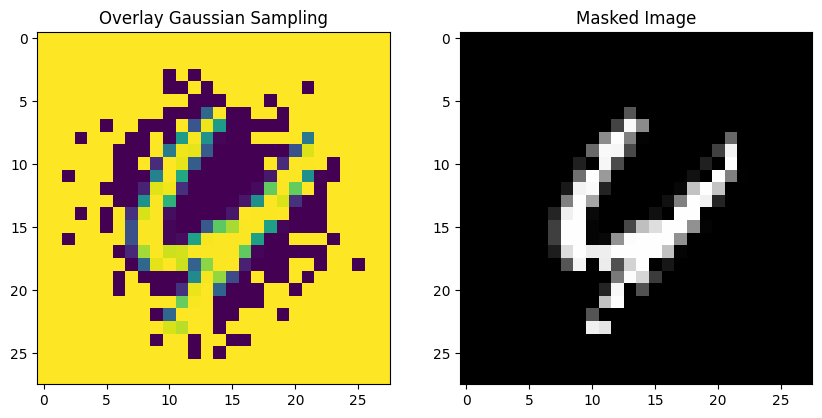

In [ ]:
#check the code is correct
flat_image = X_train.iloc[1].values
mean = [28 / 2, 28 / 2]
cov = [[28 / 2, 0], [0, 28 / 2]]
x, y = np.random.multivariate_normal(mean, cov, 700).T

# Clip the indices to the valid range
x = np.clip(x, 0, 28 - 1).astype(int)
y = np.clip(y, 0, 28 - 1).astype(int)

# Convert the 2D indices to 1D indices
selected_pixels = x * 28 + y

# Create an overlay image
overlay_image = np.full((28, 28), fill_value=255)  # create a white image for overlay
overlay_image.flat[selected_pixels] = flat_image[selected_pixels]  # set selected pixels to original values

# Creating a masked image for comparison
mask = np.zeros(len(flat_image), dtype=bool)
mask[selected_pixels] = True
masked_image = flat_image * mask.astype(int)

# Display both images for comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(overlay_image.reshape(28, 28), cmap='viridis')
axes[0].set_title('Overlay Gaussian Sampling')
axes[1].imshow(masked_image.reshape(28, 28), cmap='gray')
axes[1].set_title('Masked Image')
plt.show()

# Example.

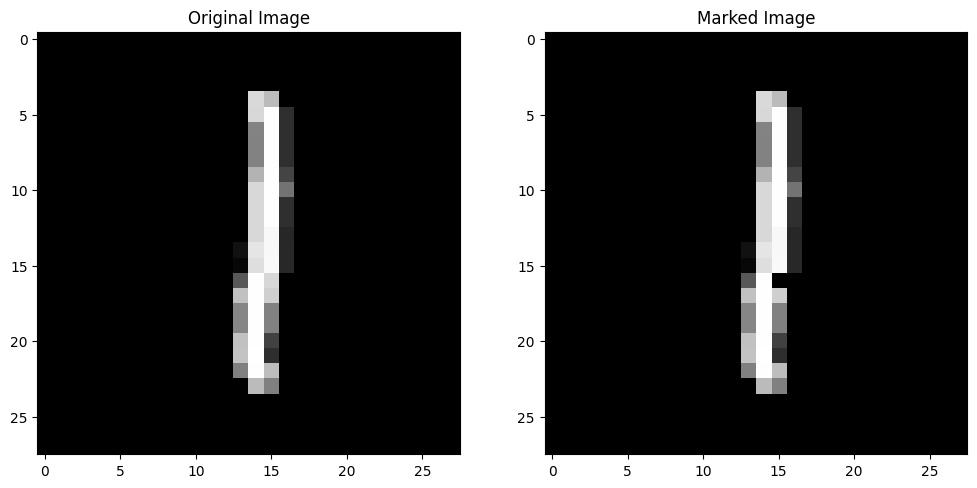

In [33]:
X_train, X_test, y_train, y_test, X_train_subset, y_train_subset = prepare_data(X, y)

flat_image = X_train_subset.iloc[10].values
mark_and_display_image(flat_image, 463)

# Section 2: Experiments to determine contribution of each pixel and create algorithms

Idea: accuracy learnt on all other pixels, if accuracy drops you know --> notion comes from random forrest --> variable importance --> when I remove that feature do I have improvement or drop in accuracy,  1-accuracy - is a measure of importance of that feature I, you can rank all features by decreasing order of importance, --> is there a pattern that emerges? maybe some interesting pattern, maybe importance is very different for the zeros and very different for the fives, finding ultimate representations of semantics of that particular problem,

Calculating the overall pixel importances

In [ ]:
pixel_importance, pixel_importances_per_class = evaluate_pixel_importance(X_train_subset, y_train_subset, X_test, y_test)

In [ ]:
pixels =  {0: 0.041071414947509766, 1: 0.03678572177886963, 2: 0.03457140922546387, 3: 0.03964287042617798, 4: 0.03407144546508789, 5: 0.039571404457092285, 6: 0.04021430015563965, 7: 0.03307145833969116, 8: 0.040285706520080566, 9: 0.03585714101791382, 10: 0.03714287281036377, 11: 0.03864288330078125, 12: 0.030571401119232178, 13: 0.035357117652893066, 14: 0.04021430015563965, 15: 0.03635716438293457, 16: 0.03514283895492554, 17: 0.035357117652893066, 18: 0.039571404457092285, 19: 0.0308571457862854, 20: 0.0422857403755188, 21: 0.03357142210006714, 22: 0.03614288568496704, 23: 0.03628569841384888, 24: 0.03014284372329712, 25: 0.03450000286102295, 26: 0.03557145595550537, 27: 0.03435713052749634, 28: 0.0389285683631897, 29: 0.03614288568496704, 30: 0.033214271068573, 31: 0.03385716676712036, 32: 0.03378570079803467, 33: 0.039571404457092285, 34: 0.03171426057815552, 35: 0.046571433544158936, 36: 0.03635716438293457, 37: 0.037071406841278076, 38: 0.03371429443359375, 39: 0.04100000858306885, 40: 0.03850001096725464, 41: 0.03700000047683716, 42: 0.034785687923431396, 43: 0.03678572177886963, 44: 0.043071448802948, 45: 0.0339999794960022, 46: 0.03271430730819702, 47: 0.03278571367263794, 48: 0.03171426057815552, 49: 0.045071423053741455, 50: 0.03978574275970459, 51: 0.043785691261291504, 52: 0.03285712003707886, 53: 0.03442859649658203, 54: 0.04178571701049805, 55: 0.03328573703765869, 56: 0.0365714430809021, 57: 0.03064286708831787, 58: 0.03778570890426636, 59: 0.03149998188018799, 60: 0.03178572654724121, 61: 0.0350000262260437, 62: 0.038428544998168945, 63: 0.036499977111816406, 64: 0.03928571939468384, 65: 0.03221428394317627, 66: 0.03299999237060547, 67: 0.03028571605682373, 68: 0.0373571515083313, 69: 0.03757143020629883, 70: 0.03471428155899048, 71: 0.0339999794960022, 72: 0.040499985218048096, 73: 0.044357120990753174, 74: 0.03757143020629883, 75: 0.03857141733169556, 76: 0.03414285182952881, 77: 0.03357142210006714, 78: 0.03235715627670288, 79: 0.03299999237060547, 80: 0.039357125759124756, 81: 0.03521430492401123, 82: 0.03457140922546387, 83: 0.04057145118713379, 84: 0.03485715389251709, 85: 0.03157144784927368, 86: 0.03464287519454956, 87: 0.04328572750091553, 88: 0.03928571939468384, 89: 0.03885716199874878, 90: 0.03778570890426636, 91: 0.03835713863372803, 92: 0.03450000286102295, 93: 0.04035717248916626, 94: 0.03328573703765869, 95: 0.03635716438293457, 96: 0.038214266300201416, 97: 0.03850001096725464, 98: 0.04000002145767212, 99: 0.03778570890426636, 100: 0.0365714430809021, 101: 0.03635716438293457, 102: 0.03778570890426636, 103: 0.03385716676712036, 104: 0.037285685539245605, 105: 0.037642836570739746, 106: 0.037285685539245605, 107: 0.03642857074737549, 108: 0.03299999237060547, 109: 0.0381428599357605, 110: 0.03278571367263794, 111: 0.03185713291168213, 112: 0.042214274406433105, 113: 0.03285712003707886, 114: 0.03149998188018799, 115: 0.03721427917480469, 116: 0.03799998760223389, 117: 0.042999982833862305, 118: 0.0339999794960022, 119: 0.03457140922546387, 120: 0.03185713291168213, 121: 0.03685712814331055, 122: 0.03464287519454956, 123: 0.03828573226928711, 124: 0.03600001335144043, 125: 0.0357857346534729, 126: 0.04992854595184326, 127: 0.03421425819396973, 128: 0.03235715627670288, 129: 0.03671431541442871, 130: 0.041071414947509766, 131: 0.03135716915130615, 132: 0.03928571939468384, 133: 0.046071410179138184, 134: 0.04000002145767212, 135: 0.04100000858306885, 136: 0.03200000524520874, 137: 0.03492856025695801, 138: 0.038428544998168945, 139: 0.04342859983444214, 140: 0.03792858123779297, 141: 0.039357125759124756, 142: 0.03557145595550537, 143: 0.03471428155899048, 144: 0.03299999237060547, 145: 0.036499977111816406, 146: 0.03450000286102295, 147: 0.03635716438293457, 148: 0.03421425819396973, 149: 0.03928571939468384, 150: 0.03200000524520874, 151: 0.04042857885360718, 152: 0.04292857646942139, 153: 0.03557145595550537, 154: 0.03335714340209961, 155: 0.0373571515083313, 156: 0.04192858934402466, 157: 0.03949999809265137, 158: 0.03692859411239624, 159: 0.029857158660888672, 160: 0.0373571515083313, 161: 0.03557145595550537, 162: 0.03614288568496704, 163: 0.03664284944534302, 164: 0.03257143497467041, 165: 0.0357857346534729, 166: 0.03385716676712036, 167: 0.03614288568496704, 168: 0.03507143259048462, 169: 0.03692859411239624, 170: 0.039357125759124756, 171: 0.03514283895492554, 172: 0.04021430015563965, 173: 0.03750002384185791, 174: 0.043928563594818115, 175: 0.03364282846450806, 176: 0.03857141733169556, 177: 0.03507143259048462, 178: 0.0389285683631897, 179: 0.03614288568496704, 180: 0.03521430492401123, 181: 0.03564286231994629, 182: 0.03714287281036377, 183: 0.03600001335144043, 184: 0.03471428155899048, 185: 0.03542858362197876, 186: 0.03342854976654053, 187: 0.03692859411239624, 188: 0.038785696029663086, 189: 0.0373571515083313, 190: 0.03178572654724121, 191: 0.03214287757873535, 192: 0.037285685539245605, 193: 0.03385716676712036, 194: 0.03714287281036377, 195: 0.03564286231994629, 196: 0.03978574275970459, 197: 0.035928547382354736, 198: 0.03985714912414551, 199: 0.03714287281036377, 200: 0.03364282846450806, 201: 0.03564286231994629, 202: 0.03885716199874878, 203: 0.03664284944534302, 204: 0.03914284706115723, 205: 0.03271430730819702, 206: 0.0350000262260437, 207: 0.04214286804199219, 208: 0.041499972343444824, 209: 0.03771430253982544, 210: 0.03771430253982544, 211: 0.03271430730819702, 212: 0.03721427917480469, 213: 0.040928542613983154, 214: 0.03685712814331055, 215: 0.039928555488586426, 216: 0.03664284944534302, 217: 0.03585714101791382, 218: 0.03350001573562622, 219: 0.03442859649658203, 220: 0.03128570318222046, 221: 0.03250002861022949, 222: 0.03635716438293457, 223: 0.04135715961456299, 224: 0.035357117652893066, 225: 0.03792858123779297, 226: 0.03564286231994629, 227: 0.034785687923431396, 228: 0.03207141160964966, 229: 0.040857136249542236, 230: 0.04192858934402466, 231: 0.03299999237060547, 232: 0.03792858123779297, 233: 0.0350000262260437, 234: 0.037071406841278076, 235: 0.03585714101791382, 236: 0.03378570079803467, 237: 0.03907144069671631, 238: 0.03385716676712036, 239: 0.03985714912414551, 240: 0.04100000858306885, 241: 0.03350001573562622, 242: 0.03485715389251709, 243: 0.046428561210632324, 244: 0.03585714101791382, 245: 0.040928542613983154, 246: 0.03528571128845215, 247: 0.03685712814331055, 248: 0.04557144641876221, 249: 0.044928550720214844, 250: 0.03628569841384888, 251: 0.04135715961456299, 252: 0.03671431541442871, 253: 0.0316428542137146, 254: 0.03557145595550537, 255: 0.03671431541442871, 256: 0.04064285755157471, 257: 0.03607141971588135, 258: 0.04000002145767212, 259: 0.03928571939468384, 260: 0.03257143497467041, 261: 0.03621429204940796, 262: 0.034785687923431396, 263: 0.038428544998168945, 264: 0.042071402072906494, 265: 0.03371429443359375, 266: 0.04671430587768555, 267: 0.03557145595550537, 268: 0.04171431064605713, 269: 0.03492856025695801, 270: 0.0324285626411438, 271: 0.0339999794960022, 272: 0.03149998188018799, 273: 0.03742855787277222, 274: 0.03421425819396973, 275: 0.040857136249542236, 276: 0.03228569030761719, 277: 0.03471428155899048, 278: 0.037071406841278076, 279: 0.035928547382354736, 280: 0.03942859172821045, 281: 0.03778570890426636, 282: 0.044928550720214844, 283: 0.039357125759124756, 284: 0.042999982833862305, 285: 0.038428544998168945, 286: 0.03692859411239624, 287: 0.034785687923431396, 288: 0.03442859649658203, 289: 0.031142830848693848, 290: 0.0422857403755188, 291: 0.0365714430809021, 292: 0.03642857074737549, 293: 0.03671431541442871, 294: 0.038428544998168945, 295: 0.03299999237060547, 296: 0.038214266300201416, 297: 0.03385716676712036, 298: 0.039714276790618896, 299: 0.03621429204940796, 300: 0.03200000524520874, 301: 0.04650002717971802, 302: 0.03542858362197876, 303: 0.03607141971588135, 304: 0.03885716199874878, 305: 0.03350001573562622, 306: 0.03792858123779297, 307: 0.03314286470413208, 308: 0.0365714430809021, 309: 0.035928547382354736, 310: 0.0357857346534729, 311: 0.035357117652893066, 312: 0.045214295387268066, 313: 0.040142834186553955, 314: 0.03828573226928711, 315: 0.030785739421844482, 316: 0.03392857313156128, 317: 0.03985714912414551, 318: 0.03850001096725464, 319: 0.038214266300201416, 320: 0.03857141733169556, 321: 0.04000002145767212, 322: 0.03928571939468384, 323: 0.03328573703765869, 324: 0.03942859172821045, 325: 0.039571404457092285, 326: 0.03978574275970459, 327: 0.039357125759124756, 328: 0.03299999237060547, 329: 0.040714263916015625, 330: 0.03685712814331055, 331: 0.03364282846450806, 332: 0.03807145357131958, 333: 0.037071406841278076, 334: 0.03742855787277222, 335: 0.0357857346534729, 336: 0.03628569841384888, 337: 0.038428544998168945, 338: 0.03235715627670288, 339: 0.03742855787277222, 340: 0.03864288330078125, 341: 0.03685712814331055, 342: 0.0373571515083313, 343: 0.03778570890426636, 344: 0.03799998760223389, 345: 0.03278571367263794, 346: 0.03621429204940796, 347: 0.03700000047683716, 348: 0.03792858123779297, 349: 0.03457140922546387, 350: 0.0316428542137146, 351: 0.03664284944534302, 352: 0.0308571457862854, 353: 0.040857136249542236, 354: 0.03664284944534302, 355: 0.03664284944534302, 356: 0.03342854976654053, 357: 0.03914284706115723, 358: 0.03771430253982544, 359: 0.03907144069671631, 360: 0.03585714101791382, 361: 0.0365714430809021, 362: 0.0350000262260437, 363: 0.03700000047683716, 364: 0.037642836570739746, 365: 0.03121429681777954, 366: 0.03642857074737549, 367: 0.03907144069671631, 368: 0.03742855787277222, 369: 0.040857136249542236, 370: 0.03292858600616455, 371: 0.03571426868438721, 372: 0.03414285182952881, 373: 0.038428544998168945, 374: 0.038214266300201416, 375: 0.03214287757873535, 376: 0.046428561210632324, 377: 0.03414285182952881, 378: 0.03392857313156128, 379: 0.03507143259048462, 380: 0.03771430253982544, 381: 0.03185713291168213, 382: 0.03350001573562622, 383: 0.03828573226928711, 384: 0.03342854976654053, 385: 0.03414285182952881, 386: 0.04614287614822388, 387: 0.04035717248916626, 388: 0.040285706520080566, 389: 0.03678572177886963, 390: 0.03442859649658203, 391: 0.03678572177886963, 392: 0.03542858362197876, 393: 0.03385716676712036, 394: 0.03385716676712036, 395: 0.03185713291168213, 396: 0.03514283895492554, 397: 0.03357142210006714, 398: 0.041642844676971436, 399: 0.04514282941818237, 400: 0.03607141971588135, 401: 0.03200000524520874, 402: 0.03914284706115723, 403: 0.03357142210006714, 404: 0.03464287519454956, 405: 0.03378570079803467, 406: 0.03871428966522217, 407: 0.041071414947509766, 408: 0.03221428394317627, 409: 0.03221428394317627, 410: 0.041857123374938965, 411: 0.03271430730819702, 412: 0.043357133865356445, 413: 0.03557145595550537, 414: 0.03521430492401123, 415: 0.03471428155899048, 416: 0.03871428966522217, 417: 0.03464287519454956, 418: 0.03621429204940796, 419: 0.03335714340209961, 420: 0.0316428542137146, 421: 0.03464287519454956, 422: 0.03642857074737549, 423: 0.0350000262260437, 424: 0.03914284706115723, 425: 0.03664284944534302, 426: 0.034785687923431396, 427: 0.04100000858306885, 428: 0.040285706520080566, 429: 0.03492856025695801, 430: 0.039928555488586426, 431: 0.03721427917480469, 432: 0.03750002384185791, 433: 0.03457140922546387, 434: 0.034785687923431396, 435: 0.03549998998641968, 436: 0.03635716438293457, 437: 0.03828573226928711, 438: 0.03514283895492554, 439: 0.03485715389251709, 440: 0.03678572177886963, 441: 0.039357125759124756, 442: 0.03542858362197876, 443: 0.03528571128845215, 444: 0.03678572177886963, 445: 0.03835713863372803, 446: 0.03285712003707886, 447: 0.037857115268707275, 448: 0.038999974727630615, 449: 0.03692859411239624, 450: 0.03285712003707886, 451: 0.03421425819396973, 452: 0.0365714430809021, 453: 0.03342854976654053, 454: 0.0389285683631897, 455: 0.03278571367263794, 456: 0.03678572177886963, 457: 0.042071402072906494, 458: 0.03914284706115723, 459: 0.03307145833969116, 460: 0.035357117652893066, 461: 0.0339999794960022, 462: 0.03521430492401123, 463: 0.0365714430809021, 464: 0.03557145595550537, 465: 0.03564286231994629, 466: 0.041857123374938965, 467: 0.039928555488586426, 468: 0.03507143259048462, 469: 0.03564286231994629, 470: 0.03335714340209961, 471: 0.0389285683631897, 472: 0.03671431541442871, 473: 0.03378570079803467, 474: 0.03507143259048462, 475: 0.04171431064605713, 476: 0.03142857551574707, 477: 0.03450000286102295, 478: 0.03614288568496704, 479: 0.03171426057815552, 480: 0.03235715627670288, 481: 0.035928547382354736, 482: 0.03528571128845215, 483: 0.03221428394317627, 484: 0.0339999794960022, 485: 0.047928571701049805, 486: 0.0324285626411438, 487: 0.043928563594818115, 488: 0.03485715389251709, 489: 0.03549998998641968, 490: 0.03871428966522217, 491: 0.03835713863372803, 492: 0.0389285683631897, 493: 0.03571426868438721, 494: 0.046000003814697266, 495: 0.04007142782211304, 496: 0.039571404457092285, 497: 0.034785687923431396, 498: 0.03350001573562622, 499: 0.03207141160964966, 500: 0.040142834186553955, 501: 0.0308571457862854, 502: 0.03549998998641968, 503: 0.03414285182952881, 504: 0.038785696029663086, 505: 0.03457140922546387, 506: 0.03214287757873535, 507: 0.03214287757873535, 508: 0.03257143497467041, 509: 0.040928542613983154, 510: 0.03328573703765869, 511: 0.03850001096725464, 512: 0.03457140922546387, 513: 0.03771430253982544, 514: 0.03549998998641968, 515: 0.035357117652893066, 516: 0.03907144069671631, 517: 0.03357142210006714, 518: 0.03457140922546387, 519: 0.038999974727630615, 520: 0.03564286231994629, 521: 0.03507143259048462, 522: 0.03757143020629883, 523: 0.04135715961456299, 524: 0.04035717248916626, 525: 0.03521430492401123, 526: 0.038785696029663086, 527: 0.03549998998641968, 528: 0.037071406841278076, 529: 0.03542858362197876, 530: 0.03521430492401123, 531: 0.03850001096725464, 532: 0.0389285683631897, 533: 0.03557145595550537, 534: 0.03585714101791382, 535: 0.03692859411239624, 536: 0.03464287519454956, 537: 0.03257143497467041, 538: 0.039928555488586426, 539: 0.04007142782211304, 540: 0.03428572416305542, 541: 0.03521430492401123, 542: 0.03335714340209961, 543: 0.03614288568496704, 544: 0.03128570318222046, 545: 0.03414285182952881, 546: 0.045499980449676514, 547: 0.03471428155899048, 548: 0.03342854976654053, 549: 0.03185713291168213, 550: 0.03614288568496704, 551: 0.03271430730819702, 552: 0.034785687923431396, 553: 0.03492856025695801, 554: 0.03471428155899048, 555: 0.04007142782211304, 556: 0.03514283895492554, 557: 0.03771430253982544, 558: 0.035928547382354736, 559: 0.03614288568496704, 560: 0.03542858362197876, 561: 0.03685712814331055, 562: 0.040142834186553955, 563: 0.03171426057815552, 564: 0.0422857403755188, 565: 0.03985714912414551, 566: 0.03564286231994629, 567: 0.03942859172821045, 568: 0.0300714373588562, 569: 0.04007142782211304, 570: 0.0373571515083313, 571: 0.03792858123779297, 572: 0.03914284706115723, 573: 0.037285685539245605, 574: 0.0373571515083313, 575: 0.044642865657806396, 576: 0.041642844676971436, 577: 0.03628569841384888, 578: 0.03471428155899048, 579: 0.036499977111816406, 580: 0.03692859411239624, 581: 0.03571426868438721, 582: 0.038785696029663086, 583: 0.03464287519454956, 584: 0.03607141971588135, 585: 0.03614288568496704, 586: 0.04192858934402466, 587: 0.03264284133911133, 588: 0.03428572416305542, 589: 0.03064286708831787, 590: 0.0350000262260437, 591: 0.03492856025695801, 592: 0.03685712814331055, 593: 0.03607141971588135, 594: 0.03471428155899048, 595: 0.03392857313156128, 596: 0.03235715627670288, 597: 0.03128570318222046, 598: 0.03799998760223389, 599: 0.03585714101791382, 600: 0.03642857074737549, 601: 0.034785687923431396, 602: 0.04135715961456299, 603: 0.03914284706115723, 604: 0.0389285683631897, 605: 0.03742855787277222, 606: 0.04157143831253052, 607: 0.03307145833969116, 608: 0.03571426868438721, 609: 0.04157143831253052, 610: 0.03664284944534302, 611: 0.03871428966522217, 612: 0.03350001573562622, 613: 0.04057145118713379, 614: 0.039928555488586426, 615: 0.03357142210006714, 616: 0.03799998760223389, 617: 0.0339999794960022, 618: 0.03949999809265137, 619: 0.035928547382354736, 620: 0.04614287614822388, 621: 0.03457140922546387, 622: 0.03771430253982544, 623: 0.03871428966522217, 624: 0.03135716915130615, 625: 0.03257143497467041, 626: 0.040857136249542236, 627: 0.03742855787277222, 628: 0.03885716199874878, 629: 0.03149998188018799, 630: 0.03457140922546387, 631: 0.03757143020629883, 632: 0.03549998998641968, 633: 0.044142842292785645, 634: 0.03978574275970459, 635: 0.03471428155899048, 636: 0.03492856025695801, 637: 0.0350000262260437, 638: 0.03328573703765869, 639: 0.03850001096725464, 640: 0.04192858934402466, 641: 0.03407144546508789, 642: 0.03621429204940796, 643: 0.03335714340209961, 644: 0.03414285182952881, 645: 0.035357117652893066, 646: 0.03357142210006714, 647: 0.029999971389770508, 648: 0.03635716438293457, 649: 0.03514283895492554, 650: 0.03228569030761719, 651: 0.039357125759124756, 652: 0.03671431541442871, 653: 0.04271429777145386, 654: 0.041642844676971436, 655: 0.041499972343444824, 656: 0.03921431303024292, 657: 0.049571454524993896, 658: 0.03864288330078125, 659: 0.03528571128845215, 660: 0.0381428599357605, 661: 0.03671431541442871, 662: 0.03571426868438721, 663: 0.03142857551574707, 664: 0.04042857885360718, 665: 0.03371429443359375, 666: 0.03421425819396973, 667: 0.03835713863372803, 668: 0.03778570890426636, 669: 0.0365714430809021, 670: 0.03264284133911133, 671: 0.03771430253982544, 672: 0.03585714101791382, 673: 0.0422857403755188, 674: 0.04021430015563965, 675: 0.04442858695983887, 676: 0.042428553104400635, 677: 0.035928547382354736, 678: 0.03871428966522217, 679: 0.03385716676712036, 680: 0.03635716438293457, 681: 0.03557145595550537, 682: 0.03542858362197876, 683: 0.03357142210006714, 684: 0.0350000262260437, 685: 0.03314286470413208, 686: 0.03214287757873535, 687: 0.0350000262260437, 688: 0.03628569841384888, 689: 0.03864288330078125, 690: 0.03064286708831787, 691: 0.03664284944534302, 692: 0.03464287519454956, 693: 0.03721427917480469, 694: 0.03278571367263794, 695: 0.040499985218048096, 696: 0.03342854976654053, 697: 0.03871428966522217, 698: 0.036499977111816406, 699: 0.03621429204940796, 700: 0.030571401119232178, 701: 0.04100000858306885, 702: 0.036499977111816406, 703: 0.03871428966522217, 704: 0.036499977111816406, 705: 0.03850001096725464, 706: 0.03442859649658203, 707: 0.03614288568496704, 708: 0.03549998998641968, 709: 0.03514283895492554, 710: 0.036499977111816406, 711: 0.031142830848693848, 712: 0.03485715389251709, 713: 0.03285712003707886, 714: 0.03557145595550537, 715: 0.03514283895492554, 716: 0.031142830848693848, 717: 0.040499985218048096, 718: 0.0373571515083313, 719: 0.03464287519454956, 720: 0.03035712242126465, 721: 0.03757143020629883, 722: 0.04764288663864136, 723: 0.03807145357131958, 724: 0.03507143259048462, 725: 0.033214271068573, 726: 0.03721427917480469, 727: 0.037642836570739746, 728: 0.03357142210006714, 729: 0.0365714430809021, 730: 0.03378570079803467, 731: 0.03192859888076782, 732: 0.042642831802368164, 733: 0.0381428599357605, 734: 0.039357125759124756, 735: 0.038428544998168945, 736: 0.039357125759124756, 737: 0.03964287042617798, 738: 0.03235715627670288, 739: 0.03942859172821045, 740: 0.03607141971588135, 741: 0.03557145595550537, 742: 0.03528571128845215, 743: 0.04778569936752319, 744: 0.03407144546508789, 745: 0.03200000524520874, 746: 0.03642857074737549, 747: 0.03135716915130615, 748: 0.03778570890426636, 749: 0.037285685539245605, 750: 0.03635716438293457, 751: 0.030571401119232178, 752: 0.03457140922546387, 753: 0.043571412563323975, 754: 0.03857141733169556, 755: 0.043214261531829834, 756: 0.03642857074737549, 757: 0.03678572177886963, 758: 0.03492856025695801, 759: 0.03792858123779297, 760: 0.03471428155899048, 761: 0.03442859649658203, 762: 0.04057145118713379, 763: 0.03528571128845215, 764: 0.040142834186553955, 765: 0.04000002145767212, 766: 0.04214286804199219, 767: 0.04000002145767212, 768: 0.03314286470413208, 769: 0.039571404457092285, 770: 0.036499977111816406, 771: 0.03185713291168213, 772: 0.042642831802368164, 773: 0.03457140922546387, 774: 0.036499977111816406, 775: 0.035357117652893066, 776: 0.03235715627670288, 777: 0.04007142782211304, 778: 0.03214287757873535, 779: 0.03271430730819702, 780: 0.035357117652893066, 781: 0.04271429777145386, 782: 0.03178572654724121, 783: 0.03357142210006714}

10 4
285 0.038428544998168945
10 5
286 0.03692859411239624
10 6
287 0.034785687923431396
10 7
288 0.03442859649658203
10 8
289 0.031142830848693848
10 9
290 0.0422857403755188
10 10
291 0.0365714430809021
10 11
292 0.03642857074737549
10 12
293 0.03671431541442871
10 13
294 0.038428544998168945
10 14
295 0.03299999237060547
10 15
296 0.038214266300201416
10 16
297 0.03385716676712036
10 17
298 0.039714276790618896
10 18
299 0.03621429204940796
10 19
300 0.03200000524520874
10 20
301 0.04650002717971802
10 21
302 0.03542858362197876
10 22
303 0.03607141971588135
10 23
304 0.03885716199874878
10 24
305 0.03350001573562622
10 25
306 0.03792858123779297
10 26
307 0.03314286470413208
10 27
308 0.0365714430809021
11 0
309 0.035928547382354736
11 1
310 0.0357857346534729
11 2
311 0.035357117652893066
11 3
312 0.045214295387268066
11 4
313 0.040142834186553955
11 5
314 0.03828573226928711
11 6
315 0.030785739421844482
11 7
316 0.03392857313156128
11 8
317 0.03985714912414551
11 9
318 0.0385000

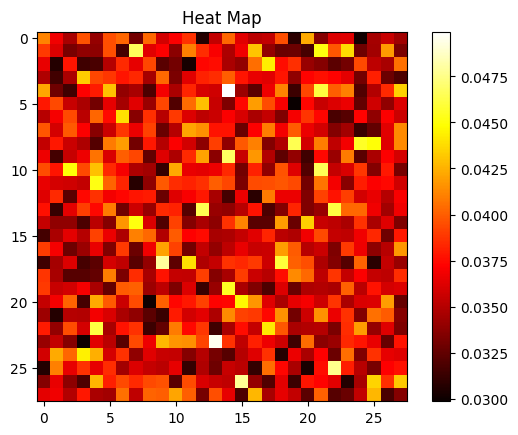

In [ ]:
generate_heatmap_from_pixels(pixels)

### SMARTPATCH_v1 for selecting only top or lowest pixels based on pixel importances

In [ ]:
run_model_with_selected_pixels(350, pixels)

2024-07-03 09:05:01.003501: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-07-03 09:05:01.003539: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-07-03 09:05:01.003564: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-ee558bc7-9ccd-4428-bb80-236363650a2f): /proc/driver/nvidia/version does not exist
2024-07-03 09:05:01.008603: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Epoch 1/5
175/175 [==============================] - 27s 153ms/step - loss: 

In [ ]:
run_model_with_selected_pixels(500, pixels, False)

Epoch 1/5
22/22 [==============================] - 4s 144ms/step - loss: 9.2436 - accuracy: 0.3550
Epoch 2/5
22/22 [==============================] - 3s 143ms/step - loss: 1.0496 - accuracy: 0.6579
Epoch 3/5
22/22 [==============================] - 3s 140ms/step - loss: 0.5712 - accuracy: 0.8318
Epoch 4/5
22/22 [==============================] - 3s 143ms/step - loss: 0.3601 - accuracy: 0.8875
Epoch 5/5
438/438 [==============================] - 5s 11ms/step
Score after only keeping these pixels: [159, 647, 568, 24, 67, 720, 12, 700, 751, 57, 589, 690, 315, 19, 352, 501, 289, 711, 716, 365, 220, 544, 597, 131, 624, 747, 476, 663, 59, 114, 272, 629, 85, 253, 350, 420, 34, 48, 479, 563, 60, 190, 782, 111, 120, 381, 395, 549, 771, 731, 136, 150, 300, 401, 745, 228, 499, 191, 375, 506, 507, 686, 778, 65, 408, 409, 483, 276, 650, 78, 128, 338, 480, 596, 738, 776, 270, 486, 221, 164, 260, 508, 537, 625, 587, 670, 46, 205, 211, 411, 551, 779, 47, 110, 345, 455, 694, 52, 113, 446, 450, 713, 370

In [ ]:
run_model_with_selected_pixels(500, pixels, True)

Epoch 1/5
22/22 [==============================] - 4s 143ms/step - loss: 12.6607 - accuracy: 0.3025
Epoch 2/5
22/22 [==============================] - 3s 143ms/step - loss: 1.4872 - accuracy: 0.5968
Epoch 3/5
22/22 [==============================] - 3s 149ms/step - loss: 0.8344 - accuracy: 0.7371
Epoch 4/5
22/22 [==============================] - 3s 143ms/step - loss: 0.5517 - accuracy: 0.8311
Epoch 5/5
438/438 [==============================] - 5s 11ms/step
Score after only keeping these pixels: [126, 657, 485, 743, 722, 266, 35, 301, 243, 376, 386, 620, 133, 494, 248, 546, 312, 399, 49, 249, 282, 575, 675, 73, 633, 174, 487, 51, 753, 139, 412, 87, 755, 44, 117, 284, 152, 653, 781, 732, 772, 676, 20, 290, 564, 673, 112, 207, 766, 264, 457, 156, 230, 586, 640, 410, 466, 54, 268, 475, 398, 576, 654, 606, 609, 208, 655, 223, 251, 523, 602, 0, 130, 407, 39, 135, 240, 427, 701, 213, 245, 509, 229, 275, 353, 369, 626, 329, 256, 83, 613, 762, 72, 695, 717, 151, 664, 93, 387, 524, 8, 388, 428

In [ ]:
run_model_with_selected_pixels(700, pixels, True)

Epoch 1/5
22/22 [==============================] - 4s 148ms/step - loss: 10.9738 - accuracy: 0.4068
Epoch 2/5
22/22 [==============================] - 3s 144ms/step - loss: 0.9473 - accuracy: 0.6975
Epoch 3/5
22/22 [==============================] - 3s 148ms/step - loss: 0.5643 - accuracy: 0.8261
Epoch 4/5
22/22 [==============================] - 3s 146ms/step - loss: 0.3791 - accuracy: 0.8871
Epoch 5/5
438/438 [==============================] - 5s 11ms/step
Score after only keeping these pixels: [126, 657, 485, 743, 722, 266, 35, 301, 243, 376, 386, 620, 133, 494, 248, 546, 312, 399, 49, 249, 282, 575, 675, 73, 633, 174, 487, 51, 753, 139, 412, 87, 755, 44, 117, 284, 152, 653, 781, 732, 772, 676, 20, 290, 564, 673, 112, 207, 766, 264, 457, 156, 230, 586, 640, 410, 466, 54, 268, 475, 398, 576, 654, 606, 609, 208, 655, 223, 251, 523, 602, 0, 130, 407, 39, 135, 240, 427, 701, 213, 245, 509, 229, 275, 353, 369, 626, 329, 256, 83, 613, 762, 72, 695, 717, 151, 664, 93, 387, 524, 8, 388, 428

### Calculating Pixel importances with respect to each class

In [41]:
copy_pixel_importance_per_class = {0: {0: 0.9895755770662695, 1: 0.9875, 2: 0.9398550724637681, 3: 0.9581297976273552, 4: 0.9590733590733591, 5: 0.9473684210526315, 6: 0.9885386819484241, 7: 0.9767132401862941, 8: 0.9491525423728814, 9: 0.9514084507042253}, 1: {0: 0.9821295606850335, 1: 0.989375, 2: 0.9637681159420289, 3: 0.9616189811584089, 4: 0.9536679536679536, 5: 0.9701492537313433, 6: 0.9770773638968482, 7: 0.9600798403193613, 8: 0.9565217391304348, 9: 0.9528169014084507}, 2: {0: 0.9620253164556962, 1: 0.99, 2: 0.922463768115942, 3: 0.9385903698534543, 4: 0.9652509652509652, 5: 0.9803613511390417, 6: 0.9785100286532952, 7: 0.9753825681969395, 8: 0.9285187914517318, 9: 0.9485915492957746}, 3: {0: 0.9679821295606851, 1: 0.98, 2: 0.9746376811594203, 3: 0.9672016748080949, 4: 0.9606177606177606, 5: 0.9732914375490966, 6: 0.9828080229226361, 7: 0.9447771124417831, 8: 0.9395725865880619, 9: 0.9443661971830986}, 4: {0: 0.953090096798213, 1: 0.98125, 2: 0.9072463768115943, 3: 0.9497557571528262, 4: 0.9359073359073359, 5: 0.9190887666928516, 6: 0.9842406876790831, 7: 0.9208250166333999, 8: 0.974207811348563, 9: 0.9478873239436619}, 5: {0: 0.9873417721518988, 1: 0.985625, 2: 0.9398550724637681, 3: 0.9623168178646196, 4: 0.9544401544401544, 5: 0.974076983503535, 6: 0.9799426934097422, 7: 0.9820359281437125, 8: 0.9587324981577008, 9: 0.9415492957746479}, 6: {0: 0.9769173492181683, 1: 0.984375, 2: 0.9681159420289855, 3: 0.9706908583391486, 4: 0.9675675675675676, 5: 0.9552238805970149, 6: 0.9756446991404012, 7: 0.9680638722554891, 8: 0.9498894620486367, 9: 0.9373239436619718}, 7: {0: 0.9761727475800447, 1: 0.98125, 2: 0.9688405797101449, 3: 0.9720865317515701, 4: 0.976061776061776, 5: 0.9473684210526315, 6: 0.9842406876790831, 7: 0.9520958083832335, 8: 0.9307295504789977, 9: 0.9366197183098591}, 8: {0: 0.9746835443037974, 1: 0.976875, 2: 0.9434782608695652, 3: 0.9176552686671319, 4: 0.9752895752895753, 5: 0.9607227022780833, 6: 0.9792263610315186, 7: 0.9780439121756487, 8: 0.9543109801031687, 9: 0.9225352112676056}, 9: {0: 0.9888309754281459, 1: 0.983125, 2: 0.9297101449275362, 3: 0.9595254710397767, 4: 0.9505791505791505, 5: 0.9874312647289867, 6: 0.9720630372492837, 7: 0.9753825681969395, 8: 0.9322033898305084, 9: 0.9485915492957746}, 10: {0: 0.9858525688756515, 1: 0.9875, 2: 0.9471014492753623, 3: 0.9699930216329379, 4: 0.9791505791505791, 5: 0.9560094265514533, 6: 0.9785100286532952, 7: 0.9640718562874252, 8: 0.9675755342667649, 9: 0.9528169014084507}, 11: {0: 0.9761727475800447, 1: 0.98625, 2: 0.9688405797101449, 3: 0.9630146545708305, 4: 0.9683397683397683, 5: 0.9489395129615082, 6: 0.9835243553008596, 7: 0.9614105123087159, 8: 0.969786293294031, 9: 0.9457746478873239}, 12: {0: 0.9694713328369322, 1: 0.978125, 2: 0.9304347826086956, 3: 0.9727843684577809, 4: 0.9714285714285714, 5: 0.9756480754124116, 6: 0.9777936962750716, 7: 0.9640718562874252, 8: 0.94620486366986, 9: 0.9669014084507043}, 13: {0: 0.992553983618764, 1: 0.98375, 2: 0.9528985507246377, 3: 0.9504535938590369, 4: 0.9698841698841699, 5: 0.9780047132757266, 6: 0.9713467048710601, 7: 0.9620758483033932, 8: 0.9344141488577745, 9: 0.9471830985915493}, 14: {0: 0.9806403574087863, 1: 0.98, 2: 0.9666666666666667, 3: 0.9672016748080949, 4: 0.9444015444015444, 5: 0.9709347996857817, 6: 0.9813753581661891, 7: 0.9620758483033932, 8: 0.9498894620486367, 9: 0.9514084507042253}, 15: {0: 0.9798957557706627, 1: 0.983125, 2: 0.9579710144927536, 3: 0.9483600837404047, 4: 0.9536679536679536, 5: 0.9654359780047133, 6: 0.9792263610315186, 7: 0.9620758483033932, 8: 0.9579955784819455, 9: 0.9633802816901409}, 16: {0: 0.9694713328369322, 1: 0.985625, 2: 0.9710144927536232, 3: 0.9595254710397767, 4: 0.9776061776061776, 5: 0.9512961508248232, 6: 0.9785100286532952, 7: 0.9554224883566201, 8: 0.9565217391304348, 9: 0.9471830985915493}, 17: {0: 0.9851079672375279, 1: 0.97625, 2: 0.9528985507246377, 3: 0.9385903698534543, 4: 0.9621621621621622, 5: 0.9552238805970149, 6: 0.9813753581661891, 7: 0.9607451763140386, 8: 0.9476787030213707, 9: 0.9591549295774648}, 18: {0: 0.9813849590469099, 1: 0.981875, 2: 0.9340579710144927, 3: 0.9692951849267272, 4: 0.9714285714285714, 5: 0.9780047132757266, 6: 0.9799426934097422, 7: 0.9693945442448436, 8: 0.9550478997789241, 9: 0.9626760563380282}, 19: {0: 0.9679821295606851, 1: 0.97625, 2: 0.9630434782608696, 3: 0.9225401256106072, 4: 0.9467181467181467, 5: 0.9756480754124116, 6: 0.9785100286532952, 7: 0.9647371922821024, 8: 0.948415622697126, 9: 0.956338028169014}, 20: {0: 0.9754281459419211, 1: 0.986875, 2: 0.9782608695652174, 3: 0.9546406140963015, 4: 0.9444015444015444, 5: 0.9402985074626866, 6: 0.9949856733524355, 7: 0.9693945442448436, 8: 0.9322033898305084, 9: 0.9584507042253522}, 21: {0: 0.9583023082650782, 1: 0.97125, 2: 0.9572463768115942, 3: 0.9699930216329379, 4: 0.9660231660231661, 5: 0.9591516103692066, 6: 0.9620343839541547, 7: 0.9520958083832335, 8: 0.9690493736182756, 9: 0.9598591549295775}, 22: {0: 0.9836187639612807, 1: 0.989375, 2: 0.9565217391304348, 3: 0.9651081646894627, 4: 0.9212355212355212, 5: 0.950510604870385, 6: 0.9770773638968482, 7: 0.9500998003992016, 8: 0.9336772291820191, 9: 0.95}, 23: {0: 0.9709605361131795, 1: 0.985, 2: 0.9594202898550724, 3: 0.9546406140963015, 4: 0.9799227799227799, 5: 0.9756480754124116, 6: 0.9792263610315186, 7: 0.9507651363938789, 8: 0.9115696389093588, 9: 0.9478873239436619}, 24: {0: 0.9739389426656738, 1: 0.98625, 2: 0.95, 3: 0.9518492672714585, 4: 0.9660231660231661, 5: 0.9567949725058916, 6: 0.9849570200573066, 7: 0.9747172322022621, 8: 0.9380987472365512, 9: 0.9330985915492958}, 25: {0: 0.9843633655994043, 1: 0.98125, 2: 0.9710144927536232, 3: 0.9692951849267272, 4: 0.9420849420849421, 5: 0.9630793401413983, 6: 0.9785100286532952, 7: 0.9793745841650033, 8: 0.9403095062638173, 9: 0.921830985915493}, 26: {0: 0.9709605361131795, 1: 0.97, 2: 0.9471014492753623, 3: 0.9497557571528262, 4: 0.9590733590733591, 5: 0.94344069128044, 6: 0.9878223495702005, 7: 0.9773785761809713, 8: 0.9469417833456153, 9: 0.9485915492957746}, 27: {0: 0.9776619508562919, 1: 0.97875, 2: 0.9644927536231884, 3: 0.9811584089323099, 4: 0.9613899613899614, 5: 0.9654359780047133, 6: 0.9799426934097422, 7: 0.948769128409847, 8: 0.9351510685335298, 9: 0.9422535211267605}, 28: {0: 0.9769173492181683, 1: 0.97125, 2: 0.9492753623188406, 3: 0.9378925331472435, 4: 0.9768339768339769, 5: 0.9662215239591516, 6: 0.9835243553008596, 7: 0.9747172322022621, 8: 0.9425202652910832, 9: 0.928169014084507}, 29: {0: 0.9739389426656738, 1: 0.979375, 2: 0.9304347826086956, 3: 0.9434752267969295, 4: 0.9328185328185328, 5: 0.9772191673212883, 6: 0.9570200573065902, 7: 0.9660678642714571, 8: 0.9675755342667649, 9: 0.9640845070422536}, 30: {0: 0.9724497393894267, 1: 0.98375, 2: 0.9188405797101449, 3: 0.9811584089323099, 4: 0.9590733590733591, 5: 0.9583660644147682, 6: 0.9792263610315186, 7: 0.9727212242182302, 8: 0.9351510685335298, 9: 0.9528169014084507}, 31: {0: 0.9754281459419211, 1: 0.985, 2: 0.9485507246376812, 3: 0.9665038381018841, 4: 0.9660231660231661, 5: 0.9725058915946583, 6: 0.9849570200573066, 7: 0.9600798403193613, 8: 0.9329403095062638, 9: 0.9577464788732394}, 32: {0: 0.9702159344750558, 1: 0.99, 2: 0.9579710144927536, 3: 0.9302163293789253, 4: 0.983011583011583, 5: 0.9748625294579732, 6: 0.9885386819484241, 7: 0.9800399201596807, 8: 0.8872512896094326, 9: 0.8774647887323944}, 33: {0: 0.9828741623231572, 1: 0.97625, 2: 0.9652173913043478, 3: 0.9546406140963015, 4: 0.9498069498069498, 5: 0.9607227022780833, 6: 0.9691977077363897, 7: 0.9494344644045243, 8: 0.9579955784819455, 9: 0.9443661971830986}, 34: {0: 0.9798957557706627, 1: 0.983125, 2: 0.9557971014492753, 3: 0.9637124912770412, 4: 0.972972972972973, 5: 0.9772191673212883, 6: 0.9806590257879656, 7: 0.9780439121756487, 8: 0.9439941046425939, 9: 0.9485915492957746}, 35: {0: 0.9851079672375279, 1: 0.981875, 2: 0.9666666666666667, 3: 0.9490579204466155, 4: 0.9667953667953668, 5: 0.9654359780047133, 6: 0.9727793696275072, 7: 0.9820359281437125, 8: 0.9572586588061901, 9: 0.9394366197183098}, 36: {0: 0.9836187639612807, 1: 0.9775, 2: 0.9688405797101449, 3: 0.9713886950453594, 4: 0.9420849420849421, 5: 0.9748625294579732, 6: 0.9835243553008596, 7: 0.9634065202927479, 8: 0.9329403095062638, 9: 0.9507042253521126}, 37: {0: 0.9687267311988086, 1: 0.986875, 2: 0.9630434782608696, 3: 0.9658060013956734, 4: 0.9737451737451738, 5: 0.9717203456402199, 6: 0.9828080229226361, 7: 0.9640718562874252, 8: 0.9587324981577008, 9: 0.9591549295774648}, 38: {0: 0.9784065524944154, 1: 0.98375, 2: 0.9623188405797102, 3: 0.9518492672714585, 4: 0.9343629343629344, 5: 0.9552238805970149, 6: 0.9885386819484241, 7: 0.9634065202927479, 8: 0.9425202652910832, 9: 0.9612676056338029}, 39: {0: 0.9746835443037974, 1: 0.984375, 2: 0.9594202898550724, 3: 0.9665038381018841, 4: 0.9451737451737452, 5: 0.9756480754124116, 6: 0.9820916905444126, 7: 0.9414504324683965, 8: 0.9535740604274134, 9: 0.9633802816901409}, 40: {0: 0.9627699180938198, 1: 0.979375, 2: 0.9608695652173913, 3: 0.9769713886950454, 4: 0.9374517374517375, 5: 0.9575805184603299, 6: 0.9684813753581661, 7: 0.9607451763140386, 8: 0.9498894620486367, 9: 0.952112676056338}, 41: {0: 0.960536113179449, 1: 0.975625, 2: 0.9550724637681159, 3: 0.9364968597348221, 4: 0.9652509652509652, 5: 0.9748625294579732, 6: 0.9878223495702005, 7: 0.9620758483033932, 8: 0.9535740604274134, 9: 0.9450704225352112}, 42: {0: 0.9828741623231572, 1: 0.986875, 2: 0.9586956521739131, 3: 0.9734822051639916, 4: 0.9590733590733591, 5: 0.96700706991359, 6: 0.9828080229226361, 7: 0.9673985362608117, 8: 0.9565217391304348, 9: 0.969718309859155}, 43: {0: 0.9679821295606851, 1: 0.98375, 2: 0.9347826086956522, 3: 0.9741800418702024, 4: 0.9660231660231661, 5: 0.9308719560094265, 6: 0.9770773638968482, 7: 0.9587491683300067, 8: 0.9167280766396463, 9: 0.9352112676056338}, 44: {0: 0.9754281459419211, 1: 0.979375, 2: 0.9384057971014492, 3: 0.9630146545708305, 4: 0.9335907335907336, 5: 0.969363707776905, 6: 0.9691977077363897, 7: 0.9673985362608117, 8: 0.9572586588061901, 9: 0.9669014084507043}, 45: {0: 0.9843633655994043, 1: 0.9775, 2: 0.9565217391304348, 3: 0.9490579204466155, 4: 0.9544401544401544, 5: 0.9638648860958366, 6: 0.9749283667621776, 7: 0.9673985362608117, 8: 0.9646278555637435, 9: 0.9556338028169014}, 46: {0: 0.9813849590469099, 1: 0.981875, 2: 0.9623188405797102, 3: 0.9378925331472435, 4: 0.9822393822393822, 5: 0.9756480754124116, 6: 0.9799426934097422, 7: 0.9580838323353293, 8: 0.9587324981577008, 9: 0.9570422535211267}, 47: {0: 0.9791511541325391, 1: 0.974375, 2: 0.972463768115942, 3: 0.9525471039776692, 4: 0.9698841698841699, 5: 0.9803613511390417, 6: 0.9727793696275072, 7: 0.9767132401862941, 8: 0.941783345615328, 9: 0.9436619718309859}, 48: {0: 0.9739389426656738, 1: 0.98, 2: 0.9550724637681159, 3: 0.9811584089323099, 4: 0.9606177606177606, 5: 0.969363707776905, 6: 0.9842406876790831, 7: 0.948769128409847, 8: 0.9469417833456153, 9: 0.9654929577464789}, 49: {0: 0.9776619508562919, 1: 0.98, 2: 0.9601449275362319, 3: 0.9623168178646196, 4: 0.9822393822393822, 5: 0.9732914375490966, 6: 0.9878223495702005, 7: 0.978709248170326, 8: 0.9454679439941046, 9: 0.9274647887323944}, 50: {0: 0.9702159344750558, 1: 0.97, 2: 0.9623188405797102, 3: 0.9755757152826239, 4: 0.938996138996139, 5: 0.9371563236449332, 6: 0.9856733524355301, 7: 0.9673985362608117, 8: 0.9557848194546794, 9: 0.9591549295774648}, 51: {0: 0.9664929262844378, 1: 0.97875, 2: 0.9681159420289855, 3: 0.9713886950453594, 4: 0.9505791505791505, 5: 0.9261586802827966, 6: 0.9713467048710601, 7: 0.9773785761809713, 8: 0.9447310243183493, 9: 0.9338028169014084}, 52: {0: 0.9776619508562919, 1: 0.9825, 2: 0.9797101449275363, 3: 0.9706908583391486, 4: 0.9598455598455599, 5: 0.96700706991359, 6: 0.9785100286532952, 7: 0.9727212242182302, 8: 0.9351510685335298, 9: 0.9549295774647887}, 53: {0: 0.9918093819806404, 1: 0.98625, 2: 0.9804347826086957, 3: 0.9364968597348221, 4: 0.9567567567567568, 5: 0.9685781618224666, 6: 0.9742120343839542, 7: 0.9500998003992016, 8: 0.9506263817243921, 9: 0.9591549295774648}, 54: {0: 0.9627699180938198, 1: 0.971875, 2: 0.9695652173913043, 3: 0.9546406140963015, 4: 0.9714285714285714, 5: 0.9646504320502749, 6: 0.9799426934097422, 7: 0.9600798403193613, 8: 0.9476787030213707, 9: 0.9605633802816902}, 55: {0: 0.9672375279225615, 1: 0.971875, 2: 0.9478260869565217, 3: 0.944870900209351, 4: 0.9644787644787645, 5: 0.9544383346425765, 6: 0.9849570200573066, 7: 0.9713905522288756, 8: 0.9521002210759028, 9: 0.9598591549295775}, 56: {0: 0.9903201787043932, 1: 0.985625, 2: 0.9434782608695652, 3: 0.947662247034194, 4: 0.9621621621621622, 5: 0.9787902592301649, 6: 0.9792263610315186, 7: 0.9747172322022621, 8: 0.94620486366986, 9: 0.9450704225352112}, 57: {0: 0.9903201787043932, 1: 0.983125, 2: 0.9507246376811594, 3: 0.942079553384508, 4: 0.9714285714285714, 5: 0.9701492537313433, 6: 0.9777936962750716, 7: 0.9733865602129075, 8: 0.9513633014001474, 9: 0.9570422535211267}, 58: {0: 0.9784065524944154, 1: 0.98125, 2: 0.941304347826087, 3: 0.9455687369155618, 4: 0.9683397683397683, 5: 0.9622937941869599, 6: 0.9785100286532952, 7: 0.9893546240851631, 8: 0.9557848194546794, 9: 0.9267605633802817}, 59: {0: 0.9798957557706627, 1: 0.971875, 2: 0.9681159420289855, 3: 0.9490579204466155, 4: 0.9459459459459459, 5: 0.9732914375490966, 6: 0.9799426934097422, 7: 0.9733865602129075, 8: 0.9351510685335298, 9: 0.9401408450704225}, 60: {0: 0.9806403574087863, 1: 0.98125, 2: 0.9369565217391305, 3: 0.9720865317515701, 4: 0.9644787644787645, 5: 0.9725058915946583, 6: 0.9749283667621776, 7: 0.9727212242182302, 8: 0.9550478997789241, 9: 0.9295774647887324}, 61: {0: 0.9873417721518988, 1: 0.979375, 2: 0.9579710144927536, 3: 0.958827634333566, 4: 0.9660231660231661, 5: 0.959937156323645, 6: 0.9813753581661891, 7: 0.9707252162341983, 8: 0.9579955784819455, 9: 0.9274647887323944}, 62: {0: 0.9664929262844378, 1: 0.98, 2: 0.9572463768115942, 3: 0.9755757152826239, 4: 0.9474903474903474, 5: 0.9607227022780833, 6: 0.9799426934097422, 7: 0.948769128409847, 8: 0.941783345615328, 9: 0.9507042253521126}, 63: {0: 0.9709605361131795, 1: 0.978125, 2: 0.9615942028985507, 3: 0.9623168178646196, 4: 0.9822393822393822, 5: 0.9654359780047133, 6: 0.9792263610315186, 7: 0.9467731204258151, 8: 0.94620486366986, 9: 0.9690140845070423}, 64: {0: 0.9828741623231572, 1: 0.980625, 2: 0.9637681159420289, 3: 0.9713886950453594, 4: 0.9799227799227799, 5: 0.9677926158680282, 6: 0.9699140401146131, 7: 0.957418496340652, 8: 0.9395725865880619, 9: 0.9471830985915493}, 65: {0: 0.9813849590469099, 1: 0.981875, 2: 0.9442028985507246, 3: 0.9546406140963015, 4: 0.9737451737451738, 5: 0.97643362136685, 6: 0.9742120343839542, 7: 0.9713905522288756, 8: 0.9587324981577008, 9: 0.9619718309859155}, 66: {0: 0.9717051377513031, 1: 0.988125, 2: 0.9521739130434783, 3: 0.9818562456385206, 4: 0.9837837837837838, 5: 0.9646504320502749, 6: 0.9806590257879656, 7: 0.9713905522288756, 8: 0.9506263817243921, 9: 0.9366197183098591}, 67: {0: 0.9754281459419211, 1: 0.973125, 2: 0.9456521739130435, 3: 0.9602233077459874, 4: 0.9714285714285714, 5: 0.9701492537313433, 6: 0.9684813753581661, 7: 0.9733865602129075, 8: 0.9403095062638173, 9: 0.9450704225352112}, 68: {0: 0.9932985852568875, 1: 0.9875, 2: 0.9688405797101449, 3: 0.9441730635031402, 4: 0.962934362934363, 5: 0.9725058915946583, 6: 0.9713467048710601, 7: 0.980705256154358, 8: 0.9661016949152542, 9: 0.9422535211267605}, 69: {0: 0.9746835443037974, 1: 0.985, 2: 0.9550724637681159, 3: 0.9595254710397767, 4: 0.9752895752895753, 5: 0.9725058915946583, 6: 0.9842406876790831, 7: 0.9614105123087159, 8: 0.9609432571849669, 9: 0.9570422535211267}, 70: {0: 0.9709605361131795, 1: 0.978125, 2: 0.9804347826086957, 3: 0.9692951849267272, 4: 0.9498069498069498, 5: 0.9544383346425765, 6: 0.9856733524355301, 7: 0.9500998003992016, 8: 0.9240972733971997, 9: 0.926056338028169}, 71: {0: 0.9724497393894267, 1: 0.97625, 2: 0.9572463768115942, 3: 0.9595254710397767, 4: 0.955984555984556, 5: 0.950510604870385, 6: 0.9763610315186246, 7: 0.9753825681969395, 8: 0.9447310243183493, 9: 0.9464788732394366}, 72: {0: 0.9731943410275503, 1: 0.976875, 2: 0.9623188405797102, 3: 0.9364968597348221, 4: 0.9436293436293436, 5: 0.9795758051846033, 6: 0.9849570200573066, 7: 0.9567531603459747, 8: 0.9137803979366249, 9: 0.9732394366197183}, 73: {0: 0.9880863737900223, 1: 0.984375, 2: 0.9572463768115942, 3: 0.9797627355198884, 4: 0.955984555984556, 5: 0.9583660644147682, 6: 0.9713467048710601, 7: 0.9607451763140386, 8: 0.9572586588061901, 9: 0.9683098591549296}, 74: {0: 0.9806403574087863, 1: 0.985625, 2: 0.9565217391304348, 3: 0.9678995115143056, 4: 0.9598455598455599, 5: 0.950510604870385, 6: 0.9792263610315186, 7: 0.9727212242182302, 8: 0.9506263817243921, 9: 0.9295774647887324}, 75: {0: 0.9672375279225615, 1: 0.97625, 2: 0.9601449275362319, 3: 0.9609211444521982, 4: 0.9482625482625483, 5: 0.9677926158680282, 6: 0.9727793696275072, 7: 0.9540918163672655, 8: 0.9646278555637435, 9: 0.954225352112676}, 76: {0: 0.9903201787043932, 1: 0.980625, 2: 0.9594202898550724, 3: 0.9720865317515701, 4: 0.9575289575289575, 5: 0.9583660644147682, 6: 0.9684813753581661, 7: 0.9214903526280772, 8: 0.9373618275607959, 9: 0.9183098591549296}, 77: {0: 0.9851079672375279, 1: 0.98625, 2: 0.9608695652173913, 3: 0.9574319609211445, 4: 0.9590733590733591, 5: 0.9756480754124116, 6: 0.9670487106017192, 7: 0.9461077844311377, 8: 0.9366249078850405, 9: 0.9591549295774648}, 78: {0: 0.9687267311988086, 1: 0.980625, 2: 0.9710144927536232, 3: 0.9399860432658758, 4: 0.9590733590733591, 5: 0.9544383346425765, 6: 0.9799426934097422, 7: 0.9527611443779108, 8: 0.952837140751658, 9: 0.9471830985915493}, 79: {0: 0.9888309754281459, 1: 0.9825, 2: 0.9630434782608696, 3: 0.9755757152826239, 4: 0.9498069498069498, 5: 0.9308719560094265, 6: 0.9871060171919771, 7: 0.9634065202927479, 8: 0.924834193072955, 9: 0.9401408450704225}, 80: {0: 0.9806403574087863, 1: 0.98125, 2: 0.9485507246376812, 3: 0.958827634333566, 4: 0.9691119691119691, 5: 0.9575805184603299, 6: 0.9842406876790831, 7: 0.9853626081170991, 8: 0.9565217391304348, 9: 0.9274647887323944}, 81: {0: 0.9791511541325391, 1: 0.97125, 2: 0.9586956521739131, 3: 0.9804605722260991, 4: 0.955984555984556, 5: 0.9646504320502749, 6: 0.9727793696275072, 7: 0.9461077844311377, 8: 0.9594694178334562, 9: 0.9612676056338029}, 82: {0: 0.9813849590469099, 1: 0.985, 2: 0.9644927536231884, 3: 0.9692951849267272, 4: 0.9505791505791505, 5: 0.9638648860958366, 6: 0.9806590257879656, 7: 0.9494344644045243, 8: 0.9366249078850405, 9: 0.9612676056338029}, 83: {0: 0.9702159344750558, 1: 0.97125, 2: 0.9094202898550725, 3: 0.9371946964410328, 4: 0.976061776061776, 5: 0.9701492537313433, 6: 0.9756446991404012, 7: 0.9880239520958084, 8: 0.9550478997789241, 9: 0.9380281690140845}, 84: {0: 0.9813849590469099, 1: 0.98, 2: 0.9579710144927536, 3: 0.9658060013956734, 4: 0.9660231660231661, 5: 0.96700706991359, 6: 0.9720630372492837, 7: 0.9707252162341983, 8: 0.9506263817243921, 9: 0.9556338028169014}, 85: {0: 0.9769173492181683, 1: 0.98, 2: 0.9485507246376812, 3: 0.9302163293789253, 4: 0.972972972972973, 5: 0.9874312647289867, 6: 0.9677650429799427, 7: 0.9846972721224219, 8: 0.9388356669123066, 9: 0.9014084507042254}, 86: {0: 0.9858525688756515, 1: 0.985625, 2: 0.9630434782608696, 3: 0.9595254710397767, 4: 0.9884169884169884, 5: 0.9709347996857817, 6: 0.9777936962750716, 7: 0.9800399201596807, 8: 0.9240972733971997, 9: 0.9295774647887324}, 87: {0: 0.9746835443037974, 1: 0.983125, 2: 0.9586956521739131, 3: 0.9518492672714585, 4: 0.9714285714285714, 5: 0.9795758051846033, 6: 0.9856733524355301, 7: 0.9620758483033932, 8: 0.9675755342667649, 9: 0.9359154929577465}, 88: {0: 0.9784065524944154, 1: 0.98375, 2: 0.9601449275362319, 3: 0.9560362875087229, 4: 0.9714285714285714, 5: 0.9890023566378633, 6: 0.9742120343839542, 7: 0.9740518962075848, 8: 0.9624170965364776, 9: 0.9316901408450704}, 89: {0: 0.9851079672375279, 1: 0.981875, 2: 0.9594202898550724, 3: 0.9574319609211445, 4: 0.9745173745173745, 5: 0.9607227022780833, 6: 0.9885386819484241, 7: 0.9507651363938789, 8: 0.9705232129697863, 9: 0.9401408450704225}, 90: {0: 0.9776619508562919, 1: 0.98125, 2: 0.9644927536231884, 3: 0.9637124912770412, 4: 0.9482625482625483, 5: 0.9575805184603299, 6: 0.9885386819484241, 7: 0.9713905522288756, 8: 0.952837140751658, 9: 0.9549295774647887}, 91: {0: 0.9828741623231572, 1: 0.9825, 2: 0.9449275362318841, 3: 0.9623168178646196, 4: 0.9791505791505791, 5: 0.9630793401413983, 6: 0.9899713467048711, 7: 0.9747172322022621, 8: 0.9255711127487104, 9: 0.9330985915492958}, 92: {0: 0.9731943410275503, 1: 0.986875, 2: 0.9572463768115942, 3: 0.9804605722260991, 4: 0.9660231660231661, 5: 0.9654359780047133, 6: 0.9863896848137536, 7: 0.9214903526280772, 8: 0.9432571849668386, 9: 0.9352112676056338}, 93: {0: 0.9836187639612807, 1: 0.9875, 2: 0.9746376811594203, 3: 0.9637124912770412, 4: 0.9420849420849421, 5: 0.9528672427336999, 6: 0.9691977077363897, 7: 0.9700598802395209, 8: 0.9543109801031687, 9: 0.967605633802817}, 94: {0: 0.9754281459419211, 1: 0.98625, 2: 0.9521739130434783, 3: 0.9769713886950454, 4: 0.9745173745173745, 5: 0.9528672427336999, 6: 0.9734957020057307, 7: 0.9700598802395209, 8: 0.952837140751658, 9: 0.9161971830985915}, 95: {0: 0.9672375279225615, 1: 0.96125, 2: 0.9731884057971014, 3: 0.9483600837404047, 4: 0.9706563706563707, 5: 0.9717203456402199, 6: 0.9835243553008596, 7: 0.9660678642714571, 8: 0.9307295504789977, 9: 0.9612676056338029}, 96: {0: 0.9679821295606851, 1: 0.984375, 2: 0.9456521739130435, 3: 0.9469644103279833, 4: 0.9598455598455599, 5: 0.969363707776905, 6: 0.9684813753581661, 7: 0.9547571523619428, 8: 0.9535740604274134, 9: 0.9274647887323944}, 97: {0: 0.9806403574087863, 1: 0.9825, 2: 0.9420289855072463, 3: 0.9713886950453594, 4: 0.9698841698841699, 5: 0.9308719560094265, 6: 0.9756446991404012, 7: 0.9461077844311377, 8: 0.9130434782608695, 9: 0.9436619718309859}, 98: {0: 0.9739389426656738, 1: 0.98125, 2: 0.9478260869565217, 3: 0.9623168178646196, 4: 0.9660231660231661, 5: 0.9583660644147682, 6: 0.9871060171919771, 7: 0.9667332002661344, 8: 0.9425202652910832, 9: 0.9492957746478873}, 99: {0: 0.9873417721518988, 1: 0.98625, 2: 0.9630434782608696, 3: 0.9406838799720866, 4: 0.955984555984556, 5: 0.9803613511390417, 6: 0.9806590257879656, 7: 0.9627411842980705, 8: 0.9329403095062638, 9: 0.9549295774647887}, 100: {0: 0.9672375279225615, 1: 0.989375, 2: 0.9746376811594203, 3: 0.958827634333566, 4: 0.9544401544401544, 5: 0.9622937941869599, 6: 0.9734957020057307, 7: 0.9314703925482368, 8: 0.9307295504789977, 9: 0.9619718309859155}, 101: {0: 0.9761727475800447, 1: 0.988125, 2: 0.9557971014492753, 3: 0.9560362875087229, 4: 0.9567567567567568, 5: 0.9591516103692066, 6: 0.9756446991404012, 7: 0.9654025282767797, 8: 0.9351510685335298, 9: 0.9535211267605633}, 102: {0: 0.9880863737900223, 1: 0.97875, 2: 0.9615942028985507, 3: 0.9609211444521982, 4: 0.9482625482625483, 5: 0.9544383346425765, 6: 0.9885386819484241, 7: 0.9634065202927479, 8: 0.9432571849668386, 9: 0.9464788732394366}, 103: {0: 0.9843633655994043, 1: 0.98875, 2: 0.9536231884057971, 3: 0.9497557571528262, 4: 0.9552123552123553, 5: 0.9827179890023566, 6: 0.9656160458452722, 7: 0.9494344644045243, 8: 0.9410464259395726, 9: 0.9591549295774648}, 104: {0: 0.9754281459419211, 1: 0.989375, 2: 0.9239130434782609, 3: 0.9644103279832519, 4: 0.9606177606177606, 5: 0.9780047132757266, 6: 0.9813753581661891, 7: 0.9820359281437125, 8: 0.9609432571849669, 9: 0.9514084507042253}, 105: {0: 0.9739389426656738, 1: 0.98, 2: 0.9731884057971014, 3: 0.9595254710397767, 4: 0.9552123552123553, 5: 0.974076983503535, 6: 0.9806590257879656, 7: 0.9773785761809713, 8: 0.9661016949152542, 9: 0.9528169014084507}, 106: {0: 0.9717051377513031, 1: 0.976875, 2: 0.9644927536231884, 3: 0.9616189811584089, 4: 0.9683397683397683, 5: 0.9489395129615082, 6: 0.9792263610315186, 7: 0.9700598802395209, 8: 0.9425202652910832, 9: 0.9422535211267605}, 107: {0: 0.956813104988831, 1: 0.9825, 2: 0.927536231884058, 3: 0.958827634333566, 4: 0.9567567567567568, 5: 0.9732914375490966, 6: 0.9899713467048711, 7: 0.9634065202927479, 8: 0.9646278555637435, 9: 0.9591549295774648}, 108: {0: 0.9836187639612807, 1: 0.984375, 2: 0.9050724637681159, 3: 0.9651081646894627, 4: 0.9498069498069498, 5: 0.9717203456402199, 6: 0.9770773638968482, 7: 0.9540918163672655, 8: 0.9756816507000737, 9: 0.9549295774647887}, 109: {0: 0.9538346984363366, 1: 0.97, 2: 0.9557971014492753, 3: 0.9637124912770412, 4: 0.9428571428571428, 5: 0.9300864100549883, 6: 0.9828080229226361, 7: 0.9667332002661344, 8: 0.9521002210759028, 9: 0.9443661971830986}, 110: {0: 0.9761727475800447, 1: 0.985, 2: 0.9637681159420289, 3: 0.9672016748080949, 4: 0.9528957528957529, 5: 0.94344069128044, 6: 0.9670487106017192, 7: 0.9773785761809713, 8: 0.9410464259395726, 9: 0.9436619718309859}, 111: {0: 0.9761727475800447, 1: 0.98125, 2: 0.9797101449275363, 3: 0.9553384508025122, 4: 0.9675675675675676, 5: 0.9560094265514533, 6: 0.9835243553008596, 7: 0.9607451763140386, 8: 0.9292557111274871, 9: 0.956338028169014}, 112: {0: 0.9791511541325391, 1: 0.989375, 2: 0.9528985507246377, 3: 0.9378925331472435, 4: 0.9451737451737452, 5: 0.9622937941869599, 6: 0.9906876790830945, 7: 0.9560878243512974, 8: 0.9299926308032425, 9: 0.9415492957746479}, 113: {0: 0.9828741623231572, 1: 0.984375, 2: 0.9565217391304348, 3: 0.9644103279832519, 4: 0.9528957528957529, 5: 0.9552238805970149, 6: 0.9770773638968482, 7: 0.959414504324684, 8: 0.9329403095062638, 9: 0.954225352112676}, 114: {0: 0.9851079672375279, 1: 0.979375, 2: 0.9702898550724638, 3: 0.9511514305652478, 4: 0.9382239382239382, 5: 0.9512961508248232, 6: 0.9749283667621776, 7: 0.9547571523619428, 8: 0.9491525423728814, 9: 0.9514084507042253}, 115: {0: 0.9545793000744601, 1: 0.975625, 2: 0.9630434782608696, 3: 0.9748778785764132, 4: 0.9544401544401544, 5: 0.9591516103692066, 6: 0.9828080229226361, 7: 0.9687292082501663, 8: 0.9572586588061901, 9: 0.956338028169014}, 116: {0: 0.9895755770662695, 1: 0.9725, 2: 0.9478260869565217, 3: 0.9197487787857641, 4: 0.9714285714285714, 5: 0.9717203456402199, 6: 0.9713467048710601, 7: 0.9840319361277445, 8: 0.9395725865880619, 9: 0.9204225352112676}, 117: {0: 0.9702159344750558, 1: 0.986875, 2: 0.9355072463768116, 3: 0.9539427773900907, 4: 0.9884169884169884, 5: 0.9654359780047133, 6: 0.9835243553008596, 7: 0.9693945442448436, 8: 0.9705232129697863, 9: 0.9528169014084507}, 118: {0: 0.9717051377513031, 1: 0.975, 2: 0.9557971014492753, 3: 0.939288206559665, 4: 0.9644787644787645, 5: 0.9756480754124116, 6: 0.9727793696275072, 7: 0.9700598802395209, 8: 0.9395725865880619, 9: 0.9598591549295775}, 119: {0: 0.9828741623231572, 1: 0.983125, 2: 0.9536231884057971, 3: 0.9497557571528262, 4: 0.9567567567567568, 5: 0.9732914375490966, 6: 0.9777936962750716, 7: 0.9554224883566201, 8: 0.9395725865880619, 9: 0.9478873239436619}, 120: {0: 0.9791511541325391, 1: 0.975, 2: 0.946376811594203, 3: 0.958827634333566, 4: 0.9382239382239382, 5: 0.9615082482325216, 6: 0.9849570200573066, 7: 0.9687292082501663, 8: 0.9683124539425203, 9: 0.9401408450704225}, 121: {0: 0.9717051377513031, 1: 0.98125, 2: 0.9615942028985507, 3: 0.9560362875087229, 4: 0.932046332046332, 5: 0.9748625294579732, 6: 0.9828080229226361, 7: 0.9660678642714571, 8: 0.9042004421518055, 9: 0.9683098591549296}, 122: {0: 0.9724497393894267, 1: 0.99, 2: 0.9804347826086957, 3: 0.9699930216329379, 4: 0.9637065637065637, 5: 0.9622937941869599, 6: 0.9856733524355301, 7: 0.9720558882235529, 8: 0.94620486366986, 9: 0.95}, 123: {0: 0.9813849590469099, 1: 0.9875, 2: 0.9731884057971014, 3: 0.9574319609211445, 4: 0.9737451737451738, 5: 0.9654359780047133, 6: 0.9756446991404012, 7: 0.9534264803725881, 8: 0.9425202652910832, 9: 0.9535211267605633}, 124: {0: 0.9687267311988086, 1: 0.979375, 2: 0.9420289855072463, 3: 0.9497557571528262, 4: 0.9652509652509652, 5: 0.9520816967792616, 6: 0.9828080229226361, 7: 0.9700598802395209, 8: 0.9616801768607222, 9: 0.9591549295774648}, 125: {0: 0.9746835443037974, 1: 0.973125, 2: 0.9456521739130435, 3: 0.9720865317515701, 4: 0.9706563706563707, 5: 0.9450117831893166, 6: 0.9835243553008596, 7: 0.9374584165003327, 8: 0.941783345615328, 9: 0.9549295774647887}, 126: {0: 0.9813849590469099, 1: 0.9825, 2: 0.946376811594203, 3: 0.9616189811584089, 4: 0.9783783783783784, 5: 0.9725058915946583, 6: 0.9799426934097422, 7: 0.9587491683300067, 8: 0.9403095062638173, 9: 0.9126760563380282}, 127: {0: 0.9836187639612807, 1: 0.988125, 2: 0.9615942028985507, 3: 0.9699930216329379, 4: 0.9598455598455599, 5: 0.9630793401413983, 6: 0.9785100286532952, 7: 0.9853626081170991, 8: 0.9447310243183493, 9: 0.9380281690140845}, 128: {0: 0.9865971705137752, 1: 0.983125, 2: 0.9717391304347827, 3: 0.9630146545708305, 4: 0.932046332046332, 5: 0.9677926158680282, 6: 0.9706303724928367, 7: 0.9514304723885563, 8: 0.9543109801031687, 9: 0.9605633802816902}, 129: {0: 0.9754281459419211, 1: 0.9775, 2: 0.936231884057971, 3: 0.9490579204466155, 4: 0.9660231660231661, 5: 0.9560094265514533, 6: 0.9878223495702005, 7: 0.9720558882235529, 8: 0.9439941046425939, 9: 0.9246478873239437}, 130: {0: 0.9672375279225615, 1: 0.93625, 2: 0.9623188405797102, 3: 0.9539427773900907, 4: 0.9544401544401544, 5: 0.9591516103692066, 6: 0.9734957020057307, 7: 0.9720558882235529, 8: 0.9454679439941046, 9: 0.9408450704225352}, 131: {0: 0.9798957557706627, 1: 0.986875, 2: 0.9681159420289855, 3: 0.947662247034194, 4: 0.9698841698841699, 5: 0.9622937941869599, 6: 0.9799426934097422, 7: 0.9740518962075848, 8: 0.9204126750184229, 9: 0.9591549295774648}, 132: {0: 0.9843633655994043, 1: 0.981875, 2: 0.9695652173913043, 3: 0.958827634333566, 4: 0.9575289575289575, 5: 0.9780047132757266, 6: 0.9828080229226361, 7: 0.9627411842980705, 8: 0.9056742815033162, 9: 0.9626760563380282}, 133: {0: 0.9754281459419211, 1: 0.98375, 2: 0.9637681159420289, 3: 0.9658060013956734, 4: 0.9706563706563707, 5: 0.9819324430479183, 6: 0.9727793696275072, 7: 0.9733865602129075, 8: 0.9373618275607959, 9: 0.926056338028169}, 134: {0: 0.9501116902457185, 1: 0.980625, 2: 0.9536231884057971, 3: 0.9539427773900907, 4: 0.9698841698841699, 5: 0.959937156323645, 6: 0.9835243553008596, 7: 0.9793745841650033, 8: 0.9565217391304348, 9: 0.9471830985915493}, 135: {0: 0.9806403574087863, 1: 0.984375, 2: 0.9710144927536232, 3: 0.9553384508025122, 4: 0.955984555984556, 5: 0.98114689709348, 6: 0.9863896848137536, 7: 0.9507651363938789, 8: 0.9535740604274134, 9: 0.9408450704225352}, 136: {0: 0.9806403574087863, 1: 0.97625, 2: 0.9739130434782609, 3: 0.9616189811584089, 4: 0.962934362934363, 5: 0.9756480754124116, 6: 0.9806590257879656, 7: 0.9833666001330672, 8: 0.9506263817243921, 9: 0.9612676056338029}, 137: {0: 0.9791511541325391, 1: 0.9875, 2: 0.9492753623188406, 3: 0.9546406140963015, 4: 0.9637065637065637, 5: 0.9536527886881383, 6: 0.9785100286532952, 7: 0.9660678642714571, 8: 0.9454679439941046, 9: 0.9457746478873239}, 138: {0: 0.9657483246463142, 1: 0.99125, 2: 0.9304347826086956, 3: 0.9678995115143056, 4: 0.9706563706563707, 5: 0.9780047132757266, 6: 0.9856733524355301, 7: 0.980705256154358, 8: 0.9255711127487104, 9: 0.952112676056338}, 139: {0: 0.9746835443037974, 1: 0.9875, 2: 0.9427536231884058, 3: 0.958827634333566, 4: 0.9714285714285714, 5: 0.9756480754124116, 6: 0.9734957020057307, 7: 0.9693945442448436, 8: 0.9609432571849669, 9: 0.9443661971830986}, 140: {0: 0.9597915115413254, 1: 0.978125, 2: 0.9608695652173913, 3: 0.9567341242149338, 4: 0.9714285714285714, 5: 0.9615082482325216, 6: 0.9706303724928367, 7: 0.9654025282767797, 8: 0.9631540162122328, 9: 0.9415492957746479}, 141: {0: 0.9798957557706627, 1: 0.97875, 2: 0.9159420289855073, 3: 0.9560362875087229, 4: 0.9644787644787645, 5: 0.9450117831893166, 6: 0.9734957020057307, 7: 0.9727212242182302, 8: 0.9535740604274134, 9: 0.954225352112676}, 142: {0: 0.9717051377513031, 1: 0.980625, 2: 0.972463768115942, 3: 0.9678995115143056, 4: 0.9737451737451738, 5: 0.969363707776905, 6: 0.9813753581661891, 7: 0.9494344644045243, 8: 0.9535740604274134, 9: 0.9422535211267605}, 143: {0: 0.9888309754281459, 1: 0.97875, 2: 0.9615942028985507, 3: 0.947662247034194, 4: 0.9644787644787645, 5: 0.9717203456402199, 6: 0.9484240687679083, 7: 0.978709248170326, 8: 0.9498894620486367, 9: 0.9626760563380282}, 144: {0: 0.9769173492181683, 1: 0.96375, 2: 0.9833333333333333, 3: 0.9232379623168179, 4: 0.932046332046332, 5: 0.9418695993715632, 6: 0.9785100286532952, 7: 0.9580838323353293, 8: 0.9631540162122328, 9: 0.9345070422535211}, 145: {0: 0.9754281459419211, 1: 0.990625, 2: 0.9318840579710145, 3: 0.9581297976273552, 4: 0.9768339768339769, 5: 0.9630793401413983, 6: 0.9706303724928367, 7: 0.9161676646706587, 8: 0.9594694178334562, 9: 0.9345070422535211}, 146: {0: 0.9836187639612807, 1: 0.9775, 2: 0.9768115942028985, 3: 0.9637124912770412, 4: 0.9637065637065637, 5: 0.9528672427336999, 6: 0.9706303724928367, 7: 0.9288090485695276, 8: 0.9631540162122328, 9: 0.9626760563380282}, 147: {0: 0.9821295606850335, 1: 0.98375, 2: 0.9253623188405797, 3: 0.9406838799720866, 4: 0.9474903474903474, 5: 0.9662215239591516, 6: 0.9799426934097422, 7: 0.9634065202927479, 8: 0.9594694178334562, 9: 0.9570422535211267}, 148: {0: 0.9761727475800447, 1: 0.975625, 2: 0.9586956521739131, 3: 0.958827634333566, 4: 0.938996138996139, 5: 0.9615082482325216, 6: 0.9842406876790831, 7: 0.9700598802395209, 8: 0.9543109801031687, 9: 0.9633802816901409}, 149: {0: 0.9717051377513031, 1: 0.97875, 2: 0.9471014492753623, 3: 0.939288206559665, 4: 0.9783783783783784, 5: 0.9709347996857817, 6: 0.9785100286532952, 7: 0.9547571523619428, 8: 0.9543109801031687, 9: 0.9436619718309859}, 150: {0: 0.9798957557706627, 1: 0.978125, 2: 0.9695652173913043, 3: 0.9762735519888346, 4: 0.9521235521235522, 5: 0.969363707776905, 6: 0.9777936962750716, 7: 0.9434464404524284, 8: 0.9535740604274134, 9: 0.9570422535211267}, 151: {0: 0.9865971705137752, 1: 0.983125, 2: 0.9623188405797102, 3: 0.9602233077459874, 4: 0.9583011583011583, 5: 0.9677926158680282, 6: 0.9863896848137536, 7: 0.978709248170326, 8: 0.9373618275607959, 9: 0.9471830985915493}, 152: {0: 0.9858525688756515, 1: 0.981875, 2: 0.9615942028985507, 3: 0.9644103279832519, 4: 0.9675675675675676, 5: 0.9780047132757266, 6: 0.9799426934097422, 7: 0.9720558882235529, 8: 0.9616801768607222, 9: 0.9429577464788732}, 153: {0: 0.9784065524944154, 1: 0.985625, 2: 0.9405797101449276, 3: 0.9560362875087229, 4: 0.9745173745173745, 5: 0.9662215239591516, 6: 0.9770773638968482, 7: 0.9693945442448436, 8: 0.9653647752394989, 9: 0.9288732394366197}, 154: {0: 0.9828741623231572, 1: 0.98125, 2: 0.9391304347826087, 3: 0.9734822051639916, 4: 0.9698841698841699, 5: 0.9756480754124116, 6: 0.9777936962750716, 7: 0.9640718562874252, 8: 0.9550478997789241, 9: 0.9556338028169014}, 155: {0: 0.9836187639612807, 1: 0.99, 2: 0.9471014492753623, 3: 0.9706908583391486, 4: 0.9034749034749034, 5: 0.9175176747839748, 6: 0.9899713467048711, 7: 0.9846972721224219, 8: 0.9388356669123066, 9: 0.9605633802816902}, 156: {0: 0.9776619508562919, 1: 0.981875, 2: 0.9579710144927536, 3: 0.9727843684577809, 4: 0.9752895752895753, 5: 0.9560094265514533, 6: 0.9849570200573066, 7: 0.9700598802395209, 8: 0.9432571849668386, 9: 0.9478873239436619}, 157: {0: 0.9813849590469099, 1: 0.98625, 2: 0.95, 3: 0.9630146545708305, 4: 0.9691119691119691, 5: 0.9654359780047133, 6: 0.9899713467048711, 7: 0.9627411842980705, 8: 0.9469417833456153, 9: 0.9316901408450704}, 158: {0: 0.9836187639612807, 1: 0.984375, 2: 0.9681159420289855, 3: 0.9699930216329379, 4: 0.9644787644787645, 5: 0.9442262372348782, 6: 0.9777936962750716, 7: 0.9693945442448436, 8: 0.922623434045689, 9: 0.9605633802816902}, 159: {0: 0.9798957557706627, 1: 0.98625, 2: 0.9565217391304348, 3: 0.9525471039776692, 4: 0.983011583011583, 5: 0.9520816967792616, 6: 0.9749283667621776, 7: 0.9567531603459747, 8: 0.9498894620486367, 9: 0.9288732394366197}, 160: {0: 0.9798957557706627, 1: 0.97625, 2: 0.9369565217391305, 3: 0.9699930216329379, 4: 0.9745173745173745, 5: 0.9732914375490966, 6: 0.9742120343839542, 7: 0.9654025282767797, 8: 0.9513633014001474, 9: 0.9464788732394366}, 161: {0: 0.9776619508562919, 1: 0.980625, 2: 0.9659420289855073, 3: 0.9455687369155618, 4: 0.9405405405405406, 5: 0.969363707776905, 6: 0.9949856733524355, 7: 0.9534264803725881, 8: 0.918201915991157, 9: 0.9732394366197183}, 162: {0: 0.9702159344750558, 1: 0.97875, 2: 0.9717391304347827, 3: 0.9685973482205164, 4: 0.9521235521235522, 5: 0.9725058915946583, 6: 0.9828080229226361, 7: 0.9347970725216235, 8: 0.952837140751658, 9: 0.9598591549295775}, 163: {0: 0.9739389426656738, 1: 0.98125, 2: 0.9188405797101449, 3: 0.9260293091416608, 4: 0.9683397683397683, 5: 0.9677926158680282, 6: 0.9885386819484241, 7: 0.9673985362608117, 8: 0.952837140751658, 9: 0.9359154929577465}, 164: {0: 0.9784065524944154, 1: 0.98625, 2: 0.9478260869565217, 3: 0.9699930216329379, 4: 0.9528957528957529, 5: 0.9638648860958366, 6: 0.9756446991404012, 7: 0.9767132401862941, 8: 0.941783345615328, 9: 0.9359154929577465}, 165: {0: 0.9836187639612807, 1: 0.9775, 2: 0.9536231884057971, 3: 0.947662247034194, 4: 0.9667953667953668, 5: 0.9677926158680282, 6: 0.9863896848137536, 7: 0.978709248170326, 8: 0.9410464259395726, 9: 0.9464788732394366}, 166: {0: 0.9635145197319435, 1: 0.98625, 2: 0.9543478260869566, 3: 0.9288206559665039, 4: 0.9366795366795366, 5: 0.9677926158680282, 6: 0.9656160458452722, 7: 0.9481037924151696, 8: 0.9351510685335298, 9: 0.9584507042253522}, 167: {0: 0.9791511541325391, 1: 0.981875, 2: 0.9492753623188406, 3: 0.9755757152826239, 4: 0.9552123552123553, 5: 0.9662215239591516, 6: 0.9656160458452722, 7: 0.9700598802395209, 8: 0.9358879882092852, 9: 0.952112676056338}, 168: {0: 0.9620253164556962, 1: 0.984375, 2: 0.9637681159420289, 3: 0.9644103279832519, 4: 0.962934362934363, 5: 0.9677926158680282, 6: 0.9835243553008596, 7: 0.9587491683300067, 8: 0.9292557111274871, 9: 0.9492957746478873}, 169: {0: 0.9791511541325391, 1: 0.98125, 2: 0.9594202898550724, 3: 0.95324494068388, 4: 0.9814671814671815, 5: 0.97643362136685, 6: 0.9742120343839542, 7: 0.978709248170326, 8: 0.9299926308032425, 9: 0.926056338028169}, 170: {0: 0.9895755770662695, 1: 0.97375, 2: 0.9521739130434783, 3: 0.9741800418702024, 4: 0.9528957528957529, 5: 0.9300864100549883, 6: 0.9842406876790831, 7: 0.9707252162341983, 8: 0.9727339719970524, 9: 0.95}, 171: {0: 0.9851079672375279, 1: 0.990625, 2: 0.9594202898550724, 3: 0.9651081646894627, 4: 0.9521235521235522, 5: 0.9638648860958366, 6: 0.9691977077363897, 7: 0.9800399201596807, 8: 0.9683124539425203, 9: 0.9457746478873239}, 172: {0: 0.9687267311988086, 1: 0.9675, 2: 0.9594202898550724, 3: 0.9651081646894627, 4: 0.9683397683397683, 5: 0.9552238805970149, 6: 0.9799426934097422, 7: 0.9634065202927479, 8: 0.9587324981577008, 9: 0.9471830985915493}, 173: {0: 0.9865971705137752, 1: 0.976875, 2: 0.9572463768115942, 3: 0.9518492672714585, 4: 0.9181467181467181, 5: 0.9795758051846033, 6: 0.9835243553008596, 7: 0.9833666001330672, 8: 0.9432571849668386, 9: 0.926056338028169}, 174: {0: 0.9694713328369322, 1: 0.97375, 2: 0.9608695652173913, 3: 0.9623168178646196, 4: 0.9606177606177606, 5: 0.98114689709348, 6: 0.9828080229226361, 7: 0.9640718562874252, 8: 0.9425202652910832, 9: 0.9626760563380282}, 175: {0: 0.9910647803425168, 1: 0.98375, 2: 0.9057971014492754, 3: 0.958827634333566, 4: 0.9667953667953668, 5: 0.9662215239591516, 6: 0.9756446991404012, 7: 0.9860279441117764, 8: 0.9646278555637435, 9: 0.9387323943661972}, 176: {0: 0.9791511541325391, 1: 0.98375, 2: 0.9630434782608696, 3: 0.9490579204466155, 4: 0.976061776061776, 5: 0.9756480754124116, 6: 0.9820916905444126, 7: 0.9534264803725881, 8: 0.9366249078850405, 9: 0.9570422535211267}, 177: {0: 0.9843633655994043, 1: 0.9875, 2: 0.9586956521739131, 3: 0.9727843684577809, 4: 0.9467181467181467, 5: 0.9575805184603299, 6: 0.9813753581661891, 7: 0.957418496340652, 8: 0.9403095062638173, 9: 0.9633802816901409}, 178: {0: 0.9843633655994043, 1: 0.989375, 2: 0.9456521739130435, 3: 0.9553384508025122, 4: 0.9814671814671815, 5: 0.9732914375490966, 6: 0.9871060171919771, 7: 0.9747172322022621, 8: 0.941783345615328, 9: 0.9394366197183098}, 179: {0: 0.9791511541325391, 1: 0.98875, 2: 0.9557971014492753, 3: 0.9644103279832519, 4: 0.9528957528957529, 5: 0.9489395129615082, 6: 0.9842406876790831, 7: 0.9680638722554891, 8: 0.9594694178334562, 9: 0.9478873239436619}, 180: {0: 0.9813849590469099, 1: 0.98, 2: 0.9768115942028985, 3: 0.9609211444521982, 4: 0.9683397683397683, 5: 0.9583660644147682, 6: 0.9806590257879656, 7: 0.9600798403193613, 8: 0.9535740604274134, 9: 0.9436619718309859}, 181: {0: 0.9724497393894267, 1: 0.981875, 2: 0.9376811594202898, 3: 0.9637124912770412, 4: 0.9613899613899614, 5: 0.9654359780047133, 6: 0.9770773638968482, 7: 0.9773785761809713, 8: 0.9594694178334562, 9: 0.9492957746478873}, 182: {0: 0.9687267311988086, 1: 0.9825, 2: 0.9318840579710145, 3: 0.9672016748080949, 4: 0.9698841698841699, 5: 0.9732914375490966, 6: 0.9763610315186246, 7: 0.9673985362608117, 8: 0.9550478997789241, 9: 0.9126760563380282}, 183: {0: 0.9746835443037974, 1: 0.98375, 2: 0.9311594202898551, 3: 0.9804605722260991, 4: 0.9675675675675676, 5: 0.9780047132757266, 6: 0.9727793696275072, 7: 0.9793745841650033, 8: 0.9263080324244657, 9: 0.9591549295774648}, 184: {0: 0.9798957557706627, 1: 0.986875, 2: 0.9659420289855073, 3: 0.9567341242149338, 4: 0.9196911196911197, 5: 0.9489395129615082, 6: 0.9763610315186246, 7: 0.9401197604790419, 8: 0.9403095062638173, 9: 0.9704225352112676}, 185: {0: 0.9687267311988086, 1: 0.98125, 2: 0.9804347826086957, 3: 0.958827634333566, 4: 0.9660231660231661, 5: 0.9520816967792616, 6: 0.9462750716332379, 7: 0.9567531603459747, 8: 0.9204126750184229, 9: 0.9577464788732394}, 186: {0: 0.9769173492181683, 1: 0.974375, 2: 0.9659420289855073, 3: 0.9455687369155618, 4: 0.9714285714285714, 5: 0.9717203456402199, 6: 0.9763610315186246, 7: 0.9367930805056554, 8: 0.9513633014001474, 9: 0.952112676056338}, 187: {0: 0.9828741623231572, 1: 0.975625, 2: 0.9659420289855073, 3: 0.9525471039776692, 4: 0.9359073359073359, 5: 0.9709347996857817, 6: 0.9835243553008596, 7: 0.9547571523619428, 8: 0.9712601326455417, 9: 0.9605633802816902}, 188: {0: 0.9851079672375279, 1: 0.98125, 2: 0.9565217391304348, 3: 0.9783670621074668, 4: 0.9752895752895753, 5: 0.9497250589159466, 6: 0.9742120343839542, 7: 0.9700598802395209, 8: 0.9395725865880619, 9: 0.9380281690140845}, 189: {0: 0.9635145197319435, 1: 0.985625, 2: 0.9434782608695652, 3: 0.9574319609211445, 4: 0.9861003861003861, 5: 0.9497250589159466, 6: 0.9799426934097422, 7: 0.9693945442448436, 8: 0.924834193072955, 9: 0.9309859154929577}, 190: {0: 0.9784065524944154, 1: 0.9725, 2: 0.9521739130434783, 3: 0.9651081646894627, 4: 0.9498069498069498, 5: 0.9520816967792616, 6: 0.9842406876790831, 7: 0.9028609447771124, 8: 0.9653647752394989, 9: 0.9605633802816902}, 191: {0: 0.9746835443037974, 1: 0.9775, 2: 0.9492753623188406, 3: 0.9483600837404047, 4: 0.9536679536679536, 5: 0.9709347996857817, 6: 0.9842406876790831, 7: 0.9527611443779108, 8: 0.9624170965364776, 9: 0.9584507042253522}, 192: {0: 0.9769173492181683, 1: 0.99, 2: 0.9717391304347827, 3: 0.9441730635031402, 4: 0.9243243243243243, 5: 0.974076983503535, 6: 0.9713467048710601, 7: 0.9727212242182302, 8: 0.9543109801031687, 9: 0.956338028169014}, 193: {0: 0.9821295606850335, 1: 0.980625, 2: 0.9550724637681159, 3: 0.9678995115143056, 4: 0.938996138996139, 5: 0.9473684210526315, 6: 0.9878223495702005, 7: 0.9241516966067864, 8: 0.9498894620486367, 9: 0.9570422535211267}, 194: {0: 0.9612807148175726, 1: 0.974375, 2: 0.9637681159420289, 3: 0.947662247034194, 4: 0.955984555984556, 5: 0.9622937941869599, 6: 0.9756446991404012, 7: 0.9607451763140386, 8: 0.9638909358879882, 9: 0.9464788732394366}, 195: {0: 0.9746835443037974, 1: 0.9825, 2: 0.95, 3: 0.9818562456385206, 4: 0.962934362934363, 5: 0.9387274155538099, 6: 0.9828080229226361, 7: 0.9600798403193613, 8: 0.9557848194546794, 9: 0.9471830985915493}, 196: {0: 0.9717051377513031, 1: 0.975625, 2: 0.9594202898550724, 3: 0.9581297976273552, 4: 0.9289575289575289, 5: 0.9677926158680282, 6: 0.9777936962750716, 7: 0.9481037924151696, 8: 0.9469417833456153, 9: 0.967605633802817}, 197: {0: 0.9709605361131795, 1: 0.98, 2: 0.9717391304347827, 3: 0.9685973482205164, 4: 0.9335907335907336, 5: 0.9489395129615082, 6: 0.9555873925501432, 7: 0.9740518962075848, 8: 0.9233603537214443, 9: 0.9274647887323944}, 198: {0: 0.9784065524944154, 1: 0.98875, 2: 0.9507246376811594, 3: 0.9651081646894627, 4: 0.9621621621621622, 5: 0.9725058915946583, 6: 0.9756446991404012, 7: 0.9753825681969395, 8: 0.922623434045689, 9: 0.9598591549295775}, 199: {0: 0.992553983618764, 1: 0.9825, 2: 0.946376811594203, 3: 0.9574319609211445, 4: 0.9861003861003861, 5: 0.9536527886881383, 6: 0.9742120343839542, 7: 0.957418496340652, 8: 0.9115696389093588, 9: 0.9633802816901409}, 200: {0: 0.9776619508562919, 1: 0.9875, 2: 0.9376811594202898, 3: 0.9427773900907188, 4: 0.9791505791505791, 5: 0.9591516103692066, 6: 0.9856733524355301, 7: 0.9667332002661344, 8: 0.9292557111274871, 9: 0.9584507042253522}, 201: {0: 0.9806403574087863, 1: 0.98, 2: 0.9536231884057971, 3: 0.9574319609211445, 4: 0.9637065637065637, 5: 0.9717203456402199, 6: 0.9770773638968482, 7: 0.9713905522288756, 8: 0.9425202652910832, 9: 0.9471830985915493}, 202: {0: 0.9650037230081906, 1: 0.985, 2: 0.9528985507246377, 3: 0.9637124912770412, 4: 0.9428571428571428, 5: 0.9238020424194815, 6: 0.9856733524355301, 7: 0.9760479041916168, 8: 0.9344141488577745, 9: 0.954225352112676}, 203: {0: 0.9836187639612807, 1: 0.99, 2: 0.9615942028985507, 3: 0.9602233077459874, 4: 0.9606177606177606, 5: 0.9748625294579732, 6: 0.9806590257879656, 7: 0.9614105123087159, 8: 0.9380987472365512, 9: 0.923943661971831}, 204: {0: 0.9828741623231572, 1: 0.98125, 2: 0.9326086956521739, 3: 0.9672016748080949, 4: 0.9783783783783784, 5: 0.96700706991359, 6: 0.9770773638968482, 7: 0.9753825681969395, 8: 0.9299926308032425, 9: 0.9352112676056338}, 205: {0: 0.9813849590469099, 1: 0.97875, 2: 0.936231884057971, 3: 0.958827634333566, 4: 0.9706563706563707, 5: 0.9717203456402199, 6: 0.9835243553008596, 7: 0.9600798403193613, 8: 0.9587324981577008, 9: 0.95}, 206: {0: 0.9724497393894267, 1: 0.981875, 2: 0.9492753623188406, 3: 0.944870900209351, 4: 0.9613899613899614, 5: 0.974076983503535, 6: 0.9763610315186246, 7: 0.9733865602129075, 8: 0.9439941046425939, 9: 0.9401408450704225}, 207: {0: 0.992553983618764, 1: 0.989375, 2: 0.9521739130434783, 3: 0.9741800418702024, 4: 0.9698841698841699, 5: 0.9340141398271798, 6: 0.9792263610315186, 7: 0.9135063206919495, 8: 0.9307295504789977, 9: 0.9471830985915493}, 208: {0: 0.9806403574087863, 1: 0.97875, 2: 0.9608695652173913, 3: 0.9692951849267272, 4: 0.9799227799227799, 5: 0.96700706991359, 6: 0.9706303724928367, 7: 0.9720558882235529, 8: 0.9579955784819455, 9: 0.893661971830986}, 209: {0: 0.9858525688756515, 1: 0.979375, 2: 0.9601449275362319, 3: 0.9511514305652478, 4: 0.9675675675675676, 5: 0.9677926158680282, 6: 0.9856733524355301, 7: 0.9720558882235529, 8: 0.9565217391304348, 9: 0.952112676056338}, 210: {0: 0.9821295606850335, 1: 0.988125, 2: 0.9514492753623188, 3: 0.9672016748080949, 4: 0.955984555984556, 5: 0.9685781618224666, 6: 0.9756446991404012, 7: 0.9447771124417831, 8: 0.9425202652910832, 9: 0.9633802816901409}, 211: {0: 0.9657483246463142, 1: 0.985, 2: 0.9565217391304348, 3: 0.9644103279832519, 4: 0.9683397683397683, 5: 0.97643362136685, 6: 0.9863896848137536, 7: 0.9654025282767797, 8: 0.9624170965364776, 9: 0.9577464788732394}, 212: {0: 0.9739389426656738, 1: 0.97875, 2: 0.9760869565217392, 3: 0.9539427773900907, 4: 0.9575289575289575, 5: 0.9308719560094265, 6: 0.9770773638968482, 7: 0.9720558882235529, 8: 0.9115696389093588, 9: 0.9373239436619718}, 213: {0: 0.9821295606850335, 1: 0.975625, 2: 0.9297101449275362, 3: 0.9720865317515701, 4: 0.9822393822393822, 5: 0.97643362136685, 6: 0.9792263610315186, 7: 0.9427811044577512, 8: 0.9535740604274134, 9: 0.9352112676056338}, 214: {0: 0.9843633655994043, 1: 0.980625, 2: 0.9492753623188406, 3: 0.944870900209351, 4: 0.9598455598455599, 5: 0.9528672427336999, 6: 0.9871060171919771, 7: 0.957418496340652, 8: 0.971997052321297, 9: 0.9647887323943662}, 215: {0: 0.9664929262844378, 1: 0.978125, 2: 0.9702898550724638, 3: 0.9378925331472435, 4: 0.972972972972973, 5: 0.9772191673212883, 6: 0.9792263610315186, 7: 0.9740518962075848, 8: 0.9329403095062638, 9: 0.9119718309859155}, 216: {0: 0.9813849590469099, 1: 0.9825, 2: 0.9688405797101449, 3: 0.9455687369155618, 4: 0.9667953667953668, 5: 0.9795758051846033, 6: 0.9820916905444126, 7: 0.9793745841650033, 8: 0.9322033898305084, 9: 0.9443661971830986}, 217: {0: 0.9828741623231572, 1: 0.9725, 2: 0.9289855072463769, 3: 0.9685973482205164, 4: 0.9644787644787645, 5: 0.9567949725058916, 6: 0.9598853868194842, 7: 0.9713905522288756, 8: 0.9351510685335298, 9: 0.9267605633802817}, 218: {0: 0.9694713328369322, 1: 0.985, 2: 0.9608695652173913, 3: 0.9706908583391486, 4: 0.9258687258687258, 5: 0.9725058915946583, 6: 0.9842406876790831, 7: 0.9720558882235529, 8: 0.9631540162122328, 9: 0.9732394366197183}, 219: {0: 0.9806403574087863, 1: 0.9625, 2: 0.972463768115942, 3: 0.9727843684577809, 4: 0.983011583011583, 5: 0.950510604870385, 6: 0.9806590257879656, 7: 0.9514304723885563, 8: 0.9646278555637435, 9: 0.952112676056338}, 220: {0: 0.9858525688756515, 1: 0.98125, 2: 0.9492753623188406, 3: 0.9595254710397767, 4: 0.9861003861003861, 5: 0.9473684210526315, 6: 0.9835243553008596, 7: 0.9660678642714571, 8: 0.9476787030213707, 9: 0.9415492957746479}, 221: {0: 0.9784065524944154, 1: 0.983125, 2: 0.9630434782608696, 3: 0.9469644103279833, 4: 0.9637065637065637, 5: 0.9622937941869599, 6: 0.9806590257879656, 7: 0.9494344644045243, 8: 0.9491525423728814, 9: 0.954225352112676}, 222: {0: 0.9806403574087863, 1: 0.9675, 2: 0.9449275362318841, 3: 0.9637124912770412, 4: 0.9768339768339769, 5: 0.9607227022780833, 6: 0.9734957020057307, 7: 0.9800399201596807, 8: 0.9410464259395726, 9: 0.8915492957746479}, 223: {0: 0.9754281459419211, 1: 0.985, 2: 0.9746376811594203, 3: 0.9351011863224006, 4: 0.9606177606177606, 5: 0.9638648860958366, 6: 0.9842406876790831, 7: 0.9021956087824351, 8: 0.9624170965364776, 9: 0.9584507042253522}, 224: {0: 0.9858525688756515, 1: 0.9825, 2: 0.9536231884057971, 3: 0.958827634333566, 4: 0.9536679536679536, 5: 0.9583660644147682, 6: 0.9799426934097422, 7: 0.9547571523619428, 8: 0.952837140751658, 9: 0.9633802816901409}, 225: {0: 0.9694713328369322, 1: 0.985625, 2: 0.9594202898550724, 3: 0.9623168178646196, 4: 0.9637065637065637, 5: 0.9701492537313433, 6: 0.9770773638968482, 7: 0.9414504324683965, 8: 0.971997052321297, 9: 0.9450704225352112}, 226: {0: 0.9724497393894267, 1: 0.966875, 2: 0.9659420289855073, 3: 0.939288206559665, 4: 0.9498069498069498, 5: 0.9701492537313433, 6: 0.9756446991404012, 7: 0.9580838323353293, 8: 0.9609432571849669, 9: 0.9647887323943662}, 227: {0: 0.9776619508562919, 1: 0.98, 2: 0.9333333333333333, 3: 0.8932309839497558, 4: 0.9791505791505791, 5: 0.9827179890023566, 6: 0.9699140401146131, 7: 0.9720558882235529, 8: 0.9653647752394989, 9: 0.9450704225352112}, 228: {0: 0.9806403574087863, 1: 0.98375, 2: 0.9398550724637681, 3: 0.9616189811584089, 4: 0.9621621621621622, 5: 0.9418695993715632, 6: 0.9842406876790831, 7: 0.9660678642714571, 8: 0.9572586588061901, 9: 0.9366197183098591}, 229: {0: 0.9769173492181683, 1: 0.978125, 2: 0.9782608695652174, 3: 0.9713886950453594, 4: 0.972972972972973, 5: 0.9520816967792616, 6: 0.9742120343839542, 7: 0.957418496340652, 8: 0.9712601326455417, 9: 0.9647887323943662}, 230: {0: 0.9754281459419211, 1: 0.975, 2: 0.9536231884057971, 3: 0.9692951849267272, 4: 0.9359073359073359, 5: 0.9654359780047133, 6: 0.9820916905444126, 7: 0.9560878243512974, 8: 0.948415622697126, 9: 0.969718309859155}, 231: {0: 0.956813104988831, 1: 0.985, 2: 0.9579710144927536, 3: 0.9574319609211445, 4: 0.9413127413127413, 5: 0.959937156323645, 6: 0.9849570200573066, 7: 0.9753825681969395, 8: 0.9579955784819455, 9: 0.9528169014084507}, 232: {0: 0.9702159344750558, 1: 0.96625, 2: 0.936231884057971, 3: 0.95324494068388, 4: 0.9397683397683397, 5: 0.9756480754124116, 6: 0.9691977077363897, 7: 0.9414504324683965, 8: 0.9734708916728076, 9: 0.9232394366197183}, 233: {0: 0.9843633655994043, 1: 0.981875, 2: 0.9717391304347827, 3: 0.9574319609211445, 4: 0.949034749034749, 5: 0.9638648860958366, 6: 0.9799426934097422, 7: 0.9447771124417831, 8: 0.9174649963154016, 9: 0.9640845070422536}, 234: {0: 0.9791511541325391, 1: 0.984375, 2: 0.9449275362318841, 3: 0.9581297976273552, 4: 0.9691119691119691, 5: 0.969363707776905, 6: 0.9828080229226361, 7: 0.9534264803725881, 8: 0.9454679439941046, 9: 0.9591549295774648}, 235: {0: 0.9888309754281459, 1: 0.9875, 2: 0.9268115942028986, 3: 0.9630146545708305, 4: 0.9552123552123553, 5: 0.9685781618224666, 6: 0.9720630372492837, 7: 0.9753825681969395, 8: 0.9425202652910832, 9: 0.9612676056338029}, 236: {0: 0.9702159344750558, 1: 0.98375, 2: 0.9398550724637681, 3: 0.958827634333566, 4: 0.962934362934363, 5: 0.9560094265514533, 6: 0.9785100286532952, 7: 0.9846972721224219, 8: 0.9263080324244657, 9: 0.9478873239436619}, 237: {0: 0.9895755770662695, 1: 0.98875, 2: 0.8956521739130435, 3: 0.9846475924633635, 4: 0.9683397683397683, 5: 0.9536527886881383, 6: 0.9734957020057307, 7: 0.9527611443779108, 8: 0.9447310243183493, 9: 0.9169014084507042}, 238: {0: 0.9776619508562919, 1: 0.988125, 2: 0.9376811594202898, 3: 0.9692951849267272, 4: 0.9575289575289575, 5: 0.974076983503535, 6: 0.9613180515759312, 7: 0.9820359281437125, 8: 0.9314664701547531, 9: 0.9415492957746479}, 239: {0: 0.9761727475800447, 1: 0.98125, 2: 0.9608695652173913, 3: 0.9560362875087229, 4: 0.9698841698841699, 5: 0.9780047132757266, 6: 0.9806590257879656, 7: 0.9760479041916168, 8: 0.952837140751658, 9: 0.930281690140845}, 240: {0: 0.9813849590469099, 1: 0.9875, 2: 0.9739130434782609, 3: 0.9595254710397767, 4: 0.9675675675675676, 5: 0.9725058915946583, 6: 0.9734957020057307, 7: 0.9733865602129075, 8: 0.94620486366986, 9: 0.9274647887323944}, 241: {0: 0.9836187639612807, 1: 0.98, 2: 0.9268115942028986, 3: 0.9665038381018841, 4: 0.9660231660231661, 5: 0.9512961508248232, 6: 0.9849570200573066, 7: 0.9547571523619428, 8: 0.9145173176123802, 9: 0.9612676056338029}, 242: {0: 0.9590469099032017, 1: 0.9725, 2: 0.9543478260869566, 3: 0.9637124912770412, 4: 0.9552123552123553, 5: 0.9607227022780833, 6: 0.9856733524355301, 7: 0.9654025282767797, 8: 0.9550478997789241, 9: 0.9366197183098591}, 243: {0: 0.9895755770662695, 1: 0.9875, 2: 0.9427536231884058, 3: 0.9630146545708305, 4: 0.9606177606177606, 5: 0.9709347996857817, 6: 0.9820916905444126, 7: 0.9514304723885563, 8: 0.9454679439941046, 9: 0.9619718309859155}, 244: {0: 0.9828741623231572, 1: 0.981875, 2: 0.9543478260869566, 3: 0.9630146545708305, 4: 0.9698841698841699, 5: 0.9567949725058916, 6: 0.9813753581661891, 7: 0.93812375249501, 8: 0.9572586588061901, 9: 0.9401408450704225}, 245: {0: 0.9880863737900223, 1: 0.978125, 2: 0.9420289855072463, 3: 0.9602233077459874, 4: 0.9637065637065637, 5: 0.9677926158680282, 6: 0.9656160458452722, 7: 0.9780439121756487, 8: 0.9579955784819455, 9: 0.9464788732394366}, 246: {0: 0.9702159344750558, 1: 0.984375, 2: 0.9630434782608696, 3: 0.9658060013956734, 4: 0.9444015444015444, 5: 0.9622937941869599, 6: 0.9813753581661891, 7: 0.9580838323353293, 8: 0.9410464259395726, 9: 0.9626760563380282}, 247: {0: 0.9895755770662695, 1: 0.97875, 2: 0.9260869565217391, 3: 0.9427773900907188, 4: 0.983011583011583, 5: 0.9418695993715632, 6: 0.9842406876790831, 7: 0.9767132401862941, 8: 0.9476787030213707, 9: 0.9359154929577465}, 248: {0: 0.9784065524944154, 1: 0.985, 2: 0.9355072463768116, 3: 0.9616189811584089, 4: 0.9621621621621622, 5: 0.9701492537313433, 6: 0.9849570200573066, 7: 0.9567531603459747, 8: 0.9469417833456153, 9: 0.969718309859155}, 249: {0: 0.9791511541325391, 1: 0.97125, 2: 0.9789855072463768, 3: 0.9734822051639916, 4: 0.9706563706563707, 5: 0.9662215239591516, 6: 0.9806590257879656, 7: 0.9720558882235529, 8: 0.9616801768607222, 9: 0.9225352112676056}, 250: {0: 0.9784065524944154, 1: 0.97625, 2: 0.9681159420289855, 3: 0.9567341242149338, 4: 0.9768339768339769, 5: 0.9630793401413983, 6: 0.9806590257879656, 7: 0.957418496340652, 8: 0.9380987472365512, 9: 0.9415492957746479}, 251: {0: 0.9843633655994043, 1: 0.973125, 2: 0.9659420289855073, 3: 0.9616189811584089, 4: 0.9536679536679536, 5: 0.9560094265514533, 6: 0.9892550143266475, 7: 0.978709248170326, 8: 0.9661016949152542, 9: 0.9436619718309859}, 252: {0: 0.9739389426656738, 1: 0.9925, 2: 0.9688405797101449, 3: 0.9699930216329379, 4: 0.9691119691119691, 5: 0.9615082482325216, 6: 0.9734957020057307, 7: 0.9680638722554891, 8: 0.9314664701547531, 9: 0.9415492957746479}, 253: {0: 0.9754281459419211, 1: 0.9775, 2: 0.9521739130434783, 3: 0.9497557571528262, 4: 0.9312741312741313, 5: 0.96700706991359, 6: 0.9871060171919771, 7: 0.9753825681969395, 8: 0.9395725865880619, 9: 0.9387323943661972}, 254: {0: 0.9776619508562919, 1: 0.983125, 2: 0.9666666666666667, 3: 0.9644103279832519, 4: 0.9783783783783784, 5: 0.9701492537313433, 6: 0.9734957020057307, 7: 0.9534264803725881, 8: 0.9609432571849669, 9: 0.9528169014084507}, 255: {0: 0.9590469099032017, 1: 0.98375, 2: 0.9710144927536232, 3: 0.9518492672714585, 4: 0.9575289575289575, 5: 0.9410840534171249, 6: 0.9634670487106017, 7: 0.9607451763140386, 8: 0.948415622697126, 9: 0.9471830985915493}, 256: {0: 0.9448994787788533, 1: 0.98375, 2: 0.9746376811594203, 3: 0.9434752267969295, 4: 0.9791505791505791, 5: 0.9450117831893166, 6: 0.9691977077363897, 7: 0.9607451763140386, 8: 0.9447310243183493, 9: 0.9443661971830986}, 257: {0: 0.9687267311988086, 1: 0.981875, 2: 0.9550724637681159, 3: 0.9511514305652478, 4: 0.9884169884169884, 5: 0.9827179890023566, 6: 0.9813753581661891, 7: 0.9820359281437125, 8: 0.9395725865880619, 9: 0.9478873239436619}, 258: {0: 0.9739389426656738, 1: 0.975625, 2: 0.9615942028985507, 3: 0.9441730635031402, 4: 0.9768339768339769, 5: 0.9725058915946583, 6: 0.9849570200573066, 7: 0.9228210246174318, 8: 0.9683124539425203, 9: 0.9330985915492958}, 259: {0: 0.9791511541325391, 1: 0.978125, 2: 0.9644927536231884, 3: 0.9623168178646196, 4: 0.9791505791505791, 5: 0.969363707776905, 6: 0.9591690544412608, 7: 0.9767132401862941, 8: 0.9476787030213707, 9: 0.9514084507042253}, 260: {0: 0.9791511541325391, 1: 0.986875, 2: 0.9644927536231884, 3: 0.9623168178646196, 4: 0.9675675675675676, 5: 0.9780047132757266, 6: 0.9756446991404012, 7: 0.9341317365269461, 8: 0.9277818717759764, 9: 0.9633802816901409}, 261: {0: 0.9635145197319435, 1: 0.980625, 2: 0.9557971014492753, 3: 0.9581297976273552, 4: 0.9714285714285714, 5: 0.9725058915946583, 6: 0.9785100286532952, 7: 0.9620758483033932, 8: 0.9543109801031687, 9: 0.9464788732394366}, 262: {0: 0.9746835443037974, 1: 0.98125, 2: 0.9615942028985507, 3: 0.9560362875087229, 4: 0.9637065637065637, 5: 0.9709347996857817, 6: 0.9742120343839542, 7: 0.9680638722554891, 8: 0.9403095062638173, 9: 0.954225352112676}, 263: {0: 0.9828741623231572, 1: 0.9825, 2: 0.9601449275362319, 3: 0.9637124912770412, 4: 0.9776061776061776, 5: 0.9332285938727416, 6: 0.9756446991404012, 7: 0.9634065202927479, 8: 0.9521002210759028, 9: 0.9204225352112676}, 264: {0: 0.9694713328369322, 1: 0.9875, 2: 0.9391304347826087, 3: 0.9609211444521982, 4: 0.9698841698841699, 5: 0.974076983503535, 6: 0.9813753581661891, 7: 0.9767132401862941, 8: 0.9410464259395726, 9: 0.9598591549295775}, 265: {0: 0.9821295606850335, 1: 0.979375, 2: 0.9695652173913043, 3: 0.9637124912770412, 4: 0.9660231660231661, 5: 0.950510604870385, 6: 0.9820916905444126, 7: 0.9660678642714571, 8: 0.9403095062638173, 9: 0.9507042253521126}, 266: {0: 0.9672375279225615, 1: 0.98375, 2: 0.9572463768115942, 3: 0.9630146545708305, 4: 0.9637065637065637, 5: 0.9426551453260016, 6: 0.9727793696275072, 7: 0.9634065202927479, 8: 0.9506263817243921, 9: 0.9119718309859155}, 267: {0: 0.9806403574087863, 1: 0.988125, 2: 0.9557971014492753, 3: 0.9204466154919749, 4: 0.9837837837837838, 5: 0.9787902592301649, 6: 0.9756446991404012, 7: 0.9700598802395209, 8: 0.9506263817243921, 9: 0.9056338028169014}, 268: {0: 0.9761727475800447, 1: 0.980625, 2: 0.9427536231884058, 3: 0.9581297976273552, 4: 0.9621621621621622, 5: 0.950510604870385, 6: 0.9706303724928367, 7: 0.9560878243512974, 8: 0.9616801768607222, 9: 0.9359154929577465}, 269: {0: 0.9731943410275503, 1: 0.988125, 2: 0.9586956521739131, 3: 0.9748778785764132, 4: 0.955984555984556, 5: 0.9654359780047133, 6: 0.9734957020057307, 7: 0.9727212242182302, 8: 0.9366249078850405, 9: 0.9338028169014084}, 270: {0: 0.9903201787043932, 1: 0.9875, 2: 0.9347826086956522, 3: 0.9204466154919749, 4: 0.9420849420849421, 5: 0.9544383346425765, 6: 0.9842406876790831, 7: 0.9773785761809713, 8: 0.9123065585851142, 9: 0.9690140845070423}, 271: {0: 0.9858525688756515, 1: 0.98, 2: 0.9565217391304348, 3: 0.9483600837404047, 4: 0.9814671814671815, 5: 0.9780047132757266, 6: 0.9699140401146131, 7: 0.9673985362608117, 8: 0.9521002210759028, 9: 0.9147887323943662}, 272: {0: 0.9791511541325391, 1: 0.980625, 2: 0.946376811594203, 3: 0.9727843684577809, 4: 0.9660231660231661, 5: 0.9567949725058916, 6: 0.9749283667621776, 7: 0.9527611443779108, 8: 0.9587324981577008, 9: 0.9415492957746479}, 273: {0: 0.9746835443037974, 1: 0.96875, 2: 0.9695652173913043, 3: 0.9616189811584089, 4: 0.9250965250965251, 5: 0.9607227022780833, 6: 0.9634670487106017, 7: 0.9600798403193613, 8: 0.952837140751658, 9: 0.9654929577464789}, 274: {0: 0.964259121370067, 1: 0.978125, 2: 0.9514492753623188, 3: 0.9455687369155618, 4: 0.9675675675675676, 5: 0.9615082482325216, 6: 0.9799426934097422, 7: 0.9667332002661344, 8: 0.9277818717759764, 9: 0.9549295774647887}, 275: {0: 0.9791511541325391, 1: 0.98375, 2: 0.9717391304347827, 3: 0.9511514305652478, 4: 0.9791505791505791, 5: 0.9457973291437549, 6: 0.9663323782234957, 7: 0.9667332002661344, 8: 0.9535740604274134, 9: 0.9422535211267605}, 276: {0: 0.9806403574087863, 1: 0.9725, 2: 0.9586956521739131, 3: 0.958827634333566, 4: 0.9343629343629344, 5: 0.9583660644147682, 6: 0.9563037249283668, 7: 0.9394544244843646, 8: 0.9705232129697863, 9: 0.956338028169014}, 277: {0: 0.9761727475800447, 1: 0.979375, 2: 0.9753623188405797, 3: 0.9553384508025122, 4: 0.955984555984556, 5: 0.9473684210526315, 6: 0.9799426934097422, 7: 0.9328010645375915, 8: 0.9498894620486367, 9: 0.9788732394366197}, 278: {0: 0.9821295606850335, 1: 0.980625, 2: 0.9659420289855073, 3: 0.9741800418702024, 4: 0.9675675675675676, 5: 0.9677926158680282, 6: 0.9634670487106017, 7: 0.9673985362608117, 8: 0.9299926308032425, 9: 0.9359154929577465}, 279: {0: 0.9806403574087863, 1: 0.98125, 2: 0.9434782608695652, 3: 0.9832519190509421, 4: 0.9297297297297298, 5: 0.9646504320502749, 6: 0.9756446991404012, 7: 0.9733865602129075, 8: 0.9196757553426677, 9: 0.956338028169014}, 280: {0: 0.9724497393894267, 1: 0.98375, 2: 0.927536231884058, 3: 0.958827634333566, 4: 0.9722007722007722, 5: 0.9560094265514533, 6: 0.9799426934097422, 7: 0.957418496340652, 8: 0.974207811348563, 9: 0.9211267605633803}, 281: {0: 0.9612807148175726, 1: 0.9775, 2: 0.9521739130434783, 3: 0.9630146545708305, 4: 0.955984555984556, 5: 0.9544383346425765, 6: 0.9720630372492837, 7: 0.9813705921490352, 8: 0.9447310243183493, 9: 0.9267605633802817}, 282: {0: 0.9612807148175726, 1: 0.97125, 2: 0.9601449275362319, 3: 0.9748778785764132, 4: 0.9444015444015444, 5: 0.9410840534171249, 6: 0.9763610315186246, 7: 0.9494344644045243, 8: 0.9661016949152542, 9: 0.9683098591549296}, 283: {0: 0.9560685033507074, 1: 0.99, 2: 0.9623188405797102, 3: 0.9783670621074668, 4: 0.9637065637065637, 5: 0.950510604870385, 6: 0.9756446991404012, 7: 0.9554224883566201, 8: 0.9498894620486367, 9: 0.9204225352112676}, 284: {0: 0.9709605361131795, 1: 0.98, 2: 0.9644927536231884, 3: 0.9811584089323099, 4: 0.9583011583011583, 5: 0.950510604870385, 6: 0.9763610315186246, 7: 0.9607451763140386, 8: 0.9498894620486367, 9: 0.9591549295774648}, 285: {0: 0.9731943410275503, 1: 0.978125, 2: 0.9615942028985507, 3: 0.9804605722260991, 4: 0.9876447876447877, 5: 0.9630793401413983, 6: 0.9756446991404012, 7: 0.9560878243512974, 8: 0.9579955784819455, 9: 0.9485915492957746}, 286: {0: 0.9776619508562919, 1: 0.975625, 2: 0.9253623188405797, 3: 0.9595254710397767, 4: 0.9861003861003861, 5: 0.9615082482325216, 6: 0.9706303724928367, 7: 0.9760479041916168, 8: 0.9579955784819455, 9: 0.9}, 287: {0: 0.9657483246463142, 1: 0.985, 2: 0.946376811594203, 3: 0.9602233077459874, 4: 0.9660231660231661, 5: 0.9214454045561665, 6: 0.9828080229226361, 7: 0.9720558882235529, 8: 0.9491525423728814, 9: 0.9549295774647887}, 288: {0: 0.9687267311988086, 1: 0.97875, 2: 0.9572463768115942, 3: 0.9692951849267272, 4: 0.9528957528957529, 5: 0.9850746268656716, 6: 0.9742120343839542, 7: 0.9467731204258151, 8: 0.9159911569638909, 9: 0.9661971830985916}, 289: {0: 0.9873417721518988, 1: 0.9825, 2: 0.9652173913043478, 3: 0.9734822051639916, 4: 0.9513513513513514, 5: 0.97643362136685, 6: 0.9799426934097422, 7: 0.9733865602129075, 8: 0.9506263817243921, 9: 0.9612676056338029}, 290: {0: 0.9918093819806404, 1: 0.978125, 2: 0.9666666666666667, 3: 0.9720865317515701, 4: 0.9505791505791505, 5: 0.9654359780047133, 6: 0.9828080229226361, 7: 0.9687292082501663, 8: 0.9403095062638173, 9: 0.9633802816901409}, 291: {0: 0.9791511541325391, 1: 0.984375, 2: 0.941304347826087, 3: 0.9567341242149338, 4: 0.9621621621621622, 5: 0.9497250589159466, 6: 0.9878223495702005, 7: 0.9733865602129075, 8: 0.9491525423728814, 9: 0.9401408450704225}, 292: {0: 0.9612807148175726, 1: 0.961875, 2: 0.9681159420289855, 3: 0.9741800418702024, 4: 0.9698841698841699, 5: 0.9591516103692066, 6: 0.9799426934097422, 7: 0.9367930805056554, 8: 0.9123065585851142, 9: 0.9535211267605633}, 293: {0: 0.9791511541325391, 1: 0.981875, 2: 0.9492753623188406, 3: 0.9539427773900907, 4: 0.9613899613899614, 5: 0.9615082482325216, 6: 0.9878223495702005, 7: 0.978709248170326, 8: 0.8975681650700074, 9: 0.9380281690140845}, 294: {0: 0.9687267311988086, 1: 0.97375, 2: 0.9702898550724638, 3: 0.9553384508025122, 4: 0.9250965250965251, 5: 0.9677926158680282, 6: 0.9749283667621776, 7: 0.9527611443779108, 8: 0.9587324981577008, 9: 0.9633802816901409}, 295: {0: 0.9843633655994043, 1: 0.9825, 2: 0.9594202898550724, 3: 0.9630146545708305, 4: 0.9799227799227799, 5: 0.9646504320502749, 6: 0.9477077363896849, 7: 0.948769128409847, 8: 0.9498894620486367, 9: 0.8732394366197183}, 296: {0: 0.9888309754281459, 1: 0.99125, 2: 0.9427536231884058, 3: 0.9330076762037683, 4: 0.9691119691119691, 5: 0.9080911233307148, 6: 0.9792263610315186, 7: 0.9367930805056554, 8: 0.941783345615328, 9: 0.9007042253521127}, 297: {0: 0.9739389426656738, 1: 0.98375, 2: 0.9565217391304348, 3: 0.947662247034194, 4: 0.9374517374517375, 5: 0.9795758051846033, 6: 0.9677650429799427, 7: 0.9560878243512974, 8: 0.9322033898305084, 9: 0.9661971830985916}, 298: {0: 0.9784065524944154, 1: 0.97625, 2: 0.9753623188405797, 3: 0.9692951849267272, 4: 0.962934362934363, 5: 0.9787902592301649, 6: 0.9820916905444126, 7: 0.9707252162341983, 8: 0.9270449521002211, 9: 0.9387323943661972}, 299: {0: 0.9791511541325391, 1: 0.994375, 2: 0.9007246376811594, 3: 0.9546406140963015, 4: 0.9621621621621622, 5: 0.950510604870385, 6: 0.9734957020057307, 7: 0.9454424484364604, 8: 0.9602063375092115, 9: 0.95}, 300: {0: 0.9702159344750558, 1: 0.9725, 2: 0.9442028985507246, 3: 0.9623168178646196, 4: 0.9606177606177606, 5: 0.9560094265514533, 6: 0.9842406876790831, 7: 0.9500998003992016, 8: 0.918201915991157, 9: 0.9704225352112676}, 301: {0: 0.9583023082650782, 1: 0.97375, 2: 0.9702898550724638, 3: 0.9692951849267272, 4: 0.9660231660231661, 5: 0.9457973291437549, 6: 0.9720630372492837, 7: 0.9481037924151696, 8: 0.9380987472365512, 9: 0.9605633802816902}, 302: {0: 0.9694713328369322, 1: 0.98625, 2: 0.9376811594202898, 3: 0.9483600837404047, 4: 0.9722007722007722, 5: 0.9528672427336999, 6: 0.9849570200573066, 7: 0.9886892880904857, 8: 0.9543109801031687, 9: 0.9154929577464789}, 303: {0: 0.9739389426656738, 1: 0.980625, 2: 0.9492753623188406, 3: 0.9637124912770412, 4: 0.9752895752895753, 5: 0.959937156323645, 6: 0.9806590257879656, 7: 0.9441117764471058, 8: 0.9380987472365512, 9: 0.9577464788732394}, 304: {0: 0.9739389426656738, 1: 0.976875, 2: 0.9746376811594203, 3: 0.9658060013956734, 4: 0.9544401544401544, 5: 0.9560094265514533, 6: 0.9878223495702005, 7: 0.9567531603459747, 8: 0.9550478997789241, 9: 0.954225352112676}, 305: {0: 0.9851079672375279, 1: 0.98125, 2: 0.9572463768115942, 3: 0.9630146545708305, 4: 0.9644787644787645, 5: 0.9662215239591516, 6: 0.9813753581661891, 7: 0.9640718562874252, 8: 0.9683124539425203, 9: 0.9528169014084507}, 306: {0: 0.992553983618764, 1: 0.984375, 2: 0.967391304347826, 3: 0.9734822051639916, 4: 0.9521235521235522, 5: 0.9520816967792616, 6: 0.9691977077363897, 7: 0.9647371922821024, 8: 0.9425202652910832, 9: 0.9464788732394366}, 307: {0: 0.9791511541325391, 1: 0.976875, 2: 0.9608695652173913, 3: 0.9553384508025122, 4: 0.9714285714285714, 5: 0.974076983503535, 6: 0.9749283667621776, 7: 0.959414504324684, 8: 0.9521002210759028, 9: 0.9528169014084507}, 308: {0: 0.9746835443037974, 1: 0.979375, 2: 0.9492753623188406, 3: 0.9616189811584089, 4: 0.9675675675675676, 5: 0.9457973291437549, 6: 0.9871060171919771, 7: 0.9534264803725881, 8: 0.9557848194546794, 9: 0.9450704225352112}, 309: {0: 0.9784065524944154, 1: 0.98375, 2: 0.9543478260869566, 3: 0.9727843684577809, 4: 0.9737451737451738, 5: 0.9662215239591516, 6: 0.9892550143266475, 7: 0.9514304723885563, 8: 0.9358879882092852, 9: 0.9598591549295775}, 310: {0: 0.9769173492181683, 1: 0.97875, 2: 0.9688405797101449, 3: 0.9574319609211445, 4: 0.9467181467181467, 5: 0.9677926158680282, 6: 0.9806590257879656, 7: 0.9514304723885563, 8: 0.9469417833456153, 9: 0.9753521126760564}, 311: {0: 0.9724497393894267, 1: 0.981875, 2: 0.9710144927536232, 3: 0.9644103279832519, 4: 0.9436293436293436, 5: 0.9630793401413983, 6: 0.9785100286532952, 7: 0.9634065202927479, 8: 0.952837140751658, 9: 0.9605633802816902}, 312: {0: 0.9798957557706627, 1: 0.98125, 2: 0.927536231884058, 3: 0.9560362875087229, 4: 0.9590733590733591, 5: 0.9607227022780833, 6: 0.9720630372492837, 7: 0.9421157684630739, 8: 0.9661016949152542, 9: 0.9464788732394366}, 313: {0: 0.9731943410275503, 1: 0.99, 2: 0.9710144927536232, 3: 0.9762735519888346, 4: 0.9498069498069498, 5: 0.9371563236449332, 6: 0.9785100286532952, 7: 0.9540918163672655, 8: 0.971997052321297, 9: 0.9584507042253522}, 314: {0: 0.9798957557706627, 1: 0.988125, 2: 0.9550724637681159, 3: 0.9734822051639916, 4: 0.9675675675675676, 5: 0.9465828750981933, 6: 0.9856733524355301, 7: 0.9414504324683965, 8: 0.9432571849668386, 9: 0.956338028169014}, 315: {0: 0.9791511541325391, 1: 0.986875, 2: 0.9521739130434783, 3: 0.9706908583391486, 4: 0.9683397683397683, 5: 0.9607227022780833, 6: 0.9749283667621776, 7: 0.9560878243512974, 8: 0.9454679439941046, 9: 0.956338028169014}, 316: {0: 0.9761727475800447, 1: 0.978125, 2: 0.9753623188405797, 3: 0.9483600837404047, 4: 0.949034749034749, 5: 0.9536527886881383, 6: 0.9813753581661891, 7: 0.9634065202927479, 8: 0.9299926308032425, 9: 0.9633802816901409}, 317: {0: 0.9724497393894267, 1: 0.965625, 2: 0.9630434782608696, 3: 0.9678995115143056, 4: 0.9482625482625483, 5: 0.9630793401413983, 6: 0.9598853868194842, 7: 0.957418496340652, 8: 0.9646278555637435, 9: 0.9619718309859155}, 318: {0: 0.960536113179449, 1: 0.989375, 2: 0.9420289855072463, 3: 0.9546406140963015, 4: 0.9498069498069498, 5: 0.9732914375490966, 6: 0.9777936962750716, 7: 0.9507651363938789, 8: 0.9432571849668386, 9: 0.9528169014084507}, 319: {0: 0.9694713328369322, 1: 0.985625, 2: 0.9420289855072463, 3: 0.9560362875087229, 4: 0.983011583011583, 5: 0.9701492537313433, 6: 0.9770773638968482, 7: 0.9793745841650033, 8: 0.9491525423728814, 9: 0.930281690140845}, 320: {0: 0.9895755770662695, 1: 0.985, 2: 0.9731884057971014, 3: 0.9692951849267272, 4: 0.9374517374517375, 5: 0.9685781618224666, 6: 0.9785100286532952, 7: 0.9700598802395209, 8: 0.9322033898305084, 9: 0.9626760563380282}, 321: {0: 0.9791511541325391, 1: 0.9825, 2: 0.9528985507246377, 3: 0.95324494068388, 4: 0.9544401544401544, 5: 0.9662215239591516, 6: 0.9849570200573066, 7: 0.9727212242182302, 8: 0.9476787030213707, 9: 0.9316901408450704}, 322: {0: 0.9798957557706627, 1: 0.98, 2: 0.9782608695652174, 3: 0.9595254710397767, 4: 0.9853281853281853, 5: 0.9717203456402199, 6: 0.9749283667621776, 7: 0.9174983366600133, 8: 0.9115696389093588, 9: 0.9190140845070423}, 323: {0: 0.9769173492181683, 1: 0.96875, 2: 0.9681159420289855, 3: 0.9497557571528262, 4: 0.9698841698841699, 5: 0.959937156323645, 6: 0.9842406876790831, 7: 0.9707252162341983, 8: 0.9506263817243921, 9: 0.9626760563380282}, 324: {0: 0.9672375279225615, 1: 0.97625, 2: 0.9442028985507246, 3: 0.9609211444521982, 4: 0.9436293436293436, 5: 0.9717203456402199, 6: 0.9663323782234957, 7: 0.9687292082501663, 8: 0.9093588798820929, 9: 0.9640845070422536}, 325: {0: 0.9739389426656738, 1: 0.976875, 2: 0.9565217391304348, 3: 0.9727843684577809, 4: 0.9459459459459459, 5: 0.9520816967792616, 6: 0.9670487106017192, 7: 0.9560878243512974, 8: 0.9653647752394989, 9: 0.9514084507042253}, 326: {0: 0.9784065524944154, 1: 0.971875, 2: 0.9688405797101449, 3: 0.9741800418702024, 4: 0.9613899613899614, 5: 0.9607227022780833, 6: 0.9871060171919771, 7: 0.9554224883566201, 8: 0.9543109801031687, 9: 0.9436619718309859}, 327: {0: 0.9791511541325391, 1: 0.979375, 2: 0.9594202898550724, 3: 0.9616189811584089, 4: 0.9405405405405406, 5: 0.9418695993715632, 6: 0.9727793696275072, 7: 0.9753825681969395, 8: 0.9373618275607959, 9: 0.9507042253521126}, 328: {0: 0.9650037230081906, 1: 0.98875, 2: 0.9601449275362319, 3: 0.9553384508025122, 4: 0.9521235521235522, 5: 0.959937156323645, 6: 0.9863896848137536, 7: 0.9580838323353293, 8: 0.9668386145910096, 9: 0.9485915492957746}, 329: {0: 0.9761727475800447, 1: 0.980625, 2: 0.9536231884057971, 3: 0.9581297976273552, 4: 0.962934362934363, 5: 0.98114689709348, 6: 0.9785100286532952, 7: 0.9740518962075848, 8: 0.94620486366986, 9: 0.9669014084507043}, 330: {0: 0.9791511541325391, 1: 0.979375, 2: 0.9478260869565217, 3: 0.9232379623168179, 4: 0.9590733590733591, 5: 0.96700706991359, 6: 0.9828080229226361, 7: 0.9780439121756487, 8: 0.924834193072955, 9: 0.921830985915493}, 331: {0: 0.9821295606850335, 1: 0.9725, 2: 0.967391304347826, 3: 0.9504535938590369, 4: 0.976061776061776, 5: 0.9630793401413983, 6: 0.9785100286532952, 7: 0.9713905522288756, 8: 0.9661016949152542, 9: 0.9225352112676056}, 332: {0: 0.9858525688756515, 1: 0.985, 2: 0.9304347826086956, 3: 0.9560362875087229, 4: 0.949034749034749, 5: 0.9646504320502749, 6: 0.9813753581661891, 7: 0.9820359281437125, 8: 0.9469417833456153, 9: 0.9626760563380282}, 333: {0: 0.9851079672375279, 1: 0.979375, 2: 0.9492753623188406, 3: 0.9678995115143056, 4: 0.9451737451737452, 5: 0.9512961508248232, 6: 0.9770773638968482, 7: 0.9660678642714571, 8: 0.9565217391304348, 9: 0.9711267605633803}, 334: {0: 0.9813849590469099, 1: 0.979375, 2: 0.95, 3: 0.9727843684577809, 4: 0.9652509652509652, 5: 0.9685781618224666, 6: 0.9742120343839542, 7: 0.9740518962075848, 8: 0.9299926308032425, 9: 0.9612676056338029}, 335: {0: 0.9821295606850335, 1: 0.986875, 2: 0.9514492753623188, 3: 0.9595254710397767, 4: 0.9675675675675676, 5: 0.9772191673212883, 6: 0.9670487106017192, 7: 0.9634065202927479, 8: 0.9292557111274871, 9: 0.9633802816901409}, 336: {0: 0.9761727475800447, 1: 0.973125, 2: 0.9666666666666667, 3: 0.9574319609211445, 4: 0.9606177606177606, 5: 0.959937156323645, 6: 0.9620343839541547, 7: 0.9673985362608117, 8: 0.9498894620486367, 9: 0.9507042253521126}, 337: {0: 0.9784065524944154, 1: 0.98, 2: 0.972463768115942, 3: 0.9699930216329379, 4: 0.9081081081081082, 5: 0.9615082482325216, 6: 0.9455587392550143, 7: 0.9454424484364604, 8: 0.952837140751658, 9: 0.9661971830985916}, 338: {0: 0.9813849590469099, 1: 0.989375, 2: 0.9297101449275362, 3: 0.9658060013956734, 4: 0.9683397683397683, 5: 0.9457973291437549, 6: 0.9648997134670487, 7: 0.9580838323353293, 8: 0.9344141488577745, 9: 0.9725352112676057}, 339: {0: 0.9776619508562919, 1: 0.98625, 2: 0.9543478260869566, 3: 0.9727843684577809, 4: 0.9644787644787645, 5: 0.9489395129615082, 6: 0.9777936962750716, 7: 0.9733865602129075, 8: 0.9439941046425939, 9: 0.9443661971830986}, 340: {0: 0.9754281459419211, 1: 0.984375, 2: 0.9326086956521739, 3: 0.944870900209351, 4: 0.9482625482625483, 5: 0.9725058915946583, 6: 0.9749283667621776, 7: 0.9780439121756487, 8: 0.948415622697126, 9: 0.9535211267605633}, 341: {0: 0.9880863737900223, 1: 0.99, 2: 0.9471014492753623, 3: 0.9609211444521982, 4: 0.9428571428571428, 5: 0.9677926158680282, 6: 0.9849570200573066, 7: 0.9174983366600133, 8: 0.9410464259395726, 9: 0.9753521126760564}, 342: {0: 0.9501116902457185, 1: 0.98625, 2: 0.9557971014492753, 3: 0.9762735519888346, 4: 0.9544401544401544, 5: 0.9615082482325216, 6: 0.9785100286532952, 7: 0.978709248170326, 8: 0.9329403095062638, 9: 0.9633802816901409}, 343: {0: 0.9888309754281459, 1: 0.983125, 2: 0.9492753623188406, 3: 0.9546406140963015, 4: 0.9722007722007722, 5: 0.969363707776905, 6: 0.9763610315186246, 7: 0.9747172322022621, 8: 0.9557848194546794, 9: 0.9436619718309859}, 344: {0: 0.9851079672375279, 1: 0.978125, 2: 0.9768115942028985, 3: 0.9665038381018841, 4: 0.9598455598455599, 5: 0.9442262372348782, 6: 0.9899713467048711, 7: 0.9667332002661344, 8: 0.9550478997789241, 9: 0.9408450704225352}, 345: {0: 0.9798957557706627, 1: 0.985625, 2: 0.9514492753623188, 3: 0.9302163293789253, 4: 0.9806949806949807, 5: 0.9732914375490966, 6: 0.9670487106017192, 7: 0.9500998003992016, 8: 0.9653647752394989, 9: 0.9309859154929577}, 346: {0: 0.9880863737900223, 1: 0.985, 2: 0.9550724637681159, 3: 0.9734822051639916, 4: 0.9814671814671815, 5: 0.9685781618224666, 6: 0.9727793696275072, 7: 0.9520958083832335, 8: 0.9447310243183493, 9: 0.9373239436619718}, 347: {0: 0.9873417721518988, 1: 0.98125, 2: 0.9297101449275362, 3: 0.958827634333566, 4: 0.9806949806949807, 5: 0.969363707776905, 6: 0.9777936962750716, 7: 0.9634065202927479, 8: 0.9380987472365512, 9: 0.9316901408450704}, 348: {0: 0.9538346984363366, 1: 0.974375, 2: 0.9355072463768116, 3: 0.9748778785764132, 4: 0.976061776061776, 5: 0.9662215239591516, 6: 0.9770773638968482, 7: 0.9660678642714571, 8: 0.9668386145910096, 9: 0.9457746478873239}, 349: {0: 0.9806403574087863, 1: 0.98875, 2: 0.9398550724637681, 3: 0.9685973482205164, 4: 0.9513513513513514, 5: 0.9520816967792616, 6: 0.9792263610315186, 7: 0.9727212242182302, 8: 0.9476787030213707, 9: 0.9598591549295775}, 350: {0: 0.9836187639612807, 1: 0.9775, 2: 0.9427536231884058, 3: 0.9637124912770412, 4: 0.9837837837837838, 5: 0.9402985074626866, 6: 0.9770773638968482, 7: 0.9747172322022621, 8: 0.9602063375092115, 9: 0.9492957746478873}, 351: {0: 0.9754281459419211, 1: 0.99, 2: 0.9594202898550724, 3: 0.9602233077459874, 4: 0.9482625482625483, 5: 0.9819324430479183, 6: 0.9706303724928367, 7: 0.9607451763140386, 8: 0.9403095062638173, 9: 0.9225352112676056}, 352: {0: 0.9888309754281459, 1: 0.98375, 2: 0.941304347826087, 3: 0.9567341242149338, 4: 0.9660231660231661, 5: 0.9654359780047133, 6: 0.9828080229226361, 7: 0.9733865602129075, 8: 0.9211495946941783, 9: 0.9598591549295775}, 353: {0: 0.9672375279225615, 1: 0.985625, 2: 0.9492753623188406, 3: 0.9776692254012561, 4: 0.9714285714285714, 5: 0.9654359780047133, 6: 0.9806590257879656, 7: 0.9767132401862941, 8: 0.9322033898305084, 9: 0.9485915492957746}, 354: {0: 0.9739389426656738, 1: 0.99, 2: 0.9601449275362319, 3: 0.9455687369155618, 4: 0.9444015444015444, 5: 0.9819324430479183, 6: 0.9734957020057307, 7: 0.9534264803725881, 8: 0.9432571849668386, 9: 0.9401408450704225}, 355: {0: 0.9843633655994043, 1: 0.990625, 2: 0.9442028985507246, 3: 0.9595254710397767, 4: 0.9467181467181467, 5: 0.9780047132757266, 6: 0.9785100286532952, 7: 0.9720558882235529, 8: 0.9211495946941783, 9: 0.954225352112676}, 356: {0: 0.9843633655994043, 1: 0.9775, 2: 0.9688405797101449, 3: 0.9616189811584089, 4: 0.9722007722007722, 5: 0.9646504320502749, 6: 0.9849570200573066, 7: 0.9627411842980705, 8: 0.9624170965364776, 9: 0.9323943661971831}, 357: {0: 0.9776619508562919, 1: 0.98125, 2: 0.9695652173913043, 3: 0.9434752267969295, 4: 0.9768339768339769, 5: 0.98114689709348, 6: 0.9835243553008596, 7: 0.9700598802395209, 8: 0.9064112011790715, 9: 0.9422535211267605}, 358: {0: 0.9746835443037974, 1: 0.980625, 2: 0.9340579710144927, 3: 0.9581297976273552, 4: 0.9737451737451738, 5: 0.9638648860958366, 6: 0.9756446991404012, 7: 0.9753825681969395, 8: 0.9307295504789977, 9: 0.9359154929577465}, 359: {0: 0.9813849590469099, 1: 0.98125, 2: 0.9594202898550724, 3: 0.9790648988136776, 4: 0.9752895752895753, 5: 0.974076983503535, 6: 0.9634670487106017, 7: 0.9720558882235529, 8: 0.9410464259395726, 9: 0.9253521126760563}, 360: {0: 0.9650037230081906, 1: 0.979375, 2: 0.9797101449275363, 3: 0.9427773900907188, 4: 0.9837837837837838, 5: 0.9646504320502749, 6: 0.9813753581661891, 7: 0.9634065202927479, 8: 0.9373618275607959, 9: 0.923943661971831}, 361: {0: 0.9888309754281459, 1: 0.98625, 2: 0.9586956521739131, 3: 0.9399860432658758, 4: 0.949034749034749, 5: 0.9638648860958366, 6: 0.9691977077363897, 7: 0.9281437125748503, 8: 0.9513633014001474, 9: 0.9422535211267605}, 362: {0: 0.9858525688756515, 1: 0.985, 2: 0.972463768115942, 3: 0.9518492672714585, 4: 0.9328185328185328, 5: 0.9630793401413983, 6: 0.9806590257879656, 7: 0.9820359281437125, 8: 0.9587324981577008, 9: 0.9183098591549296}, 363: {0: 0.9903201787043932, 1: 0.98375, 2: 0.894927536231884, 3: 0.9692951849267272, 4: 0.9637065637065637, 5: 0.9245875883739199, 6: 0.9670487106017192, 7: 0.9733865602129075, 8: 0.9594694178334562, 9: 0.9492957746478873}, 364: {0: 0.9836187639612807, 1: 0.98375, 2: 0.9717391304347827, 3: 0.958827634333566, 4: 0.9776061776061776, 5: 0.9646504320502749, 6: 0.9828080229226361, 7: 0.9720558882235529, 8: 0.9521002210759028, 9: 0.9077464788732394}, 365: {0: 0.9784065524944154, 1: 0.980625, 2: 0.9760869565217392, 3: 0.9692951849267272, 4: 0.9613899613899614, 5: 0.9748625294579732, 6: 0.9684813753581661, 7: 0.9481037924151696, 8: 0.9189388356669123, 9: 0.9626760563380282}, 366: {0: 0.9836187639612807, 1: 0.980625, 2: 0.9543478260869566, 3: 0.9553384508025122, 4: 0.983011583011583, 5: 0.9575805184603299, 6: 0.9742120343839542, 7: 0.9773785761809713, 8: 0.9616801768607222, 9: 0.9345070422535211}, 367: {0: 0.9791511541325391, 1: 0.98125, 2: 0.9579710144927536, 3: 0.9665038381018841, 4: 0.9706563706563707, 5: 0.9615082482325216, 6: 0.9799426934097422, 7: 0.9507651363938789, 8: 0.9690493736182756, 9: 0.9528169014084507}, 368: {0: 0.9843633655994043, 1: 0.985, 2: 0.972463768115942, 3: 0.9713886950453594, 4: 0.9814671814671815, 5: 0.9709347996857817, 6: 0.9756446991404012, 7: 0.9693945442448436, 8: 0.9152542372881356, 9: 0.9485915492957746}, 369: {0: 0.9784065524944154, 1: 0.98625, 2: 0.9253623188405797, 3: 0.9595254710397767, 4: 0.9752895752895753, 5: 0.9615082482325216, 6: 0.9806590257879656, 7: 0.957418496340652, 8: 0.9513633014001474, 9: 0.9619718309859155}, 370: {0: 0.9769173492181683, 1: 0.97875, 2: 0.9586956521739131, 3: 0.9630146545708305, 4: 0.9714285714285714, 5: 0.959937156323645, 6: 0.9699140401146131, 7: 0.9813705921490352, 8: 0.9425202652910832, 9: 0.9619718309859155}, 371: {0: 0.9828741623231572, 1: 0.97625, 2: 0.9623188405797102, 3: 0.9581297976273552, 4: 0.9799227799227799, 5: 0.96700706991359, 6: 0.9720630372492837, 7: 0.9767132401862941, 8: 0.9624170965364776, 9: 0.9345070422535211}, 372: {0: 0.9806403574087863, 1: 0.98375, 2: 0.9173913043478261, 3: 0.9490579204466155, 4: 0.9667953667953668, 5: 0.9536527886881383, 6: 0.9799426934097422, 7: 0.9627411842980705, 8: 0.9454679439941046, 9: 0.930281690140845}, 373: {0: 0.9731943410275503, 1: 0.98125, 2: 0.9731884057971014, 3: 0.9399860432658758, 4: 0.9598455598455599, 5: 0.9717203456402199, 6: 0.9878223495702005, 7: 0.9607451763140386, 8: 0.9299926308032425, 9: 0.9352112676056338}, 374: {0: 0.9836187639612807, 1: 0.983125, 2: 0.95, 3: 0.9644103279832519, 4: 0.9714285714285714, 5: 0.9756480754124116, 6: 0.9777936962750716, 7: 0.9414504324683965, 8: 0.952837140751658, 9: 0.9711267605633803}, 375: {0: 0.9754281459419211, 1: 0.981875, 2: 0.9485507246376812, 3: 0.9720865317515701, 4: 0.955984555984556, 5: 0.9293008641005499, 6: 0.9828080229226361, 7: 0.9813705921490352, 8: 0.9543109801031687, 9: 0.9232394366197183}, 376: {0: 0.9724497393894267, 1: 0.98, 2: 0.9630434782608696, 3: 0.939288206559665, 4: 0.9644787644787645, 5: 0.9481539670070699, 6: 0.9727793696275072, 7: 0.9607451763140386, 8: 0.9491525423728814, 9: 0.9647887323943662}, 377: {0: 0.9836187639612807, 1: 0.98, 2: 0.9731884057971014, 3: 0.9699930216329379, 4: 0.9474903474903474, 5: 0.969363707776905, 6: 0.9749283667621776, 7: 0.9667332002661344, 8: 0.924834193072955, 9: 0.9485915492957746}, 378: {0: 0.9717051377513031, 1: 0.98, 2: 0.9652173913043478, 3: 0.9672016748080949, 4: 0.9521235521235522, 5: 0.9780047132757266, 6: 0.9634670487106017, 7: 0.9394544244843646, 8: 0.9646278555637435, 9: 0.9690140845070423}, 379: {0: 0.9724497393894267, 1: 0.985625, 2: 0.9471014492753623, 3: 0.9567341242149338, 4: 0.9706563706563707, 5: 0.9787902592301649, 6: 0.9749283667621776, 7: 0.9447771124417831, 8: 0.9469417833456153, 9: 0.9380281690140845}, 380: {0: 0.9828741623231572, 1: 0.98875, 2: 0.9376811594202898, 3: 0.9378925331472435, 4: 0.9637065637065637, 5: 0.9803613511390417, 6: 0.9598853868194842, 7: 0.9707252162341983, 8: 0.9388356669123066, 9: 0.9429577464788732}, 381: {0: 0.9776619508562919, 1: 0.985625, 2: 0.941304347826087, 3: 0.9385903698534543, 4: 0.972972972972973, 5: 0.9293008641005499, 6: 0.9820916905444126, 7: 0.9773785761809713, 8: 0.9454679439941046, 9: 0.9366197183098591}, 382: {0: 0.9843633655994043, 1: 0.9825, 2: 0.9579710144927536, 3: 0.9623168178646196, 4: 0.9660231660231661, 5: 0.9701492537313433, 6: 0.9813753581661891, 7: 0.9494344644045243, 8: 0.9476787030213707, 9: 0.9767605633802817}, 383: {0: 0.9687267311988086, 1: 0.97875, 2: 0.9507246376811594, 3: 0.947662247034194, 4: 0.9590733590733591, 5: 0.9638648860958366, 6: 0.9727793696275072, 7: 0.9554224883566201, 8: 0.9565217391304348, 9: 0.9654929577464789}, 384: {0: 0.9813849590469099, 1: 0.974375, 2: 0.9565217391304348, 3: 0.9539427773900907, 4: 0.9675675675675676, 5: 0.9536527886881383, 6: 0.9871060171919771, 7: 0.9780439121756487, 8: 0.9491525423728814, 9: 0.9598591549295775}, 385: {0: 0.9791511541325391, 1: 0.976875, 2: 0.9695652173913043, 3: 0.9630146545708305, 4: 0.9583011583011583, 5: 0.9591516103692066, 6: 0.9792263610315186, 7: 0.9627411842980705, 8: 0.9661016949152542, 9: 0.9401408450704225}, 386: {0: 0.9717051377513031, 1: 0.97625, 2: 0.9652173913043478, 3: 0.9630146545708305, 4: 0.9405405405405406, 5: 0.959937156323645, 6: 0.9684813753581661, 7: 0.957418496340652, 8: 0.9602063375092115, 9: 0.9584507042253522}, 387: {0: 0.9784065524944154, 1: 0.978125, 2: 0.9355072463768116, 3: 0.9755757152826239, 4: 0.9660231660231661, 5: 0.9685781618224666, 6: 0.9763610315186246, 7: 0.9747172322022621, 8: 0.9447310243183493, 9: 0.9429577464788732}, 388: {0: 0.9903201787043932, 1: 0.989375, 2: 0.9543478260869566, 3: 0.9253314724354501, 4: 0.9667953667953668, 5: 0.9717203456402199, 6: 0.9763610315186246, 7: 0.9687292082501663, 8: 0.9432571849668386, 9: 0.9577464788732394}, 389: {0: 0.9769173492181683, 1: 0.98125, 2: 0.9557971014492753, 3: 0.9623168178646196, 4: 0.9583011583011583, 5: 0.9654359780047133, 6: 0.9756446991404012, 7: 0.9600798403193613, 8: 0.9447310243183493, 9: 0.9514084507042253}, 390: {0: 0.9851079672375279, 1: 0.981875, 2: 0.9746376811594203, 3: 0.9497557571528262, 4: 0.9505791505791505, 5: 0.9795758051846033, 6: 0.9777936962750716, 7: 0.9707252162341983, 8: 0.9233603537214443, 9: 0.9457746478873239}, 391: {0: 0.9769173492181683, 1: 0.98125, 2: 0.9731884057971014, 3: 0.9357990230286113, 4: 0.9683397683397683, 5: 0.97643362136685, 6: 0.9770773638968482, 7: 0.9707252162341983, 8: 0.9042004421518055, 9: 0.9464788732394366}, 392: {0: 0.9821295606850335, 1: 0.97875, 2: 0.9659420289855073, 3: 0.9490579204466155, 4: 0.9722007722007722, 5: 0.9481539670070699, 6: 0.9885386819484241, 7: 0.9733865602129075, 8: 0.948415622697126, 9: 0.9422535211267605}, 393: {0: 0.9739389426656738, 1: 0.975625, 2: 0.9318840579710145, 3: 0.9644103279832519, 4: 0.9660231660231661, 5: 0.9497250589159466, 6: 0.9691977077363897, 7: 0.9587491683300067, 8: 0.9403095062638173, 9: 0.926056338028169}, 394: {0: 0.9664929262844378, 1: 0.97875, 2: 0.9449275362318841, 3: 0.9595254710397767, 4: 0.9698841698841699, 5: 0.9662215239591516, 6: 0.9835243553008596, 7: 0.9740518962075848, 8: 0.94620486366986, 9: 0.9528169014084507}, 395: {0: 0.9791511541325391, 1: 0.9825, 2: 0.9572463768115942, 3: 0.9762735519888346, 4: 0.972972972972973, 5: 0.9560094265514533, 6: 0.9763610315186246, 7: 0.9820359281437125, 8: 0.9299926308032425, 9: 0.956338028169014}, 396: {0: 0.9724497393894267, 1: 0.97875, 2: 0.9572463768115942, 3: 0.9783670621074668, 4: 0.9683397683397683, 5: 0.9646504320502749, 6: 0.9849570200573066, 7: 0.9600798403193613, 8: 0.9646278555637435, 9: 0.9443661971830986}, 397: {0: 0.9791511541325391, 1: 0.98125, 2: 0.9688405797101449, 3: 0.9762735519888346, 4: 0.9405405405405406, 5: 0.9583660644147682, 6: 0.9871060171919771, 7: 0.957418496340652, 8: 0.9476787030213707, 9: 0.9640845070422536}, 398: {0: 0.9717051377513031, 1: 0.97875, 2: 0.9659420289855073, 3: 0.9672016748080949, 4: 0.9776061776061776, 5: 0.974076983503535, 6: 0.9713467048710601, 7: 0.9654025282767797, 8: 0.9307295504789977, 9: 0.9246478873239437}, 399: {0: 0.9761727475800447, 1: 0.97875, 2: 0.9471014492753623, 3: 0.9581297976273552, 4: 0.9613899613899614, 5: 0.9560094265514533, 6: 0.9921203438395415, 7: 0.9893546240851631, 8: 0.941783345615328, 9: 0.9387323943661972}, 400: {0: 0.9888309754281459, 1: 0.97875, 2: 0.9471014492753623, 3: 0.9553384508025122, 4: 0.9397683397683397, 5: 0.9340141398271798, 6: 0.9770773638968482, 7: 0.9607451763140386, 8: 0.9587324981577008, 9: 0.9619718309859155}, 401: {0: 0.9709605361131795, 1: 0.9725, 2: 0.9159420289855073, 3: 0.9434752267969295, 4: 0.9598455598455599, 5: 0.9756480754124116, 6: 0.9734957020057307, 7: 0.9773785761809713, 8: 0.9395725865880619, 9: 0.9598591549295775}, 402: {0: 0.9821295606850335, 1: 0.984375, 2: 0.9536231884057971, 3: 0.9469644103279833, 4: 0.9567567567567568, 5: 0.9355852317360566, 6: 0.9828080229226361, 7: 0.9654025282767797, 8: 0.9631540162122328, 9: 0.9457746478873239}, 403: {0: 0.9851079672375279, 1: 0.974375, 2: 0.9644927536231884, 3: 0.9309141660851361, 4: 0.9621621621621622, 5: 0.97643362136685, 6: 0.9828080229226361, 7: 0.929474384564205, 8: 0.9476787030213707, 9: 0.9654929577464789}, 404: {0: 0.9798957557706627, 1: 0.979375, 2: 0.9717391304347827, 3: 0.958827634333566, 4: 0.9714285714285714, 5: 0.9780047132757266, 6: 0.9928366762177651, 7: 0.9587491683300067, 8: 0.9609432571849669, 9: 0.9436619718309859}, 405: {0: 0.9806403574087863, 1: 0.989375, 2: 0.9550724637681159, 3: 0.9616189811584089, 4: 0.9691119691119691, 5: 0.9717203456402199, 6: 0.9777936962750716, 7: 0.9514304723885563, 8: 0.9380987472365512, 9: 0.9507042253521126}, 406: {0: 0.9888309754281459, 1: 0.98125, 2: 0.9710144927536232, 3: 0.9699930216329379, 4: 0.9660231660231661, 5: 0.9465828750981933, 6: 0.9677650429799427, 7: 0.9560878243512974, 8: 0.969786293294031, 9: 0.9556338028169014}, 407: {0: 0.9851079672375279, 1: 0.971875, 2: 0.9768115942028985, 3: 0.9630146545708305, 4: 0.922007722007722, 5: 0.9583660644147682, 6: 0.9706303724928367, 7: 0.9587491683300067, 8: 0.9587324981577008, 9: 0.956338028169014}, 408: {0: 0.9776619508562919, 1: 0.99125, 2: 0.9557971014492753, 3: 0.944870900209351, 4: 0.983011583011583, 5: 0.96700706991359, 6: 0.9799426934097422, 7: 0.9693945442448436, 8: 0.9513633014001474, 9: 0.9246478873239437}, 409: {0: 0.9784065524944154, 1: 0.97125, 2: 0.9702898550724638, 3: 0.9616189811584089, 4: 0.9536679536679536, 5: 0.9560094265514533, 6: 0.9777936962750716, 7: 0.9634065202927479, 8: 0.9579955784819455, 9: 0.9485915492957746}, 410: {0: 0.9776619508562919, 1: 0.9825, 2: 0.9710144927536232, 3: 0.9344033496161898, 4: 0.9436293436293436, 5: 0.9646504320502749, 6: 0.9584527220630372, 7: 0.9640718562874252, 8: 0.9587324981577008, 9: 0.9450704225352112}, 411: {0: 0.9836187639612807, 1: 0.980625, 2: 0.9521739130434783, 3: 0.9602233077459874, 4: 0.9745173745173745, 5: 0.959937156323645, 6: 0.9842406876790831, 7: 0.9753825681969395, 8: 0.9476787030213707, 9: 0.9492957746478873}, 412: {0: 0.9627699180938198, 1: 0.96625, 2: 0.9652173913043478, 3: 0.9616189811584089, 4: 0.9590733590733591, 5: 0.9685781618224666, 6: 0.9813753581661891, 7: 0.9441117764471058, 8: 0.9572586588061901, 9: 0.9485915492957746}, 413: {0: 0.9895755770662695, 1: 0.975625, 2: 0.9702898550724638, 3: 0.9623168178646196, 4: 0.9706563706563707, 5: 0.9677926158680282, 6: 0.9734957020057307, 7: 0.9727212242182302, 8: 0.9395725865880619, 9: 0.9507042253521126}, 414: {0: 0.9851079672375279, 1: 0.985625, 2: 0.9427536231884058, 3: 0.9609211444521982, 4: 0.9722007722007722, 5: 0.9717203456402199, 6: 0.9863896848137536, 7: 0.9793745841650033, 8: 0.9432571849668386, 9: 0.9471830985915493}, 415: {0: 0.9791511541325391, 1: 0.9875, 2: 0.9543478260869566, 3: 0.9483600837404047, 4: 0.962934362934363, 5: 0.9662215239591516, 6: 0.9885386819484241, 7: 0.9647371922821024, 8: 0.9447310243183493, 9: 0.9647887323943662}, 416: {0: 0.9761727475800447, 1: 0.978125, 2: 0.9630434782608696, 3: 0.9525471039776692, 4: 0.9621621621621622, 5: 0.974076983503535, 6: 0.9806590257879656, 7: 0.9700598802395209, 8: 0.9513633014001474, 9: 0.9478873239436619}, 417: {0: 0.9709605361131795, 1: 0.978125, 2: 0.9608695652173913, 3: 0.9776692254012561, 4: 0.9822393822393822, 5: 0.9630793401413983, 6: 0.9691977077363897, 7: 0.9707252162341983, 8: 0.9373618275607959, 9: 0.9570422535211267}, 418: {0: 0.9784065524944154, 1: 0.981875, 2: 0.9550724637681159, 3: 0.958827634333566, 4: 0.9706563706563707, 5: 0.9772191673212883, 6: 0.9706303724928367, 7: 0.9354624085163007, 8: 0.9609432571849669, 9: 0.9464788732394366}, 419: {0: 0.9798957557706627, 1: 0.98125, 2: 0.9608695652173913, 3: 0.9609211444521982, 4: 0.9837837837837838, 5: 0.98114689709348, 6: 0.9591690544412608, 7: 0.9720558882235529, 8: 0.9506263817243921, 9: 0.95}, 420: {0: 0.953090096798213, 1: 0.98125, 2: 0.9652173913043478, 3: 0.9595254710397767, 4: 0.9552123552123553, 5: 0.9497250589159466, 6: 0.9885386819484241, 7: 0.9667332002661344, 8: 0.9550478997789241, 9: 0.9549295774647887}, 421: {0: 0.9813849590469099, 1: 0.985, 2: 0.936231884057971, 3: 0.9630146545708305, 4: 0.9745173745173745, 5: 0.9685781618224666, 6: 0.9785100286532952, 7: 0.9733865602129075, 8: 0.9557848194546794, 9: 0.95}, 422: {0: 0.9702159344750558, 1: 0.984375, 2: 0.95, 3: 0.9525471039776692, 4: 0.972972972972973, 5: 0.9638648860958366, 6: 0.9842406876790831, 7: 0.9647371922821024, 8: 0.9690493736182756, 9: 0.9478873239436619}, 423: {0: 0.9731943410275503, 1: 0.97875, 2: 0.9775362318840579, 3: 0.9769713886950454, 4: 0.9637065637065637, 5: 0.9512961508248232, 6: 0.9842406876790831, 7: 0.9507651363938789, 8: 0.9410464259395726, 9: 0.954225352112676}, 424: {0: 0.9791511541325391, 1: 0.9875, 2: 0.9471014492753623, 3: 0.9651081646894627, 4: 0.9583011583011583, 5: 0.97643362136685, 6: 0.9820916905444126, 7: 0.9693945442448436, 8: 0.9410464259395726, 9: 0.9485915492957746}, 425: {0: 0.9724497393894267, 1: 0.986875, 2: 0.9434782608695652, 3: 0.9413817166782973, 4: 0.983011583011583, 5: 0.9756480754124116, 6: 0.9720630372492837, 7: 0.9767132401862941, 8: 0.9314664701547531, 9: 0.9190140845070423}, 426: {0: 0.9843633655994043, 1: 0.986875, 2: 0.9572463768115942, 3: 0.9797627355198884, 4: 0.9776061776061776, 5: 0.9442262372348782, 6: 0.9713467048710601, 7: 0.9780439121756487, 8: 0.9093588798820929, 9: 0.9359154929577465}, 427: {0: 0.9739389426656738, 1: 0.993125, 2: 0.9347826086956522, 3: 0.9672016748080949, 4: 0.9505791505791505, 5: 0.9497250589159466, 6: 0.9777936962750716, 7: 0.9607451763140386, 8: 0.9314664701547531, 9: 0.9640845070422536}, 428: {0: 0.9754281459419211, 1: 0.975625, 2: 0.9731884057971014, 3: 0.9713886950453594, 4: 0.962934362934363, 5: 0.959937156323645, 6: 0.9785100286532952, 7: 0.9554224883566201, 8: 0.9668386145910096, 9: 0.952112676056338}, 429: {0: 0.9754281459419211, 1: 0.98625, 2: 0.9659420289855073, 3: 0.9602233077459874, 4: 0.9737451737451738, 5: 0.969363707776905, 6: 0.9763610315186246, 7: 0.9654025282767797, 8: 0.9609432571849669, 9: 0.9732394366197183}, 430: {0: 0.9821295606850335, 1: 0.985, 2: 0.967391304347826, 3: 0.9427773900907188, 4: 0.9606177606177606, 5: 0.9803613511390417, 6: 0.9763610315186246, 7: 0.9747172322022621, 8: 0.9410464259395726, 9: 0.9316901408450704}, 431: {0: 0.9836187639612807, 1: 0.988125, 2: 0.8992753623188405, 3: 0.9706908583391486, 4: 0.9590733590733591, 5: 0.9512961508248232, 6: 0.9785100286532952, 7: 0.9607451763140386, 8: 0.9425202652910832, 9: 0.9338028169014084}, 432: {0: 0.9813849590469099, 1: 0.976875, 2: 0.9659420289855073, 3: 0.9560362875087229, 4: 0.932046332046332, 5: 0.9418695993715632, 6: 0.9763610315186246, 7: 0.9673985362608117, 8: 0.941783345615328, 9: 0.954225352112676}, 433: {0: 0.9761727475800447, 1: 0.9825, 2: 0.936231884057971, 3: 0.9658060013956734, 4: 0.9644787644787645, 5: 0.9662215239591516, 6: 0.9691977077363897, 7: 0.9880239520958084, 8: 0.9476787030213707, 9: 0.9316901408450704}, 434: {0: 0.9761727475800447, 1: 0.984375, 2: 0.9717391304347827, 3: 0.9483600837404047, 4: 0.9791505791505791, 5: 0.98114689709348, 6: 0.9799426934097422, 7: 0.9733865602129075, 8: 0.9403095062638173, 9: 0.954225352112676}, 435: {0: 0.9843633655994043, 1: 0.979375, 2: 0.9507246376811594, 3: 0.9713886950453594, 4: 0.9683397683397683, 5: 0.9536527886881383, 6: 0.9828080229226361, 7: 0.9614105123087159, 8: 0.9535740604274134, 9: 0.95}, 436: {0: 0.9873417721518988, 1: 0.973125, 2: 0.9492753623188406, 3: 0.9462665736217725, 4: 0.9706563706563707, 5: 0.9795758051846033, 6: 0.9828080229226361, 7: 0.9720558882235529, 8: 0.941783345615328, 9: 0.9091549295774648}, 437: {0: 0.9813849590469099, 1: 0.97875, 2: 0.9528985507246377, 3: 0.9706908583391486, 4: 0.9698841698841699, 5: 0.9489395129615082, 6: 0.9856733524355301, 7: 0.9600798403193613, 8: 0.9366249078850405, 9: 0.9422535211267605}, 438: {0: 0.9702159344750558, 1: 0.985, 2: 0.9311594202898551, 3: 0.9741800418702024, 4: 0.9590733590733591, 5: 0.9575805184603299, 6: 0.9677650429799427, 7: 0.9494344644045243, 8: 0.9145173176123802, 9: 0.9549295774647887}, 439: {0: 0.9784065524944154, 1: 0.985625, 2: 0.941304347826087, 3: 0.9727843684577809, 4: 0.9691119691119691, 5: 0.9552238805970149, 6: 0.9777936962750716, 7: 0.9234863606121091, 8: 0.9439941046425939, 9: 0.956338028169014}, 440: {0: 0.9769173492181683, 1: 0.984375, 2: 0.9644927536231884, 3: 0.9727843684577809, 4: 0.9590733590733591, 5: 0.9465828750981933, 6: 0.9749283667621776, 7: 0.9454424484364604, 8: 0.9543109801031687, 9: 0.9267605633802817}, 441: {0: 0.9672375279225615, 1: 0.97875, 2: 0.9543478260869566, 3: 0.9595254710397767, 4: 0.9691119691119691, 5: 0.9780047132757266, 6: 0.9720630372492837, 7: 0.9640718562874252, 8: 0.9263080324244657, 9: 0.9704225352112676}, 442: {0: 0.9836187639612807, 1: 0.985625, 2: 0.9623188405797102, 3: 0.9658060013956734, 4: 0.9837837837837838, 5: 0.9725058915946583, 6: 0.9706303724928367, 7: 0.9707252162341983, 8: 0.9299926308032425, 9: 0.9225352112676056}, 443: {0: 0.9843633655994043, 1: 0.980625, 2: 0.9782608695652174, 3: 0.9344033496161898, 4: 0.9737451737451738, 5: 0.9842890809112333, 6: 0.9806590257879656, 7: 0.9587491683300067, 8: 0.948415622697126, 9: 0.9387323943661972}, 444: {0: 0.9821295606850335, 1: 0.971875, 2: 0.9637681159420289, 3: 0.9623168178646196, 4: 0.9513513513513514, 5: 0.9630793401413983, 6: 0.9763610315186246, 7: 0.9580838323353293, 8: 0.9734708916728076, 9: 0.954225352112676}, 445: {0: 0.9776619508562919, 1: 0.9825, 2: 0.9289855072463769, 3: 0.9581297976273552, 4: 0.9590733590733591, 5: 0.974076983503535, 6: 0.9849570200573066, 7: 0.9654025282767797, 8: 0.9388356669123066, 9: 0.9323943661971831}, 446: {0: 0.9843633655994043, 1: 0.989375, 2: 0.9260869565217391, 3: 0.9316120027913468, 4: 0.9552123552123553, 5: 0.9677926158680282, 6: 0.9627507163323782, 7: 0.9228210246174318, 8: 0.9469417833456153, 9: 0.9605633802816902}, 447: {0: 0.9731943410275503, 1: 0.985625, 2: 0.9217391304347826, 3: 0.9609211444521982, 4: 0.9714285714285714, 5: 0.9725058915946583, 6: 0.9734957020057307, 7: 0.9727212242182302, 8: 0.9712601326455417, 9: 0.9380281690140845}, 448: {0: 0.9717051377513031, 1: 0.98375, 2: 0.9391304347826087, 3: 0.9748778785764132, 4: 0.9776061776061776, 5: 0.9363707776904949, 6: 0.9749283667621776, 7: 0.9747172322022621, 8: 0.9609432571849669, 9: 0.9570422535211267}, 449: {0: 0.9836187639612807, 1: 0.99, 2: 0.9260869565217391, 3: 0.9567341242149338, 4: 0.972972972972973, 5: 0.950510604870385, 6: 0.9777936962750716, 7: 0.9421157684630739, 8: 0.9734708916728076, 9: 0.9422535211267605}, 450: {0: 0.9709605361131795, 1: 0.9775, 2: 0.9731884057971014, 3: 0.9734822051639916, 4: 0.9598455598455599, 5: 0.9717203456402199, 6: 0.9871060171919771, 7: 0.9234863606121091, 8: 0.9395725865880619, 9: 0.952112676056338}, 451: {0: 0.9873417721518988, 1: 0.985, 2: 0.9644927536231884, 3: 0.9644103279832519, 4: 0.9791505791505791, 5: 0.959937156323645, 6: 0.9799426934097422, 7: 0.9827012641383899, 8: 0.9513633014001474, 9: 0.9253521126760563}, 452: {0: 0.9828741623231572, 1: 0.983125, 2: 0.9594202898550724, 3: 0.947662247034194, 4: 0.9861003861003861, 5: 0.9646504320502749, 6: 0.9835243553008596, 7: 0.9634065202927479, 8: 0.9447310243183493, 9: 0.9352112676056338}, 453: {0: 0.9769173492181683, 1: 0.975625, 2: 0.9405797101449276, 3: 0.9525471039776692, 4: 0.9652509652509652, 5: 0.9622937941869599, 6: 0.9770773638968482, 7: 0.9673985362608117, 8: 0.9609432571849669, 9: 0.969718309859155}, 454: {0: 0.9769173492181683, 1: 0.980625, 2: 0.9376811594202898, 3: 0.9734822051639916, 4: 0.962934362934363, 5: 0.9748625294579732, 6: 0.9828080229226361, 7: 0.9747172322022621, 8: 0.9263080324244657, 9: 0.9464788732394366}, 455: {0: 0.9739389426656738, 1: 0.983125, 2: 0.9528985507246377, 3: 0.9727843684577809, 4: 0.962934362934363, 5: 0.9638648860958366, 6: 0.9878223495702005, 7: 0.9740518962075848, 8: 0.9653647752394989, 9: 0.9661971830985916}, 456: {0: 0.9851079672375279, 1: 0.969375, 2: 0.9608695652173913, 3: 0.9685973482205164, 4: 0.915057915057915, 5: 0.9489395129615082, 6: 0.9448424068767909, 7: 0.9614105123087159, 8: 0.9506263817243921, 9: 0.9626760563380282}, 457: {0: 0.9687267311988086, 1: 0.98875, 2: 0.9557971014492753, 3: 0.9351011863224006, 4: 0.9776061776061776, 5: 0.9528672427336999, 6: 0.9820916905444126, 7: 0.9507651363938789, 8: 0.9727339719970524, 9: 0.9352112676056338}, 458: {0: 0.9784065524944154, 1: 0.976875, 2: 0.9471014492753623, 3: 0.9637124912770412, 4: 0.9745173745173745, 5: 0.9677926158680282, 6: 0.9770773638968482, 7: 0.9700598802395209, 8: 0.9683124539425203, 9: 0.9338028169014084}, 459: {0: 0.9739389426656738, 1: 0.986875, 2: 0.9666666666666667, 3: 0.9609211444521982, 4: 0.9173745173745174, 5: 0.9732914375490966, 6: 0.9835243553008596, 7: 0.9733865602129075, 8: 0.9609432571849669, 9: 0.9584507042253522}, 460: {0: 0.9746835443037974, 1: 0.981875, 2: 0.9427536231884058, 3: 0.9727843684577809, 4: 0.972972972972973, 5: 0.9630793401413983, 6: 0.9763610315186246, 7: 0.9740518962075848, 8: 0.8872512896094326, 9: 0.9584507042253522}, 461: {0: 0.9627699180938198, 1: 0.97375, 2: 0.9586956521739131, 3: 0.9497557571528262, 4: 0.9822393822393822, 5: 0.9803613511390417, 6: 0.9727793696275072, 7: 0.9667332002661344, 8: 0.952837140751658, 9: 0.9556338028169014}, 462: {0: 0.9910647803425168, 1: 0.98625, 2: 0.9427536231884058, 3: 0.9678995115143056, 4: 0.9675675675675676, 5: 0.9520816967792616, 6: 0.9835243553008596, 7: 0.9773785761809713, 8: 0.9565217391304348, 9: 0.9535211267605633}, 463: {0: 0.9903201787043932, 1: 0.98625, 2: 0.9615942028985507, 3: 0.9665038381018841, 4: 0.9814671814671815, 5: 0.959937156323645, 6: 0.9813753581661891, 7: 0.9793745841650033, 8: 0.9277818717759764, 9: 0.9140845070422535}, 464: {0: 0.9746835443037974, 1: 0.985625, 2: 0.9384057971014492, 3: 0.9323098394975575, 4: 0.9583011583011583, 5: 0.9615082482325216, 6: 0.9727793696275072, 7: 0.9640718562874252, 8: 0.9550478997789241, 9: 0.9591549295774648}, 465: {0: 0.9739389426656738, 1: 0.98, 2: 0.941304347826087, 3: 0.9762735519888346, 4: 0.9783783783783784, 5: 0.9732914375490966, 6: 0.9813753581661891, 7: 0.9760479041916168, 8: 0.9602063375092115, 9: 0.9253521126760563}, 466: {0: 0.9754281459419211, 1: 0.98625, 2: 0.9594202898550724, 3: 0.9651081646894627, 4: 0.9575289575289575, 5: 0.9748625294579732, 6: 0.9706303724928367, 7: 0.9793745841650033, 8: 0.9638909358879882, 9: 0.9408450704225352}, 467: {0: 0.9813849590469099, 1: 0.984375, 2: 0.9608695652173913, 3: 0.9685973482205164, 4: 0.9706563706563707, 5: 0.9481539670070699, 6: 0.9770773638968482, 7: 0.9673985362608117, 8: 0.9344141488577745, 9: 0.9338028169014084}, 468: {0: 0.9746835443037974, 1: 0.979375, 2: 0.9347826086956522, 3: 0.9672016748080949, 4: 0.9552123552123553, 5: 0.9615082482325216, 6: 0.9820916905444126, 7: 0.9547571523619428, 8: 0.9572586588061901, 9: 0.9394366197183098}, 469: {0: 0.9709605361131795, 1: 0.97, 2: 0.9652173913043478, 3: 0.9490579204466155, 4: 0.9737451737451738, 5: 0.9803613511390417, 6: 0.9856733524355301, 7: 0.9554224883566201, 8: 0.9425202652910832, 9: 0.9535211267605633}, 470: {0: 0.9784065524944154, 1: 0.983125, 2: 0.9637681159420289, 3: 0.9727843684577809, 4: 0.9737451737451738, 5: 0.9780047132757266, 6: 0.9742120343839542, 7: 0.9580838323353293, 8: 0.9351510685335298, 9: 0.9556338028169014}, 471: {0: 0.9635145197319435, 1: 0.98125, 2: 0.9768115942028985, 3: 0.9706908583391486, 4: 0.9745173745173745, 5: 0.9615082482325216, 6: 0.9871060171919771, 7: 0.9800399201596807, 8: 0.9137803979366249, 9: 0.9267605633802817}, 472: {0: 0.9821295606850335, 1: 0.9825, 2: 0.9594202898550724, 3: 0.9483600837404047, 4: 0.9791505791505791, 5: 0.9583660644147682, 6: 0.9792263610315186, 7: 0.9727212242182302, 8: 0.9506263817243921, 9: 0.9366197183098591}, 473: {0: 0.9880863737900223, 1: 0.98625, 2: 0.9340579710144927, 3: 0.9441730635031402, 4: 0.976061776061776, 5: 0.9560094265514533, 6: 0.9663323782234957, 7: 0.9394544244843646, 8: 0.9557848194546794, 9: 0.930281690140845}, 474: {0: 0.9620253164556962, 1: 0.98, 2: 0.9637681159420289, 3: 0.9504535938590369, 4: 0.9698841698841699, 5: 0.9827179890023566, 6: 0.9806590257879656, 7: 0.9840319361277445, 8: 0.9373618275607959, 9: 0.9190140845070423}, 475: {0: 0.9739389426656738, 1: 0.984375, 2: 0.9623188405797102, 3: 0.9748778785764132, 4: 0.972972972972973, 5: 0.9709347996857817, 6: 0.9835243553008596, 7: 0.9600798403193613, 8: 0.971997052321297, 9: 0.9436619718309859}, 476: {0: 0.9806403574087863, 1: 0.990625, 2: 0.9760869565217392, 3: 0.9637124912770412, 4: 0.9791505791505791, 5: 0.9717203456402199, 6: 0.9835243553008596, 7: 0.9540918163672655, 8: 0.9447310243183493, 9: 0.9366197183098591}, 477: {0: 0.9627699180938198, 1: 0.984375, 2: 0.9586956521739131, 3: 0.9616189811584089, 4: 0.9382239382239382, 5: 0.9842890809112333, 6: 0.9799426934097422, 7: 0.9667332002661344, 8: 0.9366249078850405, 9: 0.9605633802816902}, 478: {0: 0.960536113179449, 1: 0.98375, 2: 0.9615942028985507, 3: 0.9658060013956734, 4: 0.9806949806949807, 5: 0.9615082482325216, 6: 0.9720630372492837, 7: 0.9693945442448436, 8: 0.9661016949152542, 9: 0.9535211267605633}, 479: {0: 0.9746835443037974, 1: 0.9875, 2: 0.9427536231884058, 3: 0.9658060013956734, 4: 0.9675675675675676, 5: 0.9685781618224666, 6: 0.9742120343839542, 7: 0.9767132401862941, 8: 0.9602063375092115, 9: 0.9366197183098591}, 480: {0: 0.9754281459419211, 1: 0.97875, 2: 0.9478260869565217, 3: 0.9672016748080949, 4: 0.9884169884169884, 5: 0.9756480754124116, 6: 0.9656160458452722, 7: 0.9354624085163007, 8: 0.9749447310243183, 9: 0.9345070422535211}, 481: {0: 0.9806403574087863, 1: 0.9925, 2: 0.9623188405797102, 3: 0.9595254710397767, 4: 0.972972972972973, 5: 0.9457973291437549, 6: 0.9849570200573066, 7: 0.9707252162341983, 8: 0.94620486366986, 9: 0.952112676056338}, 482: {0: 0.9798957557706627, 1: 0.98375, 2: 0.9739130434782609, 3: 0.958827634333566, 4: 0.972972972972973, 5: 0.9732914375490966, 6: 0.9734957020057307, 7: 0.9414504324683965, 8: 0.94620486366986, 9: 0.9401408450704225}, 483: {0: 0.9888309754281459, 1: 0.969375, 2: 0.9456521739130435, 3: 0.9546406140963015, 4: 0.9606177606177606, 5: 0.9426551453260016, 6: 0.9727793696275072, 7: 0.9780439121756487, 8: 0.9675755342667649, 9: 0.9507042253521126}, 484: {0: 0.9769173492181683, 1: 0.97875, 2: 0.972463768115942, 3: 0.9574319609211445, 4: 0.9397683397683397, 5: 0.9622937941869599, 6: 0.9634670487106017, 7: 0.9560878243512974, 8: 0.9550478997789241, 9: 0.9387323943661972}, 485: {0: 0.9798957557706627, 1: 0.984375, 2: 0.9615942028985507, 3: 0.9330076762037683, 4: 0.9575289575289575, 5: 0.9662215239591516, 6: 0.9785100286532952, 7: 0.9673985362608117, 8: 0.9439941046425939, 9: 0.9549295774647887}, 486: {0: 0.9754281459419211, 1: 0.98, 2: 0.9695652173913043, 3: 0.9302163293789253, 4: 0.9621621621621622, 5: 0.9607227022780833, 6: 0.9742120343839542, 7: 0.9673985362608117, 8: 0.9196757553426677, 9: 0.9626760563380282}, 487: {0: 0.9754281459419211, 1: 0.981875, 2: 0.9637681159420289, 3: 0.9658060013956734, 4: 0.9752895752895753, 5: 0.9732914375490966, 6: 0.9863896848137536, 7: 0.959414504324684, 8: 0.974207811348563, 9: 0.9373239436619718}, 488: {0: 0.9821295606850335, 1: 0.984375, 2: 0.9471014492753623, 3: 0.9678995115143056, 4: 0.9783783783783784, 5: 0.9677926158680282, 6: 0.9727793696275072, 7: 0.9660678642714571, 8: 0.9358879882092852, 9: 0.921830985915493}, 489: {0: 0.9918093819806404, 1: 0.974375, 2: 0.9492753623188406, 3: 0.9469644103279833, 4: 0.9876447876447877, 5: 0.9795758051846033, 6: 0.9734957020057307, 7: 0.9607451763140386, 8: 0.9425202652910832, 9: 0.923943661971831}, 490: {0: 0.9657483246463142, 1: 0.975625, 2: 0.9586956521739131, 3: 0.9734822051639916, 4: 0.9513513513513514, 5: 0.9450117831893166, 6: 0.9849570200573066, 7: 0.9860279441117764, 8: 0.9307295504789977, 9: 0.9119718309859155}, 491: {0: 0.9717051377513031, 1: 0.97875, 2: 0.9427536231884058, 3: 0.9637124912770412, 4: 0.9467181467181467, 5: 0.9560094265514533, 6: 0.9842406876790831, 7: 0.9820359281437125, 8: 0.9683124539425203, 9: 0.9119718309859155}, 492: {0: 0.9724497393894267, 1: 0.978125, 2: 0.9384057971014492, 3: 0.9678995115143056, 4: 0.9652509652509652, 5: 0.9567949725058916, 6: 0.9806590257879656, 7: 0.93812375249501, 8: 0.9344141488577745, 9: 0.9633802816901409}, 493: {0: 0.9672375279225615, 1: 0.97375, 2: 0.9384057971014492, 3: 0.9351011863224006, 4: 0.9644787644787645, 5: 0.9293008641005499, 6: 0.9806590257879656, 7: 0.9840319361277445, 8: 0.9469417833456153, 9: 0.9507042253521126}, 494: {0: 0.9679821295606851, 1: 0.975625, 2: 0.9405797101449276, 3: 0.9595254710397767, 4: 0.9822393822393822, 5: 0.9575805184603299, 6: 0.9792263610315186, 7: 0.9700598802395209, 8: 0.969786293294031, 9: 0.9330985915492958}, 495: {0: 0.9739389426656738, 1: 0.975625, 2: 0.9695652173913043, 3: 0.928122819260293, 4: 0.9637065637065637, 5: 0.9583660644147682, 6: 0.9863896848137536, 7: 0.9181636726546906, 8: 0.9661016949152542, 9: 0.9274647887323944}, 496: {0: 0.9910647803425168, 1: 0.975, 2: 0.9594202898550724, 3: 0.9323098394975575, 4: 0.9328185328185328, 5: 0.969363707776905, 6: 0.9785100286532952, 7: 0.978709248170326, 8: 0.9498894620486367, 9: 0.9591549295774648}, 497: {0: 0.9843633655994043, 1: 0.976875, 2: 0.9449275362318841, 3: 0.9483600837404047, 4: 0.9745173745173745, 5: 0.9677926158680282, 6: 0.9777936962750716, 7: 0.9800399201596807, 8: 0.9344141488577745, 9: 0.9654929577464789}, 498: {0: 0.9776619508562919, 1: 0.978125, 2: 0.9572463768115942, 3: 0.9511514305652478, 4: 0.9606177606177606, 5: 0.96700706991359, 6: 0.9806590257879656, 7: 0.9660678642714571, 8: 0.948415622697126, 9: 0.9330985915492958}, 499: {0: 0.9836187639612807, 1: 0.988125, 2: 0.9318840579710145, 3: 0.9609211444521982, 4: 0.955984555984556, 5: 0.9583660644147682, 6: 0.9885386819484241, 7: 0.9494344644045243, 8: 0.9661016949152542, 9: 0.9619718309859155}, 500: {0: 0.9709605361131795, 1: 0.985, 2: 0.9579710144927536, 3: 0.9581297976273552, 4: 0.9196911196911197, 5: 0.9560094265514533, 6: 0.9849570200573066, 7: 0.9540918163672655, 8: 0.9624170965364776, 9: 0.956338028169014}, 501: {0: 0.9776619508562919, 1: 0.97875, 2: 0.9666666666666667, 3: 0.9630146545708305, 4: 0.9613899613899614, 5: 0.9520816967792616, 6: 0.9806590257879656, 7: 0.9587491683300067, 8: 0.9403095062638173, 9: 0.9401408450704225}, 502: {0: 0.9776619508562919, 1: 0.985, 2: 0.9550724637681159, 3: 0.9553384508025122, 4: 0.9274131274131274, 5: 0.9654359780047133, 6: 0.9777936962750716, 7: 0.9560878243512974, 8: 0.9587324981577008, 9: 0.9633802816901409}, 503: {0: 0.9873417721518988, 1: 0.985, 2: 0.9630434782608696, 3: 0.9525471039776692, 4: 0.9621621621621622, 5: 0.974076983503535, 6: 0.9763610315186246, 7: 0.9587491683300067, 8: 0.941783345615328, 9: 0.9528169014084507}, 504: {0: 0.9754281459419211, 1: 0.975, 2: 0.946376811594203, 3: 0.9518492672714585, 4: 0.9644787644787645, 5: 0.974076983503535, 6: 0.9699140401146131, 7: 0.9687292082501663, 8: 0.9631540162122328, 9: 0.9471830985915493}, 505: {0: 0.9873417721518988, 1: 0.980625, 2: 0.9586956521739131, 3: 0.9497557571528262, 4: 0.9845559845559846, 5: 0.9819324430479183, 6: 0.9770773638968482, 7: 0.9693945442448436, 8: 0.9616801768607222, 9: 0.9211267605633803}, 506: {0: 0.9702159344750558, 1: 0.985, 2: 0.9536231884057971, 3: 0.9672016748080949, 4: 0.9714285714285714, 5: 0.9701492537313433, 6: 0.9799426934097422, 7: 0.9547571523619428, 8: 0.9439941046425939, 9: 0.9514084507042253}, 507: {0: 0.9798957557706627, 1: 0.98625, 2: 0.9427536231884058, 3: 0.9651081646894627, 4: 0.9444015444015444, 5: 0.9622937941869599, 6: 0.9727793696275072, 7: 0.9893546240851631, 8: 0.9167280766396463, 9: 0.9436619718309859}, 508: {0: 0.9769173492181683, 1: 0.9825, 2: 0.9659420289855073, 3: 0.9706908583391486, 4: 0.9598455598455599, 5: 0.9497250589159466, 6: 0.9856733524355301, 7: 0.9640718562874252, 8: 0.9498894620486367, 9: 0.9633802816901409}, 509: {0: 0.9828741623231572, 1: 0.99125, 2: 0.9550724637681159, 3: 0.9644103279832519, 4: 0.9544401544401544, 5: 0.9701492537313433, 6: 0.9835243553008596, 7: 0.9660678642714571, 8: 0.9616801768607222, 9: 0.9394366197183098}, 510: {0: 0.9806403574087863, 1: 0.976875, 2: 0.9572463768115942, 3: 0.9469644103279833, 4: 0.9706563706563707, 5: 0.9646504320502749, 6: 0.9756446991404012, 7: 0.9733865602129075, 8: 0.9521002210759028, 9: 0.9316901408450704}, 511: {0: 0.9798957557706627, 1: 0.988125, 2: 0.9536231884057971, 3: 0.95324494068388, 4: 0.9505791505791505, 5: 0.974076983503535, 6: 0.9706303724928367, 7: 0.9720558882235529, 8: 0.9513633014001474, 9: 0.9443661971830986}, 512: {0: 0.9888309754281459, 1: 0.98875, 2: 0.9710144927536232, 3: 0.9651081646894627, 4: 0.9575289575289575, 5: 0.9630793401413983, 6: 0.9785100286532952, 7: 0.9673985362608117, 8: 0.9403095062638173, 9: 0.954225352112676}, 513: {0: 0.9828741623231572, 1: 0.979375, 2: 0.9637681159420289, 3: 0.9651081646894627, 4: 0.9660231660231661, 5: 0.96700706991359, 6: 0.9871060171919771, 7: 0.9640718562874252, 8: 0.9299926308032425, 9: 0.9556338028169014}, 514: {0: 0.9724497393894267, 1: 0.97375, 2: 0.9659420289855073, 3: 0.9539427773900907, 4: 0.9498069498069498, 5: 0.96700706991359, 6: 0.9770773638968482, 7: 0.980705256154358, 8: 0.9616801768607222, 9: 0.9570422535211267}, 515: {0: 0.9776619508562919, 1: 0.98375, 2: 0.9666666666666667, 3: 0.9658060013956734, 4: 0.9714285714285714, 5: 0.9662215239591516, 6: 0.9799426934097422, 7: 0.9793745841650033, 8: 0.9292557111274871, 9: 0.956338028169014}, 516: {0: 0.9836187639612807, 1: 0.98125, 2: 0.9514492753623188, 3: 0.9574319609211445, 4: 0.955984555984556, 5: 0.9780047132757266, 6: 0.9785100286532952, 7: 0.9793745841650033, 8: 0.9174649963154016, 9: 0.8866197183098592}, 517: {0: 0.9813849590469099, 1: 0.979375, 2: 0.9710144927536232, 3: 0.9651081646894627, 4: 0.9706563706563707, 5: 0.9395129615082483, 6: 0.9820916905444126, 7: 0.9713905522288756, 8: 0.9602063375092115, 9: 0.9401408450704225}, 518: {0: 0.9873417721518988, 1: 0.98375, 2: 0.9492753623188406, 3: 0.9692951849267272, 4: 0.9752895752895753, 5: 0.9787902592301649, 6: 0.9706303724928367, 7: 0.9587491683300067, 8: 0.9403095062638173, 9: 0.9556338028169014}, 519: {0: 0.9821295606850335, 1: 0.9725, 2: 0.9550724637681159, 3: 0.9581297976273552, 4: 0.962934362934363, 5: 0.96700706991359, 6: 0.9878223495702005, 7: 0.9713905522288756, 8: 0.9447310243183493, 9: 0.9584507042253522}, 520: {0: 0.9806403574087863, 1: 0.983125, 2: 0.9586956521739131, 3: 0.9553384508025122, 4: 0.9644787644787645, 5: 0.9827179890023566, 6: 0.9799426934097422, 7: 0.9673985362608117, 8: 0.941783345615328, 9: 0.9584507042253522}, 521: {0: 0.9873417721518988, 1: 0.980625, 2: 0.9579710144927536, 3: 0.9651081646894627, 4: 0.9652509652509652, 5: 0.9473684210526315, 6: 0.9806590257879656, 7: 0.9640718562874252, 8: 0.9602063375092115, 9: 0.923943661971831}, 522: {0: 0.9806403574087863, 1: 0.98875, 2: 0.9398550724637681, 3: 0.9692951849267272, 4: 0.962934362934363, 5: 0.9646504320502749, 6: 0.9770773638968482, 7: 0.9627411842980705, 8: 0.9403095062638173, 9: 0.9507042253521126}, 523: {0: 0.9709605361131795, 1: 0.988125, 2: 0.9565217391304348, 3: 0.9406838799720866, 4: 0.976061776061776, 5: 0.9732914375490966, 6: 0.9763610315186246, 7: 0.9467731204258151, 8: 0.9395725865880619, 9: 0.9556338028169014}, 524: {0: 0.9612807148175726, 1: 0.984375, 2: 0.936231884057971, 3: 0.9511514305652478, 4: 0.9706563706563707, 5: 0.9677926158680282, 6: 0.9749283667621776, 7: 0.9587491683300067, 8: 0.9587324981577008, 9: 0.9373239436619718}, 525: {0: 0.9746835443037974, 1: 0.9925, 2: 0.9528985507246377, 3: 0.9630146545708305, 4: 0.9521235521235522, 5: 0.9772191673212883, 6: 0.9742120343839542, 7: 0.9720558882235529, 8: 0.9388356669123066, 9: 0.9605633802816902}, 526: {0: 0.9724497393894267, 1: 0.985, 2: 0.9644927536231884, 3: 0.9630146545708305, 4: 0.9637065637065637, 5: 0.9638648860958366, 6: 0.9835243553008596, 7: 0.9687292082501663, 8: 0.9579955784819455, 9: 0.9450704225352112}, 527: {0: 0.9798957557706627, 1: 0.97625, 2: 0.967391304347826, 3: 0.9560362875087229, 4: 0.9536679536679536, 5: 0.9583660644147682, 6: 0.9799426934097422, 7: 0.9454424484364604, 8: 0.9565217391304348, 9: 0.9387323943661972}, 528: {0: 0.9664929262844378, 1: 0.980625, 2: 0.9326086956521739, 3: 0.9685973482205164, 4: 0.9444015444015444, 5: 0.9638648860958366, 6: 0.9742120343839542, 7: 0.9407850964737192, 8: 0.9550478997789241, 9: 0.956338028169014}, 529: {0: 0.9836187639612807, 1: 0.981875, 2: 0.9557971014492753, 3: 0.9630146545708305, 4: 0.9521235521235522, 5: 0.9725058915946583, 6: 0.9720630372492837, 7: 0.9540918163672655, 8: 0.9491525423728814, 9: 0.9612676056338029}, 530: {0: 0.9828741623231572, 1: 0.981875, 2: 0.967391304347826, 3: 0.9678995115143056, 4: 0.9359073359073359, 5: 0.9442262372348782, 6: 0.9799426934097422, 7: 0.9707252162341983, 8: 0.9469417833456153, 9: 0.9535211267605633}, 531: {0: 0.9843633655994043, 1: 0.984375, 2: 0.9478260869565217, 3: 0.928122819260293, 4: 0.9745173745173745, 5: 0.9591516103692066, 6: 0.9820916905444126, 7: 0.9580838323353293, 8: 0.9594694178334562, 9: 0.956338028169014}, 532: {0: 0.9806403574087863, 1: 0.985, 2: 0.9565217391304348, 3: 0.9609211444521982, 4: 0.9714285714285714, 5: 0.9654359780047133, 6: 0.9785100286532952, 7: 0.957418496340652, 8: 0.9631540162122328, 9: 0.9570422535211267}, 533: {0: 0.9746835443037974, 1: 0.99, 2: 0.9579710144927536, 3: 0.9665038381018841, 4: 0.9606177606177606, 5: 0.974076983503535, 6: 0.9813753581661891, 7: 0.9760479041916168, 8: 0.924834193072955, 9: 0.9464788732394366}, 534: {0: 0.9940431868950111, 1: 0.984375, 2: 0.9782608695652174, 3: 0.9665038381018841, 4: 0.9513513513513514, 5: 0.969363707776905, 6: 0.9756446991404012, 7: 0.948769128409847, 8: 0.9351510685335298, 9: 0.9633802816901409}, 535: {0: 0.9843633655994043, 1: 0.980625, 2: 0.95, 3: 0.9511514305652478, 4: 0.9513513513513514, 5: 0.9520816967792616, 6: 0.9684813753581661, 7: 0.957418496340652, 8: 0.9778924097273397, 9: 0.9471830985915493}, 536: {0: 0.9791511541325391, 1: 0.97, 2: 0.9717391304347827, 3: 0.95324494068388, 4: 0.9598455598455599, 5: 0.9630793401413983, 6: 0.9684813753581661, 7: 0.9454424484364604, 8: 0.9403095062638173, 9: 0.952112676056338}, 537: {0: 0.9746835443037974, 1: 0.97875, 2: 0.9586956521739131, 3: 0.9511514305652478, 4: 0.9683397683397683, 5: 0.9780047132757266, 6: 0.9785100286532952, 7: 0.9733865602129075, 8: 0.9255711127487104, 9: 0.9556338028169014}, 538: {0: 0.9769173492181683, 1: 0.98, 2: 0.9637681159420289, 3: 0.9678995115143056, 4: 0.9706563706563707, 5: 0.9772191673212883, 6: 0.9770773638968482, 7: 0.9620758483033932, 8: 0.9395725865880619, 9: 0.9387323943661972}, 539: {0: 0.9918093819806404, 1: 0.986875, 2: 0.9637681159420289, 3: 0.9685973482205164, 4: 0.9467181467181467, 5: 0.9646504320502749, 6: 0.9606017191977078, 7: 0.9554224883566201, 8: 0.9403095062638173, 9: 0.9690140845070423}, 540: {0: 0.9731943410275503, 1: 0.9875, 2: 0.946376811594203, 3: 0.9762735519888346, 4: 0.9536679536679536, 5: 0.9512961508248232, 6: 0.9742120343839542, 7: 0.9567531603459747, 8: 0.918201915991157, 9: 0.9345070422535211}, 541: {0: 0.9679821295606851, 1: 0.99125, 2: 0.9369565217391305, 3: 0.9609211444521982, 4: 0.9552123552123553, 5: 0.9615082482325216, 6: 0.9598853868194842, 7: 0.978709248170326, 8: 0.9447310243183493, 9: 0.9528169014084507}, 542: {0: 0.9836187639612807, 1: 0.98125, 2: 0.9710144927536232, 3: 0.9762735519888346, 4: 0.9637065637065637, 5: 0.9780047132757266, 6: 0.9555873925501432, 7: 0.959414504324684, 8: 0.9042004421518055, 9: 0.9098591549295775}, 543: {0: 0.9821295606850335, 1: 0.9825, 2: 0.9818840579710145, 3: 0.9546406140963015, 4: 0.9637065637065637, 5: 0.9654359780047133, 6: 0.9770773638968482, 7: 0.948769128409847, 8: 0.9572586588061901, 9: 0.9612676056338029}, 544: {0: 0.9821295606850335, 1: 0.986875, 2: 0.9536231884057971, 3: 0.9525471039776692, 4: 0.9590733590733591, 5: 0.9285153181461115, 6: 0.9770773638968482, 7: 0.9740518962075848, 8: 0.9609432571849669, 9: 0.9640845070422536}, 545: {0: 0.9828741623231572, 1: 0.973125, 2: 0.9507246376811594, 3: 0.9713886950453594, 4: 0.9714285714285714, 5: 0.9528672427336999, 6: 0.9799426934097422, 7: 0.9853626081170991, 8: 0.9115696389093588, 9: 0.9408450704225352}, 546: {0: 0.9798957557706627, 1: 0.981875, 2: 0.9760869565217392, 3: 0.9630146545708305, 4: 0.9768339768339769, 5: 0.9795758051846033, 6: 0.9756446991404012, 7: 0.9707252162341983, 8: 0.9078850405305822, 9: 0.930281690140845}, 547: {0: 0.9597915115413254, 1: 0.97, 2: 0.9557971014492753, 3: 0.9518492672714585, 4: 0.955984555984556, 5: 0.9701492537313433, 6: 0.9749283667621776, 7: 0.9507651363938789, 8: 0.9521002210759028, 9: 0.9267605633802817}, 548: {0: 0.9784065524944154, 1: 0.970625, 2: 0.9268115942028986, 3: 0.9678995115143056, 4: 0.9521235521235522, 5: 0.9701492537313433, 6: 0.9820916905444126, 7: 0.9740518962075848, 8: 0.969786293294031, 9: 0.9591549295774648}, 549: {0: 0.9754281459419211, 1: 0.979375, 2: 0.946376811594203, 3: 0.9455687369155618, 4: 0.9722007722007722, 5: 0.9567949725058916, 6: 0.9863896848137536, 7: 0.9494344644045243, 8: 0.9373618275607959, 9: 0.9345070422535211}, 550: {0: 0.953090096798213, 1: 0.988125, 2: 0.9384057971014492, 3: 0.9734822051639916, 4: 0.9621621621621622, 5: 0.9756480754124116, 6: 0.9849570200573066, 7: 0.9753825681969395, 8: 0.94620486366986, 9: 0.9387323943661972}, 551: {0: 0.9739389426656738, 1: 0.978125, 2: 0.9623188405797102, 3: 0.9567341242149338, 4: 0.9799227799227799, 5: 0.9638648860958366, 6: 0.9813753581661891, 7: 0.9554224883566201, 8: 0.9572586588061901, 9: 0.9556338028169014}, 552: {0: 0.9851079672375279, 1: 0.986875, 2: 0.9456521739130435, 3: 0.9651081646894627, 4: 0.9675675675675676, 5: 0.9756480754124116, 6: 0.9878223495702005, 7: 0.9607451763140386, 8: 0.9366249078850405, 9: 0.9359154929577465}, 553: {0: 0.9761727475800447, 1: 0.983125, 2: 0.9833333333333333, 3: 0.9776692254012561, 4: 0.9861003861003861, 5: 0.9615082482325216, 6: 0.9749283667621776, 7: 0.9421157684630739, 8: 0.9189388356669123, 9: 0.9471830985915493}, 554: {0: 0.9620253164556962, 1: 0.983125, 2: 0.9695652173913043, 3: 0.9302163293789253, 4: 0.9420849420849421, 5: 0.9842890809112333, 6: 0.9713467048710601, 7: 0.9640718562874252, 8: 0.9476787030213707, 9: 0.9507042253521126}, 555: {0: 0.9821295606850335, 1: 0.98375, 2: 0.9492753623188406, 3: 0.9713886950453594, 4: 0.9706563706563707, 5: 0.9560094265514533, 6: 0.9828080229226361, 7: 0.9793745841650033, 8: 0.9336772291820191, 9: 0.9478873239436619}, 556: {0: 0.9731943410275503, 1: 0.980625, 2: 0.9666666666666667, 3: 0.9748778785764132, 4: 0.976061776061776, 5: 0.959937156323645, 6: 0.9849570200573066, 7: 0.9827012641383899, 8: 0.9270449521002211, 9: 0.9140845070422535}, 557: {0: 0.9776619508562919, 1: 0.983125, 2: 0.9311594202898551, 3: 0.9595254710397767, 4: 0.9544401544401544, 5: 0.950510604870385, 6: 0.9734957020057307, 7: 0.9627411842980705, 8: 0.9661016949152542, 9: 0.9528169014084507}, 558: {0: 0.9672375279225615, 1: 0.97, 2: 0.9652173913043478, 3: 0.939288206559665, 4: 0.9667953667953668, 5: 0.9717203456402199, 6: 0.9863896848137536, 7: 0.9760479041916168, 8: 0.9380987472365512, 9: 0.9387323943661972}, 559: {0: 0.9851079672375279, 1: 0.985, 2: 0.9666666666666667, 3: 0.9616189811584089, 4: 0.962934362934363, 5: 0.9717203456402199, 6: 0.9656160458452722, 7: 0.9447771124417831, 8: 0.9653647752394989, 9: 0.9514084507042253}, 560: {0: 0.9843633655994043, 1: 0.976875, 2: 0.9442028985507246, 3: 0.9623168178646196, 4: 0.9706563706563707, 5: 0.969363707776905, 6: 0.9785100286532952, 7: 0.9813705921490352, 8: 0.9535740604274134, 9: 0.956338028169014}, 561: {0: 0.9769173492181683, 1: 0.990625, 2: 0.95, 3: 0.9727843684577809, 4: 0.9513513513513514, 5: 0.9717203456402199, 6: 0.9842406876790831, 7: 0.9660678642714571, 8: 0.9358879882092852, 9: 0.9330985915492958}, 562: {0: 0.9843633655994043, 1: 0.964375, 2: 0.9478260869565217, 3: 0.9783670621074668, 4: 0.9714285714285714, 5: 0.96700706991359, 6: 0.9663323782234957, 7: 0.9747172322022621, 8: 0.9255711127487104, 9: 0.9049295774647887}, 563: {0: 0.9761727475800447, 1: 0.979375, 2: 0.946376811594203, 3: 0.9602233077459874, 4: 0.9474903474903474, 5: 0.9575805184603299, 6: 0.9749283667621776, 7: 0.959414504324684, 8: 0.9579955784819455, 9: 0.9422535211267605}, 564: {0: 0.9851079672375279, 1: 0.9875, 2: 0.9543478260869566, 3: 0.9567341242149338, 4: 0.9706563706563707, 5: 0.9677926158680282, 6: 0.9878223495702005, 7: 0.959414504324684, 8: 0.9498894620486367, 9: 0.9359154929577465}, 565: {0: 0.9806403574087863, 1: 0.968125, 2: 0.9623188405797102, 3: 0.9441730635031402, 4: 0.972972972972973, 5: 0.9615082482325216, 6: 0.9799426934097422, 7: 0.914836992681304, 8: 0.9506263817243921, 9: 0.9394366197183098}, 566: {0: 0.9739389426656738, 1: 0.985, 2: 0.9586956521739131, 3: 0.9574319609211445, 4: 0.9312741312741313, 5: 0.97643362136685, 6: 0.9871060171919771, 7: 0.9401197604790419, 8: 0.9543109801031687, 9: 0.9528169014084507}, 567: {0: 0.9784065524944154, 1: 0.97875, 2: 0.9666666666666667, 3: 0.9672016748080949, 4: 0.9583011583011583, 5: 0.9748625294579732, 6: 0.9656160458452722, 7: 0.9514304723885563, 8: 0.9668386145910096, 9: 0.9598591549295775}, 568: {0: 0.9798957557706627, 1: 0.979375, 2: 0.9550724637681159, 3: 0.9665038381018841, 4: 0.9482625482625483, 5: 0.9560094265514533, 6: 0.9842406876790831, 7: 0.9700598802395209, 8: 0.9469417833456153, 9: 0.9711267605633803}, 569: {0: 0.9791511541325391, 1: 0.985, 2: 0.9492753623188406, 3: 0.9518492672714585, 4: 0.9513513513513514, 5: 0.97643362136685, 6: 0.9749283667621776, 7: 0.9700598802395209, 8: 0.9439941046425939, 9: 0.9753521126760564}, 570: {0: 0.9880863737900223, 1: 0.98375, 2: 0.9572463768115942, 3: 0.9497557571528262, 4: 0.9644787644787645, 5: 0.9418695993715632, 6: 0.9792263610315186, 7: 0.9634065202927479, 8: 0.9454679439941046, 9: 0.9619718309859155}, 571: {0: 0.9821295606850335, 1: 0.98125, 2: 0.9427536231884058, 3: 0.9678995115143056, 4: 0.9544401544401544, 5: 0.9677926158680282, 6: 0.9849570200573066, 7: 0.9627411842980705, 8: 0.9543109801031687, 9: 0.9584507042253522}, 572: {0: 0.9851079672375279, 1: 0.981875, 2: 0.9297101449275362, 3: 0.9462665736217725, 4: 0.962934362934363, 5: 0.9756480754124116, 6: 0.9734957020057307, 7: 0.9853626081170991, 8: 0.9137803979366249, 9: 0.9457746478873239}, 573: {0: 0.9754281459419211, 1: 0.98, 2: 0.9659420289855073, 3: 0.95324494068388, 4: 0.9691119691119691, 5: 0.9662215239591516, 6: 0.9813753581661891, 7: 0.9481037924151696, 8: 0.976418570375829, 9: 0.9528169014084507}, 574: {0: 0.9776619508562919, 1: 0.9775, 2: 0.9543478260869566, 3: 0.9497557571528262, 4: 0.9861003861003861, 5: 0.9756480754124116, 6: 0.9749283667621776, 7: 0.9820359281437125, 8: 0.9513633014001474, 9: 0.9429577464788732}, 575: {0: 0.9746835443037974, 1: 0.9775, 2: 0.922463768115942, 3: 0.9623168178646196, 4: 0.9644787644787645, 5: 0.9552238805970149, 6: 0.9835243553008596, 7: 0.9673985362608117, 8: 0.9550478997789241, 9: 0.9225352112676056}, 576: {0: 0.9821295606850335, 1: 0.9825, 2: 0.9507246376811594, 3: 0.9665038381018841, 4: 0.9590733590733591, 5: 0.96700706991359, 6: 0.9863896848137536, 7: 0.9614105123087159, 8: 0.9557848194546794, 9: 0.9556338028169014}, 577: {0: 0.9694713328369322, 1: 0.971875, 2: 0.9652173913043478, 3: 0.9623168178646196, 4: 0.9714285714285714, 5: 0.9725058915946583, 6: 0.9713467048710601, 7: 0.9707252162341983, 8: 0.9690493736182756, 9: 0.954225352112676}, 578: {0: 0.9880863737900223, 1: 0.98625, 2: 0.9695652173913043, 3: 0.9609211444521982, 4: 0.9783783783783784, 5: 0.9363707776904949, 6: 0.9763610315186246, 7: 0.9554224883566201, 8: 0.9513633014001474, 9: 0.9323943661971831}, 579: {0: 0.9731943410275503, 1: 0.979375, 2: 0.9630434782608696, 3: 0.9595254710397767, 4: 0.9722007722007722, 5: 0.9512961508248232, 6: 0.9792263610315186, 7: 0.9667332002661344, 8: 0.9683124539425203, 9: 0.95}, 580: {0: 0.9746835443037974, 1: 0.975625, 2: 0.9637681159420289, 3: 0.9413817166782973, 4: 0.9667953667953668, 5: 0.9615082482325216, 6: 0.9813753581661891, 7: 0.9188290086493679, 8: 0.9557848194546794, 9: 0.9422535211267605}, 581: {0: 0.9813849590469099, 1: 0.984375, 2: 0.9753623188405797, 3: 0.9483600837404047, 4: 0.983011583011583, 5: 0.959937156323645, 6: 0.9785100286532952, 7: 0.9647371922821024, 8: 0.9550478997789241, 9: 0.9408450704225352}, 582: {0: 0.9813849590469099, 1: 0.98375, 2: 0.9289855072463769, 3: 0.9623168178646196, 4: 0.9567567567567568, 5: 0.9756480754124116, 6: 0.9548710601719198, 7: 0.9846972721224219, 8: 0.9550478997789241, 9: 0.9464788732394366}, 583: {0: 0.9731943410275503, 1: 0.975, 2: 0.9681159420289855, 3: 0.9490579204466155, 4: 0.9513513513513514, 5: 0.9560094265514533, 6: 0.9842406876790831, 7: 0.9634065202927479, 8: 0.9513633014001474, 9: 0.969718309859155}, 584: {0: 0.9739389426656738, 1: 0.985, 2: 0.9543478260869566, 3: 0.9434752267969295, 4: 0.955984555984556, 5: 0.9772191673212883, 6: 0.9742120343839542, 7: 0.9667332002661344, 8: 0.9513633014001474, 9: 0.9528169014084507}, 585: {0: 0.9821295606850335, 1: 0.980625, 2: 0.9630434782608696, 3: 0.9685973482205164, 4: 0.9328185328185328, 5: 0.9717203456402199, 6: 0.9699140401146131, 7: 0.9507651363938789, 8: 0.9535740604274134, 9: 0.9788732394366197}, 586: {0: 0.9754281459419211, 1: 0.9875, 2: 0.9514492753623188, 3: 0.9616189811584089, 4: 0.972972972972973, 5: 0.9827179890023566, 6: 0.9691977077363897, 7: 0.9727212242182302, 8: 0.9314664701547531, 9: 0.9457746478873239}, 587: {0: 0.9769173492181683, 1: 0.985, 2: 0.936231884057971, 3: 0.9483600837404047, 4: 0.9791505791505791, 5: 0.9827179890023566, 6: 0.9756446991404012, 7: 0.9707252162341983, 8: 0.9594694178334562, 9: 0.9274647887323944}, 588: {0: 0.9709605361131795, 1: 0.98125, 2: 0.9565217391304348, 3: 0.9525471039776692, 4: 0.9660231660231661, 5: 0.9622937941869599, 6: 0.9813753581661891, 7: 0.9820359281437125, 8: 0.9410464259395726, 9: 0.9288732394366197}, 589: {0: 0.9784065524944154, 1: 0.988125, 2: 0.9579710144927536, 3: 0.9539427773900907, 4: 0.9768339768339769, 5: 0.9646504320502749, 6: 0.9691977077363897, 7: 0.957418496340652, 8: 0.9498894620486367, 9: 0.9309859154929577}, 590: {0: 0.9865971705137752, 1: 0.985, 2: 0.9391304347826087, 3: 0.9665038381018841, 4: 0.9575289575289575, 5: 0.969363707776905, 6: 0.9749283667621776, 7: 0.9827012641383899, 8: 0.9403095062638173, 9: 0.9429577464788732}, 591: {0: 0.9828741623231572, 1: 0.986875, 2: 0.9492753623188406, 3: 0.9672016748080949, 4: 0.9683397683397683, 5: 0.9575805184603299, 6: 0.9849570200573066, 7: 0.9827012641383899, 8: 0.9358879882092852, 9: 0.9415492957746479}, 592: {0: 0.9828741623231572, 1: 0.975625, 2: 0.9521739130434783, 3: 0.9734822051639916, 4: 0.9806949806949807, 5: 0.9654359780047133, 6: 0.9856733524355301, 7: 0.9833666001330672, 8: 0.9469417833456153, 9: 0.928169014084507}, 593: {0: 0.9746835443037974, 1: 0.981875, 2: 0.9340579710144927, 3: 0.9685973482205164, 4: 0.9768339768339769, 5: 0.9426551453260016, 6: 0.9749283667621776, 7: 0.980705256154358, 8: 0.9602063375092115, 9: 0.9161971830985915}, 594: {0: 0.9672375279225615, 1: 0.98125, 2: 0.9456521739130435, 3: 0.939288206559665, 4: 0.9683397683397683, 5: 0.9654359780047133, 6: 0.9770773638968482, 7: 0.9840319361277445, 8: 0.969786293294031, 9: 0.9077464788732394}, 595: {0: 0.9880863737900223, 1: 0.983125, 2: 0.946376811594203, 3: 0.9602233077459874, 4: 0.9652509652509652, 5: 0.9717203456402199, 6: 0.9691977077363897, 7: 0.9567531603459747, 8: 0.9167280766396463, 9: 0.9669014084507043}, 596: {0: 0.9851079672375279, 1: 0.9825, 2: 0.967391304347826, 3: 0.9581297976273552, 4: 0.9706563706563707, 5: 0.9536527886881383, 6: 0.9656160458452722, 7: 0.9527611443779108, 8: 0.9498894620486367, 9: 0.95}, 597: {0: 0.9858525688756515, 1: 0.983125, 2: 0.9695652173913043, 3: 0.9741800418702024, 4: 0.9513513513513514, 5: 0.974076983503535, 6: 0.9591690544412608, 7: 0.9587491683300067, 8: 0.948415622697126, 9: 0.9464788732394366}, 598: {0: 0.9821295606850335, 1: 0.97875, 2: 0.9760869565217392, 3: 0.9567341242149338, 4: 0.9675675675675676, 5: 0.9536527886881383, 6: 0.9878223495702005, 7: 0.9720558882235529, 8: 0.948415622697126, 9: 0.9556338028169014}, 599: {0: 0.9895755770662695, 1: 0.985625, 2: 0.913768115942029, 3: 0.9323098394975575, 4: 0.949034749034749, 5: 0.9583660644147682, 6: 0.9806590257879656, 7: 0.9693945442448436, 8: 0.9749447310243183, 9: 0.9640845070422536}, 600: {0: 0.9880863737900223, 1: 0.983125, 2: 0.9456521739130435, 3: 0.9581297976273552, 4: 0.9034749034749034, 5: 0.9615082482325216, 6: 0.9663323782234957, 7: 0.9540918163672655, 8: 0.9624170965364776, 9: 0.9633802816901409}, 601: {0: 0.9813849590469099, 1: 0.98, 2: 0.9572463768115942, 3: 0.9574319609211445, 4: 0.9583011583011583, 5: 0.9646504320502749, 6: 0.9849570200573066, 7: 0.9627411842980705, 8: 0.9705232129697863, 9: 0.9387323943661972}, 602: {0: 0.9709605361131795, 1: 0.974375, 2: 0.9521739130434783, 3: 0.9595254710397767, 4: 0.9451737451737452, 5: 0.9709347996857817, 6: 0.9899713467048711, 7: 0.9680638722554891, 8: 0.9498894620486367, 9: 0.9457746478873239}, 603: {0: 0.9679821295606851, 1: 0.9625, 2: 0.9536231884057971, 3: 0.9504535938590369, 4: 0.9791505791505791, 5: 0.9457973291437549, 6: 0.9863896848137536, 7: 0.9667332002661344, 8: 0.9668386145910096, 9: 0.9373239436619718}, 604: {0: 0.9739389426656738, 1: 0.9875, 2: 0.9333333333333333, 3: 0.9567341242149338, 4: 0.9536679536679536, 5: 0.97643362136685, 6: 0.9806590257879656, 7: 0.9693945442448436, 8: 0.9285187914517318, 9: 0.9485915492957746}, 605: {0: 0.9798957557706627, 1: 0.989375, 2: 0.9717391304347827, 3: 0.9623168178646196, 4: 0.9451737451737452, 5: 0.969363707776905, 6: 0.9763610315186246, 7: 0.9600798403193613, 8: 0.9616801768607222, 9: 0.9535211267605633}, 606: {0: 0.9694713328369322, 1: 0.97625, 2: 0.9623188405797102, 3: 0.9665038381018841, 4: 0.9652509652509652, 5: 0.9536527886881383, 6: 0.9835243553008596, 7: 0.9527611443779108, 8: 0.9491525423728814, 9: 0.9478873239436619}, 607: {0: 0.9851079672375279, 1: 0.991875, 2: 0.9615942028985507, 3: 0.9455687369155618, 4: 0.9451737451737452, 5: 0.96700706991359, 6: 0.9756446991404012, 7: 0.9600798403193613, 8: 0.9602063375092115, 9: 0.9577464788732394}, 608: {0: 0.9448994787788533, 1: 0.99375, 2: 0.9579710144927536, 3: 0.9204466154919749, 4: 0.9204633204633205, 5: 0.9772191673212883, 6: 0.9813753581661891, 7: 0.9387890884896873, 8: 0.969786293294031, 9: 0.9633802816901409}, 609: {0: 0.9702159344750558, 1: 0.9825, 2: 0.9572463768115942, 3: 0.9595254710397767, 4: 0.9536679536679536, 5: 0.9607227022780833, 6: 0.9777936962750716, 7: 0.9780439121756487, 8: 0.9351510685335298, 9: 0.952112676056338}, 610: {0: 0.9731943410275503, 1: 0.975, 2: 0.9644927536231884, 3: 0.9644103279832519, 4: 0.9652509652509652, 5: 0.9654359780047133, 6: 0.9899713467048711, 7: 0.9687292082501663, 8: 0.9240972733971997, 9: 0.954225352112676}, 611: {0: 0.9851079672375279, 1: 0.983125, 2: 0.9615942028985507, 3: 0.9546406140963015, 4: 0.9837837837837838, 5: 0.959937156323645, 6: 0.9727793696275072, 7: 0.9720558882235529, 8: 0.9557848194546794, 9: 0.9169014084507042}, 612: {0: 0.9851079672375279, 1: 0.9825, 2: 0.9543478260869566, 3: 0.9581297976273552, 4: 0.9745173745173745, 5: 0.98114689709348, 6: 0.9799426934097422, 7: 0.9634065202927479, 8: 0.9602063375092115, 9: 0.9492957746478873}, 613: {0: 0.9724497393894267, 1: 0.983125, 2: 0.9376811594202898, 3: 0.9574319609211445, 4: 0.9428571428571428, 5: 0.9010212097407698, 6: 0.9813753581661891, 7: 0.9614105123087159, 8: 0.9646278555637435, 9: 0.9683098591549296}, 614: {0: 0.9798957557706627, 1: 0.97875, 2: 0.9594202898550724, 3: 0.9644103279832519, 4: 0.9428571428571428, 5: 0.959937156323645, 6: 0.9806590257879656, 7: 0.9580838323353293, 8: 0.9469417833456153, 9: 0.9429577464788732}, 615: {0: 0.9746835443037974, 1: 0.98125, 2: 0.9420289855072463, 3: 0.9630146545708305, 4: 0.9683397683397683, 5: 0.9583660644147682, 6: 0.9863896848137536, 7: 0.9740518962075848, 8: 0.974207811348563, 9: 0.9570422535211267}, 616: {0: 0.9731943410275503, 1: 0.97625, 2: 0.9449275362318841, 3: 0.942079553384508, 4: 0.9567567567567568, 5: 0.9748625294579732, 6: 0.9842406876790831, 7: 0.9347970725216235, 8: 0.9631540162122328, 9: 0.9401408450704225}, 617: {0: 0.9836187639612807, 1: 0.980625, 2: 0.9615942028985507, 3: 0.9741800418702024, 4: 0.9745173745173745, 5: 0.9701492537313433, 6: 0.9785100286532952, 7: 0.9654025282767797, 8: 0.9204126750184229, 9: 0.9457746478873239}, 618: {0: 0.9627699180938198, 1: 0.98, 2: 0.946376811594203, 3: 0.9309141660851361, 4: 0.9714285714285714, 5: 0.9591516103692066, 6: 0.9820916905444126, 7: 0.9780439121756487, 8: 0.9624170965364776, 9: 0.926056338028169}, 619: {0: 0.9821295606850335, 1: 0.97625, 2: 0.9471014492753623, 3: 0.9651081646894627, 4: 0.9552123552123553, 5: 0.9709347996857817, 6: 0.9734957020057307, 7: 0.9673985362608117, 8: 0.9543109801031687, 9: 0.9105633802816901}, 620: {0: 0.9851079672375279, 1: 0.988125, 2: 0.972463768115942, 3: 0.9490579204466155, 4: 0.9613899613899614, 5: 0.9662215239591516, 6: 0.9849570200573066, 7: 0.9693945442448436, 8: 0.9344141488577745, 9: 0.9528169014084507}, 621: {0: 0.9672375279225615, 1: 0.9825, 2: 0.9485507246376812, 3: 0.9734822051639916, 4: 0.9382239382239382, 5: 0.9544383346425765, 6: 0.9584527220630372, 7: 0.9467731204258151, 8: 0.9565217391304348, 9: 0.9598591549295775}, 622: {0: 0.9865971705137752, 1: 0.991875, 2: 0.9550724637681159, 3: 0.942079553384508, 4: 0.9675675675675676, 5: 0.9866457187745483, 6: 0.9620343839541547, 7: 0.9767132401862941, 8: 0.9189388356669123, 9: 0.9176056338028169}, 623: {0: 0.9910647803425168, 1: 0.981875, 2: 0.9695652173913043, 3: 0.9581297976273552, 4: 0.9459459459459459, 5: 0.9638648860958366, 6: 0.9713467048710601, 7: 0.9600798403193613, 8: 0.9454679439941046, 9: 0.9528169014084507}, 624: {0: 0.9761727475800447, 1: 0.98125, 2: 0.9442028985507246, 3: 0.9727843684577809, 4: 0.9335907335907336, 5: 0.9552238805970149, 6: 0.9842406876790831, 7: 0.9740518962075848, 8: 0.9565217391304348, 9: 0.9443661971830986}, 625: {0: 0.9858525688756515, 1: 0.985625, 2: 0.9398550724637681, 3: 0.9672016748080949, 4: 0.9915057915057915, 5: 0.950510604870385, 6: 0.9785100286532952, 7: 0.9767132401862941, 8: 0.9521002210759028, 9: 0.9288732394366197}, 626: {0: 0.9709605361131795, 1: 0.97875, 2: 0.941304347826087, 3: 0.9595254710397767, 4: 0.9714285714285714, 5: 0.9190887666928516, 6: 0.9885386819484241, 7: 0.948769128409847, 8: 0.9594694178334562, 9: 0.9570422535211267}, 627: {0: 0.9791511541325391, 1: 0.98875, 2: 0.967391304347826, 3: 0.9699930216329379, 4: 0.9575289575289575, 5: 0.9567949725058916, 6: 0.9749283667621776, 7: 0.9693945442448436, 8: 0.941783345615328, 9: 0.9323943661971831}, 628: {0: 0.9895755770662695, 1: 0.981875, 2: 0.9630434782608696, 3: 0.9665038381018841, 4: 0.9196911196911197, 5: 0.9544383346425765, 6: 0.9713467048710601, 7: 0.9880239520958084, 8: 0.8916728076639646, 9: 0.9288732394366197}, 629: {0: 0.9731943410275503, 1: 0.97375, 2: 0.9471014492753623, 3: 0.9399860432658758, 4: 0.9606177606177606, 5: 0.9701492537313433, 6: 0.9763610315186246, 7: 0.9840319361277445, 8: 0.9373618275607959, 9: 0.9471830985915493}, 630: {0: 0.9806403574087863, 1: 0.973125, 2: 0.9731884057971014, 3: 0.9672016748080949, 4: 0.9845559845559846, 5: 0.9528672427336999, 6: 0.9906876790830945, 7: 0.9640718562874252, 8: 0.9506263817243921, 9: 0.9323943661971831}, 631: {0: 0.9739389426656738, 1: 0.98, 2: 0.9268115942028986, 3: 0.9427773900907188, 4: 0.9521235521235522, 5: 0.9481539670070699, 6: 0.9878223495702005, 7: 0.9547571523619428, 8: 0.9609432571849669, 9: 0.9591549295774648}, 632: {0: 0.9873417721518988, 1: 0.98625, 2: 0.9405797101449276, 3: 0.9839497557571528, 4: 0.9737451737451738, 5: 0.9630793401413983, 6: 0.9720630372492837, 7: 0.9773785761809713, 8: 0.8997789240972734, 9: 0.8739436619718309}, 633: {0: 0.9776619508562919, 1: 0.978125, 2: 0.9702898550724638, 3: 0.9595254710397767, 4: 0.9397683397683397, 5: 0.9575805184603299, 6: 0.9634670487106017, 7: 0.9394544244843646, 8: 0.9240972733971997, 9: 0.9436619718309859}, 634: {0: 0.9687267311988086, 1: 0.978125, 2: 0.9608695652173913, 3: 0.947662247034194, 4: 0.9258687258687258, 5: 0.9842890809112333, 6: 0.9835243553008596, 7: 0.9833666001330672, 8: 0.9373618275607959, 9: 0.928169014084507}, 635: {0: 0.9895755770662695, 1: 0.98625, 2: 0.9637681159420289, 3: 0.9665038381018841, 4: 0.962934362934363, 5: 0.9646504320502749, 6: 0.9699140401146131, 7: 0.9667332002661344, 8: 0.9336772291820191, 9: 0.928169014084507}, 636: {0: 0.9784065524944154, 1: 0.99, 2: 0.9144927536231884, 3: 0.9539427773900907, 4: 0.9575289575289575, 5: 0.974076983503535, 6: 0.9699140401146131, 7: 0.9680638722554891, 8: 0.9115696389093588, 9: 0.9612676056338029}, 637: {0: 0.9769173492181683, 1: 0.984375, 2: 0.9804347826086957, 3: 0.9609211444521982, 4: 0.9683397683397683, 5: 0.9709347996857817, 6: 0.9792263610315186, 7: 0.9673985362608117, 8: 0.974207811348563, 9: 0.9429577464788732}, 638: {0: 0.9575577066269546, 1: 0.98125, 2: 0.9326086956521739, 3: 0.9434752267969295, 4: 0.9644787644787645, 5: 0.9560094265514533, 6: 0.9749283667621776, 7: 0.9733865602129075, 8: 0.9521002210759028, 9: 0.9422535211267605}, 639: {0: 0.9627699180938198, 1: 0.975625, 2: 0.9659420289855073, 3: 0.9630146545708305, 4: 0.938996138996139, 5: 0.9748625294579732, 6: 0.9863896848137536, 7: 0.9587491683300067, 8: 0.9056742815033162, 9: 0.954225352112676}, 640: {0: 0.9798957557706627, 1: 0.9775, 2: 0.9536231884057971, 3: 0.9713886950453594, 4: 0.9521235521235522, 5: 0.9630793401413983, 6: 0.9756446991404012, 7: 0.9780439121756487, 8: 0.8983050847457628, 9: 0.9309859154929577}, 641: {0: 0.9724497393894267, 1: 0.9875, 2: 0.9427536231884058, 3: 0.9706908583391486, 4: 0.9598455598455599, 5: 0.9567949725058916, 6: 0.9742120343839542, 7: 0.9654025282767797, 8: 0.8997789240972734, 9: 0.956338028169014}, 642: {0: 0.9776619508562919, 1: 0.994375, 2: 0.967391304347826, 3: 0.9560362875087229, 4: 0.9706563706563707, 5: 0.959937156323645, 6: 0.9928366762177651, 7: 0.9673985362608117, 8: 0.8843036109064112, 9: 0.9408450704225352}, 643: {0: 0.9694713328369322, 1: 0.985, 2: 0.972463768115942, 3: 0.9672016748080949, 4: 0.9667953667953668, 5: 0.9701492537313433, 6: 0.9842406876790831, 7: 0.9467731204258151, 8: 0.9403095062638173, 9: 0.954225352112676}, 644: {0: 0.9731943410275503, 1: 0.9775, 2: 0.972463768115942, 3: 0.9609211444521982, 4: 0.9528957528957529, 5: 0.9615082482325216, 6: 0.9777936962750716, 7: 0.9640718562874252, 8: 0.9690493736182756, 9: 0.9528169014084507}, 645: {0: 0.9754281459419211, 1: 0.990625, 2: 0.95, 3: 0.9560362875087229, 4: 0.9683397683397683, 5: 0.9725058915946583, 6: 0.9899713467048711, 7: 0.9827012641383899, 8: 0.9476787030213707, 9: 0.9485915492957746}, 646: {0: 0.9657483246463142, 1: 0.973125, 2: 0.9079710144927536, 3: 0.9637124912770412, 4: 0.9814671814671815, 5: 0.9772191673212883, 6: 0.9634670487106017, 7: 0.980705256154358, 8: 0.94620486366986, 9: 0.8352112676056338}, 647: {0: 0.9798957557706627, 1: 0.975625, 2: 0.9666666666666667, 3: 0.9720865317515701, 4: 0.9691119691119691, 5: 0.9512961508248232, 6: 0.9885386819484241, 7: 0.9680638722554891, 8: 0.9565217391304348, 9: 0.95}, 648: {0: 0.9724497393894267, 1: 0.976875, 2: 0.9615942028985507, 3: 0.9713886950453594, 4: 0.9644787644787645, 5: 0.959937156323645, 6: 0.9871060171919771, 7: 0.9600798403193613, 8: 0.94620486366986, 9: 0.954225352112676}, 649: {0: 0.9769173492181683, 1: 0.976875, 2: 0.9521739130434783, 3: 0.9490579204466155, 4: 0.9660231660231661, 5: 0.9685781618224666, 6: 0.9763610315186246, 7: 0.9620758483033932, 8: 0.9683124539425203, 9: 0.9605633802816902}, 650: {0: 0.9798957557706627, 1: 0.980625, 2: 0.9528985507246377, 3: 0.9825540823447313, 4: 0.9528957528957529, 5: 0.9418695993715632, 6: 0.9856733524355301, 7: 0.9620758483033932, 8: 0.9211495946941783, 9: 0.9570422535211267}, 651: {0: 0.9828741623231572, 1: 0.979375, 2: 0.946376811594203, 3: 0.958827634333566, 4: 0.9583011583011583, 5: 0.9662215239591516, 6: 0.9684813753581661, 7: 0.9467731204258151, 8: 0.9535740604274134, 9: 0.967605633802817}, 652: {0: 0.9791511541325391, 1: 0.988125, 2: 0.9702898550724638, 3: 0.9385903698534543, 4: 0.9745173745173745, 5: 0.9520816967792616, 6: 0.9670487106017192, 7: 0.9407850964737192, 8: 0.952837140751658, 9: 0.9570422535211267}, 653: {0: 0.9694713328369322, 1: 0.980625, 2: 0.9521739130434783, 3: 0.9699930216329379, 4: 0.9590733590733591, 5: 0.9622937941869599, 6: 0.9763610315186246, 7: 0.9654025282767797, 8: 0.9329403095062638, 9: 0.9204225352112676}, 654: {0: 0.9724497393894267, 1: 0.986875, 2: 0.9659420289855073, 3: 0.9483600837404047, 4: 0.9806949806949807, 5: 0.969363707776905, 6: 0.9792263610315186, 7: 0.9620758483033932, 8: 0.9277818717759764, 9: 0.9352112676056338}, 655: {0: 0.9754281459419211, 1: 0.985625, 2: 0.9688405797101449, 3: 0.9574319609211445, 4: 0.9590733590733591, 5: 0.950510604870385, 6: 0.9749283667621776, 7: 0.9687292082501663, 8: 0.9521002210759028, 9: 0.9633802816901409}, 656: {0: 0.956813104988831, 1: 0.98625, 2: 0.9739130434782609, 3: 0.9462665736217725, 4: 0.9698841698841699, 5: 0.9795758051846033, 6: 0.9820916905444126, 7: 0.9680638722554891, 8: 0.9425202652910832, 9: 0.9605633802816902}, 657: {0: 0.9880863737900223, 1: 0.988125, 2: 0.9695652173913043, 3: 0.9518492672714585, 4: 0.9683397683397683, 5: 0.9795758051846033, 6: 0.9699140401146131, 7: 0.9467731204258151, 8: 0.9572586588061901, 9: 0.9690140845070423}, 658: {0: 0.9828741623231572, 1: 0.980625, 2: 0.9166666666666666, 3: 0.9483600837404047, 4: 0.9776061776061776, 5: 0.9363707776904949, 6: 0.9806590257879656, 7: 0.9567531603459747, 8: 0.9749447310243183, 9: 0.9119718309859155}, 659: {0: 0.9851079672375279, 1: 0.971875, 2: 0.9239130434782609, 3: 0.95324494068388, 4: 0.955984555984556, 5: 0.9646504320502749, 6: 0.9584527220630372, 7: 0.9713905522288756, 8: 0.948415622697126, 9: 0.9549295774647887}, 660: {0: 0.9895755770662695, 1: 0.9825, 2: 0.9492753623188406, 3: 0.933705512909979, 4: 0.9644787644787645, 5: 0.9591516103692066, 6: 0.9777936962750716, 7: 0.9680638722554891, 8: 0.9351510685335298, 9: 0.9661971830985916}, 661: {0: 0.9612807148175726, 1: 0.9825, 2: 0.9557971014492753, 3: 0.9469644103279833, 4: 0.9343629343629344, 5: 0.9654359780047133, 6: 0.9842406876790831, 7: 0.9773785761809713, 8: 0.9292557111274871, 9: 0.956338028169014}, 662: {0: 0.9717051377513031, 1: 0.974375, 2: 0.9579710144927536, 3: 0.9567341242149338, 4: 0.9683397683397683, 5: 0.9646504320502749, 6: 0.9799426934097422, 7: 0.9640718562874252, 8: 0.9557848194546794, 9: 0.9612676056338029}, 663: {0: 0.9873417721518988, 1: 0.989375, 2: 0.9521739130434783, 3: 0.95324494068388, 4: 0.9590733590733591, 5: 0.9662215239591516, 6: 0.9835243553008596, 7: 0.9673985362608117, 8: 0.9521002210759028, 9: 0.954225352112676}, 664: {0: 0.9724497393894267, 1: 0.976875, 2: 0.9630434782608696, 3: 0.9720865317515701, 4: 0.9768339768339769, 5: 0.9536527886881383, 6: 0.9842406876790831, 7: 0.9201596806387226, 8: 0.9314664701547531, 9: 0.9528169014084507}, 665: {0: 0.960536113179449, 1: 0.984375, 2: 0.9536231884057971, 3: 0.9839497557571528, 4: 0.9420849420849421, 5: 0.9646504320502749, 6: 0.9878223495702005, 7: 0.9773785761809713, 8: 0.9218865143699336, 9: 0.9669014084507043}, 666: {0: 0.9828741623231572, 1: 0.9725, 2: 0.9550724637681159, 3: 0.9602233077459874, 4: 0.9660231660231661, 5: 0.9583660644147682, 6: 0.9656160458452722, 7: 0.9733865602129075, 8: 0.9285187914517318, 9: 0.9190140845070423}, 667: {0: 0.9761727475800447, 1: 0.97375, 2: 0.9637681159420289, 3: 0.9713886950453594, 4: 0.9752895752895753, 5: 0.9552238805970149, 6: 0.9799426934097422, 7: 0.9620758483033932, 8: 0.9557848194546794, 9: 0.9429577464788732}, 668: {0: 0.9798957557706627, 1: 0.98, 2: 0.936231884057971, 3: 0.9441730635031402, 4: 0.9637065637065637, 5: 0.9725058915946583, 6: 0.9785100286532952, 7: 0.9687292082501663, 8: 0.9616801768607222, 9: 0.9577464788732394}, 669: {0: 0.9888309754281459, 1: 0.983125, 2: 0.9181159420289855, 3: 0.9560362875087229, 4: 0.9405405405405406, 5: 0.9575805184603299, 6: 0.9727793696275072, 7: 0.9853626081170991, 8: 0.948415622697126, 9: 0.9211267605633803}, 670: {0: 0.9828741623231572, 1: 0.980625, 2: 0.9688405797101449, 3: 0.9609211444521982, 4: 0.9799227799227799, 5: 0.96700706991359, 6: 0.9806590257879656, 7: 0.9547571523619428, 8: 0.9432571849668386, 9: 0.9478873239436619}, 671: {0: 0.9888309754281459, 1: 0.9825, 2: 0.9623188405797102, 3: 0.95324494068388, 4: 0.9706563706563707, 5: 0.9717203456402199, 6: 0.9777936962750716, 7: 0.9747172322022621, 8: 0.9410464259395726, 9: 0.95}, 672: {0: 0.9724497393894267, 1: 0.968125, 2: 0.9543478260869566, 3: 0.9609211444521982, 4: 0.9667953667953668, 5: 0.9850746268656716, 6: 0.9842406876790831, 7: 0.9680638722554891, 8: 0.94620486366986, 9: 0.9309859154929577}, 673: {0: 0.9851079672375279, 1: 0.983125, 2: 0.9398550724637681, 3: 0.9630146545708305, 4: 0.9667953667953668, 5: 0.9245875883739199, 6: 0.9613180515759312, 7: 0.9780439121756487, 8: 0.9557848194546794, 9: 0.9225352112676056}, 674: {0: 0.9746835443037974, 1: 0.991875, 2: 0.9159420289855073, 3: 0.958827634333566, 4: 0.983011583011583, 5: 0.9662215239591516, 6: 0.9813753581661891, 7: 0.9654025282767797, 8: 0.9366249078850405, 9: 0.9584507042253522}, 675: {0: 0.9731943410275503, 1: 0.988125, 2: 0.9572463768115942, 3: 0.9553384508025122, 4: 0.9552123552123553, 5: 0.9575805184603299, 6: 0.9813753581661891, 7: 0.9614105123087159, 8: 0.9285187914517318, 9: 0.9704225352112676}, 676: {0: 0.9776619508562919, 1: 0.980625, 2: 0.9543478260869566, 3: 0.9539427773900907, 4: 0.9351351351351351, 5: 0.9450117831893166, 6: 0.9727793696275072, 7: 0.9700598802395209, 8: 0.9285187914517318, 9: 0.9422535211267605}, 677: {0: 0.964259121370067, 1: 0.98625, 2: 0.9355072463768116, 3: 0.9811584089323099, 4: 0.9706563706563707, 5: 0.9567949725058916, 6: 0.9842406876790831, 7: 0.929474384564205, 8: 0.9535740604274134, 9: 0.9422535211267605}, 678: {0: 0.9731943410275503, 1: 0.981875, 2: 0.9601449275362319, 3: 0.9623168178646196, 4: 0.9467181467181467, 5: 0.9795758051846033, 6: 0.9699140401146131, 7: 0.9753825681969395, 8: 0.9380987472365512, 9: 0.956338028169014}, 679: {0: 0.9635145197319435, 1: 0.9775, 2: 0.9420289855072463, 3: 0.9595254710397767, 4: 0.9613899613899614, 5: 0.9512961508248232, 6: 0.9835243553008596, 7: 0.9567531603459747, 8: 0.9550478997789241, 9: 0.9478873239436619}, 680: {0: 0.9828741623231572, 1: 0.9925, 2: 0.9666666666666667, 3: 0.9637124912770412, 4: 0.9752895752895753, 5: 0.9497250589159466, 6: 0.9849570200573066, 7: 0.9700598802395209, 8: 0.9322033898305084, 9: 0.9443661971830986}, 681: {0: 0.9843633655994043, 1: 0.983125, 2: 0.9289855072463769, 3: 0.9699930216329379, 4: 0.9660231660231661, 5: 0.9371563236449332, 6: 0.9835243553008596, 7: 0.9587491683300067, 8: 0.9137803979366249, 9: 0.9669014084507043}, 682: {0: 0.9784065524944154, 1: 0.975625, 2: 0.9507246376811594, 3: 0.9644103279832519, 4: 0.9505791505791505, 5: 0.9583660644147682, 6: 0.9820916905444126, 7: 0.9514304723885563, 8: 0.9712601326455417, 9: 0.9450704225352112}, 683: {0: 0.9769173492181683, 1: 0.981875, 2: 0.9695652173913043, 3: 0.9616189811584089, 4: 0.938996138996139, 5: 0.9725058915946583, 6: 0.9792263610315186, 7: 0.9028609447771124, 8: 0.9491525423728814, 9: 0.9514084507042253}, 684: {0: 0.9769173492181683, 1: 0.98125, 2: 0.9739130434782609, 3: 0.9672016748080949, 4: 0.9698841698841699, 5: 0.9575805184603299, 6: 0.9756446991404012, 7: 0.9707252162341983, 8: 0.948415622697126, 9: 0.9197183098591549}, 685: {0: 0.9761727475800447, 1: 0.973125, 2: 0.9579710144927536, 3: 0.9218422889043963, 4: 0.9806949806949807, 5: 0.9748625294579732, 6: 0.9863896848137536, 7: 0.9767132401862941, 8: 0.9395725865880619, 9: 0.9288732394366197}, 686: {0: 0.9806403574087863, 1: 0.975625, 2: 0.9717391304347827, 3: 0.9518492672714585, 4: 0.9142857142857143, 5: 0.9662215239591516, 6: 0.9813753581661891, 7: 0.9547571523619428, 8: 0.9565217391304348, 9: 0.9626760563380282}, 687: {0: 0.9508562918838421, 1: 0.963125, 2: 0.9688405797101449, 3: 0.9637124912770412, 4: 0.9722007722007722, 5: 0.9662215239591516, 6: 0.9856733524355301, 7: 0.908183632734531, 8: 0.9388356669123066, 9: 0.9507042253521126}, 688: {0: 0.9903201787043932, 1: 0.9825, 2: 0.9434782608695652, 3: 0.9685973482205164, 4: 0.9768339768339769, 5: 0.9756480754124116, 6: 0.9749283667621776, 7: 0.9820359281437125, 8: 0.9661016949152542, 9: 0.9288732394366197}, 689: {0: 0.9821295606850335, 1: 0.980625, 2: 0.9572463768115942, 3: 0.9762735519888346, 4: 0.9768339768339769, 5: 0.9457973291437549, 6: 0.9785100286532952, 7: 0.9720558882235529, 8: 0.948415622697126, 9: 0.930281690140845}, 690: {0: 0.9493670886075949, 1: 0.975, 2: 0.9231884057971015, 3: 0.9602233077459874, 4: 0.9498069498069498, 5: 0.9332285938727416, 6: 0.9627507163323782, 7: 0.93812375249501, 8: 0.9778924097273397, 9: 0.9619718309859155}, 691: {0: 0.9739389426656738, 1: 0.9825, 2: 0.9557971014492753, 3: 0.9658060013956734, 4: 0.962934362934363, 5: 0.974076983503535, 6: 0.9792263610315186, 7: 0.9707252162341983, 8: 0.9646278555637435, 9: 0.95}, 692: {0: 0.9791511541325391, 1: 0.98375, 2: 0.9586956521739131, 3: 0.9602233077459874, 4: 0.9552123552123553, 5: 0.9473684210526315, 6: 0.9727793696275072, 7: 0.9673985362608117, 8: 0.9506263817243921, 9: 0.9415492957746479}, 693: {0: 0.9880863737900223, 1: 0.975, 2: 0.9666666666666667, 3: 0.9685973482205164, 4: 0.9590733590733591, 5: 0.950510604870385, 6: 0.9820916905444126, 7: 0.9733865602129075, 8: 0.9410464259395726, 9: 0.9570422535211267}, 694: {0: 0.956813104988831, 1: 0.983125, 2: 0.9666666666666667, 3: 0.9720865317515701, 4: 0.9706563706563707, 5: 0.9536527886881383, 6: 0.9828080229226361, 7: 0.9693945442448436, 8: 0.9587324981577008, 9: 0.9450704225352112}, 695: {0: 0.9784065524944154, 1: 0.97875, 2: 0.9594202898550724, 3: 0.9581297976273552, 4: 0.9745173745173745, 5: 0.9615082482325216, 6: 0.9806590257879656, 7: 0.9534264803725881, 8: 0.9373618275607959, 9: 0.9274647887323944}, 696: {0: 0.9754281459419211, 1: 0.98, 2: 0.9579710144927536, 3: 0.9644103279832519, 4: 0.9621621621621622, 5: 0.9677926158680282, 6: 0.9777936962750716, 7: 0.9467731204258151, 8: 0.9572586588061901, 9: 0.9556338028169014}, 697: {0: 0.9731943410275503, 1: 0.986875, 2: 0.9478260869565217, 3: 0.9665038381018841, 4: 0.972972972972973, 5: 0.9685781618224666, 6: 0.9842406876790831, 7: 0.9627411842980705, 8: 0.9277818717759764, 9: 0.9204225352112676}, 698: {0: 0.9746835443037974, 1: 0.97, 2: 0.9782608695652174, 3: 0.9581297976273552, 4: 0.9552123552123553, 5: 0.9685781618224666, 6: 0.9777936962750716, 7: 0.9494344644045243, 8: 0.9521002210759028, 9: 0.9598591549295775}, 699: {0: 0.9694713328369322, 1: 0.9825, 2: 0.9565217391304348, 3: 0.939288206559665, 4: 0.9706563706563707, 5: 0.9819324430479183, 6: 0.9849570200573066, 7: 0.9773785761809713, 8: 0.9661016949152542, 9: 0.9422535211267605}, 700: {0: 0.964259121370067, 1: 0.98125, 2: 0.9637681159420289, 3: 0.9595254710397767, 4: 0.962934362934363, 5: 0.9717203456402199, 6: 0.9713467048710601, 7: 0.9740518962075848, 8: 0.9358879882092852, 9: 0.9450704225352112}, 701: {0: 0.9888309754281459, 1: 0.9875, 2: 0.9644927536231884, 3: 0.9511514305652478, 4: 0.9637065637065637, 5: 0.9709347996857817, 6: 0.9706303724928367, 7: 0.9760479041916168, 8: 0.9270449521002211, 9: 0.9408450704225352}, 702: {0: 0.9806403574087863, 1: 0.984375, 2: 0.9768115942028985, 3: 0.9651081646894627, 4: 0.9768339768339769, 5: 0.9685781618224666, 6: 0.9670487106017192, 7: 0.9727212242182302, 8: 0.9336772291820191, 9: 0.9077464788732394}, 703: {0: 0.9821295606850335, 1: 0.984375, 2: 0.9717391304347827, 3: 0.95324494068388, 4: 0.9644787644787645, 5: 0.9544383346425765, 6: 0.9806590257879656, 7: 0.9474384564204924, 8: 0.9616801768607222, 9: 0.9408450704225352}, 704: {0: 0.9627699180938198, 1: 0.971875, 2: 0.9507246376811594, 3: 0.9713886950453594, 4: 0.962934362934363, 5: 0.9544383346425765, 6: 0.9899713467048711, 7: 0.9474384564204924, 8: 0.9683124539425203, 9: 0.9492957746478873}, 705: {0: 0.9843633655994043, 1: 0.981875, 2: 0.9557971014492753, 3: 0.95324494068388, 4: 0.9698841698841699, 5: 0.9481539670070699, 6: 0.9835243553008596, 7: 0.9620758483033932, 8: 0.9506263817243921, 9: 0.9605633802816902}, 706: {0: 0.9798957557706627, 1: 0.98125, 2: 0.9528985507246377, 3: 0.9602233077459874, 4: 0.9505791505791505, 5: 0.9748625294579732, 6: 0.9749283667621776, 7: 0.9481037924151696, 8: 0.9255711127487104, 9: 0.9661971830985916}, 707: {0: 0.9784065524944154, 1: 0.98125, 2: 0.9623188405797102, 3: 0.9344033496161898, 4: 0.9714285714285714, 5: 0.9795758051846033, 6: 0.9663323782234957, 7: 0.9580838323353293, 8: 0.9572586588061901, 9: 0.9401408450704225}, 708: {0: 0.9836187639612807, 1: 0.973125, 2: 0.9717391304347827, 3: 0.9734822051639916, 4: 0.9752895752895753, 5: 0.97643362136685, 6: 0.9835243553008596, 7: 0.9634065202927479, 8: 0.8820928518791452, 9: 0.9380281690140845}, 709: {0: 0.9821295606850335, 1: 0.98, 2: 0.9557971014492753, 3: 0.9692951849267272, 4: 0.9722007722007722, 5: 0.950510604870385, 6: 0.9849570200573066, 7: 0.9654025282767797, 8: 0.9292557111274871, 9: 0.9267605633802817}, 710: {0: 0.9627699180938198, 1: 0.980625, 2: 0.9405797101449276, 3: 0.9665038381018841, 4: 0.976061776061776, 5: 0.9552238805970149, 6: 0.9813753581661891, 7: 0.9767132401862941, 8: 0.9336772291820191, 9: 0.9119718309859155}, 711: {0: 0.9821295606850335, 1: 0.983125, 2: 0.9166666666666666, 3: 0.9427773900907188, 4: 0.9752895752895753, 5: 0.9300864100549883, 6: 0.9691977077363897, 7: 0.9740518962075848, 8: 0.9240972733971997, 9: 0.9429577464788732}, 712: {0: 0.9776619508562919, 1: 0.984375, 2: 0.9652173913043478, 3: 0.9665038381018841, 4: 0.9482625482625483, 5: 0.9717203456402199, 6: 0.9691977077363897, 7: 0.9314703925482368, 8: 0.9145173176123802, 9: 0.9725352112676057}, 713: {0: 0.9843633655994043, 1: 0.976875, 2: 0.9630434782608696, 3: 0.9595254710397767, 4: 0.9806949806949807, 5: 0.9662215239591516, 6: 0.9541547277936963, 7: 0.959414504324684, 8: 0.9019896831245394, 9: 0.928169014084507}, 714: {0: 0.9650037230081906, 1: 0.98125, 2: 0.946376811594203, 3: 0.958827634333566, 4: 0.9675675675675676, 5: 0.9457973291437549, 6: 0.9842406876790831, 7: 0.9587491683300067, 8: 0.9712601326455417, 9: 0.9492957746478873}, 715: {0: 0.9754281459419211, 1: 0.9875, 2: 0.9644927536231884, 3: 0.9734822051639916, 4: 0.9459459459459459, 5: 0.9528672427336999, 6: 0.9828080229226361, 7: 0.9560878243512974, 8: 0.9638909358879882, 9: 0.9690140845070423}, 716: {0: 0.9821295606850335, 1: 0.97375, 2: 0.9768115942028985, 3: 0.9706908583391486, 4: 0.9652509652509652, 5: 0.9795758051846033, 6: 0.9828080229226361, 7: 0.948769128409847, 8: 0.9211495946941783, 9: 0.9528169014084507}, 717: {0: 0.9746835443037974, 1: 0.97875, 2: 0.9594202898550724, 3: 0.9692951849267272, 4: 0.9698841698841699, 5: 0.9803613511390417, 6: 0.9742120343839542, 7: 0.9673985362608117, 8: 0.9631540162122328, 9: 0.9204225352112676}, 718: {0: 0.9664929262844378, 1: 0.978125, 2: 0.9775362318840579, 3: 0.958827634333566, 4: 0.9706563706563707, 5: 0.9827179890023566, 6: 0.9634670487106017, 7: 0.9308050565535595, 8: 0.9550478997789241, 9: 0.9457746478873239}, 719: {0: 0.9761727475800447, 1: 0.979375, 2: 0.9478260869565217, 3: 0.9616189811584089, 4: 0.9675675675675676, 5: 0.9646504320502749, 6: 0.9785100286532952, 7: 0.9693945442448436, 8: 0.971997052321297, 9: 0.9232394366197183}, 720: {0: 0.9843633655994043, 1: 0.973125, 2: 0.9608695652173913, 3: 0.95324494068388, 4: 0.9776061776061776, 5: 0.9567949725058916, 6: 0.9577363896848138, 7: 0.9600798403193613, 8: 0.9211495946941783, 9: 0.9288732394366197}, 721: {0: 0.9813849590469099, 1: 0.980625, 2: 0.9536231884057971, 3: 0.9560362875087229, 4: 0.9444015444015444, 5: 0.9701492537313433, 6: 0.9713467048710601, 7: 0.9627411842980705, 8: 0.9535740604274134, 9: 0.9169014084507042}, 722: {0: 0.9769173492181683, 1: 0.990625, 2: 0.9739130434782609, 3: 0.9755757152826239, 4: 0.9745173745173745, 5: 0.9685781618224666, 6: 0.9856733524355301, 7: 0.9474384564204924, 8: 0.9469417833456153, 9: 0.930281690140845}, 723: {0: 0.9784065524944154, 1: 0.985625, 2: 0.9710144927536232, 3: 0.9637124912770412, 4: 0.9405405405405406, 5: 0.9426551453260016, 6: 0.9763610315186246, 7: 0.9500998003992016, 8: 0.9498894620486367, 9: 0.9711267605633803}, 724: {0: 0.9754281459419211, 1: 0.9875, 2: 0.9637681159420289, 3: 0.9678995115143056, 4: 0.9752895752895753, 5: 0.9685781618224666, 6: 0.9792263610315186, 7: 0.9654025282767797, 8: 0.9594694178334562, 9: 0.9401408450704225}, 725: {0: 0.9709605361131795, 1: 0.984375, 2: 0.9637681159420289, 3: 0.9713886950453594, 4: 0.9683397683397683, 5: 0.9795758051846033, 6: 0.9770773638968482, 7: 0.9434464404524284, 8: 0.8636698599852616, 9: 0.9485915492957746}, 726: {0: 0.9776619508562919, 1: 0.9775, 2: 0.9181159420289855, 3: 0.9720865317515701, 4: 0.9745173745173745, 5: 0.9512961508248232, 6: 0.9813753581661891, 7: 0.9673985362608117, 8: 0.9646278555637435, 9: 0.9274647887323944}, 727: {0: 0.9754281459419211, 1: 0.964375, 2: 0.9550724637681159, 3: 0.9665038381018841, 4: 0.9722007722007722, 5: 0.9709347996857817, 6: 0.9820916905444126, 7: 0.948769128409847, 8: 0.9579955784819455, 9: 0.9528169014084507}, 728: {0: 0.9784065524944154, 1: 0.9825, 2: 0.9630434782608696, 3: 0.9727843684577809, 4: 0.9791505791505791, 5: 0.9575805184603299, 6: 0.9820916905444126, 7: 0.957418496340652, 8: 0.9380987472365512, 9: 0.9471830985915493}, 729: {0: 0.9717051377513031, 1: 0.980625, 2: 0.9449275362318841, 3: 0.9699930216329379, 4: 0.972972972972973, 5: 0.9717203456402199, 6: 0.9806590257879656, 7: 0.9540918163672655, 8: 0.9661016949152542, 9: 0.9640845070422536}, 730: {0: 0.9717051377513031, 1: 0.98375, 2: 0.9557971014492753, 3: 0.9748778785764132, 4: 0.9752895752895753, 5: 0.9701492537313433, 6: 0.9849570200573066, 7: 0.9700598802395209, 8: 0.952837140751658, 9: 0.9514084507042253}, 731: {0: 0.9709605361131795, 1: 0.978125, 2: 0.9543478260869566, 3: 0.9609211444521982, 4: 0.9436293436293436, 5: 0.9748625294579732, 6: 0.9799426934097422, 7: 0.9693945442448436, 8: 0.9506263817243921, 9: 0.952112676056338}, 732: {0: 0.9784065524944154, 1: 0.986875, 2: 0.9572463768115942, 3: 0.9525471039776692, 4: 0.9737451737451738, 5: 0.9725058915946583, 6: 0.9892550143266475, 7: 0.9687292082501663, 8: 0.9572586588061901, 9: 0.9591549295774648}, 733: {0: 0.9798957557706627, 1: 0.98375, 2: 0.9478260869565217, 3: 0.9623168178646196, 4: 0.9528957528957529, 5: 0.9583660644147682, 6: 0.9706303724928367, 7: 0.9660678642714571, 8: 0.9506263817243921, 9: 0.9654929577464789}, 734: {0: 0.9791511541325391, 1: 0.978125, 2: 0.9405797101449276, 3: 0.9741800418702024, 4: 0.972972972972973, 5: 0.9465828750981933, 6: 0.9878223495702005, 7: 0.9640718562874252, 8: 0.9513633014001474, 9: 0.9528169014084507}, 735: {0: 0.9903201787043932, 1: 0.971875, 2: 0.967391304347826, 3: 0.9678995115143056, 4: 0.9722007722007722, 5: 0.96700706991359, 6: 0.9699140401146131, 7: 0.9707252162341983, 8: 0.9712601326455417, 9: 0.9556338028169014}, 736: {0: 0.9597915115413254, 1: 0.976875, 2: 0.9804347826086957, 3: 0.9351011863224006, 4: 0.9660231660231661, 5: 0.9567949725058916, 6: 0.9820916905444126, 7: 0.929474384564205, 8: 0.9366249078850405, 9: 0.923943661971831}, 737: {0: 0.9821295606850335, 1: 0.98375, 2: 0.9471014492753623, 3: 0.9658060013956734, 4: 0.9590733590733591, 5: 0.9787902592301649, 6: 0.9634670487106017, 7: 0.9727212242182302, 8: 0.9255711127487104, 9: 0.9429577464788732}, 738: {0: 0.9858525688756515, 1: 0.974375, 2: 0.9601449275362319, 3: 0.9120725750174459, 4: 0.962934362934363, 5: 0.9756480754124116, 6: 0.9734957020057307, 7: 0.9607451763140386, 8: 0.941783345615328, 9: 0.9436619718309859}, 739: {0: 0.9657483246463142, 1: 0.979375, 2: 0.9695652173913043, 3: 0.9595254710397767, 4: 0.9706563706563707, 5: 0.9725058915946583, 6: 0.9863896848137536, 7: 0.978709248170326, 8: 0.9277818717759764, 9: 0.9514084507042253}, 740: {0: 0.9731943410275503, 1: 0.985625, 2: 0.9536231884057971, 3: 0.9511514305652478, 4: 0.9652509652509652, 5: 0.9685781618224666, 6: 0.9684813753581661, 7: 0.9740518962075848, 8: 0.9609432571849669, 9: 0.9436619718309859}, 741: {0: 0.9761727475800447, 1: 0.986875, 2: 0.9376811594202898, 3: 0.9351011863224006, 4: 0.9598455598455599, 5: 0.9607227022780833, 6: 0.9856733524355301, 7: 0.9673985362608117, 8: 0.9572586588061901, 9: 0.954225352112676}, 742: {0: 0.9903201787043932, 1: 0.988125, 2: 0.9543478260869566, 3: 0.9651081646894627, 4: 0.972972972972973, 5: 0.9615082482325216, 6: 0.9777936962750716, 7: 0.9614105123087159, 8: 0.9535740604274134, 9: 0.9556338028169014}, 743: {0: 0.9739389426656738, 1: 0.965625, 2: 0.9536231884057971, 3: 0.9553384508025122, 4: 0.9413127413127413, 5: 0.9583660644147682, 6: 0.9785100286532952, 7: 0.9747172322022621, 8: 0.9712601326455417, 9: 0.9436619718309859}, 744: {0: 0.9828741623231572, 1: 0.98, 2: 0.9608695652173913, 3: 0.9644103279832519, 4: 0.9698841698841699, 5: 0.9654359780047133, 6: 0.9720630372492837, 7: 0.9773785761809713, 8: 0.9646278555637435, 9: 0.9309859154929577}, 745: {0: 0.9746835443037974, 1: 0.980625, 2: 0.9579710144927536, 3: 0.9399860432658758, 4: 0.9444015444015444, 5: 0.9787902592301649, 6: 0.9606017191977078, 7: 0.9640718562874252, 8: 0.9336772291820191, 9: 0.9626760563380282}, 746: {0: 0.9702159344750558, 1: 0.9825, 2: 0.967391304347826, 3: 0.9644103279832519, 4: 0.9837837837837838, 5: 0.9701492537313433, 6: 0.9627507163323782, 7: 0.9507651363938789, 8: 0.9388356669123066, 9: 0.9570422535211267}, 747: {0: 0.9836187639612807, 1: 0.96625, 2: 0.9536231884057971, 3: 0.9811584089323099, 4: 0.983011583011583, 5: 0.9442262372348782, 6: 0.9842406876790831, 7: 0.948769128409847, 8: 0.9506263817243921, 9: 0.9049295774647887}, 748: {0: 0.9754281459419211, 1: 0.99, 2: 0.9485507246376812, 3: 0.939288206559665, 4: 0.9652509652509652, 5: 0.9732914375490966, 6: 0.9806590257879656, 7: 0.9813705921490352, 8: 0.9329403095062638, 9: 0.9669014084507043}, 749: {0: 0.9895755770662695, 1: 0.97625, 2: 0.9427536231884058, 3: 0.9706908583391486, 4: 0.9482625482625483, 5: 0.9450117831893166, 6: 0.9613180515759312, 7: 0.9434464404524284, 8: 0.9233603537214443, 9: 0.9485915492957746}, 750: {0: 0.9895755770662695, 1: 0.974375, 2: 0.9666666666666667, 3: 0.9497557571528262, 4: 0.9644787644787645, 5: 0.9607227022780833, 6: 0.9684813753581661, 7: 0.9740518962075848, 8: 0.9646278555637435, 9: 0.9084507042253521}, 751: {0: 0.9776619508562919, 1: 0.9875, 2: 0.9434782608695652, 3: 0.9553384508025122, 4: 0.9837837837837838, 5: 0.9575805184603299, 6: 0.9806590257879656, 7: 0.9680638722554891, 8: 0.9602063375092115, 9: 0.9267605633802817}, 752: {0: 0.9709605361131795, 1: 0.97625, 2: 0.9471014492753623, 3: 0.944870900209351, 4: 0.9845559845559846, 5: 0.9560094265514533, 6: 0.9699140401146131, 7: 0.9547571523619428, 8: 0.94620486366986, 9: 0.9330985915492958}, 753: {0: 0.9888309754281459, 1: 0.97625, 2: 0.9601449275362319, 3: 0.9665038381018841, 4: 0.9783783783783784, 5: 0.9630793401413983, 6: 0.9720630372492837, 7: 0.9713905522288756, 8: 0.9307295504789977, 9: 0.923943661971831}, 754: {0: 0.9821295606850335, 1: 0.98625, 2: 0.9630434782608696, 3: 0.9672016748080949, 4: 0.9413127413127413, 5: 0.9732914375490966, 6: 0.9799426934097422, 7: 0.9727212242182302, 8: 0.9410464259395726, 9: 0.9422535211267605}, 755: {0: 0.9657483246463142, 1: 0.975625, 2: 0.9782608695652174, 3: 0.9567341242149338, 4: 0.9281853281853282, 5: 0.9575805184603299, 6: 0.9699140401146131, 7: 0.9614105123087159, 8: 0.9174649963154016, 9: 0.9408450704225352}, 756: {0: 0.9918093819806404, 1: 0.980625, 2: 0.9478260869565217, 3: 0.9441730635031402, 4: 0.9783783783783784, 5: 0.9803613511390417, 6: 0.9527220630372493, 7: 0.9407850964737192, 8: 0.9579955784819455, 9: 0.9492957746478873}, 757: {0: 0.9784065524944154, 1: 0.9825, 2: 0.9391304347826087, 3: 0.9678995115143056, 4: 0.9451737451737452, 5: 0.9465828750981933, 6: 0.9742120343839542, 7: 0.9700598802395209, 8: 0.9410464259395726, 9: 0.9211267605633803}, 758: {0: 0.9672375279225615, 1: 0.985625, 2: 0.9717391304347827, 3: 0.9665038381018841, 4: 0.955984555984556, 5: 0.9560094265514533, 6: 0.9871060171919771, 7: 0.9500998003992016, 8: 0.9638909358879882, 9: 0.9570422535211267}, 759: {0: 0.9679821295606851, 1: 0.9875, 2: 0.9579710144927536, 3: 0.9574319609211445, 4: 0.9722007722007722, 5: 0.9442262372348782, 6: 0.9749283667621776, 7: 0.9747172322022621, 8: 0.9447310243183493, 9: 0.9577464788732394}, 760: {0: 0.9828741623231572, 1: 0.975625, 2: 0.9579710144927536, 3: 0.942079553384508, 4: 0.9806949806949807, 5: 0.9795758051846033, 6: 0.9770773638968482, 7: 0.9727212242182302, 8: 0.9380987472365512, 9: 0.954225352112676}, 761: {0: 0.9627699180938198, 1: 0.990625, 2: 0.972463768115942, 3: 0.9644103279832519, 4: 0.9683397683397683, 5: 0.9685781618224666, 6: 0.9892550143266475, 7: 0.9680638722554891, 8: 0.9366249078850405, 9: 0.9556338028169014}, 762: {0: 0.9277736411020104, 1: 0.97375, 2: 0.9521739130434783, 3: 0.9644103279832519, 4: 0.9413127413127413, 5: 0.9787902592301649, 6: 0.9570200573065902, 7: 0.9341317365269461, 8: 0.9602063375092115, 9: 0.967605633802817}, 763: {0: 0.9672375279225615, 1: 0.9825, 2: 0.9760869565217392, 3: 0.9357990230286113, 4: 0.9706563706563707, 5: 0.9795758051846033, 6: 0.9706303724928367, 7: 0.957418496340652, 8: 0.9358879882092852, 9: 0.9464788732394366}, 764: {0: 0.9583023082650782, 1: 0.9825, 2: 0.9521739130434783, 3: 0.9769713886950454, 4: 0.9405405405405406, 5: 0.9709347996857817, 6: 0.9849570200573066, 7: 0.9693945442448436, 8: 0.9019896831245394, 9: 0.9612676056338029}, 765: {0: 0.9836187639612807, 1: 0.978125, 2: 0.9739130434782609, 3: 0.9651081646894627, 4: 0.9498069498069498, 5: 0.97643362136685, 6: 0.9498567335243553, 7: 0.9614105123087159, 8: 0.9373618275607959, 9: 0.9535211267605633}, 766: {0: 0.9769173492181683, 1: 0.98125, 2: 0.9615942028985507, 3: 0.9734822051639916, 4: 0.9845559845559846, 5: 0.9591516103692066, 6: 0.9670487106017192, 7: 0.9620758483033932, 8: 0.924834193072955, 9: 0.9394366197183098}, 767: {0: 0.9694713328369322, 1: 0.98625, 2: 0.9739130434782609, 3: 0.9567341242149338, 4: 0.9567567567567568, 5: 0.97643362136685, 6: 0.9749283667621776, 7: 0.9560878243512974, 8: 0.9638909358879882, 9: 0.9471830985915493}, 768: {0: 0.9731943410275503, 1: 0.9825, 2: 0.9753623188405797, 3: 0.939288206559665, 4: 0.9698841698841699, 5: 0.9615082482325216, 6: 0.9849570200573066, 7: 0.9740518962075848, 8: 0.9469417833456153, 9: 0.9429577464788732}, 769: {0: 0.9828741623231572, 1: 0.981875, 2: 0.9753623188405797, 3: 0.9357990230286113, 4: 0.9791505791505791, 5: 0.9622937941869599, 6: 0.9641833810888252, 7: 0.9467731204258151, 8: 0.9624170965364776, 9: 0.9514084507042253}, 770: {0: 0.9858525688756515, 1: 0.980625, 2: 0.9557971014492753, 3: 0.9644103279832519, 4: 0.949034749034749, 5: 0.9756480754124116, 6: 0.9677650429799427, 7: 0.9680638722554891, 8: 0.9594694178334562, 9: 0.9570422535211267}, 771: {0: 0.964259121370067, 1: 0.98, 2: 0.9608695652173913, 3: 0.9490579204466155, 4: 0.9343629343629344, 5: 0.98114689709348, 6: 0.9713467048710601, 7: 0.9261477045908184, 8: 0.941783345615328, 9: 0.976056338028169}, 772: {0: 0.9679821295606851, 1: 0.973125, 2: 0.9630434782608696, 3: 0.9672016748080949, 4: 0.9505791505791505, 5: 0.950510604870385, 6: 0.9835243553008596, 7: 0.9827012641383899, 8: 0.9454679439941046, 9: 0.9366197183098591}, 773: {0: 0.9836187639612807, 1: 0.971875, 2: 0.9543478260869566, 3: 0.9685973482205164, 4: 0.9567567567567568, 5: 0.9607227022780833, 6: 0.9656160458452722, 7: 0.9680638722554891, 8: 0.9115696389093588, 9: 0.9478873239436619}, 774: {0: 0.9657483246463142, 1: 0.968125, 2: 0.9492753623188406, 3: 0.9371946964410328, 4: 0.9722007722007722, 5: 0.96700706991359, 6: 0.9849570200573066, 7: 0.9707252162341983, 8: 0.9668386145910096, 9: 0.9288732394366197}, 775: {0: 0.9813849590469099, 1: 0.97875, 2: 0.9637681159420289, 3: 0.95324494068388, 4: 0.9660231660231661, 5: 0.9560094265514533, 6: 0.9799426934097422, 7: 0.9580838323353293, 8: 0.9550478997789241, 9: 0.956338028169014}, 776: {0: 0.9836187639612807, 1: 0.989375, 2: 0.9536231884057971, 3: 0.9741800418702024, 4: 0.9714285714285714, 5: 0.9615082482325216, 6: 0.9670487106017192, 7: 0.9680638722554891, 8: 0.969786293294031, 9: 0.952112676056338}, 777: {0: 0.9776619508562919, 1: 0.978125, 2: 0.9456521739130435, 3: 0.9581297976273552, 4: 0.972972972972973, 5: 0.9544383346425765, 6: 0.9727793696275072, 7: 0.9773785761809713, 8: 0.9329403095062638, 9: 0.9535211267605633}, 778: {0: 0.9821295606850335, 1: 0.981875, 2: 0.9615942028985507, 3: 0.9546406140963015, 4: 0.9575289575289575, 5: 0.9395129615082483, 6: 0.9799426934097422, 7: 0.9733865602129075, 8: 0.9683124539425203, 9: 0.9295774647887324}, 779: {0: 0.9657483246463142, 1: 0.979375, 2: 0.9536231884057971, 3: 0.9658060013956734, 4: 0.9675675675675676, 5: 0.9615082482325216, 6: 0.9878223495702005, 7: 0.9773785761809713, 8: 0.9572586588061901, 9: 0.9464788732394366}, 780: {0: 0.9746835443037974, 1: 0.98625, 2: 0.9369565217391305, 3: 0.9846475924633635, 4: 0.9428571428571428, 5: 0.9450117831893166, 6: 0.9849570200573066, 7: 0.9713905522288756, 8: 0.9344141488577745, 9: 0.952112676056338}, 781: {0: 0.9791511541325391, 1: 0.99, 2: 0.9789855072463768, 3: 0.9574319609211445, 4: 0.9868725868725868, 5: 0.9630793401413983, 6: 0.9792263610315186, 7: 0.9740518962075848, 8: 0.9358879882092852, 9: 0.923943661971831}, 782: {0: 0.9843633655994043, 1: 0.9775, 2: 0.9710144927536232, 3: 0.9630146545708305, 4: 0.9837837837837838, 5: 0.9371563236449332, 6: 0.9727793696275072, 7: 0.9673985362608117, 8: 0.9439941046425939, 9: 0.952112676056338}, 783: {0: 0.9858525688756515, 1: 0.9825, 2: 0.9731884057971014, 3: 0.9616189811584089, 4: 0.9243243243243243, 5: 0.974076983503535, 6: 0.9699140401146131, 7: 0.9281437125748503, 8: 0.9159911569638909, 9: 0.976056338028169}}

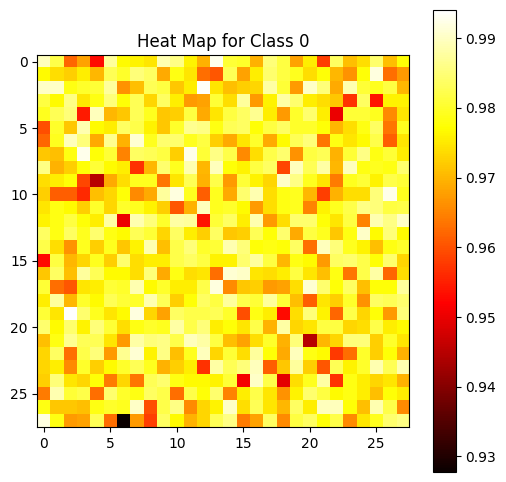

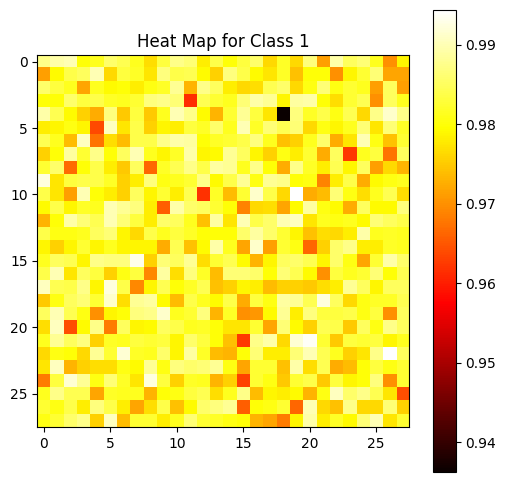

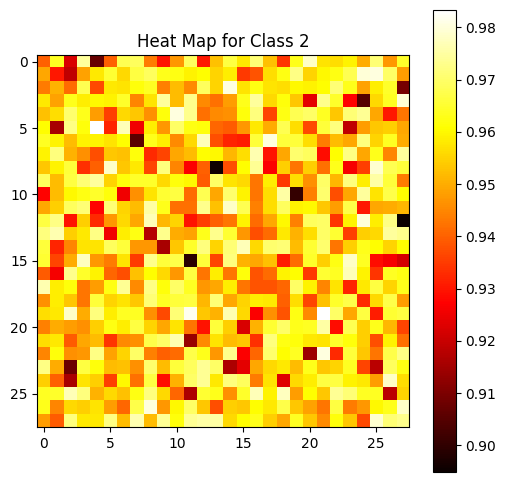

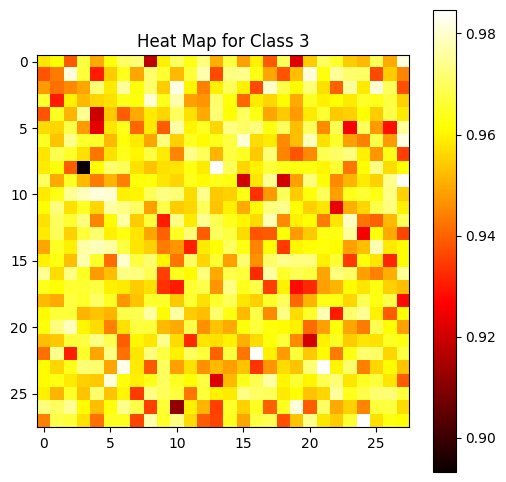

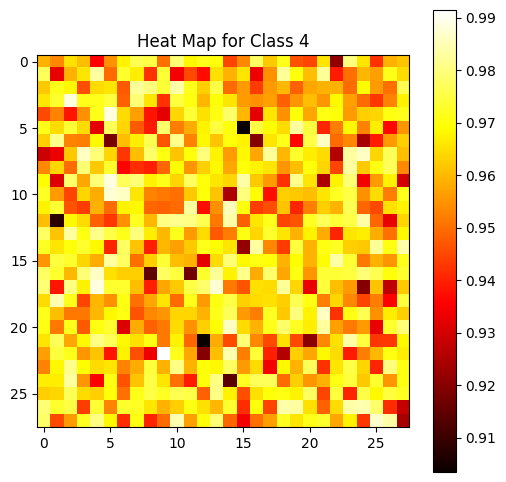

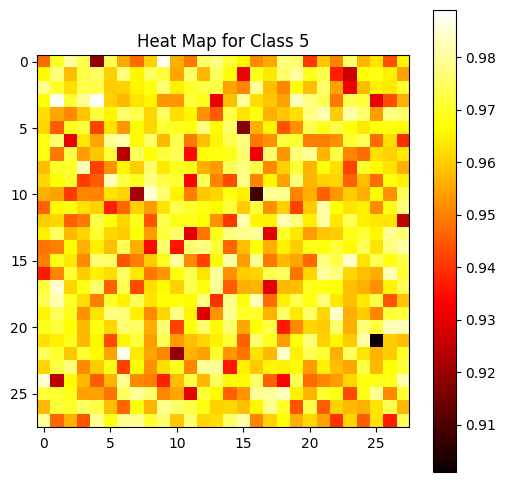

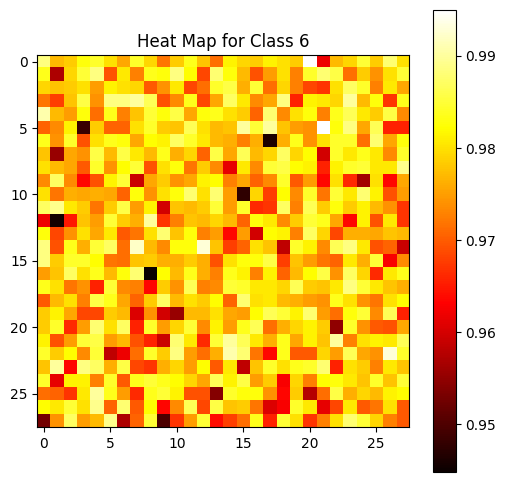

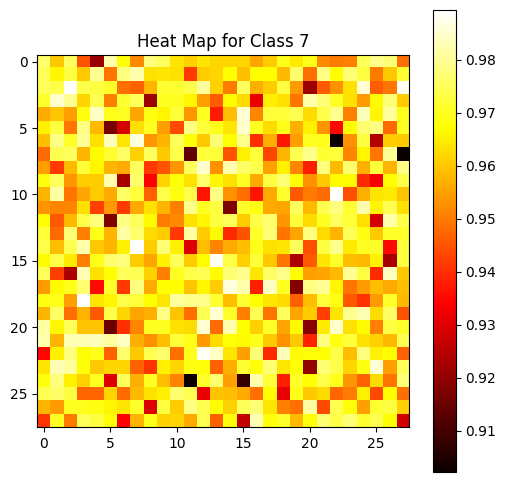

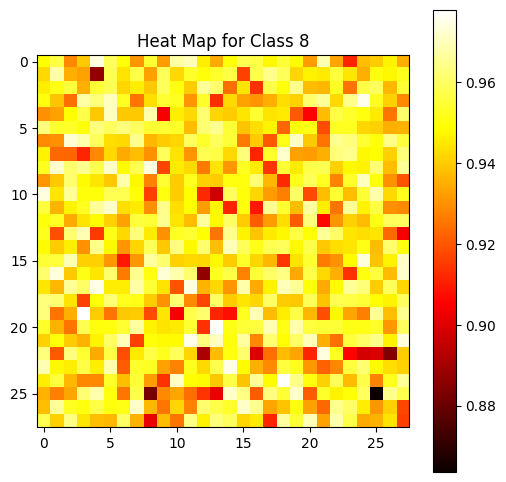

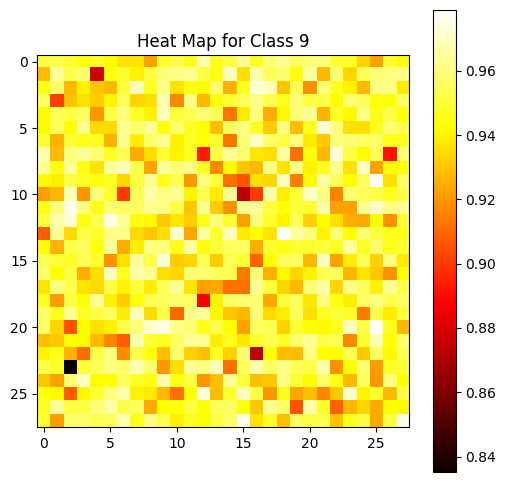

In [ ]:
create_heatmaps_per_class(pixel_importance_per_class)

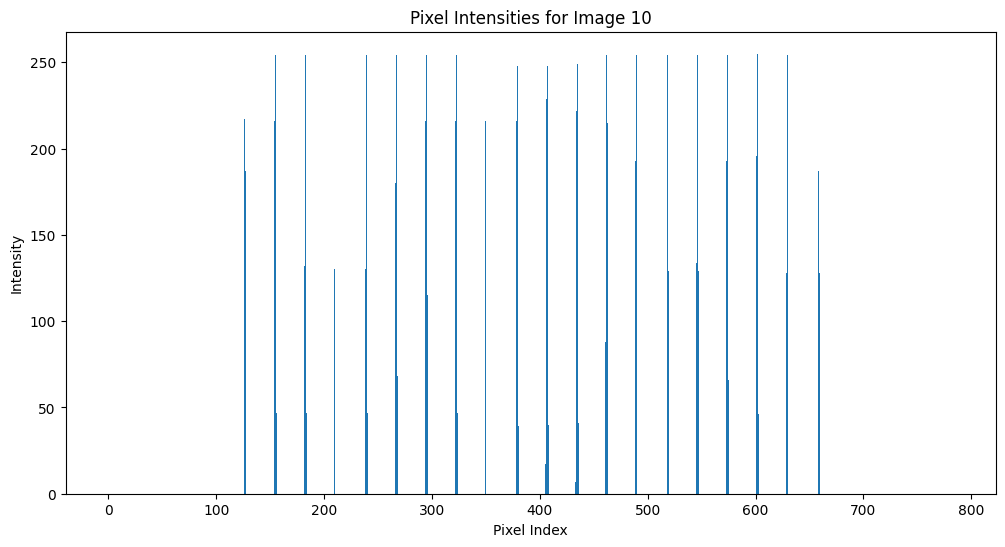

In [ ]:
plot_image_pixel_intensities(X_train, image_index=10)

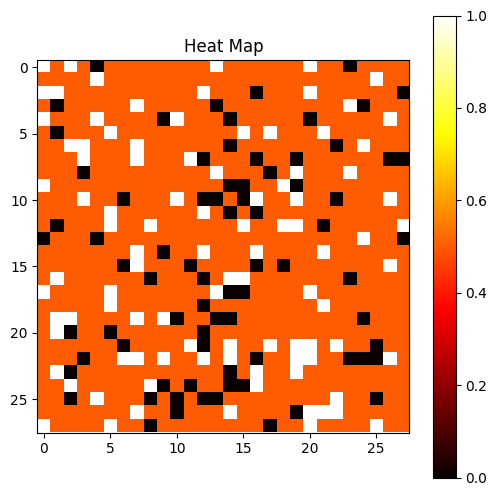

In [ ]:
highlight_important_pixels(copy_pixel_importance_per_class)

In [42]:
overlay_important_pixels_on_class_image(X_train, y_train, copy_pixel_importance_per_class, class_label=1, example_index=9)

ValueError: The specified example index does not match the specified class label.

### SMARTPATCH_vlamda selecting top pixels per class for training

In [ ]:
run_cnn_with_important_pixels_by_class(copy_pixel_importance_per_class, 350)

Epoch 1/5
44/44 [==============================] - 5s 97ms/step - loss: 4.3613 - accuracy: 0.7270
Epoch 2/5
44/44 [==============================] - 4s 95ms/step - loss: 0.0601 - accuracy: 0.9836
Epoch 3/5
44/44 [==============================] - 4s 98ms/step - loss: 0.0156 - accuracy: 0.9957
Epoch 4/5
44/44 [==============================] - 4s 98ms/step - loss: 0.0043 - accuracy: 0.9991
Epoch 5/5
438/438 [==============================] - 3s 8ms/step
Accuracy: 0.48857142857142855
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.61      0.65      1343
           1       0.86      0.61      0.71      1600
           2       0.39      0.73      0.51      1380
           3       0.33      0.24      0.28      1433
           4       0.56      0.53      0.54      1295
           5       0.41      0.63      0.49      1273
           6       0.64      0.81      0.71      1396
           7       0.34      0.70      0.46      1503
  

In [ ]:
run_cnn_with_important_pixels_by_class(copy_pixel_importance_per_class, 200)

Epoch 1/5
44/44 [==============================] - 5s 98ms/step - loss: 5.1303 - accuracy: 0.5823
Epoch 2/5
44/44 [==============================] - 4s 98ms/step - loss: 0.4238 - accuracy: 0.8863
Epoch 3/5
44/44 [==============================] - 4s 100ms/step - loss: 0.2264 - accuracy: 0.9343
Epoch 4/5
44/44 [==============================] - 4s 100ms/step - loss: 0.1469 - accuracy: 0.9554
Epoch 5/5
438/438 [==============================] - 3s 7ms/step
Accuracy: 0.9420714285714286
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      1343
           1       0.95      0.98      0.97      1600
           2       0.96      0.90      0.93      1380
           3       0.92      0.94      0.93      1433
           4       0.88      0.97      0.93      1295
           5       0.95      0.92      0.94      1273
           6       0.98      0.94      0.96      1396
           7       0.95      0.94      0.95      1503
 

# Section 3:

#### Experiments week 2nd July

In [ ]:
1. Taking 200 pixels completely at random in the image, - Presumably you’ll have a accuracy that’s not too bad, the rest white,
2. Sample randomly and put the remaining pixels to intensity 255 —> both experiments should lead to the same results
--> If its not the case you’re biasing things,
Signal to noise ratio,
3. For the pixels which are not important randomly sample pure noise,
4. Train on the subset of important pixels —> only train with important pixels and not with zeros with both methods
out of all pixels how many pixels do we keep? and we want to show that the accuracy  is like the plot he showing
What is the optimal level of pixels where you see that drop
5. remove one pixel and train, remove 2 and train and on and on and see how accuracy decreases, can we do this both from top to bottom, left to right and out to in?
6. Plot Percentage of pixels that compose the one?
For each of the classes with the intensity which is above 30, (how many and what pixels is it? does it go down as we increase the threshold?)
When you’re thresholding at 50% // Can you actually plot an image and then circle the top 50% important pixels (for each class?)
As a human I maybe only need 10-50
The top 50% of important pixels is 50% of the image
8. Train with average pooling
9. Train with standard neural network could show a more reasonable heatmap

 ##### Experiment 1 & 2 from above + how does this change with alpha visualized

In [34]:
results = {}
X_train, X_test, y_train, y_test, X_train_subset, y_train_subset = prepare_data(X, y, subset_fraction=0.1)

alpha = 0.9

num_pixels = int(round(28 * 28 * (alpha)))  # Assuming 28x28 images

#print(num_pixels)
def random_run(full_on = True, num_pixels = 2):
    start = time.time()
    # Create a modified training set with only top k pixels turned on for each class
    X_train_modified = X_train_subset.copy()

    for i in range(len(X_train_modified)):

        flat_image = X_train_modified.iloc[i].values
        selected_pixels = np.random.choice(len(flat_image), num_pixels, replace=False) #get a list of random pixels
        if full_on == True:
            marked_image = np.full_like(flat_image, 255)  # Fill all pixels with 255
        else:
            marked_image = np.zeros_like(flat_image)  # Turn off all pixels

        marked_image[selected_pixels] = flat_image[selected_pixels]  # Retain original values for selected pixels
        X_train_modified.iloc[i] = marked_image

    # Reshape the modified images for the model
    X_train_modified_array = np.array(X_train_modified).reshape(-1, 28, 28, 1)

    # Train and evaluate the model using the provided model builder function
    results = train_and_evaluate_model(X_train_modified_array, y_train_subset, X_test, y_test, simple_cnn)

    end = time.time()
    elapsed_time = end - start
    print(elapsed_time)

    return results

In [35]:
random_run(full_on=True)

0.981452226638794
Epoch 1/5
44/44 [==============================] - 7s 130ms/step - loss: 9.5426 - accuracy: 0.0991
Epoch 2/5
44/44 [==============================] - 4s 91ms/step - loss: 2.3353 - accuracy: 0.1009
Epoch 3/5
44/44 [==============================] - 4s 86ms/step - loss: 2.3038 - accuracy: 0.1045
Epoch 4/5
44/44 [==============================] - 4s 100ms/step - loss: 2.3017 - accuracy: 0.1107
Epoch 5/5
438/438 [==============================] - 4s 9ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1343
           1       0.14      0.93      0.24      1600
           2       0.00      0.00      0.00      1380
           3       0.16      0.17      0.17      1433
           4       0.00      0.00      0.00      1295
           5       0.00      0.00      0.00      1273
           6       0.13      0.07      0.09      1396
           7       0.00      0.00      0.00      1503
           8       0.06      0.02   

{'model_score': [7.404040813446045, 0.13292856514453888],
 'accuracy': 0.13292857142857142,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00      1343\n           1       0.14      0.93      0.24      1600\n           2       0.00      0.00      0.00      1380\n           3       0.16      0.17      0.17      1433\n           4       0.00      0.00      0.00      1295\n           5       0.00      0.00      0.00      1273\n           6       0.13      0.07      0.09      1396\n           7       0.00      0.00      0.00      1503\n           8       0.06      0.02      0.03      1357\n           9       0.01      0.00      0.00      1420\n\n    accuracy                           0.13     14000\n   macro avg       0.05      0.12      0.05     14000\nweighted avg       0.05      0.13      0.06     14000\n'}

In [37]:
random_run(full_on=False)

0.9300858974456787
Epoch 1/5
44/44 [==============================] - 5s 83ms/step - loss: 2.4957 - accuracy: 0.1255
Epoch 2/5
44/44 [==============================] - 4s 84ms/step - loss: 2.2524 - accuracy: 0.1511
Epoch 3/5
44/44 [==============================] - 6s 129ms/step - loss: 2.2301 - accuracy: 0.1643
Epoch 4/5
44/44 [==============================] - 4s 100ms/step - loss: 2.2026 - accuracy: 0.1711
Epoch 5/5
438/438 [==============================] - 5s 11ms/step
              precision    recall  f1-score   support

           0       0.22      0.36      0.27      1343
           1       0.38      0.13      0.20      1600
           2       0.10      0.07      0.09      1380
           3       0.11      0.01      0.02      1433
           4       0.10      0.06      0.08      1295
           5       0.13      0.08      0.10      1273
           6       0.25      0.02      0.03      1396
           7       0.09      0.43      0.14      1503
           8       0.05      0.02 

{'model_score': [2.9771816730499268, 0.12214285880327225],
 'accuracy': 0.12214285714285714,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.22      0.36      0.27      1343\n           1       0.38      0.13      0.20      1600\n           2       0.10      0.07      0.09      1380\n           3       0.11      0.01      0.02      1433\n           4       0.10      0.06      0.08      1295\n           5       0.13      0.08      0.10      1273\n           6       0.25      0.02      0.03      1396\n           7       0.09      0.43      0.14      1503\n           8       0.05      0.02      0.03      1357\n           9       0.00      0.00      0.00      1420\n\n    accuracy                           0.12     14000\n   macro avg       0.14      0.12      0.10     14000\nweighted avg       0.14      0.12      0.10     14000\n'}

0.6629636287689209
Epoch 1/5
44/44 [==============================] - 5s 97ms/step - loss: 9.4205 - accuracy: 0.1109
Epoch 2/5
44/44 [==============================] - 4s 96ms/step - loss: 2.3014 - accuracy: 0.1196
Epoch 3/5
44/44 [==============================] - 4s 97ms/step - loss: 2.2594 - accuracy: 0.1527
Epoch 4/5
44/44 [==============================] - 4s 96ms/step - loss: 2.2047 - accuracy: 0.1943
Epoch 5/5
438/438 [==============================] - 3s 8ms/step
              precision    recall  f1-score   support

           0       0.02      0.04      0.03      1343
           1       0.01      0.02      0.01      1600
           2       0.11      0.01      0.01      1380
           3       0.06      0.18      0.09      1433
           4       0.02      0.00      0.00      1295
           5       0.17      0.30      0.21      1273
           6       0.00      0.00      0.00      1396
           7       0.14      0.03      0.05      1503
           8       0.04      0.01    

TypeError: unhashable type: 'dict'

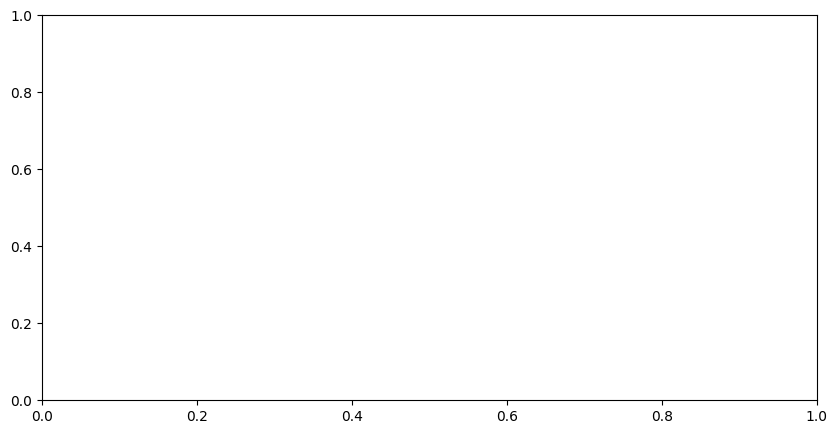

In [ ]:
alpha_values = np.linspace(0.1, 1.0, 10)  # 10 values from 0.1 to 1.0

# Prepare the data
X_train, X_test, y_train, y_test, X_train_subset, y_train_subset = prepare_data(X, y, subset_fraction=0.1)

# Initialize a dictionary to store the results
results = {}

for alpha in alpha_values:
    start = time.time()
    num_pixels = int(round(28 * 28 * alpha))  # Calculate the number of pixels based on alpha

    # Run the random_run function and store the result
    result = random_run(num_pixels = num_pixels, full_on=True)
    end = time.time()

    # Record the elapsed time and the result
    elapsed_time = end - start
    results[alpha] = {'time': elapsed_time, 'accuracy': result}


In [ ]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot([alpha for alpha in results], [results[alpha]['accuracy'] for alpha in results], marker='o')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy as a function of alpha')
plt.grid(True)
plt.show()

NameError: name 'plt' is not defined

#### Experiments Week July 8th

In [ ]:
# Calculate the proportions for the training images
proportions = calculate_pixel_proportions(train_images)
plot_pixel_proportions(proportions)


Proportion of black and white pixels in every image adn look at the distirbutions,
suspsition is 30% black pixels and the rest is background
Try without any data: Change 200 into 20 and 2
compare to most important pixels
archive experiments


# Section 4
### Distance calculation:

We can do this by calculating the distance (e.g., Euclidean distance or Manhattan distance) between the vectors representing the values for each class across all pixels.

In [ ]:
def compute_class_distances(data_dict):
    classes = list(range(10))
    distances = np.zeros((10, 10))

    for class1, class2 in itertools.combinations(classes, 2):
        distance = 0
        for pixel in data_dict:
            value1 = data_dict[pixel].get(class1, 0)
            value2 = data_dict[pixel].get(class2, 0)
            distance += abs(value1 - value2)  # Manhattan distance; use (value1 - value2)**2 for Euclidean
        distances[class1, class2] = distance
        distances[class2, class1] = distance  # Symmetric matrix

    return distances

distances = compute_class_distances(copy_pixel_importance_per_class)

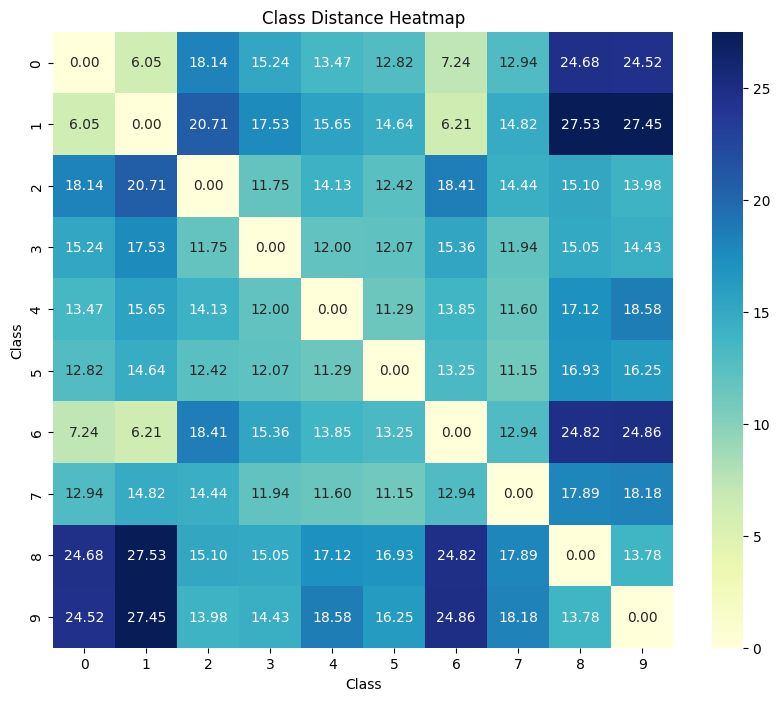

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(distances, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=range(10), yticklabels=range(10))
plt.title("Class Distance Heatmap")
plt.xlabel("Class")
plt.ylabel("Class")
plt.show()

## Additional Visualizations to see if matrix is correct

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        # Define ReLU activation function
        self.relu = nn.ReLU()

        # Encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc_mu = nn.Linear(128*7*7, latent_dim)
        self.fc_logvar = nn.Linear(128*7*7, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 128*7*7)
        self.conv_transpose1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_transpose2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_transpose3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1)

    def encode(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = x.view(x.shape[0], -1)  # Flatten the tensor
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.relu(self.fc_decode(z))
        z = z.view(-1, 128, 7, 7)  # Reshape the tensor
        z = self.relu(self.conv_transpose1(z))
        z = self.relu(self.conv_transpose2(z))
        z = torch.sigmoid(self.conv_transpose3(z))
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

latent_dim = 10
model = VAE(latent_dim).to(device)

In [ ]:
import altair as alt
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import pandas as pd
import altair as alt
alt.data_transformers.disable_max_rows()

def plot_tsne(tsne_xy, dataloader, num_points=1000):

    images, labels = zip(*[(x[0].numpy()[0,:,:,None], x[1]) for x in dataloader.dataset])

    num_points = min(num_points, len(labels))
    data = pd.DataFrame({'x':tsne_xy[:, 0], 'y':tsne_xy[:, 1], 'label':labels,
                        'image': images})
    data = data.sample(n=num_points, replace=False)

    alt.renderers.set_embed_options('light')
    selection = alt.selection_single(on='mouseover', clear='false', nearest=True,
                                    init={'x':data['x'][data.index[0]], 'y':data['y'][data.index[0]]})
    scatter = alt.Chart(data).mark_circle().encode(
        alt.X('x:N',axis=None),
        alt.Y('y:N',axis=None),
        color=alt.condition(selection,
                            alt.value('lightgray'),
                            alt.Color('label:N')),
        size=alt.value(100),
        tooltip='label:N'
    ).add_selection(
        selection
    ).properties(
        width=400,
        height=400
    )

    digit  = alt.Chart(data).transform_filter(
        selection
    ).transform_window(
        index='count()'           # number each of the images
    ).transform_flatten(
        ['image']                 # extract rows from each image
    ).transform_window(
        row='count()',            # number the rows...
        groupby=['index']         # ...within each image
    ).transform_flatten(
        ['image']                 # extract the values from each row
    ).transform_window(
        column='count()',         # number the columns...
        groupby=['index', 'row']  # ...within each row & image
    ).mark_rect(stroke='black',strokeWidth=0).encode(
        alt.X('column:O', axis=None),
        alt.Y('row:O', axis=None),
        alt.Color('image:Q',sort='descending',
            scale=alt.Scale(scheme=alt.SchemeParams('lightgreyteal',
                            extent=[1, 0]),

            ),
            legend=None
        ),
    ).properties(
        width=400,
        height=400,
    )

    return scatter | digit

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


# Load the data
batch_size = 100

data_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

def denormalize(x):
    return x

#######################################################################
#                       ** END OF YOUR CODE **
#######################################################################

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=data_transforms,
)

train_dataloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
)

# Download test data
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=data_transforms,
)

test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
)

# TSNE
from sklearn.manifold import TSNE

for t, (x, y) in enumerate(test_dataloader):
    if t == 0:
        data = x
        labels = y
    else:
        data = torch.cat((data, x))
        labels = torch.cat((labels, y))

# Then let's apply dimensionality reduction with the trained encoder

with torch.no_grad():
    data = data.to(device)
    mu, logvar = model.encode(data)
    z = (model.reparametrize(mu, logvar)).cpu().detach().numpy()

z_embedded = TSNE(n_components=2).fit_transform(z)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [ ]:
plot_tsne(z_embedded, test_dataloader, num_points=10000)

OutputSizeExceededError: The output cannot be displayed as it exceeds Deepnote's 30MB limit for outputs. The limit is in place to ensure smooth performance.

Please reduce the amount of data being sent to the output.

# Shallow Difference Learning

- an algorithm to get differences between all examples of each class and we want to plot a sort of graph of all the distances and frequencies of those distances, we are looking at mnist for example and the classes zero and six, so we subtract the images of all zeros and sixes using a distance metric like manhatten distance to get a value and then plot the distribution of those distances,
- distance between each example from a class and each example from another class and not between exampels within a class

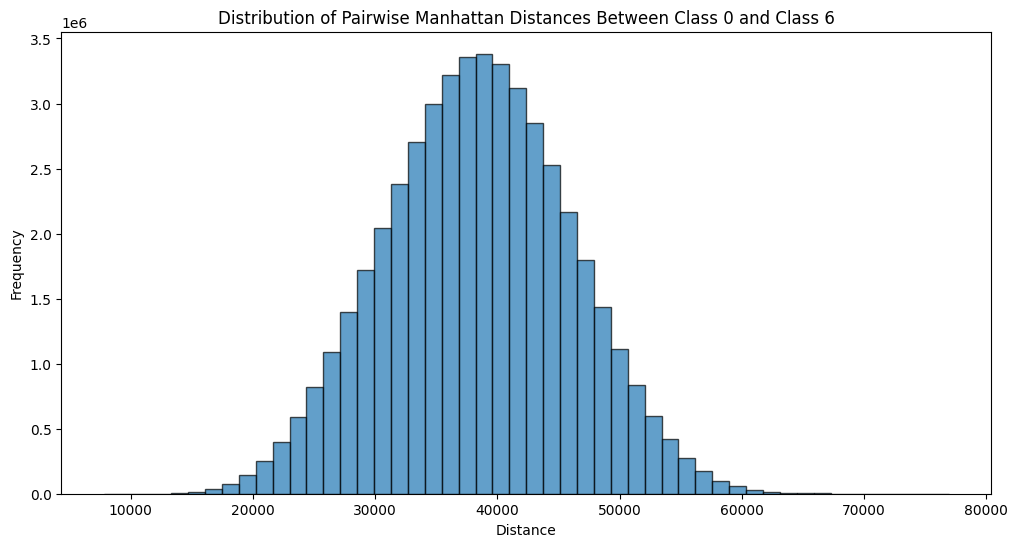

In [ ]:
# Load MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(int)

# Filter to only include classes 0 and 6
X0 = X[y == 0]
X1 = X[y == 1]
X2 = X[y == 2]
X3 = X[y == 3]
X4 = X[y == 4]
X5 = X[y == 5]
X6 = X[y == 6]
X7 = X[y == 7]
X8 = X[y == 8]
X9 = X[y == 9]

# Compute pairwise Manhattan distances between classes 0 and 6
distances = cdist(X0, X6, metric='cityblock')

# Flatten the distances array and compute histogram
distances = distances.flatten()
hist, bins = np.histogram(distances, bins=50)

# Plot histogram
plt.figure(figsize=(12, 6))
plt.bar(bins[:-1], hist, width=np.diff(bins), edgecolor="black", alpha=0.7)
plt.title('Distribution of Pairwise Manhattan Distances Between Class 0 and Class 6')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

so now we come in with a new example and we want to see its distance to all sixes and all zeros and based on this classify it to be either one

In [ ]:
# Take the first example from the MNIST dataset
example = X[0]
# Assume new_example is a 1D numpy array representing the new example
new_example = np.random.rand(784)  # Replace this with the actual new example

# Compute distances to all examples of class 0 and class 6
distances_to_0 = cdist([new_example], X0, metric='cityblock')
distances_to_6 = cdist([new_example], X6, metric='cityblock')

# Compute average distances
avg_distance_to_0 = np.mean(distances_to_0)
avg_distance_to_6 = np.mean(distances_to_6)

# Classify the new example as the class that has the smallest average distance
if avg_distance_to_0 < avg_distance_to_6:
    print("The new example is classified as class 0.")
else:
    print("The new example is classified as class 6.")

The new example is classified as class 6.


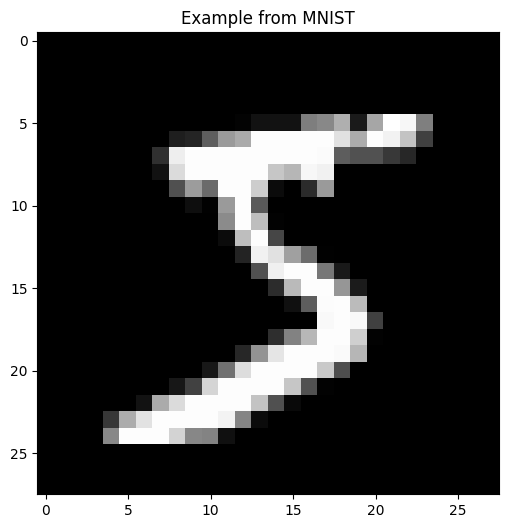

In [ ]:
# Take the first example from the MNIST dataset
example = X[0]
# If you want to visualize this example, you can reshape it to a 28x28 array and plot it
example_image = example.reshape(28, 28)

plt.figure(figsize=(6, 6))
plt.imshow(example_image, cmap='gray')
plt.title('Example from MNIST')
plt.show()

In [ ]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(int)

# Take a random 10% sample of the data
indices = np.random.choice(X.shape[0], size=int(X.shape[0]*0.1), replace=False)
X_sample = X[indices]
y_sample = y[indices]

# Split the sample into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.5, random_state=42)


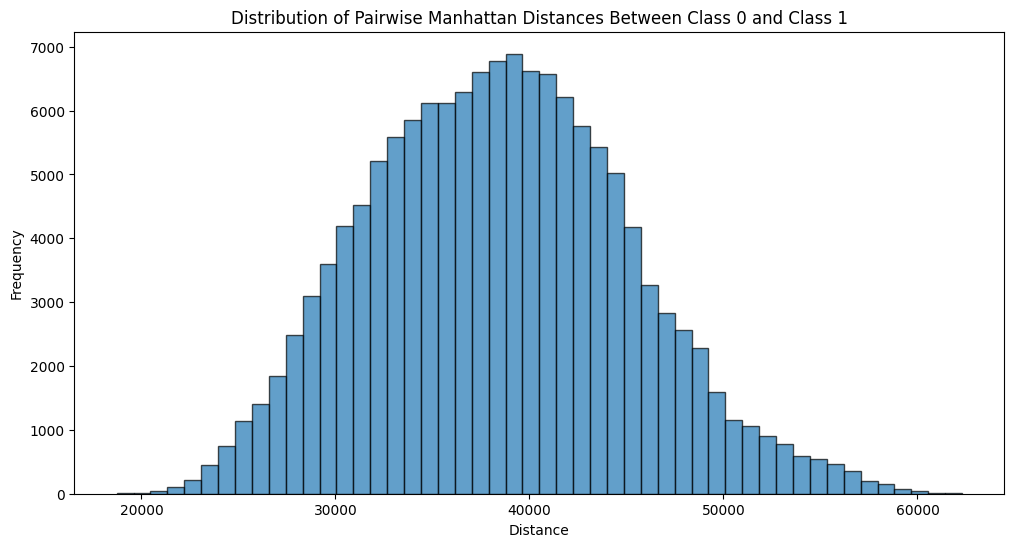

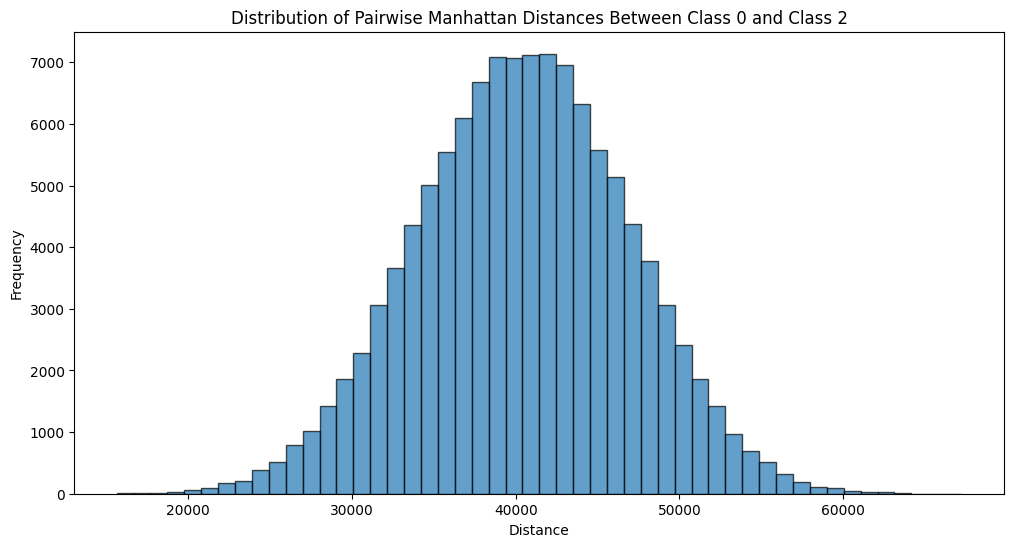

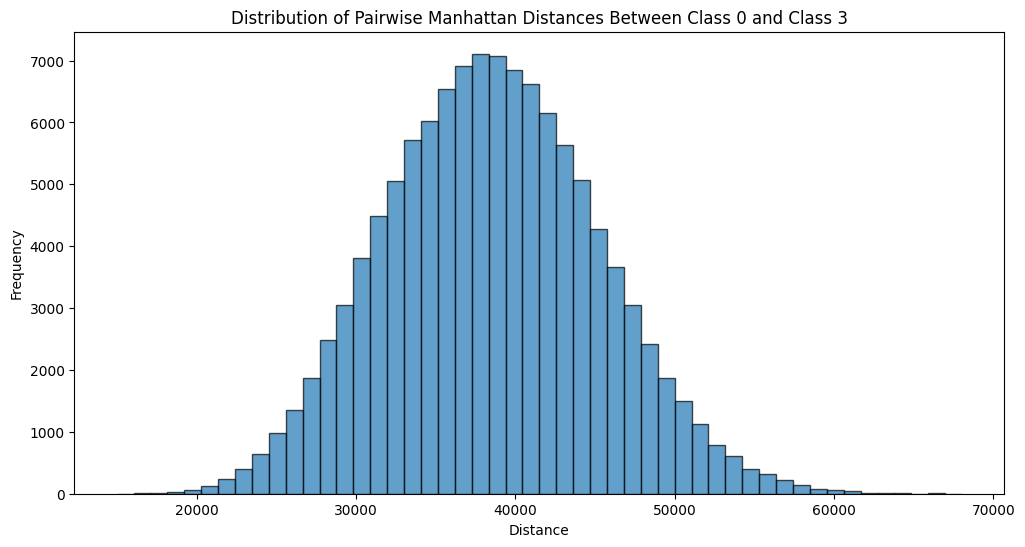

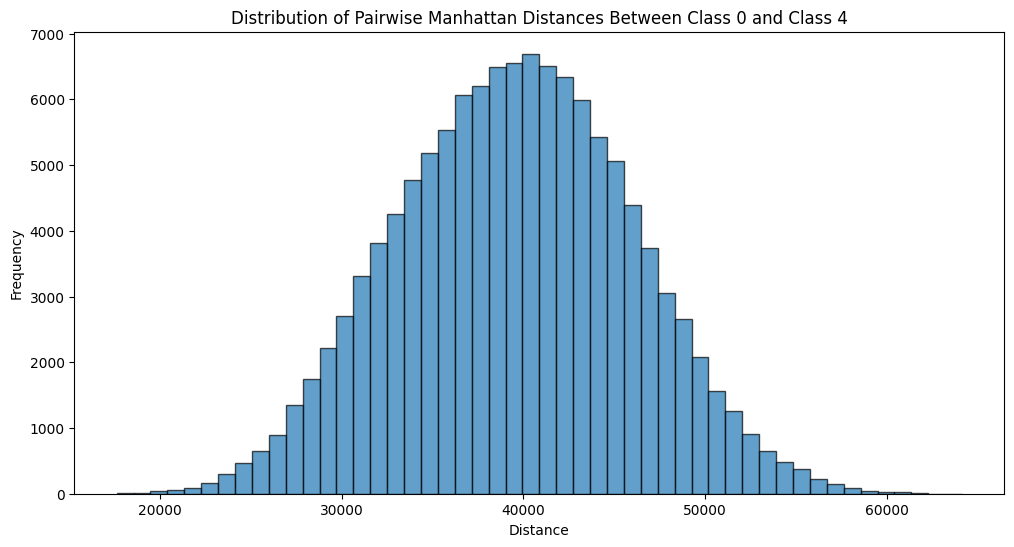

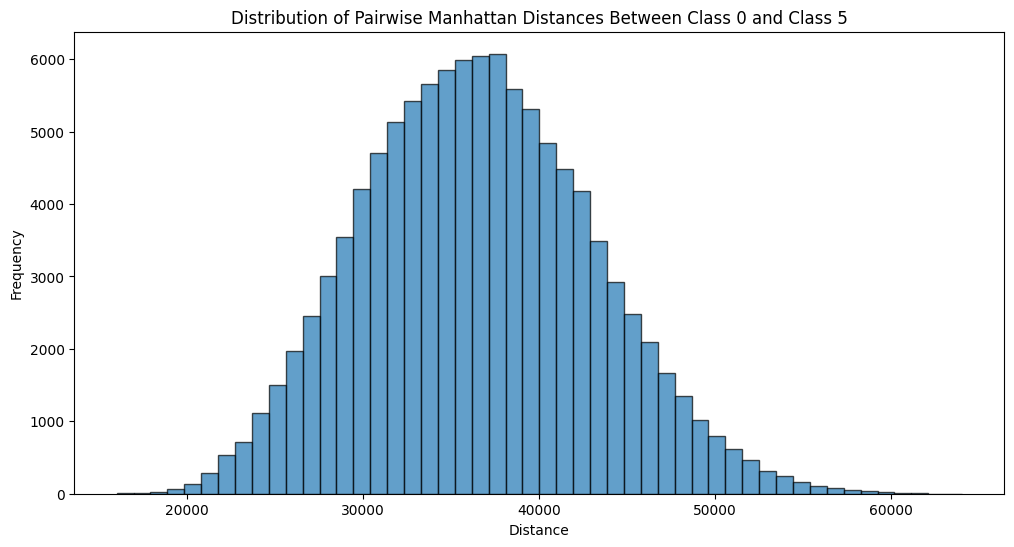

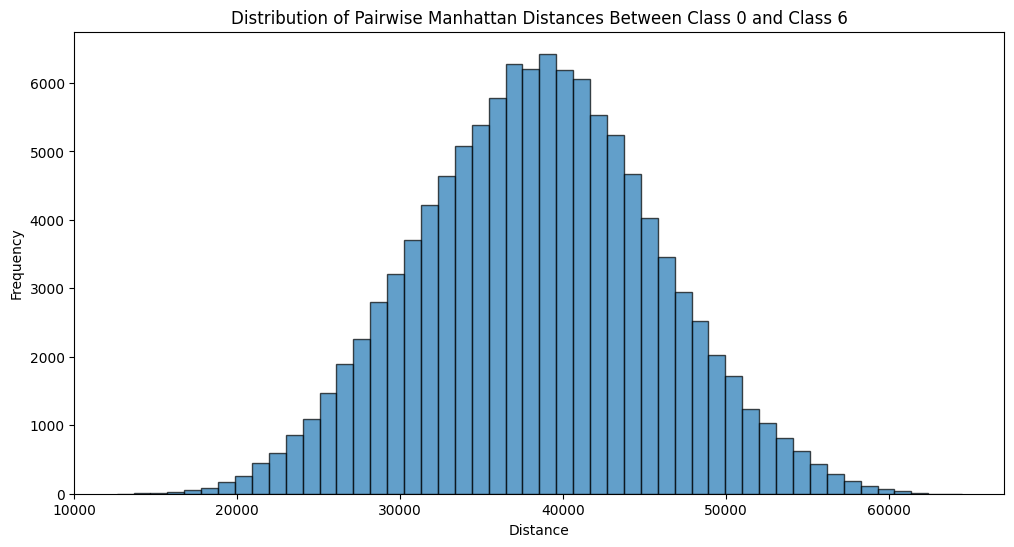

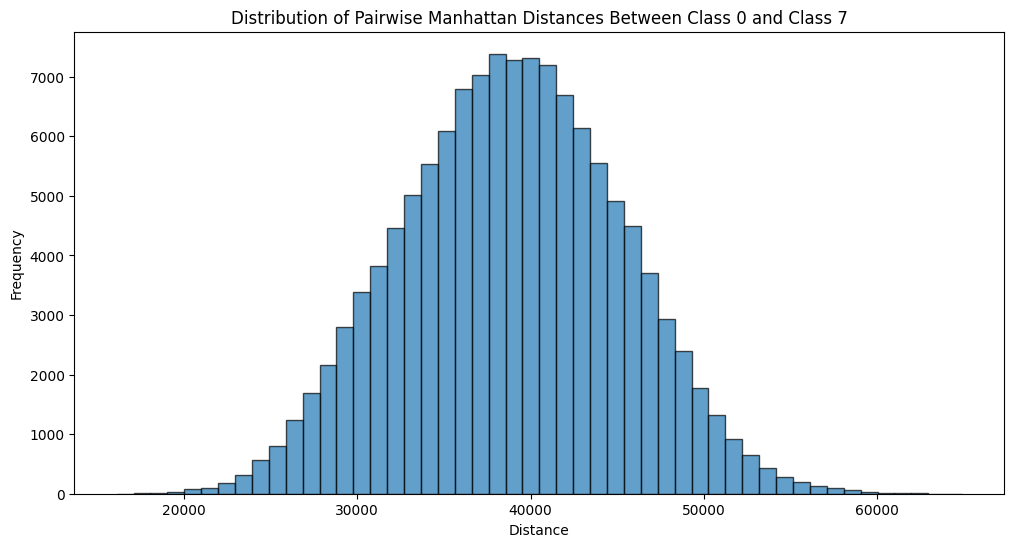

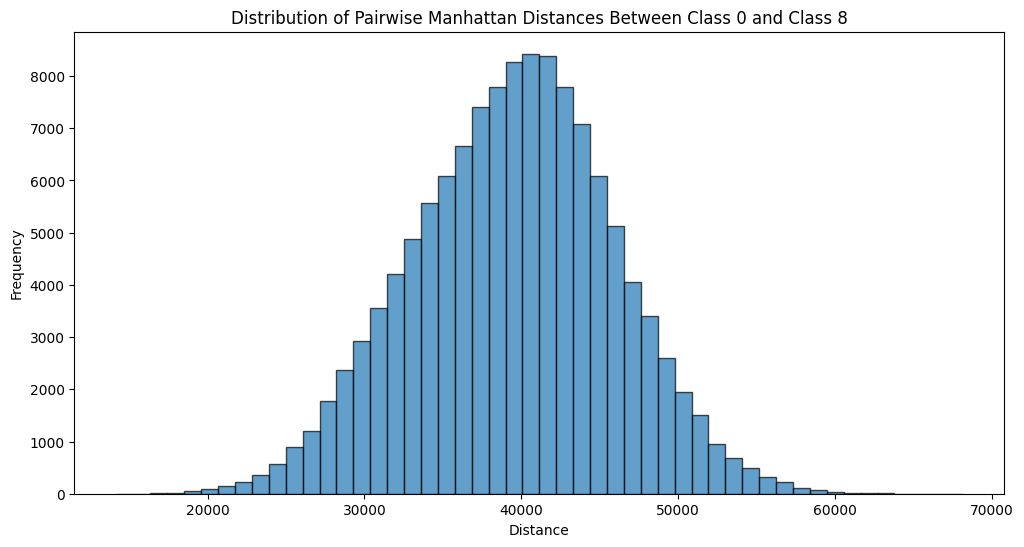

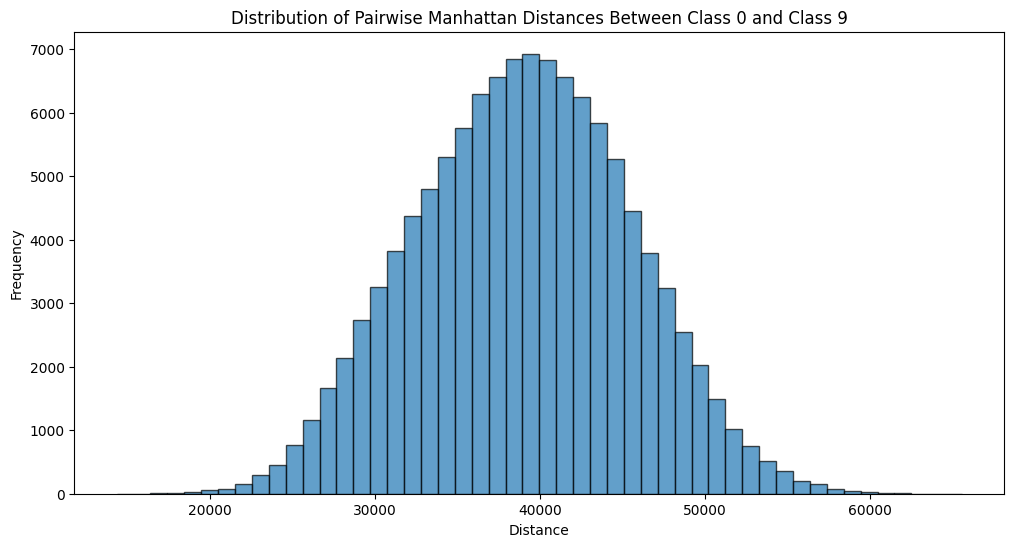

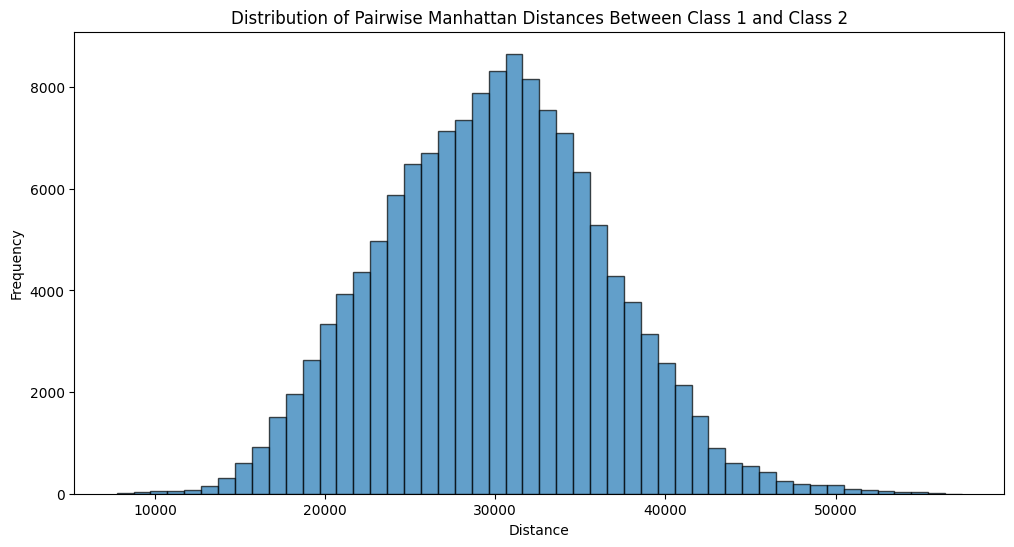

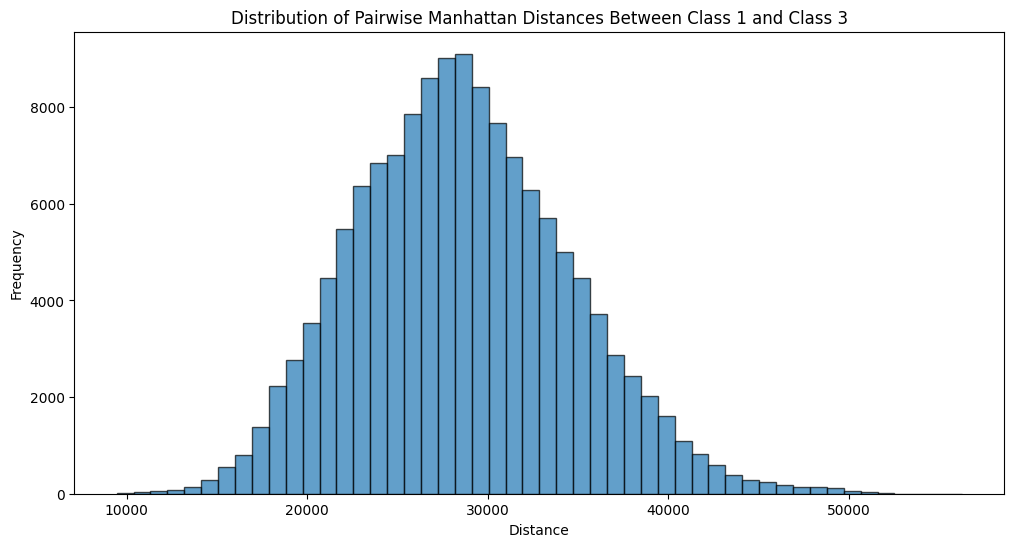

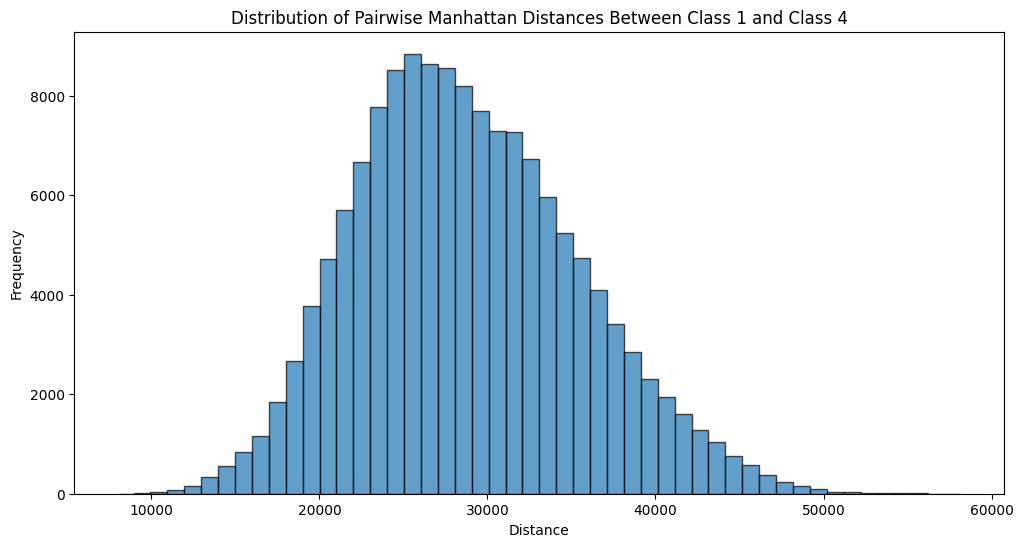

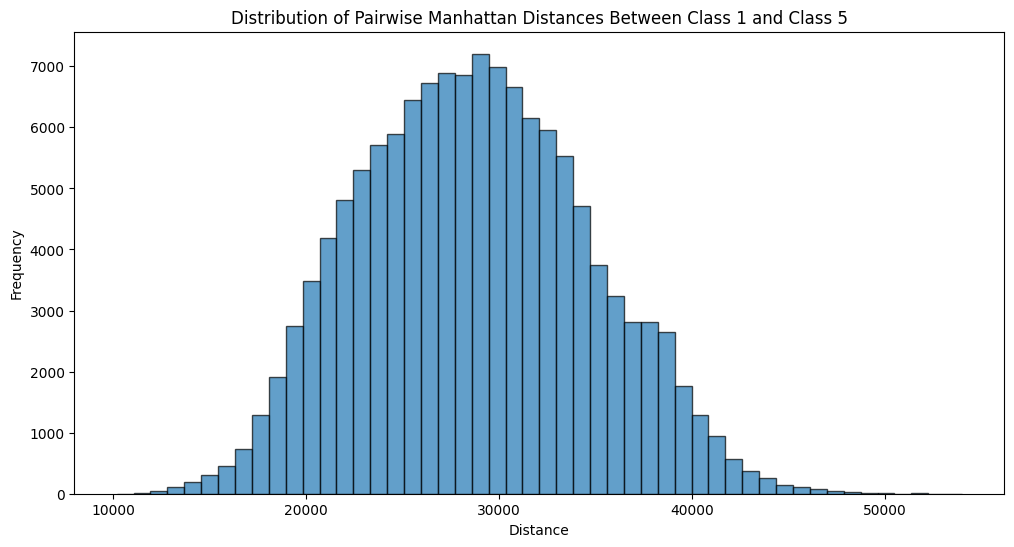

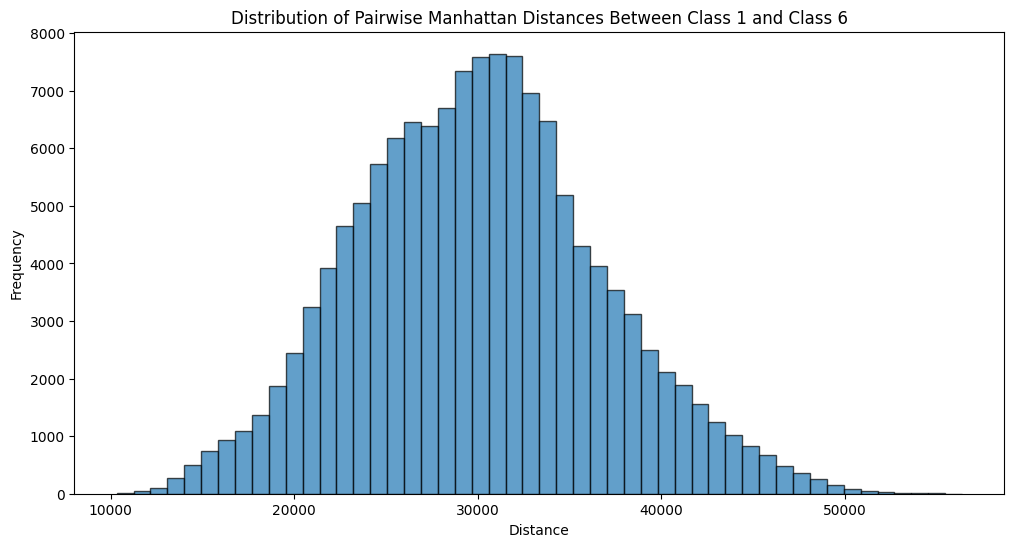

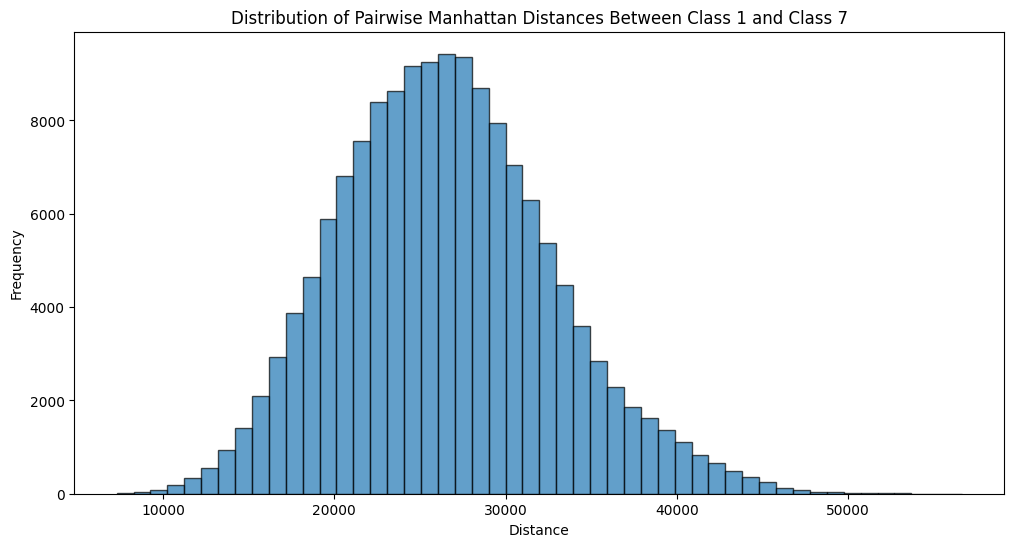

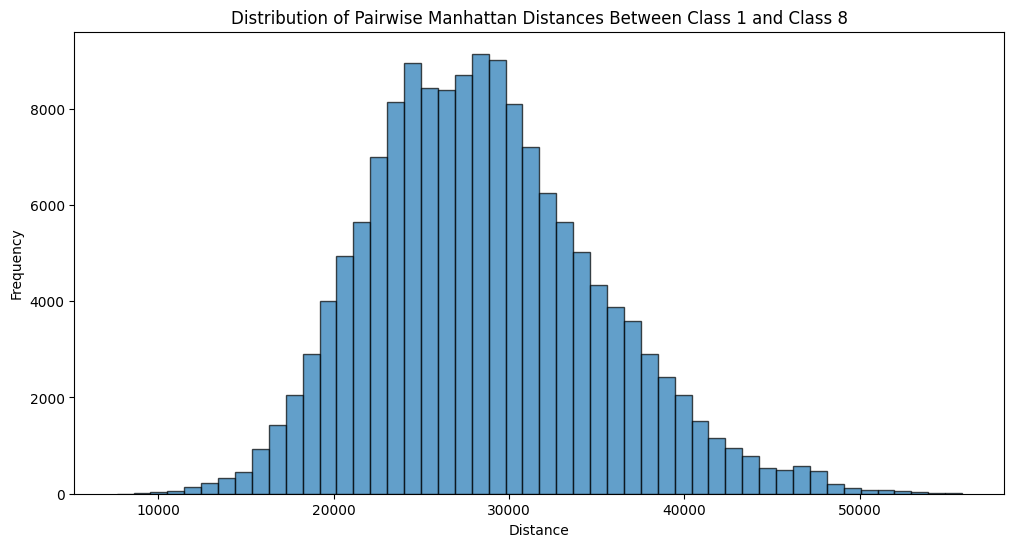

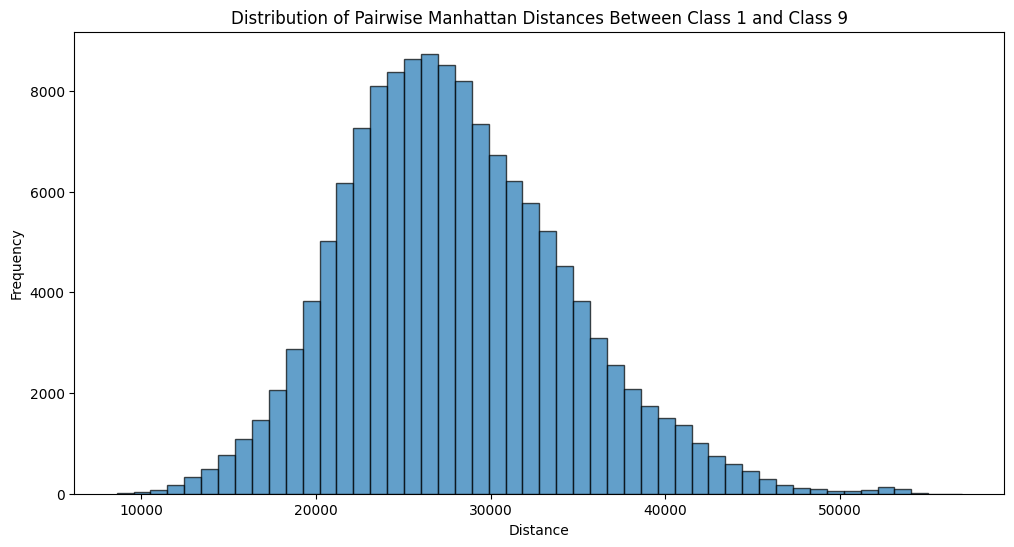

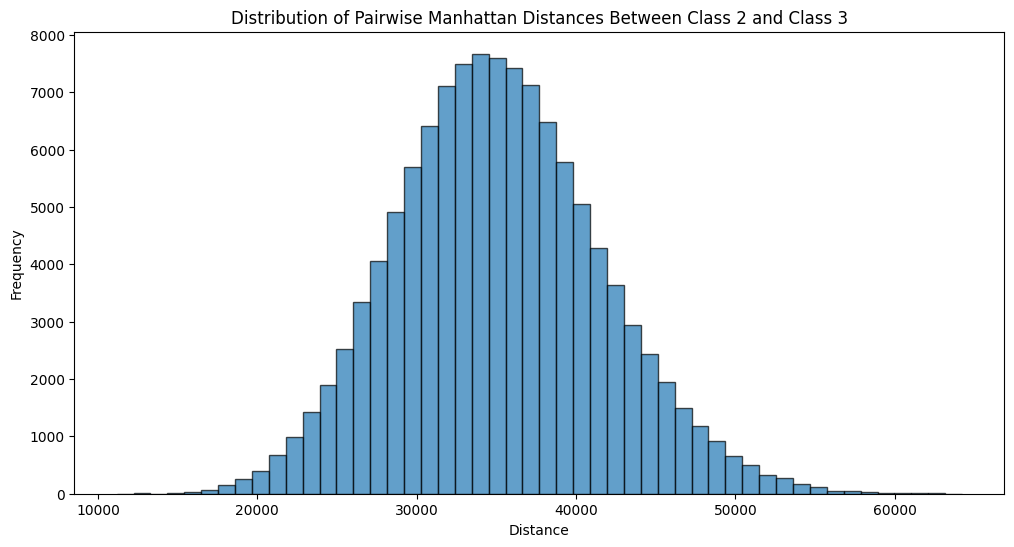

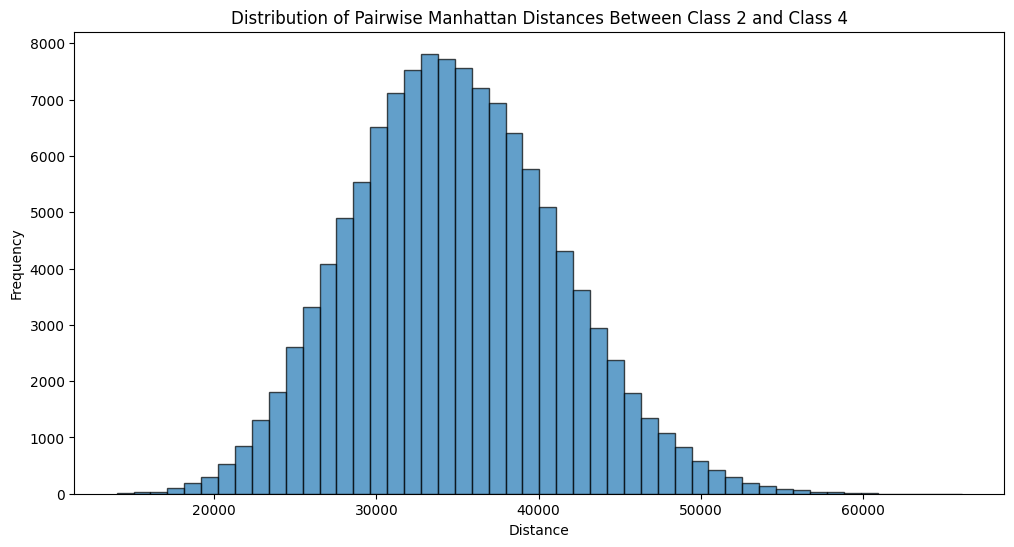

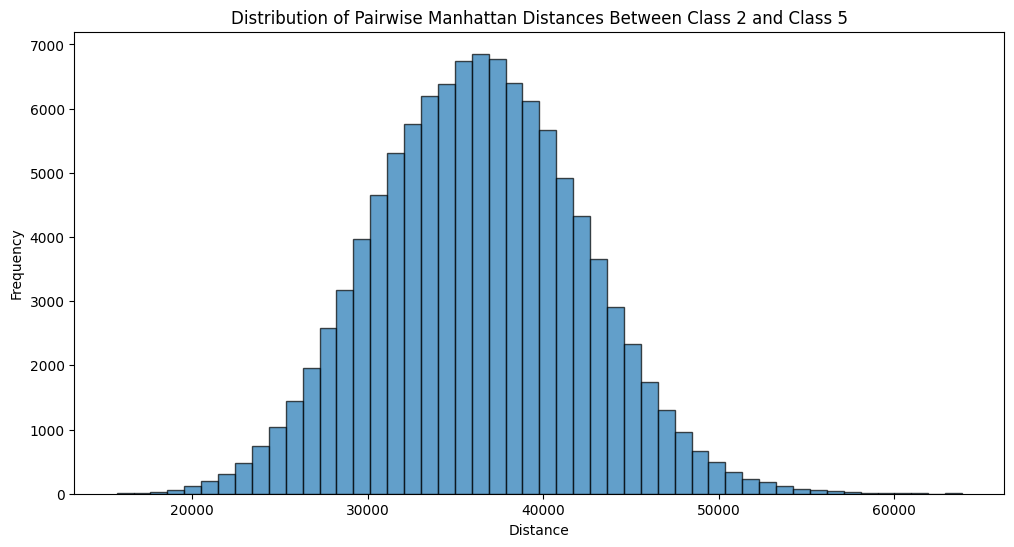

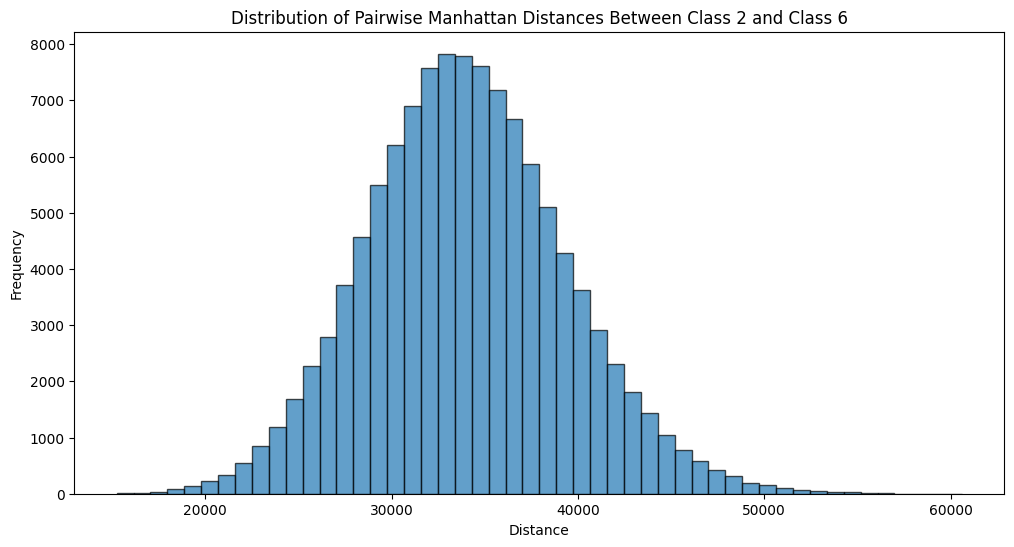

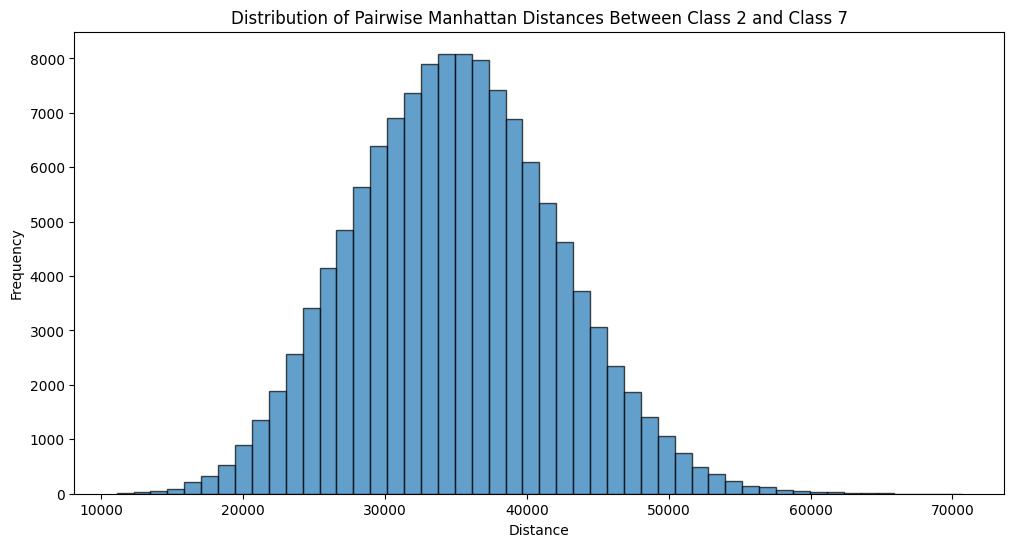

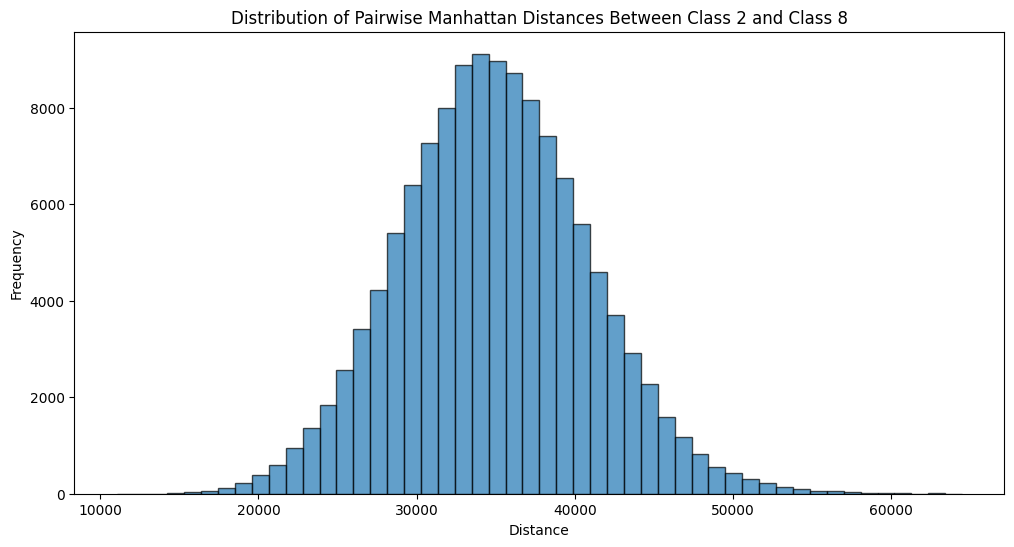

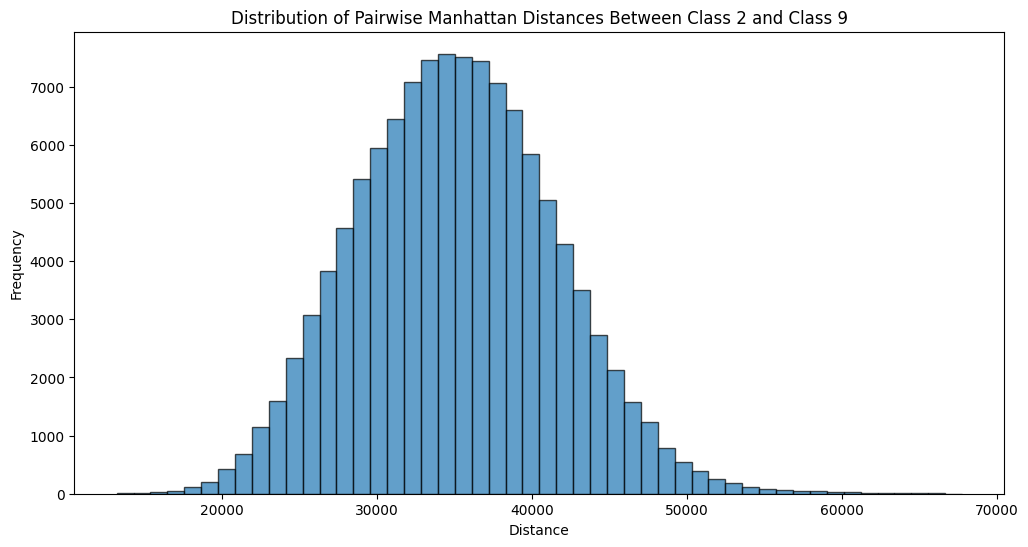

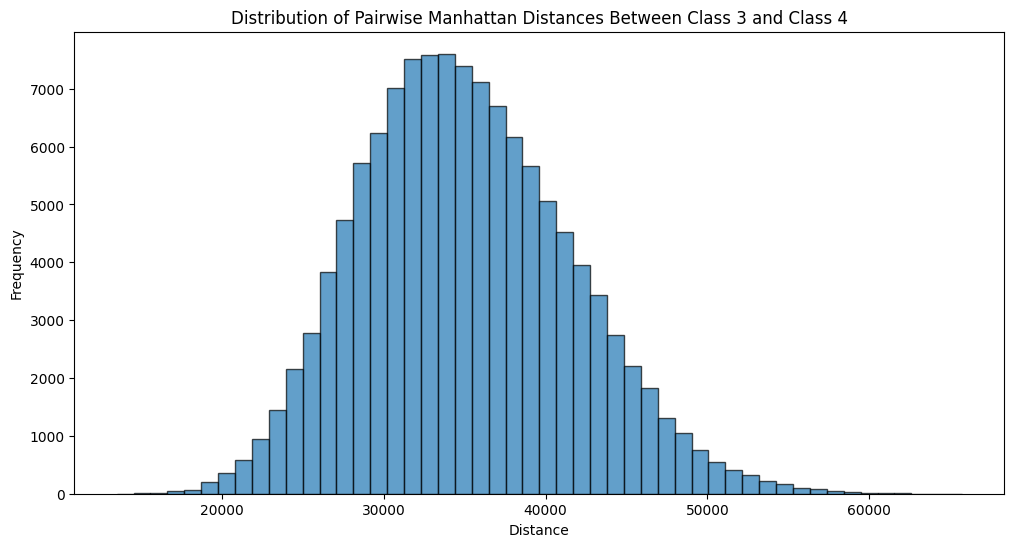

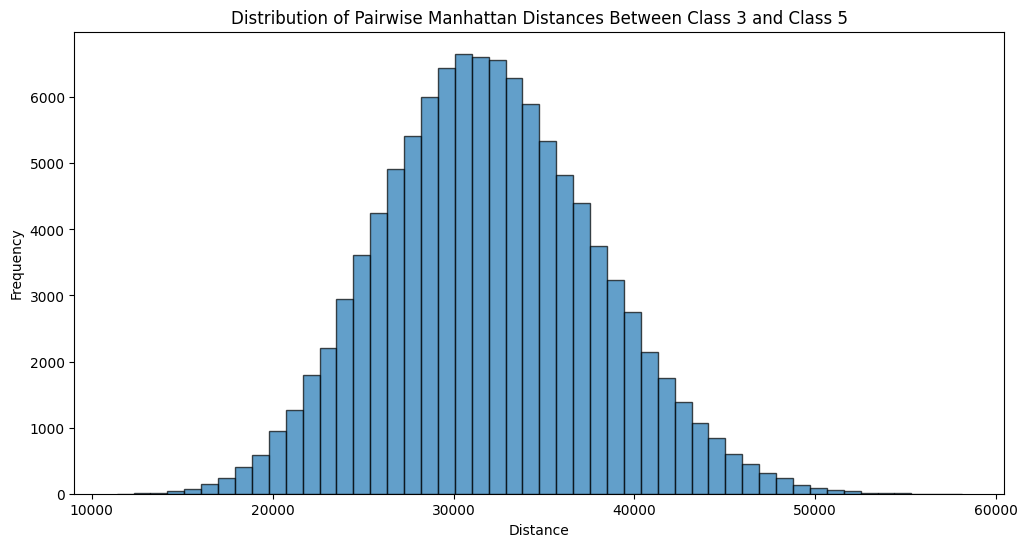

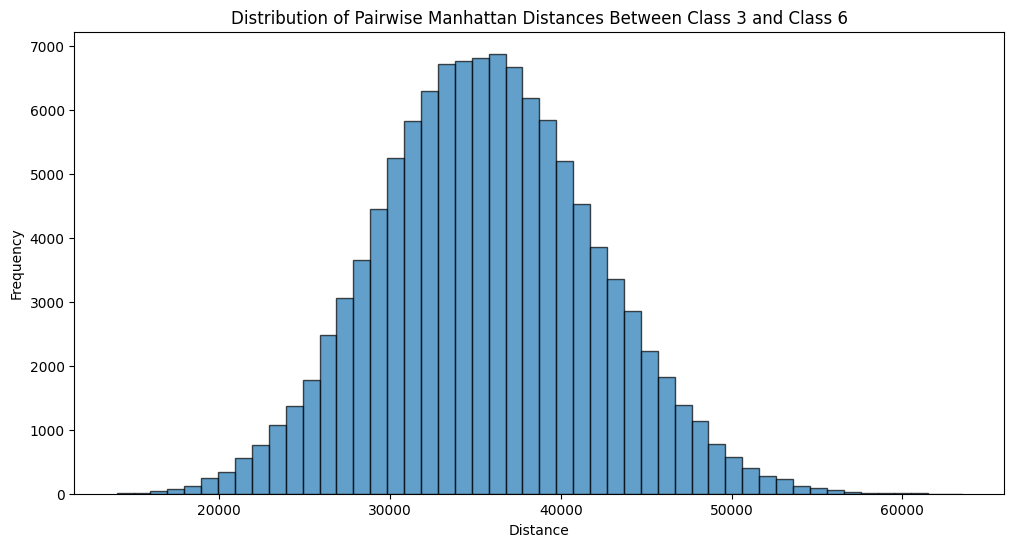

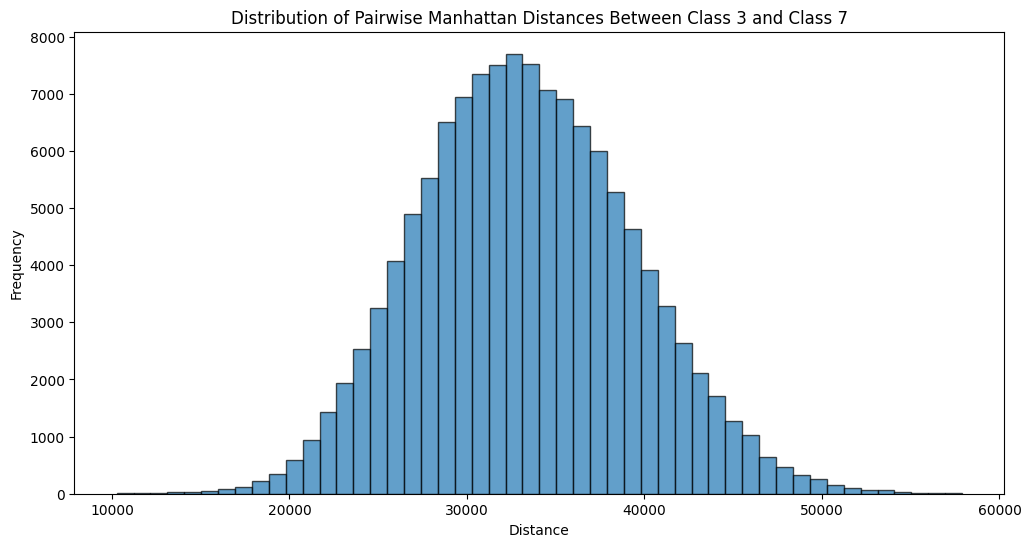

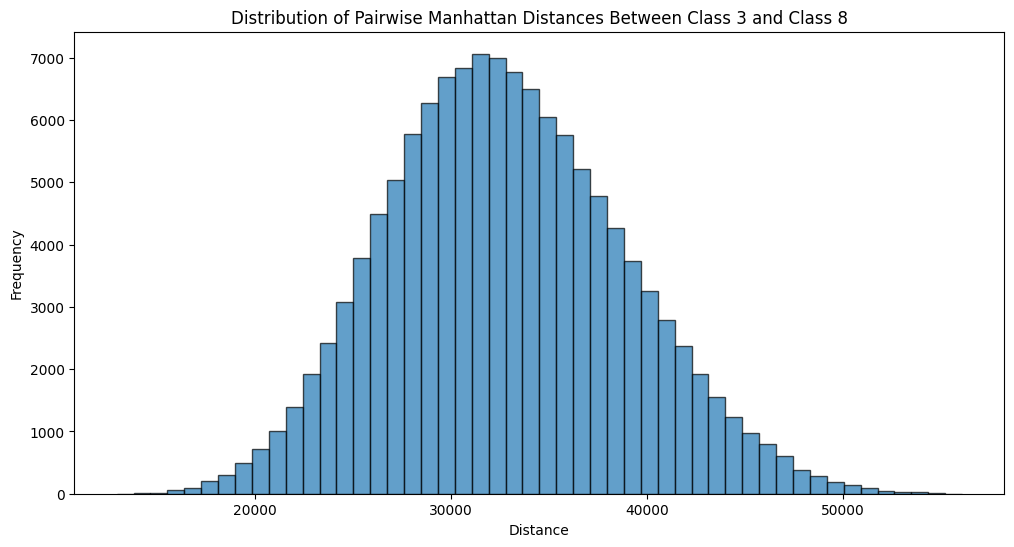

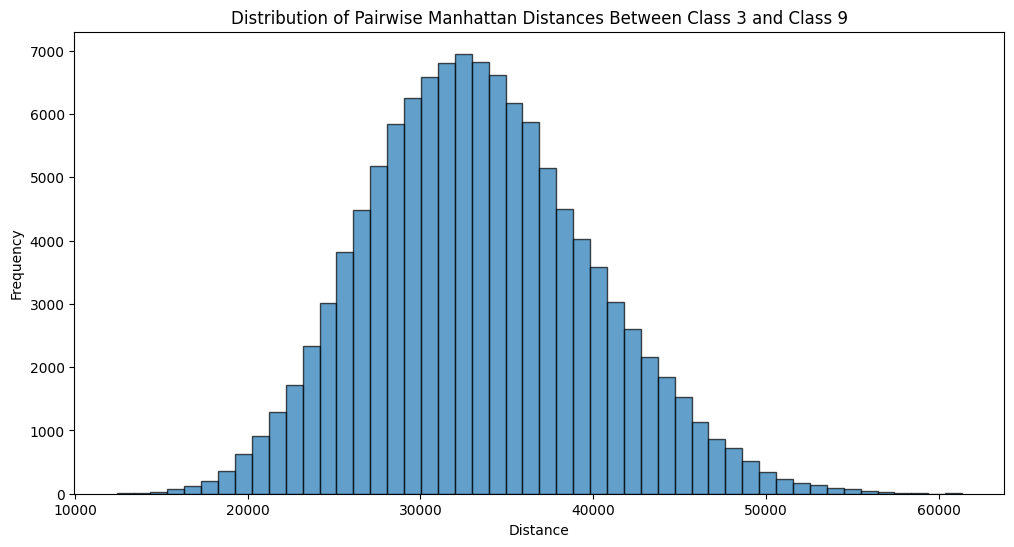

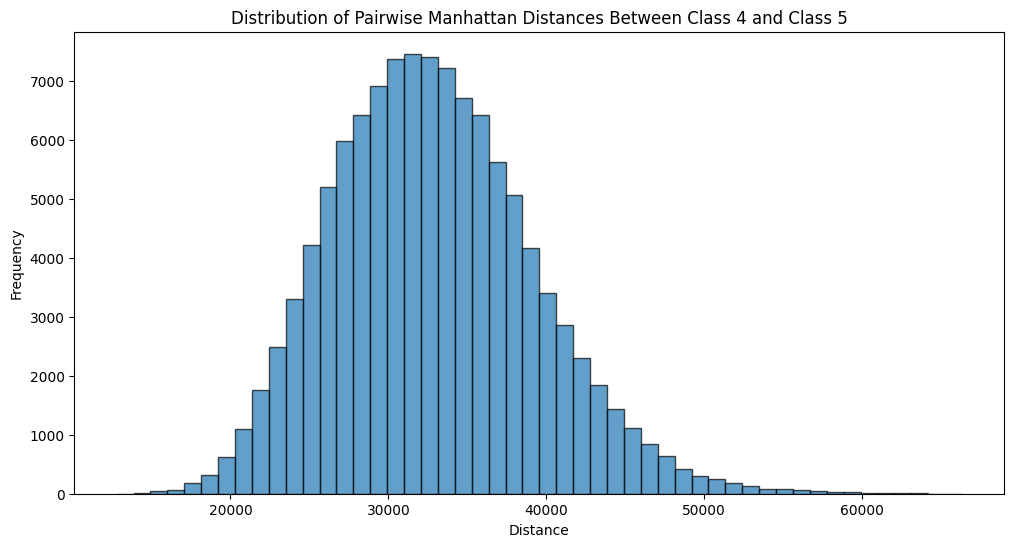

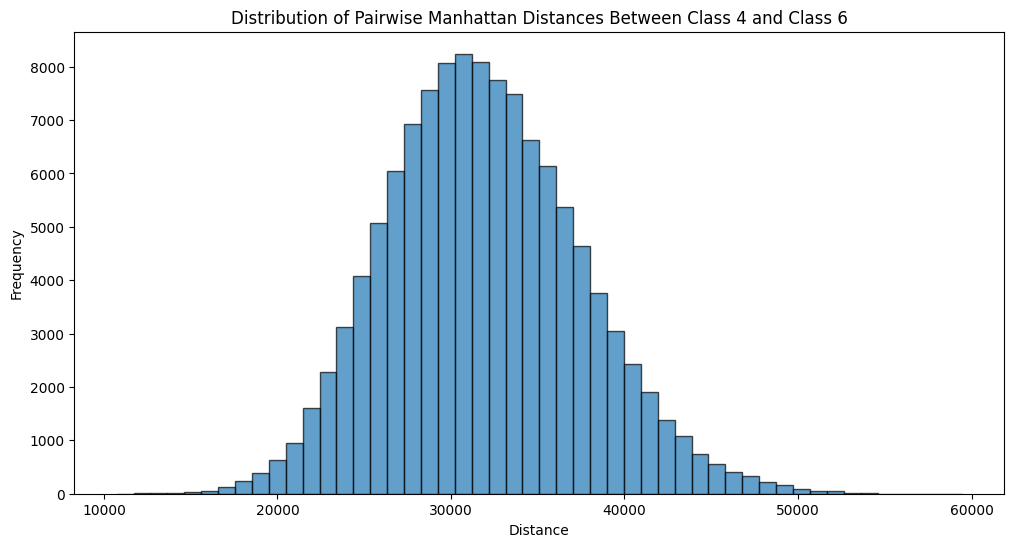

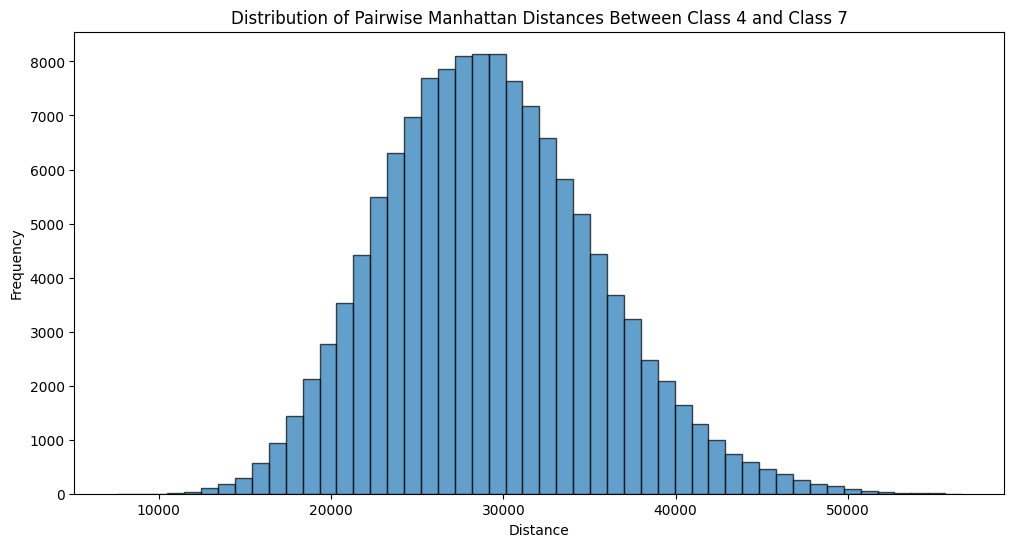

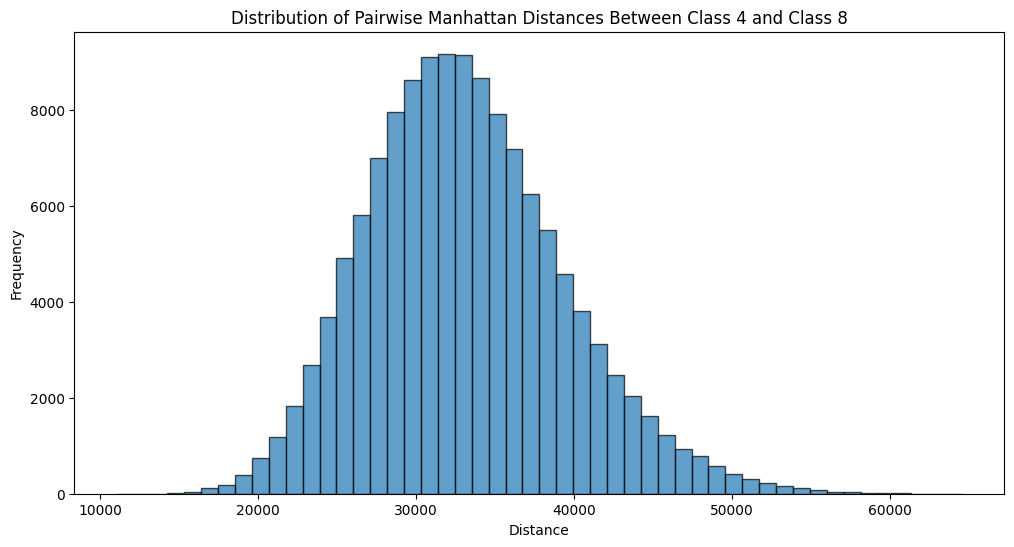

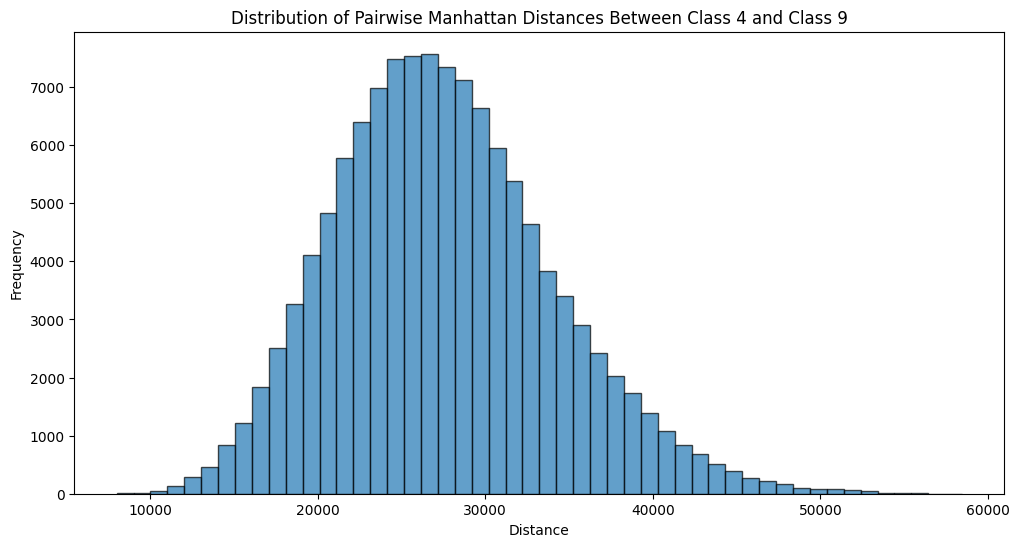

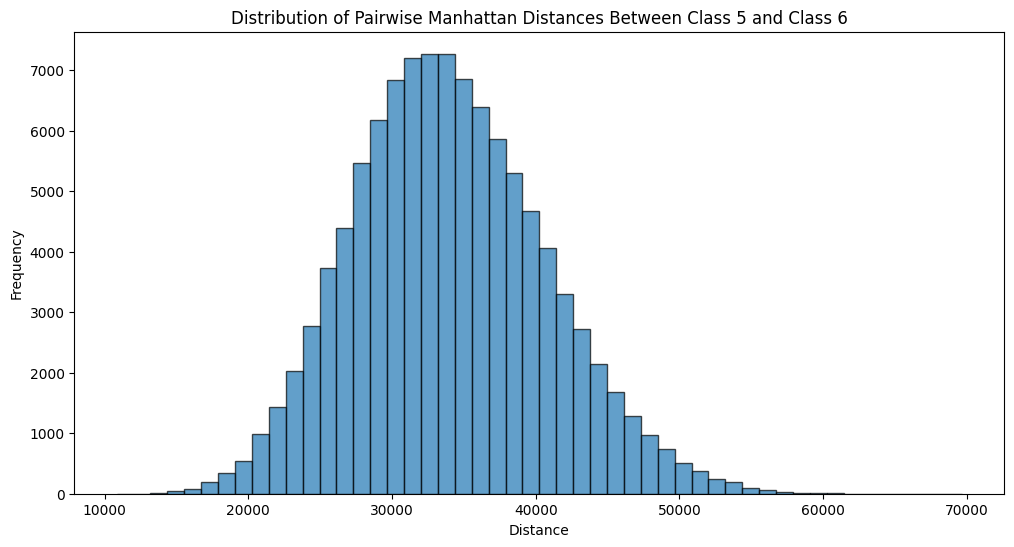

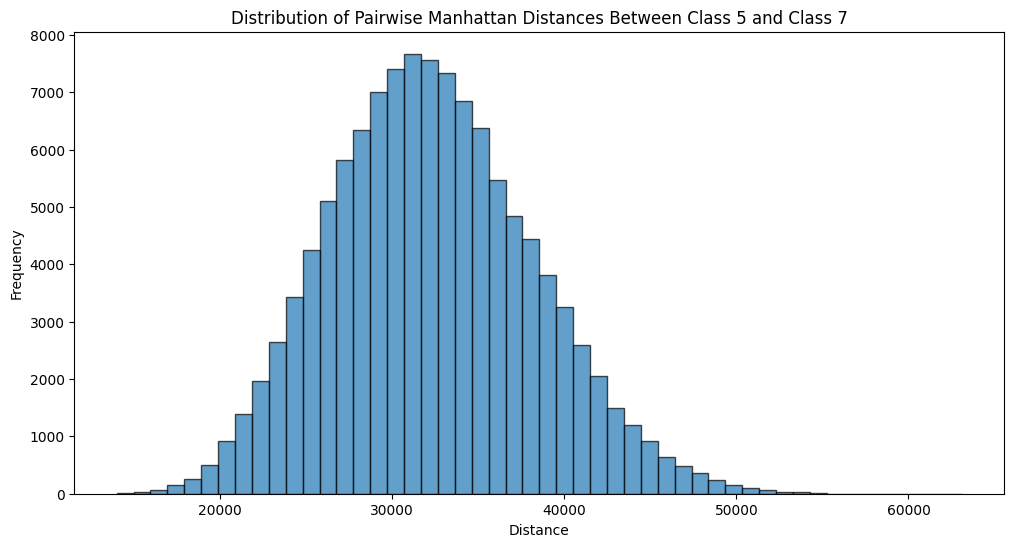

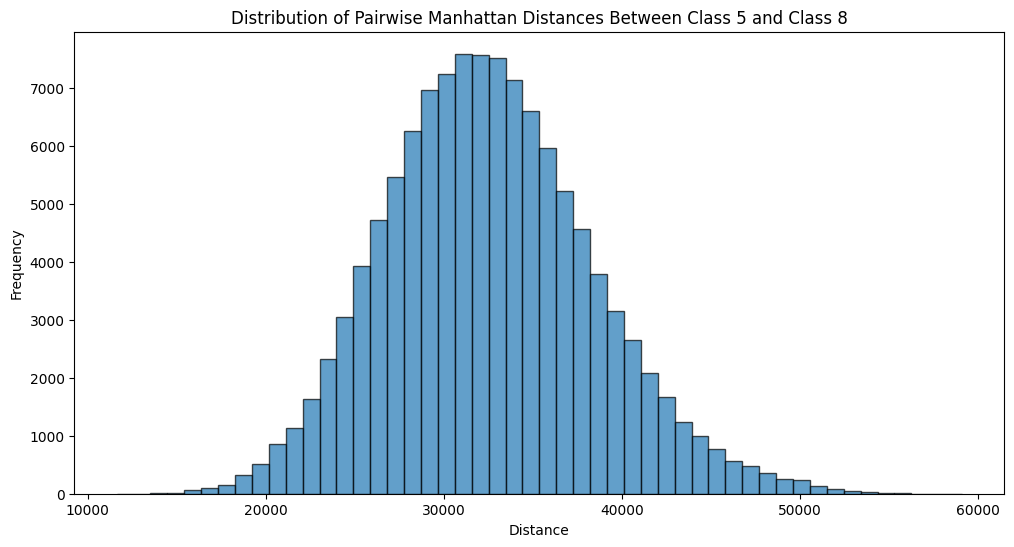

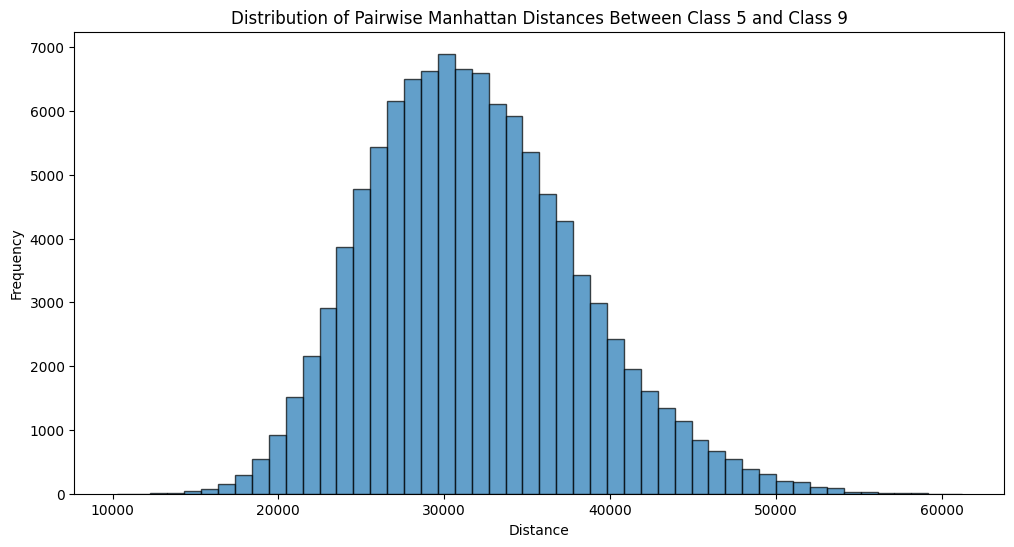

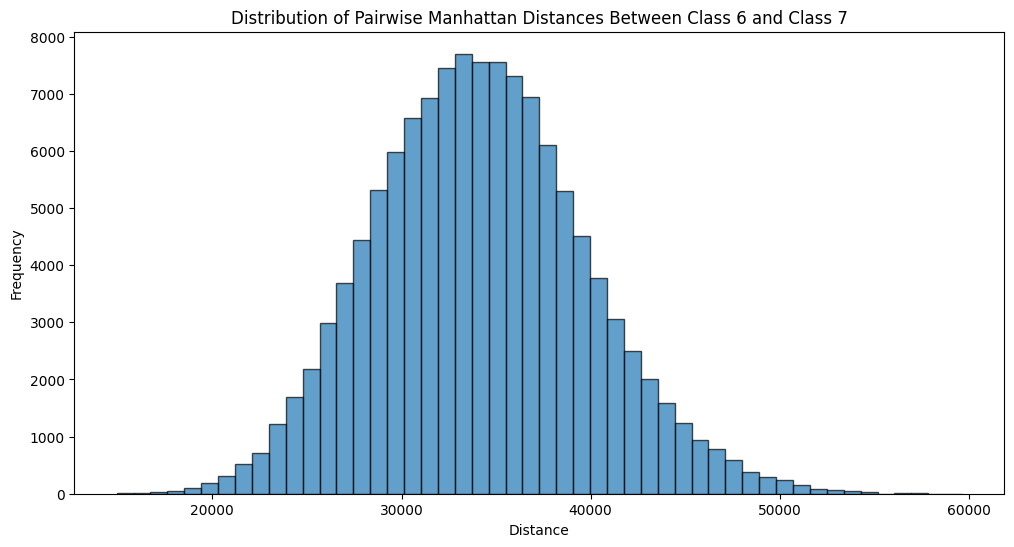

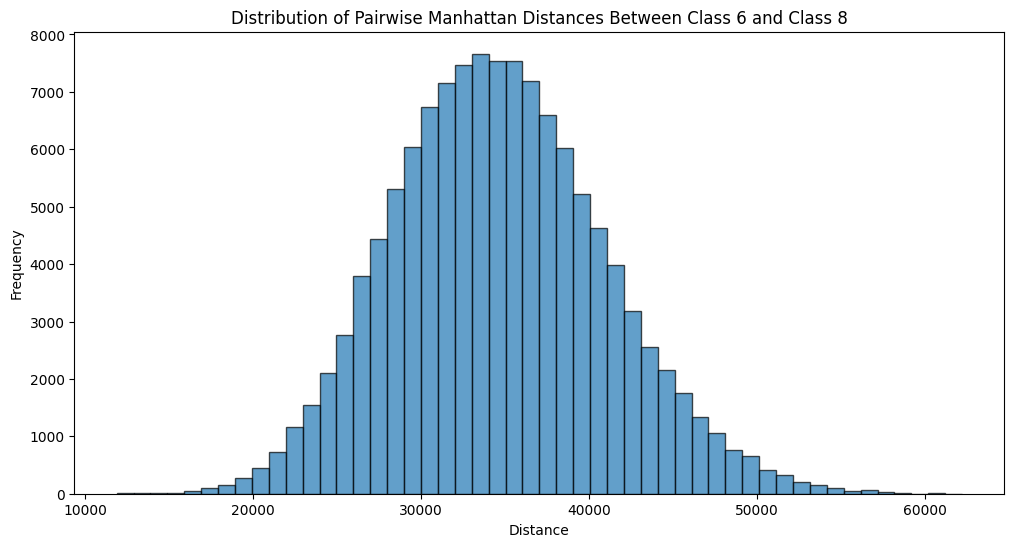

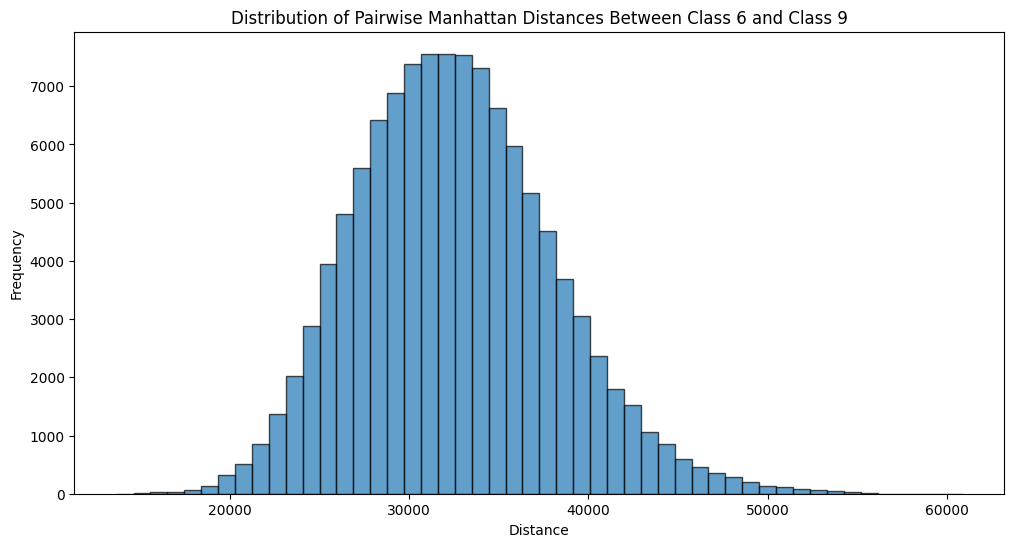

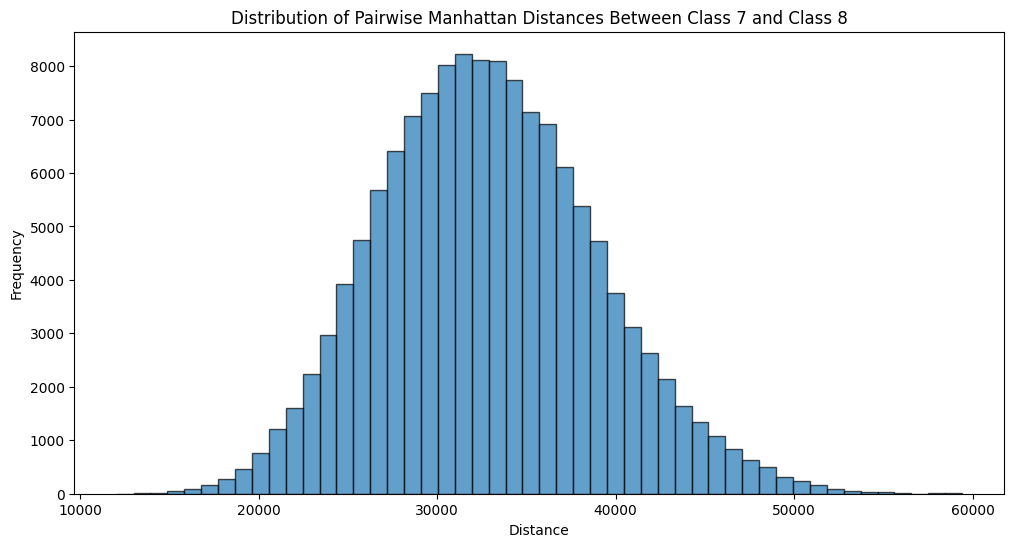

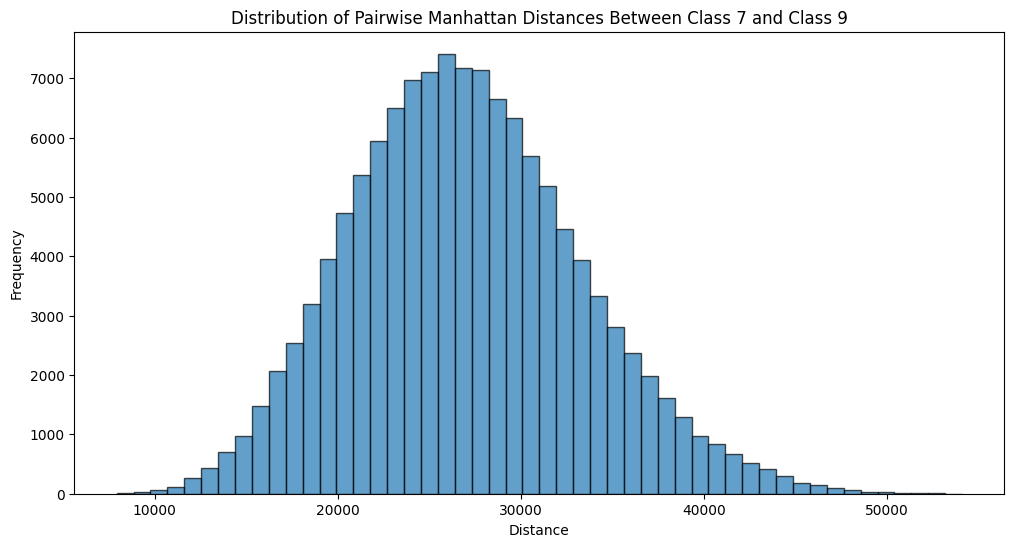

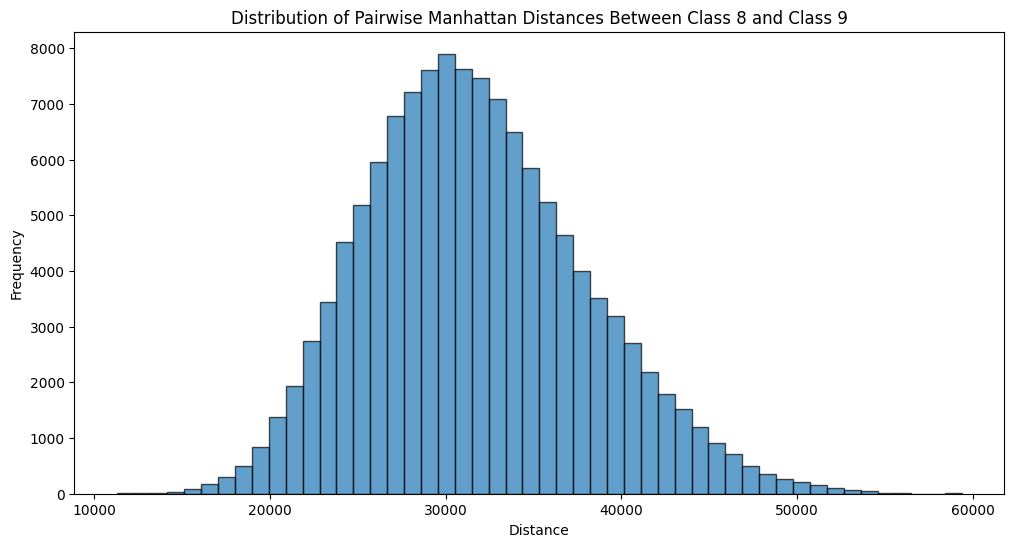

In [ ]:
for i in range(10):
    for j in range(i+1, 10):
        # Filter to only include classes i and j for each pair of classes
        Xi_train = X_train[y_train == i]
        Xj_train = X_train[y_train == j]

        # pairwise Manhattan distances between classes i and j
        distances = cdist(Xi_train, Xj_train, metric='cityblock')

        # Flatten the distances array and compute histogram
        distances = distances.flatten()
        hist, bins = np.histogram(distances, bins=50)

        plt.figure(figsize=(12, 6))
        plt.bar(bins[:-1], hist, width=np.diff(bins), edgecolor="black", alpha=0.7)
        plt.title(f'Distribution of Pairwise Manhattan Distances Between Class {i} and Class {j}')
        plt.xlabel('Distance')
        plt.ylabel('Frequency')
        plt.show()

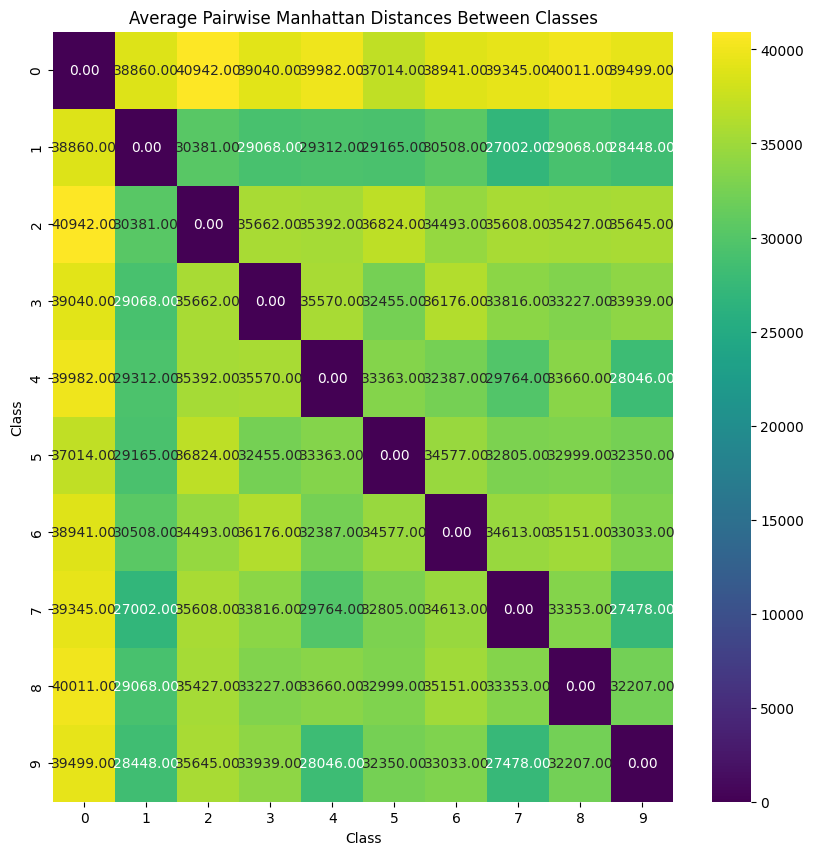

In [ ]:
avg_distances = np.zeros((10, 10))

for i in range(10):
    for j in range(i+1, 10):
        # Filter to only include classes i and j
        Xi_train = X_train[y_train == i]
        Xj_train = X_train[y_train == j]

        # Compute pairwise Manhattan distances between classes i and j
        distances = cdist(Xi_train, Xj_train, metric='cityblock')

        # Compute the average distance and store it in the matrix
        avg_distances[i, j] = round(np.mean(distances), 0)
        avg_distances[j, i] = avg_distances[i, j]

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(avg_distances, annot=True, fmt=".2f", cmap='viridis')
plt.title('Average Pairwise Manhattan Distances Between Classes')
plt.xlabel('Class')
plt.ylabel('Class')
plt.show()

In [ ]:
# Compute the average distance of each class to all other classes
avg_distance_to_all = avg_distances.mean(axis=1)

# Start with the class that has the smallest average distance to all other classes
order = [np.argmin(avg_distance_to_all)]

# Iteratively add the class that has the smallest average distance to the classes already in the order
for _ in range(9):
    remaining_classes = [i for i in range(10) if i not in order]
    next_class = min(remaining_classes, key=lambda i: np.mean([avg_distances[i, j] for j in order]))
    order.append(next_class)

# Print out the order and the distance from each class to the next class in the order
for i in range(9):
    print(f"Class {order[i]} -> Class {order[i+1]}: Distance = {avg_distances[order[i], order[i+1]]}")

Class 1 -> Class 7: Distance = 27002.0
Class 7 -> Class 9: Distance = 27478.0
Class 9 -> Class 4: Distance = 28046.0
Class 4 -> Class 5: Distance = 33363.0
Class 5 -> Class 8: Distance = 32999.0
Class 8 -> Class 3: Distance = 33227.0
Class 3 -> Class 6: Distance = 36176.0
Class 6 -> Class 2: Distance = 34493.0
Class 2 -> Class 0: Distance = 40942.0


In [ ]:
# Initialize an empty dictionary to store the closest class to each class
closest_classes = {}

for i in range(10):
    # Exclude the distance of the class to itself
    distances_to_other_classes = [(j, avg_distances[i, j]) for j in range(10) if i != j]

    # Find the class that has the smallest average distance to class i
    closest_class, min_distance = min(distances_to_other_classes, key=lambda x: x[1])

    # Store the closest class and the distance in the dictionary
    closest_classes[i] = (closest_class, min_distance)

# Print out the closest class to each class and the distance
for class_label, (closest_class, distance) in closest_classes.items():
    print(f"The closest class to {class_label} is {closest_class} with an average distance of {distance}")

The closest class to 0 is 5 with an average distance of 37014.0
The closest class to 1 is 7 with an average distance of 27002.0
The closest class to 2 is 1 with an average distance of 30381.0
The closest class to 3 is 1 with an average distance of 29068.0
The closest class to 4 is 9 with an average distance of 28046.0
The closest class to 5 is 1 with an average distance of 29165.0
The closest class to 6 is 1 with an average distance of 30508.0
The closest class to 7 is 1 with an average distance of 27002.0
The closest class to 8 is 1 with an average distance of 29068.0
The closest class to 9 is 7 with an average distance of 27478.0


In [ ]:
# Compute the average distance of each class to all other classes
avg_distance_to_all = avg_distances.mean(axis=1)

# Start with the class that has the smallest average distance to all other classes
order = [np.argmin(avg_distance_to_all)]

# Iteratively add the class that has the smallest average distance to the classes already in the order
for _ in range(9):
    remaining_classes = [i for i in range(10) if i not in order]
    next_class = min(remaining_classes, key=lambda i: np.mean([avg_distances[i, j] for j in order]))
    order.append(next_class)

# Print out the order of classes
print("Order of classes: ", order)

Order of classes:  [1, 7, 9, 4, 5, 8, 3, 6, 2, 0]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

class PairwiseDistanceClassifier:
    def __init__(self):
        self.class_pairs = {}
        self.class_means = {}

    def fit(self, X, y):
        for class_label in np.unique(y):
            X_class = X[y == class_label]
            self.class_means[class_label] = np.mean(X_class, axis=0)

        for i in range(10):
            for j in range(i+1, 10):
                Xi = X[y == i]
                Xj = X[y == j]
                pairwise_distances = cdist(Xi, Xj, metric='cityblock')
                self.class_pairs[(i, j)] = np.mean(pairwise_distances)

    def predict(self, X):
        predictions = []
        for x in X:
            distances = {class_label: np.linalg.norm(x - class_mean) for class_label, class_mean in self.class_means.items()}
            nearest_class = min(distances, key=distances.get)
            predictions.append(nearest_class)
        return np.array(predictions)

# Train a pairwise distance classifier
clf = PairwiseDistanceClassifier()
clf.fit(X_train, y_train)
print("Model trained.")
# Predict the classes of the test data
y_pred = clf.predict(X_test)

# Compute the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

Accuracy: 0.8133571428571429


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=42)

class PairwiseDistanceClassifier:
    def __init__(self):
        self.class_pairs = {}
        self.class_means = {}

    def fit(self, X, y):
        for class_label in np.unique(y):
            X_class = X[y == class_label]
            self.class_means[class_label] = np.mean(X_class, axis=0)

        for i in range(10):
            for j in range(i+1, 10):
                Xi = X[y == i]
                Xj = X[y == j]
                pairwise_distances = cdist(Xi, Xj, metric='cityblock')
                self.class_pairs[(i, j)] = np.mean(pairwise_distances)

    def predict(self, X):
        predictions = []
        for x in X:
            distances = {class_label: np.linalg.norm(x - class_mean) for class_label, class_mean in self.class_means.items()}
            nearest_class = min(distances, key=distances.get)
            predictions.append(nearest_class)
        return np.array(predictions)

# Train a pairwise distance classifier
clf = PairwiseDistanceClassifier()
clf.fit(X_train, y_train)

# Predict the classes of the test data
y_pred = clf.predict(X_test)

# Compute the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

Accuracy: 0.8035037593984963


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=42)

class PairwiseDistanceClassifier:
    def __init__(self):
        self.class_pairs = {}
        self.class_means = {}

    def fit(self, X, y):
        for class_label in np.unique(y):
            X_class = X[y == class_label]
            self.class_means[class_label] = np.mean(X_class, axis=0)

        for i in range(10):
            for j in range(i+1, 10):
                Xi = X[y == i]
                Xj = X[y == j]
                pairwise_distances = cdist(Xi, Xj, metric='cityblock')
                self.class_pairs[(i, j)] = np.mean(pairwise_distances)

    def predict(self, X):
        predictions = []
        correct_distances = []
        incorrect_distances = []
        for x, y in zip(X, y_test):
            distances = {class_label: np.linalg.norm(x - class_mean) for class_label, class_mean in self.class_means.items()}
            nearest_class = min(distances, key=distances.get)
            is_correct = nearest_class == y
            if is_correct:
                correct_distances.append(distances.get(nearest_class))
            else:
                incorrect_distances.append(distances.get(nearest_class))
            predictions.append(nearest_class)
        print(f"Average distance for correct predictions: {np.mean(correct_distances)}")
        print(f"Average distance for incorrect predictions: {np.mean(incorrect_distances)}")
        return np.array(predictions)

# Train a pairwise distance classifier
clf = PairwiseDistanceClassifier()
clf.fit(X_train, y_train)

# Predict the classes of the test data
y_pred = clf.predict(X_test)

# Compute the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

Average distance for correct predictions: 1569.9661315387066
Average distance for incorrect predictions: 1733.495293028562
Accuracy: 0.8035037593984963


In [ ]:
incorrect_indices = np.where(y_pred != y_test)[0]

# Get the classes of the incorrect predictions
incorrect_classes = y_test[incorrect_indices]

# Count the classes of the incorrect predictions
incorrect_class_counts = Counter(incorrect_classes)

# Get the predicted classes of the incorrect predictions
incorrect_predictions = y_pred[incorrect_indices]

# Count the predicted classes of the incorrect predictions
incorrect_prediction_counts = Counter(incorrect_predictions)

# Count the correct classes for each incorrect prediction
correct_counts_for_incorrect_predictions = {pred: Counter(y_test[np.where(y_pred == pred)[0]]) for pred in incorrect_prediction_counts}

actual_counts_for_incorrect_predictions = {pred: Counter(y_test[np.where(y_pred[incorrect_indices] == pred)[0]]) for pred in incorrect_prediction_counts}

print(f"Accuracy: {accuracy}")
print(f"Counts of incorrect classes: {incorrect_class_counts}")
print(f"Counts of actual classes for each incorrect prediction: {actual_counts_for_incorrect_predictions}")
[1, 7, 9, 4, 5, 8, 3, 6, 2, 0]
[1, 7, 9, 4, 5, 8, 3, 6, 2, 0]

Accuracy: 0.8035037593984963
Counts of incorrect classes: Counter({5: 2098, 8: 1813, 9: 1608, 2: 1596, 3: 1484, 4: 1260, 7: 1171, 6: 903, 0: 871, 1: 263})
Counts of actual classes for each incorrect prediction: {9: Counter({1: 211, 0: 205, 7: 194, 8: 193, 2: 190, 3: 189, 9: 188, 4: 169, 6: 163, 5: 162}), 5: Counter({1: 159, 7: 159, 3: 153, 4: 148, 6: 142, 2: 141, 5: 137, 8: 137, 9: 134, 0: 120}), 1: Counter({7: 270, 2: 256, 1: 255, 6: 253, 8: 241, 9: 239, 3: 239, 5: 226, 4: 222, 0: 215}), 7: Counter({9: 93, 1: 92, 6: 87, 7: 82, 4: 81, 8: 73, 0: 72, 2: 69, 3: 61, 5: 51}), 2: Counter({0: 97, 1: 96, 7: 94, 9: 91, 3: 83, 6: 79, 8: 78, 4: 75, 5: 71, 2: 63}), 3: Counter({1: 241, 6: 207, 7: 199, 3: 199, 9: 194, 2: 180, 0: 176, 8: 173, 5: 166, 4: 159}), 4: Counter({3: 165, 9: 165, 1: 164, 5: 155, 8: 155, 7: 153, 0: 148, 6: 143, 4: 133, 2: 133}), 8: Counter({1: 132, 2: 118, 5: 112, 3: 108, 7: 105, 9: 104, 6: 104, 4: 104, 0: 94, 8: 86}), 6: Counter({0: 90, 3: 87, 8: 82, 7: 80, 4: 80, 1: 80, 9: 7

[1, 7, 9, 4, 5, 8, 3, 6, 2, 0]

In [ ]:
class NearestCentroidClassifier:
    def __init__(self):
        self.class_means = {}

    def fit(self, X, y):
        for class_label in np.unique(y):
            X_class = X[y == class_label]
            self.class_means[class_label] = np.mean(X_class, axis=0)

    def predict(self, X):
        predictions = []
        for x in X:
            distances = {class_label: np.linalg.norm(x - class_mean) for class_label, class_mean in self.class_means.items()}
            nearest_class = min(distances, key=distances.get)
            predictions.append(nearest_class)
        return np.array(predictions)

# Train a nearest centroid classifier
clf = NearestCentroidClassifier()
clf.fit(X_train, y_train)

# Predict the classes of the test data
y_pred = clf.predict(X_test)

# Compute the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

Accuracy: 0.8035037593984963


In [ ]:
#get value counts for y_pred
y_pred_counts = np.unique(y_pred, return_counts=True)
y_pred_counts


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([6216, 9623, 5880, 7212, 6722, 5330, 6413, 6517, 5712, 6875]))

In [ ]:
# This is a simplified pseudocode and won't run as is
predictions = []
# Compute the pairwise distances between each pair of classes
pairwise_distances = {}
for i in range(10):
    for j in range(i+1, 10):
        Xi_train = X_train[y_train == i]
        Xj_train = X_train[y_train == j]
        distances = cdist(Xi_train, Xj_train, metric='cityblock')
        pairwise_distances[(i, j)] = np.mean(distances)

In [ ]:
# For each test example
for x_test in X_test:
    # Compute the difference between the test example and the pairwise distances of each pair of classes
    differences = [np.abs(np.mean(cdist(x_test.reshape(1, -1), X_train[(y_train == i) | (y_train == j)], metric='cityblock')) - pairwise_distances[(i, j)]) for i in range(10) for j in range(i+1, 10)]
    # Find the pair of classes with the smallest difference
    predicted_pair = np.argmin(differences)
    # Append the predicted pair to the list of predictions
    predictions.append(predicted_pair)

In [ ]:

import pandas as pd

# Generate all pairs of classes
pairs = [(i, j) for i in range(10) for j in range(i+1, 10)]

# Create a dictionary that maps each index to its corresponding pair of classes
index_to_pair = {index: pair for index, pair in enumerate(pairs)}

# Convert the list of predictions into a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['predicted_pair'])

# Use the map function to translate the indices to pairs
predictions_df['predicted_pair_translated'] = predictions_df['predicted_pair'].map(index_to_pair)

      predicted_pair predicted_pair_translated
0                 44                    (8, 9)
1                 32                    (4, 7)
2                 25                    (3, 5)
3                 17                    (2, 3)
4                 15                    (1, 8)
...              ...                       ...
3495              13                    (1, 6)
3496              30                    (4, 5)
3497              22                    (2, 8)
3498              21                    (2, 7)
3499              15                    (1, 8)

[3500 rows x 2 columns]


In [ ]:
print(predictions_df)

      predicted_pair predicted_pair_translated  true
0                 44                    (8, 9)     2
1                 32                    (4, 7)     8
2                 25                    (3, 5)     5
3                 17                    (2, 3)     9
4                 15                    (1, 8)     4
...              ...                       ...   ...
3495              13                    (1, 6)     3
3496              30                    (4, 5)     8
3497              22                    (2, 8)     2
3498              21                    (2, 7)     2
3499              15                    (1, 8)     7

[3500 rows x 3 columns]


In [ ]:
predictions_df['true_in_predicted'] = predictions_df.apply(lambda row: row['true'] in row['predicted_pair_translated'], axis=1)

# Compute the proportion of test examples where the true class appears in the predicted pair
proportion = predictions_df['true_in_predicted'].mean()

print(proportion)

0.18371428571428572


In [ ]:
can we compute the differcnes between examples in xtest and group them by how close they are to each other,

that value si 0.18371428571428572, how could we modify our algorithm to work better?

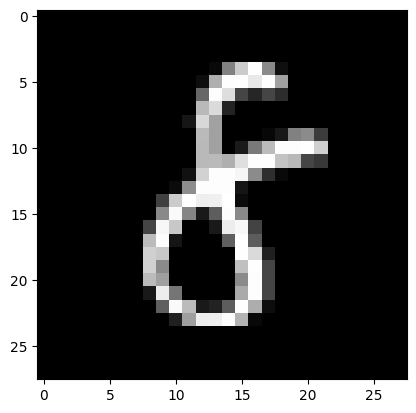

In [ ]:
image = X_test[1].reshape(28, 28)
# Plot the image
plt.imshow(image, cmap='gray')
plt.show()

In [ ]:
# This is a simplified pseudocode and won't run as is
predictions = []
# For each test example
for x_test in X_test:
    # Compute the difference between the test example and the pairwise distances of each class
    differences = [np.abs(np.mean(cdist(x_test.reshape(1, -1), X_train[y_train == class_], metric='cityblock')) - avg_distances[class_]) for class_ in range(10)]
    # Find the class with the smallest difference
    predicted_class = np.argmin(differences)
    # Append the predicted class to the list of predictions
    predictions.append(predicted_class)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ee558bc7-9ccd-4428-bb80-236363650a2f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>